In [1]:
import numpy as np
import pandas as pd
import cobra
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from cobra import Model, Reaction, Metabolite
from cobra.util.solver import linear_reaction_coefficients
from cobra.util.solver import add_lexicographic_constraints
from matplotlib import colormaps
import statistics as stats
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import visualisation
import plotly.graph_objs as go
import statistics

In [ ]:
%store -r constrained_4
%store -r constrained_678
%store -r constrained_111214
early_model = constrained_4
late_model = constrained_678
death_model = constrained_111214

no stored variable or alias constrained_4


#### Constrain enzyme-constrained models with uptake/secretion rates from bioreactors

In [50]:
bioprocess = pd.read_csv(r'bioprocess_repeats_calculations_for_plotting_with_averages.csv')
bioprocess = bioprocess.set_index('Unnamed: 0')
bioprocess

early       late  stationary
Unnamed: 0                                  
growth       0.480366   0.350357   -0.034308
igg         21.248066  23.047645   23.888907
gluc       -12.539469  -6.123960   -5.832015
gln         -2.634524  -0.507247   -0.198716
lac          5.075625  -0.361655   -0.135942
nh4          0.238496  -0.039006    0.023229

In [5]:
uptakes_secretions = {'GLNtN1':'glutamine uptake, Na and H coupled',
                      'GLCt1r':'glucose uptake via GLUT1 uniporter',
                      'LDH_D':'lactate production via lactate dehydrogenase',
                      'GLUN':'production of ammonia from glutamine via glutaminase'}
uptakes_secretions

{'GLNtN1': 'glutamine uptake, Na and H coupled',
 'GLCt1r': 'glucose uptake via GLUT1 uniporter',
 'LDH_D': 'lactate production via lactate dehydrogenase',
 'GLUN': 'production of ammonia from glutamine via glutaminase'}

In [51]:
#plot the flux through uptake/secretion bioreactor reactions without constraints
print('early model:')
early_model.objective = early_model.reactions.get_by_id('biomass_cho_prod')
early_solution = early_model.optimize()
for k,v in uptakes_secretions.items():
    print(k,early_model.reactions.get_by_id(k).reaction,early_solution.fluxes[k])

print('\n')
print('late model:')
late_model.objective = late_model.reactions.get_by_id('biomass_cho_prod')
late_solution = late_model.optimize()
for k,v in uptakes_secretions.items():
    print(k,late_model.reactions.get_by_id(k).reaction,late_solution.fluxes[k])

print('\n')
print('stationary model:')
death_model.objective = death_model.reactions.get_by_id('biomass_cho_prod')
death_solution = death_model.optimize()
for k,v in uptakes_secretions.items():
    print(k,death_model.reactions.get_by_id(k).reaction,death_solution.fluxes[k])

early model:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <=> gln_L[c] + h[e] + 2.0 na1[c] 0.0
GLCt1r glc_D[e] <=> glc_D[c] 0.043613463839149755
LDH_D lac_D[c] + nad[c] <=> h[c] + nadh[c] + pyr[c] -4.95184827613608e-05
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.002546868144052793


late model:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <=> gln_L[c] + h[e] + 2.0 na1[c] 0.0
GLCt1r glc_D[e] <=> glc_D[c] 0.040249745363475364
LDH_D lac_D[c] + nad[c] <=> h[c] + nadh[c] + pyr[c] 0.0
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.0


stationary model:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <=> gln_L[c] + h[e] + 2.0 na1[c] 0.0
GLCt1r glc_D[e] <=> glc_D[c] 0.0
LDH_D lac_D[c] + nad[c] <=> h[c] + nadh[c] + pyr[c] -0.000251649702700458
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.01228134788922965


In [52]:
#add bioreactor constraints on uptake/secretions and plot solution
early_model_bioprocess = early_model.copy()
model = early_model_bioprocess
print('early model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,0],bioprocess.iloc[3,0])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,0],bioprocess.iloc[2,0])
model.reactions.get_by_id('LDH_D').bounds = (bioprocess.iloc[4,0]*-1,bioprocess.iloc[4,0]*-1)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,0],bioprocess.iloc[5,0])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
early_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,early_solution.fluxes[k])
print('\n')

late_model_bioprocess = late_model.copy()
model = late_model_bioprocess
print('late model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,1],bioprocess.iloc[3,1])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,1],bioprocess.iloc[2,1])
model.reactions.get_by_id('LDH_D').bounds = (bioprocess.iloc[4,1]*-1,bioprocess.iloc[4,1]*-1)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,1],bioprocess.iloc[5,1])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
late_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,late_solution.fluxes[k])
print('\n')

death_model_bioprocess = death_model.copy()
model = death_model_bioprocess
print('stationary model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,2],bioprocess.iloc[3,2])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,2],bioprocess.iloc[2,2])
model.reactions.get_by_id('LDH_D').bounds = (bioprocess.iloc[4,2]*-1,bioprocess.iloc[4,2]*-1)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,2],bioprocess.iloc[5,2])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
stationary_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,stationary_solution.fluxes[k])

early model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -2.634523897
GLCt1r glc_D[e] <-- glc_D[c] -12.53946896
LDH_D lac_D[c] + nad[c] <-- h[c] + nadh[c] + pyr[c] -5.075624872
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.238495949




C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


late model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -0.507246913
GLCt1r glc_D[e] <-- glc_D[c] -6.12396011
LDH_D lac_D[c] + nad[c] --> h[c] + nadh[c] + pyr[c] 0.1963155254496247
GLUN gln_L[c] + h2o[c] <-- glu_L[c] + nh4[c] -0.03900574


stationary model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -0.198715895
GLCt1r glc_D[e] <-- glc_D[c] -5.832015251
LDH_D lac_D[c] + nad[c] --> h[c] + nadh[c] + pyr[c] 0.135941685
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.023228821


In [76]:
#infeasible when lactate production is constrained too tightly so set the bioreactor flux as maximum instead of minimum
#sanity check: still moved from production to consumption so was close enough qualitatively to bioreactor 'truth'
early_model_bioprocess_1 = early_model.copy()
model = early_model_bioprocess_1
print('early model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,0],bioprocess.iloc[3,0])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,0],bioprocess.iloc[2,0])
model.reactions.get_by_id('LDH_D').bounds = (bioprocess.iloc[4,0]*-1,0)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,0],bioprocess.iloc[5,0])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
early_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,early_solution.fluxes[k])
print(early_solution.status)
print('\n')

late_model_bioprocess_1 = late_model.copy()
model = late_model_bioprocess_1
print('late model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,1],bioprocess.iloc[3,1])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,1],bioprocess.iloc[2,1])
model.reactions.get_by_id('LDH_D').bounds = (0,bioprocess.iloc[4,1]*-1)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,1],bioprocess.iloc[5,1])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
late_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,late_solution.fluxes[k])
print(late_solution.status)
print('\n')

death_model_bioprocess_1 = death_model.copy()
model = death_model_bioprocess_1
print('stationary model bioprocess rate constrained:')
model.reactions.get_by_id('GLNtN1').bounds = (bioprocess.iloc[3,2],bioprocess.iloc[3,2])
model.reactions.get_by_id('GLCt1r').bounds = (bioprocess.iloc[2,2],bioprocess.iloc[2,2])
model.reactions.get_by_id('LDH_D').bounds = (bioprocess.iloc[4,2]*-1,bioprocess.iloc[4,2]*-1)
model.reactions.get_by_id('GLUN').bounds = (bioprocess.iloc[5,2],bioprocess.iloc[5,2])
model.objective = model.reactions.get_by_id('biomass_cho_prod')
stationary_solution = model.optimize()
for k,v in uptakes_secretions.items():
    print(k,model.reactions.get_by_id(k).reaction,stationary_solution.fluxes[k])
print(stationary_solution.status)

early model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -2.634523897
GLCt1r glc_D[e] <-- glc_D[c] -12.53946896
LDH_D lac_D[c] + nad[c] <-- h[c] + nadh[c] + pyr[c] -0.15636367176222013
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.238495949
optimal


late model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -0.507246913
GLCt1r glc_D[e] <-- glc_D[c] -6.12396011
LDH_D lac_D[c] + nad[c] --> h[c] + nadh[c] + pyr[c] 0.0
GLUN gln_L[c] + h2o[c] <-- glu_L[c] + nh4[c] -0.03900574
optimal


stationary model bioprocess rate constrained:
GLNtN1 gln_L[e] + h[c] + 2.0 na1[e] <-- gln_L[c] + h[e] + 2.0 na1[c] -0.198715895
GLCt1r glc_D[e] <-- glc_D[c] -5.832015251
LDH_D lac_D[c] + nad[c] --> h[c] + nadh[c] + pyr[c] 0.135941685
GLUN gln_L[c] + h2o[c] --> glu_L[c] + nh4[c] 0.023228821
optimal


In [86]:
#save solutions as 'truth' to compare to optimisation trials
early_truth = early_solution
late_truth = late_solution
stationary_truth = stationary_solution
early_truth_df = early_truth.to_frame()
late_truth_df = late_truth.to_frame()
stationary_truth_df = stationary_truth.to_frame()

In [95]:
#check there are differences between the solutions before I move onto optimisation trials
#as in constraints are actually having an effect on the overall flux distribution
for n in range(len(early_truth_df)):
    if early_truth_df.iloc[n,0] != late_truth_df.iloc[n,0]:
        print((early_truth_df.index.to_list())[n], early_truth_df.iloc[n,0], late_truth_df.iloc[n,0])

10FTHFtm 4.0426969225197147e-19 0.0
2AMADPTm 0.000159619142603596 0.0
2AOBUTtm 8.02287025720741e-06 0.0
2HBO -4.441555348518535e-21 0.0
2OXOADPTm 0.0008713678750500353 0.0
34HPPOR 0.0 9.428114138962395e-05
3DSPHR 1.972653866884003e-05 1.7191191252110772e-05
3HAO 0.0010309870176536298 0.0
3HBCOAHLm 4.623114865733862e-19 0.0
3HLYTCL 0.0001380950070338263 0.0
3MOBt2im -3.71148105212744e-05 0.0
3MOPt2im 0.0 0.000128470393639388
3SALAASPm -0.0001300425172847 0.0
3SALATAim 0.00013004251728469996 0.0
3SPYRSPm 0.00013004251728469996 0.0
4ABUTtm -0.00975215567775251 -0.03074719255443908
4HGLSDm 0.0003312848703979856 0.0
4MOPt2im -3.71148105212744e-05 0.0
5MTHFt2 -3.9706170442074685e-20 0.0
AACOAT 0.0017458732214855025 0.0014642484391812838
AACTOOR 1.9450872694072635e-19 0.0
AATAi -0.000159619142603596 0.0
ABTArm -0.00975215567775251 -0.030747192554439078
ABUTt4_2_r -0.03612358122806016 -0.030747192554439074
ACACT1r -0.0017458732214855025 -0.0014642484391812838
ACACT1rm 0.003260893558497087 0.00

#### Try out maximisations of different second objectives using lexicographic optimisation

In [23]:
reactions = []
for r in model.reactions:
    reactions.append(r.id)

In [42]:
#set each model reaction as the second constraint using lexicographic approach
#FBA for flux distribution for each option and save as df
objectives_df = pd.DataFrame()
objectives_df['reactions'] = reactions
objectives_df = objectives_df.set_index('reactions')

early_test = early_model.copy()
model = early_test
for r in model.reactions:
    with model:
        lexi_solution = add_lexicographic_constraints(model,objectives=['biomass_cho_prod',r.id])
        model.reactions.get_by_id('biomass_cho_prod').bounds = (lexi_solution.iloc[0],lexi_solution.iloc[0])
        model.reactions.get_by_id(r.id).bounds = (lexi_solution.iloc[1],lexi_solution.iloc[1])
        model.objective = model.reactions.get_by_id('biomass_cho_prod')
        solution = model.optimize()
        objectives_df[r.id] = (solution.fluxes).to_list()
        if early_truth != solution:
            print(r.id,'optimisation changes flux distribution')
        if early_truth == solution:
            print(r.id,'optimisation does NOT change flux distribution')

10FTHF5GLUtl optimisation changes flux distribution
10FTHF5GLUtm optimisation changes flux distribution
10FTHF6GLUtl optimisation changes flux distribution
10FTHF6GLUtm optimisation changes flux distribution
10FTHF7GLUtl optimisation changes flux distribution
10FTHF7GLUtm optimisation changes flux distribution
10FTHFtl optimisation changes flux distribution
10FTHFtm optimisation changes flux distribution
11DOCRTSLtm optimisation changes flux distribution
11DOCRTSLtr optimisation changes flux distribution
11DOCRTSTRNtm optimisation changes flux distribution
11DOCRTSTRNtr optimisation changes flux distribution
13DAMPPOX optimisation changes flux distribution
1a_24_25VITD2Hm optimisation changes flux distribution
1a_24_25VITD3Hm optimisation changes flux distribution
1a_25VITD2Hm optimisation changes flux distribution
1a_25VITD3Hm optimisation changes flux distribution
1a25DHVITD3TRn optimisation changes flux distribution
1MNCAMti optimisation changes flux distribution
1PPDCRp optimisatio

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


4MOPte optimisation changes flux distribution
4MPTNLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

4MPTNLtm optimisation changes flux distribution
4MTOLBUTAMIDEte optimisation changes flux distribution
4NPHSFte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


4NPHSULT optimisation changes flux distribution
4NPHte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


4OHPROIMINOtc optimisation changes flux distribution
4PYRDX optimisation changes flux distribution
5ADTSTSTERONEGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

5ADTSTSTERONEGLCtr optimisation changes flux distribution
5ADTSTSTERONESte optimisation changes flux distribution
5ADTSTSTERONESULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

5ADTSTSTERONEte optimisation changes flux distribution
5ADTSTSTERONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5AOPtm optimisation changes flux distribution
5FTHFt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5HLTDL optimisation changes flux distribution
5HOMEPRAZOLEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5HOXINDACTO2OX optimisation changes flux distribution
5HOXINDACTOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5HOXINOXDA optimisation changes flux distribution
5HTRPDOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5HTRPVESSEC optimisation changes flux distribution
5HXKYNDCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5HXKYNOXDA optimisation changes flux distribution
5MTAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5MTHFt optimisation changes flux distribution
5MTHFt2 optimisation changes flux distribution
5OXPROt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5THFtl optimisation changes flux distribution
5THFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


6DHFtl optimisation changes flux distribution
6DHFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


6HTSTSTERONEte optimisation changes flux distribution
6HTSTSTERONEtr optimisation changes flux distribution
6THFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

6THFtm optimisation changes flux distribution
7DHCHSTEROLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


7DHFtl optimisation changes flux distribution
7DHFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

7THFtl optimisation changes flux distribution
7THFtm optimisation changes flux distribution
A_MANASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


A_MANASEly optimisation changes flux distribution
A4GALTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


A4GNT1g optimisation changes flux distribution
A4GNT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AACOAT optimisation changes flux distribution
AACTOOR optimisation changes flux distribution
AACTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THP2CDH optimisation changes flux distribution
AASAD3 optimisation changes flux distribution
AASAD3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AATAi optimisation changes flux distribution
ABO1g optimisation changes flux distribution
ABO2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABO3g optimisation changes flux distribution
ABO4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABO5g optimisation changes flux distribution
ABO6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABO7g optimisation changes flux distribution
ABO8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABO9g optimisation changes flux distribution
ABTArm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABTD optimisation changes flux distribution
ABTti optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABUTD optimisation changes flux distribution
ABUTt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ABUTt4_2_r optimisation changes flux distribution
ACACT10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT1rm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACt2 optimisation changes flux distribution
ACACt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACtx optimisation changes flux distribution
ACALDt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACALDtm optimisation changes flux distribution
ACALDtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACCOAC optimisation changes flux distribution
ACCOACm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACCOAgt optimisation changes flux distribution
ACCOALm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACCOAtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACCOAtr optimisation changes flux distribution
ACETONEt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACETONEt2m optimisation changes flux distribution
ACGAGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGAGBSIDEtl optimisation changes flux distribution
ACGALFUCGALACGALFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGALFUCGALACGALFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACGALFUCGALACGALFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGALFUCGALACGALFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACGALK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGALK2 optimisation changes flux distribution
ACGALtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGAM2E optimisation changes flux distribution
ACGAM6PSi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGAMK optimisation changes flux distribution
ACGAMPM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGAMtly optimisation changes flux distribution
ACGBGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGBGBSIDEtl optimisation changes flux distribution
ACGPID optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACHEe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACHtn optimisation changes flux distribution
ACHVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACITL optimisation changes flux distribution
ACN13ACNGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACN13ACNGALGBSIDEtg optimisation changes flux distribution
ACN23ACNGALGBSIDEte optimisation changes flux distribution
ACN23ACNGALGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACNACNGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
ACNACNGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACNACNGALGBSIDEte optimisation changes flux distribution
ACNACNGALGBSIDEtg optimisation changes flux distribution
ACNAM9PL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACNAM9PL2 optimisation changes flux distribution
ACNAMlt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACNAMPH optimisation changes flux distribution
ACNAMtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACNGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
ACNGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACNMLr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD10m optimisation changes flux distribution
ACOAD1fm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD8m optimisation changes flux distribution
ACOAD9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOAHi optimisation changes flux distribution
ACODA optimisation changes flux distribution
ACOX22x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOX2x optimisation changes flux distribution
ACP1_FMN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACRNtm optimisation changes flux distribution
ACSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACt2m optimisation changes flux distribution
ACt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACTLMO optimisation changes flux distribution
ACTNMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACYP optimisation changes flux distribution
ADA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADAe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADCim optimisation changes flux distribution
ADEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADEtl optimisation changes flux distribution
ADHAPtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADK1 optimisation changes flux distribution
ADK1m optimisation changes flux distribution
ADK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADK3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADKd optimisation changes flux distribution
ADMDC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADNCYC optimisation changes flux distribution
ADNK1 optimisation changes flux distribution
ADNK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADNK3 optimisation changes flux distribution
ADNK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADNt4 optimisation changes flux distribution
ADNt5 optimisation changes flux distribution
ADNtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADNtm optimisation changes flux distribution
ADPACDAc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADPACTD optimisation changes flux distribution
ADPCOACROT optimisation changes flux distribution
ADPCOAPTE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADPGK optimisation changes flux distribution
ADPGLC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADPMAN optimisation changes flux distribution
ADPRDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADPRDPm optimisation changes flux distribution
ADPRIBt optimisation changes flux distribution
ADPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADPtx optimisation changes flux distribution
ADRNCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADRNCPT1 optimisation changes flux distribution
ADRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADRNCRNt optimisation changes flux distribution
ADRNLPVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADRNt optimisation changes flux distribution
ADSK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADSKn optimisation changes flux distribution
ADSL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADSL2 optimisation changes flux distribution
ADSS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AFLATOXINte optimisation changes flux distribution
AG13T10g optimisation changes flux distribution
AG13T11g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AG13T12g optimisation changes flux distribution
AG13T13g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AG13T14g optimisation changes flux distribution
AG13T15g optimisation changes flux distribution
AG13T16g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AG13T17g optimisation changes flux distribution
AG13T18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AG13T1g optimisation changes flux distribution
AG13T2g optimisation changes flux distribution
AG13T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AG13T4g optimisation changes flux distribution
AG13T5g optimisation changes flux distribution
AG13T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AG13T7g optimisation changes flux distribution
AG13T8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AG13T9g optimisation changes flux distribution
AGDC optimisation changes flux distribution
AGLPC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AGLPED optimisation changes flux distribution
AGLPET optimisation changes flux distribution
AGLPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGLPR optimisation changes flux distribution
AGLPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGMTm optimisation changes flux distribution
AGPAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGPAT1m optimisation changes flux distribution
AGPex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AGPRim optimisation changes flux distribution
AGPSx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGTim optimisation changes flux distribution
AGTix optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AGXT2L2 optimisation changes flux distribution
AHANDROSTANGLCte optimisation changes flux distribution
AHANDROSTANGLCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AHC optimisation changes flux distribution
AHCYStd optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AHCYSte optimisation changes flux distribution
AHCYStn optimisation changes flux distribution
AHCYStr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AHEXASE2ly optimisation changes flux distribution
AHEXASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AICART optimisation changes flux distribution
AICARte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AIRCr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AK2LGCHOLt optimisation changes flux distribution
AKGMALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGt4_3 optimisation changes flux distribution
AKGtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKR1C1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKR1C41 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKR1C42 optimisation changes flux distribution
AKR1D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKR1D2 optimisation changes flux distribution
ALA_DTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAALACNc optimisation changes flux distribution
ALAALAPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAASNNaEx optimisation changes flux distribution
ALAATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALACYSNaEx optimisation changes flux distribution
ALADGLNexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALADGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAGLNexR optimisation changes flux distribution
ALAGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAGLYexR optimisation changes flux distribution
ALASERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALASm optimisation changes flux distribution
ALAt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAt2rL optimisation changes flux distribution
ALAt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALATA_L optimisation changes flux distribution
ALATHRNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAtN1 optimisation changes flux distribution
ALAyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ALCD1 optimisation changes flux distribution
ALCD21_D optimisation changes flux distribution
ALCD21_L optimisation changes flux distribution
ALCD22_D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ALCD22_L optimisation changes flux distribution
ALCD2if optimisation changes flux distribution
ALCD2yf optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDD19x optimisation changes flux distribution
ALDD19y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDD20x optimisation changes flux distribution
ALDD20xm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDD21 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ALDD2x optimisation changes flux distribution
ALDD2xm optimisation changes flux distribution
ALDD2y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDSTRNte optimisation changes flux distribution
ALDSTRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALKP optimisation changes flux distribution
ALOX12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALOX12R optimisation changes flux distribution
ALOX15 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALOX5 optimisation changes flux distribution
ALOX52 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALR optimisation changes flux distribution
ALR2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALR3 optimisation changes flux distribution
AM6SAD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMACR2p optimisation changes flux distribution
AMACRp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMANK optimisation changes flux distribution
AMCOXO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AMETr optimisation changes flux distribution
AMETt2m optimisation changes flux distribution
AMETtd optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMETtn optimisation changes flux distribution
AMPDA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMPTASECG optimisation changes flux distribution
AMPTASECGe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMPtp optimisation changes flux distribution
AMPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMY1e optimisation changes flux distribution
AMY2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ANDRSTRNGLCte optimisation changes flux distribution
ANDRSTRNGLCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ANDRSTRNte optimisation changes flux distribution
ANDRSTRNtr optimisation changes flux distribution
ANTHte optimisation changes flux distribution
ANTIPYRENEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AOBUTDsm optimisation changes flux distribution
AP4AH1 optimisation changes flux distribution
APAT2rm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


APNNOXte optimisation changes flux distribution
APOC_LYS_BTNP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


APOC_LYS_BTNPm optimisation changes flux distribution
APOCF optimisation changes flux distribution
APOCFm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


APPNNte optimisation changes flux distribution
APRGSTRNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

APRTO2 optimisation changes flux distribution
AQCOBALt optimisation changes flux distribution
ARAB_Lt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARABR optimisation changes flux distribution
ARACHCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHCPT1 optimisation changes flux distribution
ARACHCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHDCOAtcx optimisation changes flux distribution
ARACHDt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHDtr optimisation changes flux distribution
ARACHFATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHt optimisation changes flux distribution
ARD1_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGDCm optimisation changes flux distribution
ARGLYSex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGN optimisation changes flux distribution
ARGNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGSL optimisation changes flux distribution
ARGSS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGt4 optimisation changes flux distribution
ARGt5r optimisation changes flux distribution
ARGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ARS_cho optimisation changes flux distribution
ARSA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASAH1 optimisation changes flux distribution
ASCBOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASCBt optimisation changes flux distribution
ASCBt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASCBt5 optimisation changes flux distribution
Asn_X_Ser/Thrtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNALANaEx optimisation changes flux distribution
ASNATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNCYSNaEx optimisation changes flux distribution
ASNGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNN optimisation changes flux distribution
ASNNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNPHELAT2tc optimisation changes flux distribution
ASNS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNSERNaEx optimisation changes flux distribution
ASNt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNTHRNaEx optimisation changes flux distribution
ASNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNtN1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASP1DC optimisation changes flux distribution
ASPCTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPDt6 optimisation changes flux distribution
ASPDTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPDxt optimisation changes flux distribution
ASPGLUm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPNATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPOX optimisation changes flux distribution
ASPPROASCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPt6 optimisation changes flux distribution
ASPTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPTAm optimisation changes flux distribution
ASPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATP1ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATP2ter optimisation changes flux distribution
ATPasel optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATPH1e optimisation changes flux distribution
ATPH2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATPS4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATPtm optimisation changes flux distribution
ATPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ATPtx optimisation changes flux distribution
AVITE1t optimisation changes flux distribution
B_MANNASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GALT3g optimisation changes flux distribution
B3GALT41g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GALT42g optimisation changes flux distribution
B3GALT43g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

B3GALT44g optimisation changes flux distribution
B3GALT5g optimisation changes flux distribution
B3GALTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT11g optimisation changes flux distribution
B3GNT12g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

B3GNT310g optimisation changes flux distribution
B3GNT311g optimisation changes flux distribution
B3GNT312g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT313g optimisation changes flux distribution
B3GNT314g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

B3GNT315g optimisation changes flux distribution
B3GNT34g optimisation changes flux distribution
B3GNT35g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

B3GNT37g optimisation changes flux distribution
B3GNT38g optimisation changes flux distribution
B3GNT39g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT51g optimisation changes flux distribution
CCGTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CCTTx optimisation changes flux distribution
DCCGTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCCTTx optimisation changes flux distribution
BACCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BACCLm optimisation changes flux distribution
BALABETAtc optimisation changes flux distribution
BALAPAT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BALAtmr optimisation changes flux distribution
BALAVECSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BAMPPALDOX optimisation changes flux distribution
BBHOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BCDO optimisation changes flux distribution
BCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BDG2HCGHD optimisation changes flux distribution
BDHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BDMT optimisation changes flux distribution
BETALDHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BETALDHxm optimisation changes flux distribution
BHBt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BHBtm optimisation changes flux distribution
BHMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BILDGLCURt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BILDGLCURte optimisation changes flux distribution
BILDGLCURtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BILGLCURt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BILGLCURte optimisation changes flux distribution
BILIRED optimisation changes flux distribution
BILIRED2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BILIRUBt2 optimisation changes flux distribution
BILIRUBtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BIOCYTtn optimisation changes flux distribution
BMTer optimisation changes flux distribution
BPNT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BPNT2 optimisation changes flux distribution
BTND1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BTND1n optimisation changes flux distribution
BTNDe optimisation changes flux distribution
BTNDm optimisation changes flux distribution
BTNPL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BTNPLm optimisation changes flux distribution
BTNt2 optimisation changes flux distribution
BTNt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BTNt3 optimisation changes flux distribution
BTNt3i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BTNTe optimisation changes flux distribution
BTNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BUP2 optimisation changes flux distribution
BUTt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BUTt2r optimisation changes flux distribution
BZt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BZtr optimisation changes flux distribution
C10DCc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

C10DCCACT optimisation changes flux distribution
C10DCe optimisation changes flux distribution
C10OHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C12OHc optimisation changes flux distribution
C14OHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C14STRr optimisation changes flux distribution
C160CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C160CPT2 optimisation changes flux distribution
C160CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C161CPT1 optimisation changes flux distribution
C161CPT12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C161CPT2 optimisation changes flux distribution
C161CPT22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C161CRN2t optimisation changes flux distribution
C161CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMTCOAtxc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C180CPT1 optimisation changes flux distribution
C180CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C180CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C181CPT1 optimisation changes flux distribution
C181CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C181CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C204CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C204CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C204CRNt optimisation changes flux distribution
CRVNCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C226CPT1 optimisation changes flux distribution
C226CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C226CRNt optimisation changes flux distribution
C2tcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C30CPT1 optimisation changes flux distribution
C3STDH1Pr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C3STDH1r optimisation changes flux distribution
C3STKR2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C40CPT1 optimisation changes flux distribution
C4CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C4CRNe optimisation changes flux distribution
C4DCCACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C4DCe optimisation changes flux distribution
C4OHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C4STMO1r optimisation changes flux distribution
C4STMO2Pr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C4STMO2r optimisation changes flux distribution
C4tmc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C50CPT1 optimisation changes flux distribution
C51CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

C6DCc optimisation changes flux distribution
C6DCCACT optimisation changes flux distribution
C6DCe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C80CPT1 optimisation changes flux distribution
C81_5ZCPT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C81_5ZCPTx optimisation changes flux distribution
C81CRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C81CRNtx optimisation changes flux distribution
C8CRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C8CRNt optimisation changes flux distribution
C8DCc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


C8DCe optimisation changes flux distribution
C9BRxtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CAATPaser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CAATPS optimisation changes flux distribution
CACNAO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACNAO2 optimisation changes flux distribution
CAMPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CARhPTtc optimisation changes flux distribution
CARNS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CAROtr optimisation changes flux distribution
CARPEPT1tc optimisation changes flux distribution
CARVEOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CAT optimisation changes flux distribution
CAT2p optimisation changes flux distribution
CAt7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CATm optimisation changes flux distribution
CATp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CBASPte optimisation changes flux distribution
CBL2OR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CBL2tm optimisation changes flux distribution
CBL1tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ADOCBLtm optimisation changes flux distribution
CBLATm optimisation changes flux distribution
CBLTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CBPPer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CBPS optimisation changes flux distribution
CBPSam optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CBPter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CBR1 optimisation changes flux distribution
CBR2 optimisation changes flux distribution
CCA_D3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CCA_D3tm optimisation changes flux distribution
CDIPTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDPDAGtm optimisation changes flux distribution
CDS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CEPTC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CEPTE optimisation changes flux distribution
CERK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CERT1gt optimisation changes flux distribution
CERT1rt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CERT2gt optimisation changes flux distribution
CERT2rt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CGLYt3_2_ optimisation changes flux distribution
CGMPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CH25H optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHAT optimisation changes flux distribution
CHATn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHLP optimisation changes flux distribution
CHLPCTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHLtm optimisation changes flux distribution
CHOLATEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLATEt2 optimisation changes flux distribution
CHOLATEt3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLD2m optimisation changes flux distribution
CHOLESACATc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CHOLESTle optimisation changes flux distribution
CHOLESTTDe optimisation changes flux distribution
CHOLK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLPtg optimisation changes flux distribution
CHOLPtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLtg optimisation changes flux distribution
CHOLtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLtu optimisation changes flux distribution
CHSTEROLSULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CHSTEROLt optimisation changes flux distribution
CHSTEROLt1 optimisation changes flux distribution
CHSTEROLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHSTEROLt3 optimisation changes flux distribution
CHSTEROLtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHSTEROLtrc optimisation changes flux distribution
CHTNASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CHTNASEe optimisation changes flux distribution
CITMCOAHm optimisation changes flux distribution
CITMCOALm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITRt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITRtm optimisation changes flux distribution
CITt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITt4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITt4_4 optimisation changes flux distribution
CITtam optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CITtbm optimisation changes flux distribution
CK optimisation changes flux distribution
CKc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CLFORtex optimisation changes flux distribution
CLFORtex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CLHCO3tex2 optimisation changes flux distribution
CLHCOtex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CLI2tex optimisation changes flux distribution
CLOHtex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CLOXAtex2 optimisation changes flux distribution
CLPNDCOAtbc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CLPNDCPT1 optimisation changes flux distribution
CLPNDCPT2 optimisation changes flux distribution
CLPNDCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CLPNDt optimisation changes flux distribution
CLS_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CMPACNAtg optimisation changes flux distribution
CMPACNAtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CMPSAS optimisation changes flux distribution
CMPSASn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CO2t optimisation changes flux distribution
CO2ter optimisation changes flux distribution
CO2tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CO2tm optimisation changes flux distribution
CO2tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COAtg optimisation changes flux distribution
COAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COAtm optimisation changes flux distribution
COAtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COAtp optimisation changes flux distribution
COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COKECBESr optimisation changes flux distribution
COQ3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COQ5m optimisation changes flux distribution
COQ6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

COQ7m optimisation changes flux distribution
Coqe optimisation changes flux distribution
CORE2GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CORE3GTg optimisation changes flux distribution
CORE4GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CORE5GTg optimisation changes flux distribution
CORE6GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CORE7GTg optimisation changes flux distribution
CORE8GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COUCOAFm optimisation changes flux distribution
COUMARINte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CPPPGO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CREATt4_2_r optimisation changes flux distribution
CREATtmdiffir optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRMPte optimisation changes flux distribution
CRNCAR3tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRNCARtp optimisation changes flux distribution
CRNrtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRNt optimisation changes flux distribution
CRNtHa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRNtim optimisation changes flux distribution
CRNtuNa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRTNsyn optimisation changes flux distribution
CRTSLt optimisation changes flux distribution
CRTSLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRTSLtr optimisation changes flux distribution
CRTSTRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CRTSTRNtm optimisation changes flux distribution
CRVNCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSAPASEly optimisation changes flux distribution
CSBPASEly optimisation changes flux distribution
CSCPASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CSDPASEly optimisation changes flux distribution
CSEPASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSm optimisation changes flux distribution
CSNAT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSNAT2x optimisation changes flux distribution
CSNAT3x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CSNATer optimisation changes flux distribution
CSNATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSNATp optimisation changes flux distribution
CSNATr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CSND optimisation changes flux distribution
CSNt optimisation changes flux distribution
CSPG_At optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CSPG_Atly optimisation changes flux distribution
CSPG_Bt optimisation changes flux distribution
CSPG_Btly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSPG_Ct optimisation changes flux distribution
CSPG_Ctly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSPG_Dt optimisation changes flux distribution
CSPG_Dtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CSPG_Et optimisation changes flux distribution
CSPG_Etly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CTPS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CTPtn optimisation changes flux distribution
CYANSTm optimisation changes flux distribution
CYANt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYANtm optimisation changes flux distribution
CYOOm2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYOOm3 optimisation changes flux distribution
CYOR_u10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYP2R1 optimisation changes flux distribution
CYSALANaEx optimisation changes flux distribution
CYSAMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSASNNaEx optimisation changes flux distribution
CYSATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSGLNNaEx optimisation changes flux distribution
CYSGLTH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSGLUexR optimisation changes flux distribution
CYSGLYex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSLYSL optimisation changes flux distribution
CYSO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSPHELAT2tc optimisation changes flux distribution
CYSSERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSSNAT5tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTA optimisation changes flux distribution
CYSTALArBATtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYSTAm optimisation changes flux distribution
CYStec optimisation changes flux distribution
CYSTGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYSTGLUex optimisation changes flux distribution
CYSTHRNaEx optimisation changes flux distribution
CYSTLEUrBATtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTS optimisation changes flux distribution
CYSTSERex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDK1 optimisation changes flux distribution
CYTDK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDK2m optimisation changes flux distribution
CYTDn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDt4 optimisation changes flux distribution
CYTDt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDtl optimisation changes flux distribution
CYTDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTDtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK1 optimisation changes flux distribution
CYTK10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK10n optimisation changes flux distribution
CYTK11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK11n optimisation changes flux distribution
CYTK12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK12n optimisation changes flux distribution
CYTK13 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK13n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYTK14 optimisation changes flux distribution
CYTK14n optimisation changes flux distribution
CYTK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK1n optimisation changes flux distribution
CYTK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK2m optimisation changes flux distribution
CYTK2n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYTK3 optimisation changes flux distribution
CYTK3n optimisation changes flux distribution
CYTK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYTK4n optimisation changes flux distribution
CYTK5 optimisation changes flux distribution
CYTK5n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK6 optimisation changes flux distribution
CYTK6n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK7 optimisation changes flux distribution
CYTK7n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYTK8 optimisation changes flux distribution
CYTK8n optimisation changes flux distribution
CYTK9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYTK9n optimisation changes flux distribution
D_3AIBt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


D_LACt2 optimisation changes flux distribution
D_LACtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


D3AIBTm optimisation changes flux distribution
DADA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DADAe optimisation changes flux distribution
DADK1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DADK3 optimisation changes flux distribution
DADNK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DADNt4 optimisation changes flux distribution
DAG_HSter optimisation changes flux distribution
DAGK_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DAGKn_cho optimisation changes flux distribution
DAGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DALAOXx optimisation changes flux distribution
DALAt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DALAxt optimisation changes flux distribution
DARGOp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DASCBH optimisation changes flux distribution
DASCBR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DASPO1p optimisation changes flux distribution
DATPDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DATPDPm optimisation changes flux distribution
DATPDPn optimisation changes flux distribution
DATPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DATPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCATDc optimisation changes flux distribution
DCATDr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCK1i optimisation changes flux distribution
DCK1mi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCK1ni optimisation changes flux distribution
DCK2ni optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DCMPDA optimisation changes flux distribution
DCSPTN1COAtx optimisation changes flux distribution
DCSPTN1COAtxc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCSPTN1CPT1 optimisation changes flux distribution
DCSPTN1CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DCSPTN1CRNt optimisation changes flux distribution
DCSPTN1t optimisation changes flux distribution
DCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCTPDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCTPDPm optimisation changes flux distribution
DCTPDPn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCTPtm optimisation changes flux distribution
DCTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCYTD optimisation changes flux distribution
DCYTDn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCYTt optimisation changes flux distribution
DCYTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCRNe optimisation changes flux distribution
DDPGAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DEBRISOQUINEt optimisation changes flux distribution
DECCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DECDPtm optimisation changes flux distribution
DEDOLP1 optimisation changes flux distribution
DEDOLP2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DEDOLR optimisation changes flux distribution
DGAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGCHOLte optimisation changes flux distribution
DGCHOLtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGK1i optimisation changes flux distribution
DGK2mi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGNSKm optimisation changes flux distribution
DGSNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGSNtm optimisation changes flux distribution
DGTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DGULND optimisation changes flux distribution
DHAAt1r optimisation changes flux distribution
DHAK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHAPA optimisation changes flux distribution
DHAPAx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHAPtc optimisation changes flux distribution
DHCHOLESTANATEtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHCR241r optimisation changes flux distribution
DHCR242r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DHCR243r optimisation changes flux distribution
DHCR71r optimisation changes flux distribution
DHCR72r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DHCRD1 optimisation changes flux distribution
DHCRD2 optimisation changes flux distribution
DHDASCBtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHDDH optimisation changes flux distribution
DHDDS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHDPBMTm optimisation changes flux distribution
DHEASt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DHEAStr optimisation changes flux distribution
DHEASULT optimisation changes flux distribution
DHEAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHFR optimisation changes flux distribution
DHFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHFtm optimisation changes flux distribution
DHORD9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHORTS optimisation changes flux distribution
DHPM1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHPM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DHPR optimisation changes flux distribution
DHPR2 optimisation changes flux distribution
DIDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DIDPtn optimisation changes flux distribution
DIGALSGALSIDEte optimisation changes flux distribution
DIGALSGALSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DIGALSIDEtg optimisation changes flux distribution
DIGALSIDEtl optimisation changes flux distribution
DINt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DITPtn optimisation changes flux distribution
DKMPPD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLNLCGCPT1 optimisation changes flux distribution
DLNLCGCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLNLCGCRNt optimisation changes flux distribution
DLNLCGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_13_cis_oretn[n] optimisation changes flux distribution
DM_13_cis_retn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_56iqcrbxlt[c] optimisation changes flux distribution
DM_Asn_X_Ser/Thr[ly] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_atp[c] optimisation changes flux distribution
DM_avite1[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_core5[g] optimisation changes flux distribution
DM_core7[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_core8[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_datp[m] optimisation changes flux distribution
DM_datp[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_dctp[m] optimisation changes flux distribution
DM_dctp[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_dem2emgacpail_prot_cho[r] optimisation changes flux distribution
DM_dgpi_prot_cho[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_dgtp[m] optimisation changes flux distribution
DM_dgtp[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_dsT_antigen[g] optimisation changes flux distribution
DM_dttp[m] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_dttp[n] optimisation changes flux distribution
DM_epo[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_ethamp[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_gncore2[g] optimisation changes flux distribution
DM_gpi_sig[er] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_hretn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_kdn[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_n5m2masn[g] optimisation changes flux distribution
DM_oretn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_Ser/Thr[ly] optimisation changes flux distribution
DM_Ser_Gly/Ala_X_Gly[ly] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_sprm[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_sTn_antigen[g] optimisation changes flux distribution
DM_T_antigen[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMANTIPYRINEte optimisation changes flux distribution
DMARG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMATTx optimisation changes flux distribution
DMGDHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMGtm optimisation changes flux distribution
DMHPTCRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DMHPTCRNCPT2 optimisation changes flux distribution
DMHPTCRNt optimisation changes flux distribution
DMHPTCRNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMNONCOACRNCPT1 optimisation changes flux distribution
DMNONCRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMNONCRNt optimisation changes flux distribution
DNADDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNADtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNAMTn optimisation changes flux distribution
DNAMTSEn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt10m optimisation changes flux distribution
DNDPt11m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt12m optimisation changes flux distribution
DNDPt13m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt14m optimisation changes flux distribution
DNDPt15m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNDPt17m optimisation changes flux distribution
DNDPt18m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt19m optimisation changes flux distribution
DNDPt1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt20m optimisation changes flux distribution
DNDPt21m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNDPt23m optimisation changes flux distribution
DNDPt25m optimisation changes flux distribution
DNDPt28m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt2m optimisation changes flux distribution
DNDPt30m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNDPt31m optimisation changes flux distribution
DNDPt32m optimisation changes flux distribution
DNDPt37m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt38m optimisation changes flux distribution
DNDPt39m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt3m optimisation changes flux distribution
DNDPt40m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt41m optimisation changes flux distribution
DNDPt42m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt43m optimisation changes flux distribution
DNDPt44m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt45m optimisation changes flux distribution
DNDPt46m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt47m optimisation changes flux distribution
DNDPt48m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt49m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt4m optimisation changes flux distribution
DNDPt50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt51m optimisation changes flux distribution
DNDPt52m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt53m optimisation changes flux distribution
DNDPt54m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt55m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt56m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt57m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt58m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt59m optimisation changes flux distribution
DNDPt5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt60m optimisation changes flux distribution
DNDPt61m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt62m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt63m optimisation changes flux distribution
DNDPt6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt7m optimisation changes flux distribution
DNDPt8m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DNDPt9m optimisation changes flux distribution
DNTP optimisation changes flux distribution
DOCOSACTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOCOSCOAtxc optimisation changes flux distribution
DOGULND1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOGULND2 optimisation changes flux distribution
DOGULNO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOGULNO2 optimisation changes flux distribution
DOLASNTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLDPPer optimisation changes flux distribution
DOLGLCP_ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLGPP_er optimisation changes flux distribution
DOLICHOL_ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLK optimisation changes flux distribution
DOLMANP_ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLP_ter optimisation changes flux distribution
DOLPGT1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLPGT2er optimisation changes flux distribution
DOLPGT3er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLPH_er optimisation changes flux distribution
DOLPMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DOLPMT1er optimisation changes flux distribution
DOLPMT2_er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLPMT3er optimisation changes flux distribution
DOLPMT4_er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPABMO optimisation changes flux distribution
DOPACHRMISO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPAMT optimisation changes flux distribution
DOPAQNISO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPASFt optimisation changes flux distribution
DOPASULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPAt4_2_r optimisation changes flux distribution
DOPAtu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPAVESSEC optimisation changes flux distribution
DORNOp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DPCOAK optimisation changes flux distribution
DPCOAPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DPGase optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DPGM optimisation changes flux distribution
DPHMBDCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DPMVDc optimisation changes flux distribution
DPMVDx optimisation changes flux distribution
DPPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DPROOp optimisation changes flux distribution
DRBK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DRIBt optimisation changes flux distribution
DRPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DSAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTDPtn optimisation changes flux distribution
DTMPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTMPKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTTPDP optimisation changes flux distribution
DTTPDPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTTPDPn optimisation changes flux distribution
DTTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTTPtn optimisation changes flux distribution
DUDPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DUMPtn optimisation changes flux distribution
DURAD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DURAD2 optimisation changes flux distribution
DURIK1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DURIK1m optimisation changes flux distribution
DURIPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DURIt optimisation changes flux distribution
DURItn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DUTPDP optimisation changes flux distribution
DUTPDPm optimisation changes flux distribution
DUTPDPn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAFLATOXINte optimisation changes flux distribution
EBASTINEOHte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EBASTINEOHtr optimisation changes flux distribution
EBASTINEte optimisation changes flux distribution
EBASTINEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EBP1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EBP2r optimisation changes flux distribution
ECGISOr optimisation changes flux distribution
ECOAH12m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ECOAH1m optimisation changes flux distribution
ECOAH1p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ECOAH9m optimisation changes flux distribution
EGMESTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EHGLAT optimisation changes flux distribution
EHGLAT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EHGLATm optimisation changes flux distribution
EICOSTETCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EICOSTETCPT2 optimisation changes flux distribution
EICOSTETCRNt optimisation changes flux distribution
EICOSTETt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ELAIDCPT1 optimisation changes flux distribution
ELAIDCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ELAIDCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ELAIDt optimisation changes flux distribution
ENGASE optimisation changes flux distribution
ENGASE2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ENGASE2ly optimisation changes flux distribution
ENGASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ENGASEly optimisation changes flux distribution
ENMAN1g optimisation changes flux distribution
ENMAN2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ENMAN3g optimisation changes flux distribution
ENMAN4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ENMAN5g optimisation changes flux distribution
ENMAN6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ENO optimisation changes flux distribution
EPCTX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

epo_degradation optimisation changes flux distribution
epo_processing optimisation changes flux distribution
epo_translation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EPOH optimisation changes flux distribution
ESTRADIOLGLCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRADIOLGLCtabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRADIOLGLCtr optimisation changes flux distribution
ESTRADIOLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ESTRADIOLtr optimisation changes flux distribution
ESTRIOLGLCte optimisation changes flux distribution
ESTRIOLGLCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRIOLtr optimisation changes flux distribution
ESTRONEGLCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRONEGLCtr optimisation changes flux distribution
ESTRONESt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRONESt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ESTRONEtr optimisation changes flux distribution
ESTSULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ETF optimisation changes flux distribution
ETFQO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ETHAK optimisation changes flux distribution
ETHP optimisation changes flux distribution
ETOHMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ETOHt optimisation changes flux distribution
ETOHtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_10fthf(e) optimisation changes flux distribution
EX_10fthf5glu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_10fthf6glu(e) optimisation changes flux distribution
EX_10fthf7glu(e) optimisation changes flux distribution
EX_11_cis_retfa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_13_cis_retnglc(e) optimisation changes flux distribution
EX_1glyc_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_1mncam(e) optimisation changes flux distribution
EX_23cump(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_2425dhvitd2(e) optimisation changes flux distribution
EX_2425dhvitd3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_24nph(e) optimisation changes flux distribution
EX_25hvitd2(e) optimisation changes flux distribution
EX_25hvitd3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_2hb(e) optimisation changes flux distribution
EX_2mcit(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_34dhoxpeg(e) optimisation changes flux distribution
EX_34dhphe(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_34hpp optimisation changes flux distribution
EX_35cgmp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_3aib_D(e) optimisation changes flux distribution
EX_3aib(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_3bcrn optimisation changes flux distribution
EX_3ddcrn optimisation changes flux distribution
EX_3deccrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_3mlda(e) optimisation changes flux distribution
EX_3mob(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_3mop(e) optimisation changes flux distribution
EX_3tdcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_3ump(e) optimisation changes flux distribution
EX_4abut(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_4abutn(e) optimisation changes flux distribution
EX_4hdebrisoquine(e) optimisation changes flux distribution
EX_4hphac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_4hpro(e) optimisation changes flux distribution
EX_4mop(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_4mptnl(e) optimisation changes flux distribution
EX_4mtolbutamide(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_4nph(e) optimisation changes flux distribution
EX_4nphsf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_4pyrdx(e) optimisation changes flux distribution
EX_5adtststerone(e) optimisation changes flux distribution
EX_5adtststeroneglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_5adtststerones(e) optimisation changes flux distribution
EX_5dhf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_5fthf(e) optimisation changes flux distribution
EX_5homeprazole(e) optimisation changes flux distribution
EX_5htrp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_5mta(e) optimisation changes flux distribution
EX_5mthf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_5oxpro(e) optimisation changes flux distribution
EX_5thf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_6dhf(e) optimisation changes flux distribution
EX_6htststerone(e) optimisation changes flux distribution
EX_6thf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_7dhf(e) optimisation changes flux distribution
EX_7thf(e) optimisation changes flux distribution
EX_9_cis_retfa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_abt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ac(e) optimisation changes flux distribution
EX_acac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_acald(e) optimisation changes flux distribution
EX_acetone(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_acgalfucgalacgalfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_acgalfucgalacgalfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_acgam(e) optimisation changes flux distribution
EX_ach(e) optimisation changes flux distribution
EX_acmana(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_acn13acngalgbside_cho(e) optimisation changes flux distribution
EX_acn23acngalgbside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_acnacngal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_acnacngalgbside_cho(e) optimisation changes flux distribution
EX_acngalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ade(e) optimisation changes flux distribution
EX_adn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_adp optimisation changes flux distribution
EX_adpcbl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_adprbp(e) optimisation changes flux distribution
EX_adprib(e) optimisation changes flux distribution
EX_adrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_adrnl(e) optimisation changes flux distribution
EX_aflatoxin(e) optimisation changes flux distribution
EX_ahandrostanglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ahcys(e) optimisation changes flux distribution
EX_ahdt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_aicar(e) optimisation changes flux distribution
EX_ak2lgchol_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_akg(e) optimisation changes flux distribution
EX_ala_B(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ala_D(e) optimisation changes flux distribution
EX_ala_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_alaala(e) optimisation changes flux distribution
EX_aldstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_amp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_andrstrn(e) optimisation changes flux distribution
EX_andrstrnglc(e) optimisation changes flux distribution
EX_anth(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_antipyrene(e) optimisation changes flux distribution
EX_apnnox(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_appnn(e) optimisation changes flux distribution
EX_aprgstrn(e) optimisation changes flux distribution
EX_aqcobal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_arab_L(e) optimisation changes flux distribution
EX_arach(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_arachd(e) optimisation changes flux distribution
EX_arg_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ascb_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_asn_L(e) optimisation changes flux distribution
EX_asp_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_asp_L(e) optimisation changes flux distribution
EX_atp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_avite1(e) optimisation changes flux distribution
EX_bhb(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_bildglcur(e) optimisation changes flux distribution
EX_bilglcur(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_bilirub(e) optimisation changes flux distribution
EX_biocyt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_btn(e) optimisation changes flux distribution
EX_but(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_bz(e) optimisation changes flux distribution
EX_xanta(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_cdchac(e) optimisation changes flux distribution
EX_c10dc optimisation changes flux distribution
EX_c4crn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_c4dc optimisation changes flux distribution
EX_c51crn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_c6dc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_c8crn optimisation changes flux distribution
EX_c8dc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ca2(e) optimisation changes flux distribution
EX_camp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_carn(e) optimisation changes flux distribution
EX_caro(e) optimisation changes flux distribution
EX_carveol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cbasp(e) optimisation changes flux distribution
EX_cca_d3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cdp(e) optimisation changes flux distribution
EX_cgly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_chol(e) optimisation changes flux distribution
EX_cholate(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_chopg(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_chsterol(e) optimisation changes flux distribution
EX_chtn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cit(e) optimisation changes flux distribution
EX_citr_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_cl(e) optimisation changes flux distribution
EX_clpnd(e) optimisation changes flux distribution
EX_cmp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_co(e) optimisation changes flux distribution
EX_co2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_coumarin(e) optimisation changes flux distribution
EX_creat(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_crm_cho(e) optimisation changes flux distribution
EX_crmp_cho(e) optimisation changes flux distribution
EX_crn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_crtsl(e) optimisation changes flux distribution
EX_crtstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_crvnc(e) optimisation changes flux distribution
EX_csn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_cspg_a(e) optimisation changes flux distribution
EX_cspg_b(e) optimisation changes flux distribution
EX_cspg_c(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cspg_d(e) optimisation changes flux distribution
EX_cspg(e)e_ optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ctp(e) optimisation changes flux distribution
EX_cyan(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cys_L(e) optimisation changes flux distribution
EX_cytd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dad_2(e) optimisation changes flux distribution
EX_dag_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dca(e) optimisation changes flux distribution
EX_dcsptn1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dcyt(e) optimisation changes flux distribution
EX_debrisoquine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dgchol(e) optimisation changes flux distribution
EX_dgmp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dgsn(e) optimisation changes flux distribution
EX_dgtp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dha(e) optimisation changes flux distribution
EX_dhap(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dhdascb(e) optimisation changes flux distribution
EX_dheas(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dhf(e) optimisation changes flux distribution
EX_digalsgalside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_din(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dlnlcg(e) optimisation changes flux distribution
EX_dmantipyrine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dmhptcrn(e) optimisation changes flux distribution
EX_docosac optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dopa(e) optimisation changes flux distribution
EX_dopasf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_drib(e) optimisation changes flux distribution
EX_dtdp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dtmp(e) optimisation changes flux distribution
EX_dttp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_duri(e) optimisation changes flux distribution
EX_eaflatoxin(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ebastine(e) optimisation changes flux distribution
EX_ebastineoh(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_eicostet(e) optimisation changes flux distribution
EX_elaid(e) optimisation changes flux distribution
EX_estradiol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_estradiolglc(e) optimisation changes flux distribution
EX_estriolglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_estroneglc(e) optimisation changes flux distribution
EX_estrones(e) optimisation changes flux distribution
EX_etoh(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_fad(e) optimisation changes flux distribution
EX_fald(e) optimisation changes flux distribution
EX_fe2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fe3(e) optimisation changes flux distribution
EX_fmn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fol(e) optimisation changes flux distribution
EX_for(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fru(e) optimisation changes flux distribution
EX_fuc_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fuc13galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fuc14galacglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fucacgalfucgalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucacngal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fucacngalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_fucfuc132galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfucfucgalacglc13galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfucfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fucfucgalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_fucgalfucgalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucgalgbside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_g1p(e) optimisation changes flux distribution
EX_gal(e) optimisation changes flux distribution
EX_galacglcgalgbside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_galfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_galfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_galgalfucfucgalacglcgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_galgalgalthcrm_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_gam(e) optimisation changes flux distribution
EX_gbside_cho(e) optimisation changes flux distribution
EX_gchola(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gd1b2_cho(e) optimisation changes flux distribution
EX_gd1c_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gdp(e) optimisation changes flux distribution
EX_glc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_glcur(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gln_L(e) optimisation changes flux distribution
EX_glu_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gluala(e) optimisation changes flux distribution
EX_gly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_glyb(e) optimisation changes flux distribution
EX_glyc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_glyc_S(e) optimisation changes flux distribution
EX_glygly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_glygn2(e) optimisation changes flux distribution
EX_glygn4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_glygn5(e) optimisation changes flux distribution
EX_glyleu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_glyphe(e) optimisation changes flux distribution
EX_glypro(e) optimisation changes flux distribution
EX_glysar(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gmp(e) optimisation changes flux distribution
EX_gp1c_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_gp1calpha_cho(e) optimisation changes flux distribution
EX_gq1b_cho(e) optimisation changes flux distribution
EX_gq1balpha_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gsn(e) optimisation changes flux distribution
EX_gt1a_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gthox(e) optimisation changes flux distribution
EX_gthrd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_gtp(e) optimisation changes flux distribution
EX_gua(e) optimisation changes flux distribution
EX_h(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_h2o(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_h2o2(e) optimisation changes flux distribution
EX_ha(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ha_pre1(e) optimisation changes flux distribution
EX_ApoA1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_isomal(e) optimisation changes flux distribution
EX_h2s(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_chtbs(e) optimisation changes flux distribution
EX_cyala(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_npphos(e) optimisation changes flux distribution
EX_dhnpt(e) optimisation changes flux distribution
EX_3kgal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_lcts6p(e) optimisation changes flux distribution
EX_ggl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_3klcts(e) optimisation changes flux distribution
EX_glucyala(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_uppg1(e) optimisation changes flux distribution
EX_cpppg1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gluampn(e) optimisation changes flux distribution
EX_lpdmd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gm4p(e) optimisation changes flux distribution
EX_zn2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ddca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_wharachd(e) optimisation changes flux distribution
EX_txb2(e) optimisation changes flux distribution
EX_335trithyr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_gthleuc4(e) optimisation changes flux distribution
EX_gth24dnb(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_gthetcrya(e) optimisation changes flux distribution
EX_prostga1(e) optimisation changes flux distribution
EX_prostga2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_prostgb1(e) optimisation changes flux distribution
EX_prostgb2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_prostgc1(e) optimisation changes flux distribution
EX_prostgc2(e) optimisation changes flux distribution
EX_prostge3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hco3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hcoumarin(e) optimisation changes flux distribution
EX_hdca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hdcea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_hestratriol(e) optimisation changes flux distribution
EX_hexc(e) optimisation changes flux distribution
EX_his_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hista(e) optimisation changes flux distribution
EX_hom_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hpdca(e) optimisation changes flux distribution
EX_htaxol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_hxan(e) optimisation changes flux distribution
EX_i(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_idour(e) optimisation changes flux distribution
EX_idp(e) optimisation changes flux distribution
EX_ile_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_imp(e) optimisation changes flux distribution
EX_inost(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ins(e) optimisation changes flux distribution
EX_ivcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_k(e) optimisation changes flux distribution
EX_ksi_deg1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ksi(e) optimisation changes flux distribution
EX_ksii_core2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ksii_core4(e) optimisation changes flux distribution
EX_lac_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_lac_L(e) optimisation changes flux distribution
EX_lcts(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_Lcystin(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_leu_L(e) optimisation changes flux distribution
EX_leugly(e) optimisation changes flux distribution
EX_leuktrA4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_leuktrB4(e) optimisation changes flux distribution
EX_leuktrC4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_leuktrD4(e) optimisation changes flux distribution
EX_leuktrE4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_leuktrF4(e) optimisation changes flux distribution
EX_leuleu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_lgnc(e) optimisation changes flux distribution
EX_limnen(e) optimisation changes flux distribution
EX_lipoate(e) optimisation changes flux distribution
EX_lneldc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_lnlc(e) optimisation changes flux distribution
EX_lnlnca(e) optimisation changes flux distribution
EX_lnlncg(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_lpchol_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_lys_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_mag_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_mal_L(e) optimisation changes flux distribution
EX_malt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_malttr(e) optimisation changes flux distribution
EX_man(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_meoh(e) optimisation changes flux distribution
EX_mepi(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_mercplaccys(e) optimisation changes flux distribution
EX_met_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_mthgxl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_n2m2nmasn(e) optimisation changes flux distribution
EX_na1(e) optimisation changes flux distribution
EX_nac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_nad(e) optimisation changes flux distribution
EX_nadp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ncam(e) optimisation changes flux distribution
EX_nh4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_nifedipine(e) optimisation changes flux distribution
EX_no(e) optimisation changes flux distribution
EX_npthl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_nrpphr(e) optimisation changes flux distribution
EX_nrpphrsf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_nrvnc(e) optimisation changes flux distribution
EX_o2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_o2s(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_oagd3_cho(e) optimisation changes flux distribution
EX_oagt3_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ocdca(e) optimisation changes flux distribution
EX_ocdcea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_octa(e) optimisation changes flux distribution
EX_oh1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_omeprazole(e) optimisation changes flux distribution
EX_onpthl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_orn(e) optimisation changes flux distribution
EX_orot(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_oxa(e) optimisation changes flux distribution
EX_paf_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pchol_cho(e) optimisation changes flux distribution
EX_pe_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_peplys(e) optimisation changes flux distribution
EX_perillyl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pglyc_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_phe_L(e) optimisation changes flux distribution
EX_pheacgln(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pheme(e) optimisation changes flux distribution
EX_phyQ(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_phyt(e) optimisation changes flux distribution
EX_pi(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pnto_R(e) optimisation changes flux distribution
EX_ppa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ppi(e) optimisation changes flux distribution
EX_prgstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pro_D(e) optimisation changes flux distribution
EX_pro_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_progly(e) optimisation changes flux distribution
EX_prostgd2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_prostge1(e) optimisation changes flux distribution
EX_prostge2(e) optimisation changes flux distribution
EX_prostgf2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_prostgh2(e) optimisation changes flux distribution
EX_prostgi2(e) optimisation changes flux distribution
EX_prpp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ps_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ptdca(e) optimisation changes flux distribution
EX_ptrc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_pydam(e) optimisation changes flux distribution
EX_pydx(e) optimisation changes flux distribution
EX_pydx5p(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pydxn(e) optimisation changes flux distribution
EX_pyr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_q10(e) optimisation changes flux distribution
EX_q10h2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_rbt(e) optimisation changes flux distribution
EX_retfa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_retinol(e) optimisation changes flux distribution
EX_retn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_retnglc(e) optimisation changes flux distribution
EX_rib_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ribflv(e) optimisation changes flux distribution
EX_s2l2fn2m2masn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_s2l2n2m2masn(e) optimisation changes flux distribution
EX_sarcs(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_sbt_d(e) optimisation changes flux distribution
EX_sel(e) optimisation changes flux distribution
EX_ser_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ser_L(e) optimisation changes flux distribution
EX_sfcys(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_sl_L(e) optimisation changes flux distribution
EX_so4(e) optimisation changes flux distribution
EX_spc_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_sph1p(e) optimisation changes flux distribution
EX_sphs1p(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_spmd(e) optimisation changes flux distribution
EX_sprm(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_srtn(e) optimisation changes flux distribution
EX_strch1(e) optimisation changes flux distribution
EX_strch2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_strdnc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_succ(e) optimisation changes flux distribution
EX_sucr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tag_cho(e) optimisation changes flux distribution
EX_tagat_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_taur(e) optimisation changes flux distribution
EX_taxol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_tchola(e) optimisation changes flux distribution
EX_tcynt(e) optimisation changes flux distribution
EX_tdchola(e) optimisation changes flux distribution
EX_tdcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tethex3(e) optimisation changes flux distribution
EX_tetpent3(e) optimisation changes flux distribution
EX_tetpent6(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_tettet6(e) optimisation changes flux distribution
EX_thf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_thm(e) optimisation changes flux distribution
EX_thmmp(e) optimisation changes flux distribution
EX_thmtp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_thr_L(e) optimisation changes flux distribution
EX_thym(e) optimisation changes flux distribution
EX_thymd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_thyox_L(e) optimisation changes flux distribution
EX_tmndnc(e) optimisation changes flux distribution
EX_tolbutamide(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tre(e) optimisation changes flux distribution
EX_triodthy(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_triodthysuf(e) optimisation changes flux distribution
EX_trp_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tststerone(e) optimisation changes flux distribution
EX_tststeroneglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tststerones(e) optimisation changes flux distribution
EX_tsul(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ttdca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_txa2(e) optimisation changes flux distribution
EX_tymsf(e) optimisation changes flux distribution
EX_Tyr_ggn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tyr_L(e) optimisation changes flux distribution
EX_udp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_udpg(e) optimisation changes flux distribution
EX_udpgal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_ump(e) optimisation changes flux distribution
EX_ura(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_urate(e) optimisation changes flux distribution
EX_urea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_uri(e) optimisation changes flux distribution
EX_utp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_vacc(e) optimisation changes flux distribution
EX_val_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_vitd2(e) optimisation changes flux distribution
EX_vitd3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_whddca(e) optimisation changes flux distribution
EX_whhdca(e) optimisation changes flux distribution
EX_whtststerone(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_whttdca(e) optimisation changes flux distribution
EX_xolest2_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_xoltri24(e) optimisation changes flux distribution
EX_xoltri25(e) optimisation changes flux distribution
EX_xoltri27(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_xyl_D(e) optimisation changes flux distribution
EX_xylt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


F1Atg optimisation changes flux distribution
F1PGT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

F6T2g optimisation changes flux distribution
F6T3g optimisation changes flux distribution
F6T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


F6T5g optimisation changes flux distribution
F6T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


F6Tg optimisation changes flux distribution
FADDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FADDPle optimisation changes flux distribution
FADH2ETC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FADH2tru optimisation changes flux distribution
FADH2tx optimisation changes flux distribution
FADtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FADtru optimisation changes flux distribution
FADtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAH1 optimisation changes flux distribution
FAH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAH3 optimisation changes flux distribution
FALDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FALDtly optimisation changes flux distribution
FALDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FATP1t optimisation changes flux distribution
FATP2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FATP3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FATP4t optimisation changes flux distribution
FATP5t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FATP6t optimisation changes flux distribution
FATP7t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FATP8t optimisation changes flux distribution
FATP9t optimisation changes flux distribution
FBA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FBA2 optimisation changes flux distribution
FBA4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FBP optimisation changes flux distribution
FBP26 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FCLTm optimisation changes flux distribution
FCOAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FDH optimisation changes flux distribution
FE2DMT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FE2t optimisation changes flux distribution
FE2tm optimisation changes flux distribution
FE3MTP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FE3R2e optimisation changes flux distribution
FERO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FK optimisation changes flux distribution
FKYNH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FMNALKPle optimisation changes flux distribution
FMNAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FOLR2 optimisation changes flux distribution
FOLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FOLTle optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FORMCOAtx optimisation changes flux distribution
FORt2m optimisation changes flux distribution
FORtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FORtrn optimisation changes flux distribution
FPGS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS2 optimisation changes flux distribution
FPGS2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS3 optimisation changes flux distribution
FPGS3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS4 optimisation changes flux distribution
FPGS4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS5 optimisation changes flux distribution
FPGS5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS6 optimisation changes flux distribution
FPGS6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS7 optimisation changes flux distribution
FPGS7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS8 optimisation changes flux distribution
FPGS8m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGS9 optimisation changes flux distribution
FPGS9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FPGSm optimisation changes flux distribution
FRDPtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FRDPtcr optimisation changes flux distribution
FRDPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FRUt1r optimisation changes flux distribution
FRUt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FTCD optimisation changes flux distribution
FTHFCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FTHFDH optimisation changes flux distribution
FTHFL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FTHFLm optimisation changes flux distribution
FUC13GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUC13GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUC14GALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUC14GALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACGALFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCACGALFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACNGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCACNGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACNGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCACNGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCASE2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCASE2ly optimisation changes flux distribution
FUCASEe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCASEly optimisation changes flux distribution
FUCFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUCFUC132GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUC132GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUCFUCFUCGALACGLC13GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUCFUCGALACGLC13GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCFUCFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCFUCFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGALFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUCGALFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGALGBSIDEte optimisation changes flux distribution
FUCGALGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUCtly optimisation changes flux distribution
FUM optimisation changes flux distribution
FUMAC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUMAH optimisation changes flux distribution
FUMm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUMSO3tm optimisation changes flux distribution
FUMSO4tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUMtm optimisation changes flux distribution
FUMTSULtm optimisation changes flux distribution
FUT11g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT12g optimisation changes flux distribution
FUT14g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT15g optimisation changes flux distribution
FUT16g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT17g optimisation changes flux distribution
FUT18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT31g optimisation changes flux distribution
FUT32g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT33g optimisation changes flux distribution
FUT34g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT35g optimisation changes flux distribution
FUT910g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT911g optimisation changes flux distribution
FUT91g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT92g optimisation changes flux distribution
FUT93g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT94g optimisation changes flux distribution
FUT95g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUT96g optimisation changes flux distribution
FUT97g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUT98g optimisation changes flux distribution
FUT99g optimisation changes flux distribution
G12MT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G12MT2 optimisation changes flux distribution
G13MT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14N10g optimisation changes flux distribution
G14N11g optimisation changes flux distribution
G14N12g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14N13g optimisation changes flux distribution
G14N14g optimisation changes flux distribution
G14N15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14N16g optimisation changes flux distribution
G14N17g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14N18g optimisation changes flux distribution
G14N19g optimisation changes flux distribution
G14N1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14N20g optimisation changes flux distribution
G14N21g optimisation changes flux distribution
G14N2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14N3g optimisation changes flux distribution
G14N4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14N5g optimisation changes flux distribution
G14N6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14N7g optimisation changes flux distribution
G14N8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14N9g optimisation changes flux distribution
G14T10g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14T11g optimisation changes flux distribution
G14T12g optimisation changes flux distribution
G14T13g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14T14g optimisation changes flux distribution
G14T15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14T16g optimisation changes flux distribution
G14T17g optimisation changes flux distribution
G14T18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14T19g optimisation changes flux distribution
G14T20g optimisation changes flux distribution
G14T21g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14T2g optimisation changes flux distribution
G14T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14T4g optimisation changes flux distribution
G14T5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14T6g optimisation changes flux distribution
G14T7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14T8g optimisation changes flux distribution
G14T9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14Tg_1 optimisation changes flux distribution
G14Tg_new2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G14Tg_new3 optimisation changes flux distribution
G14Tg_new4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G14Tg_new5 optimisation changes flux distribution
G16MT optimisation changes flux distribution
G1M6MASNB1terg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

G1M7MASNBterg optimisation changes flux distribution
G1M7MASNCterg optimisation changes flux distribution
G1M8MASNterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G2M8MASNterg optimisation changes flux distribution
G3M8MASNterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G3PD1 optimisation changes flux distribution
G3PD2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G5SADr optimisation changes flux distribution
G5SADm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G5SDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G6PDA optimisation changes flux distribution
G6PDH1rer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G6PDH2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G6PDH2rer optimisation changes flux distribution
G6PPer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G6Pt6er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G6Pter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GABAVESSEC optimisation changes flux distribution
GACMTRc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GACPAILter optimisation changes flux distribution
GAL3ST11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GAL3ST12 optimisation changes flux distribution
GALACGLCGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALACGLCGALGBSIDEtg optimisation changes flux distribution
GALASE10ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALASE11ly optimisation changes flux distribution
GALASE12ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE13ly optimisation changes flux distribution
GALASE14ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALASE15ly optimisation changes flux distribution
GALASE16ly optimisation changes flux distribution
GALASE17ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE18ly optimisation changes flux distribution
GALASE19ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE1ly optimisation changes flux distribution
GALASE20ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE3ly optimisation changes flux distribution
GALASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALASE6ly optimisation changes flux distribution
GALASE7ly optimisation changes flux distribution
GALASE8ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALASE9ly optimisation changes flux distribution
GALC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
GALFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
GALFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
GALGALFUCFUCGALACGLCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALGALFUCFUCGALACGLCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
GALGALGALTHCRMte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALGALGALTHCRMtg optimisation changes flux distribution
GALGLUSIDEtg optimisation changes flux distribution
GALGLUSIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALGT1 optimisation changes flux distribution
GALGT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALGT3 optimisation changes flux distribution
GALGT4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALK optimisation changes flux distribution
GALM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALNACT1g optimisation changes flux distribution
GALNACT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALNACT3g optimisation changes flux distribution
GALNACT4g optimisation changes flux distribution
GALNACT5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALNTg optimisation changes flux distribution
GALOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALSGLT1le optimisation changes flux distribution
GALSIDEtg optimisation changes flux distribution
GALSIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALt1r optimisation changes flux distribution
GALt2_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALT2g optimisation changes flux distribution
GALt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GALt4_2 optimisation changes flux distribution
GALTg optimisation changes flux distribution
GALtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GALU optimisation changes flux distribution
GAMt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GAMYe optimisation changes flux distribution
GAO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GAO1g optimisation changes flux distribution
GAO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GAO2g optimisation changes flux distribution
GAPD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GARFT optimisation changes flux distribution
GASNASE2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GASNASE3ly optimisation changes flux distribution
GASNASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GBA optimisation changes flux distribution
GBAl optimisation changes flux distribution
GBGT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GBPS optimisation changes flux distribution
GBSIDEte optimisation changes flux distribution
GBSIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCALDD optimisation changes flux distribution
GCALDDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCC2am optimisation changes flux distribution
GCC2bim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLD optimisation changes flux distribution
GCCam optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCCbim optimisation changes flux distribution
GCCcm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCHOLAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCHOLAt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCHOLAt3 optimisation changes flux distribution
GCHOLAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCHOLAtx optimisation changes flux distribution
GCNTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GD1B2te optimisation changes flux distribution
GD1B2tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GD1Cte optimisation changes flux distribution
GD1Ctg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GDPFUCtg optimisation changes flux distribution
GDPtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GF6PTA optimisation changes flux distribution
GFUCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_10FTHF5GLUe optimisation changes flux distribution
GGH_10FTHF5GLUl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_10FTHF6GLUe optimisation changes flux distribution
GGH_10FTHF6GLUl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_10FTHF7GLUe optimisation changes flux distribution
GGH_10FTHF7GLUl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_5DHFe optimisation changes flux distribution
GGH_5DHFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_5THFe optimisation changes flux distribution
GGH_5THFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_6DHFe optimisation changes flux distribution
GGH_6DHFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_6THFe optimisation changes flux distribution
GGH_6THFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH_7DHFe optimisation changes flux distribution
GGH_7DHFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GGH_7THFe optimisation changes flux distribution
GGH_7THFl optimisation changes flux distribution
GGLUCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGNG optimisation changes flux distribution
GGT5r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GGT6 optimisation changes flux distribution
GHMT2r optimisation changes flux distribution
GHMT2rm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GHMT3 optimisation changes flux distribution
GHMT3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GK1i optimisation changes flux distribution
GK1mi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLACO optimisation changes flux distribution
GLACOm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLACter optimisation changes flux distribution
GLAl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLB1 optimisation changes flux distribution
GLBRAN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAASE1ly optimisation changes flux distribution
GLCAASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAASE5ly optimisation changes flux distribution
GLCAASE6ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLCAASE7ly optimisation changes flux distribution
GLCAASE8ly optimisation changes flux distribution
GLCAASE9ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAE1g optimisation changes flux distribution
GLCAE2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLCAT2g optimisation changes flux distribution
GLCAT3g optimisation changes flux distribution
GLCAT4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAT5g optimisation changes flux distribution
GLCAT6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAT7g optimisation changes flux distribution
GLCAT8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCAT9g optimisation changes flux distribution
GLCATg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCMter optimisation changes flux distribution
GLCNACASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACASE2ly optimisation changes flux distribution
GLCNACASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACASE4ly optimisation changes flux distribution
GLCNACASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACDASg optimisation changes flux distribution
GLCNACPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACT optimisation changes flux distribution
GLCNACT1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACT2g optimisation changes flux distribution
GLCNACT3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCNACT4g optimisation changes flux distribution
GLCNACT5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCSGLT1le optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCt1r optimisation changes flux distribution
GLCt2_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCt4_2 optimisation changes flux distribution
GLCter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLCURter optimisation changes flux distribution
GLCURtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLDBRAN optimisation changes flux distribution
GLGNS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNALANaEx optimisation changes flux distribution
GLNASNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNATB0tc optimisation changes flux distribution
GLNCYSNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNLASEer optimisation changes flux distribution
GLNS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNSERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNt4 optimisation changes flux distribution
GLNTHRNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNtN1 optimisation changes flux distribution
GLNyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLPASE1 optimisation changes flux distribution
GLPASE2a optimisation changes flux distribution
GLRASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLU5Km optimisation changes flux distribution
GLU5SAtmc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUCYS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUDC optimisation changes flux distribution
GLUDxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUDym optimisation changes flux distribution
GluForTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUN optimisation changes flux distribution
GLUNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUPROASCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUPRT optimisation changes flux distribution
GLUt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUt6 optimisation changes flux distribution
GLUt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUTCOADHm optimisation changes flux distribution
GLUtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUVESSEC optimisation changes flux distribution
GLXO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLXO2p optimisation changes flux distribution
GLXtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLXtp optimisation changes flux distribution
GLY3Pt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYAMDTR optimisation changes flux distribution
GLYAMDTRc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYATm optimisation changes flux distribution
GLYBt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLYBtm optimisation changes flux distribution
GLYC_St optimisation changes flux distribution
GLYC3PFADm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYC3Ptmc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLYCK2 optimisation changes flux distribution
GLYCLTDy optimisation changes flux distribution
GLYCLTDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYCLTtp optimisation changes flux distribution
GLYCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYCtm optimisation changes flux distribution
GLYCTO1p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYGLYCNc optimisation changes flux distribution
GLYGLYPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYK optimisation changes flux distribution
GLYKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYLEUHYDROc optimisation changes flux distribution
GLYLEUPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYOp optimisation changes flux distribution
GLYOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLYOXm optimisation changes flux distribution
GLYPHEHYc optimisation changes flux distribution
GLYPHEPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYPROPEPT1tc optimisation changes flux distribution
GLYPROPRO1c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYSARCNc optimisation changes flux distribution
GLYSARPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYSNAT5tc optimisation changes flux distribution
GLYt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYt2rL optimisation changes flux distribution
GLYt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYt7_211_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYt7_311_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYtm optimisation changes flux distribution
GLYtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GMAND optimisation changes flux distribution
GMPR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GMPS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GMPtg optimisation changes flux distribution
GMPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GND optimisation changes flux distribution
GNDer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GNMT optimisation changes flux distribution
GP1CALPHAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GP1CALPHAtg optimisation changes flux distribution
GP1Cte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GP1Ctg optimisation changes flux distribution
GPAM_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GPAMm_cho optimisation changes flux distribution
GPDDA1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GPIAT optimisation changes flux distribution
GPIDA2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GPIDAer optimisation changes flux distribution
GPIMTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GQ1BALPHAte optimisation changes flux distribution
GQ1BALPHAtg optimisation changes flux distribution
GQ1Bte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GQ1Btg optimisation changes flux distribution
GRTTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GSNKm optimisation changes flux distribution
GSNt optimisation changes flux distribution
GSNt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GSNt5 optimisation changes flux distribution
GSNtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GSNtm optimisation changes flux distribution
GT1Ate optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GT1Atg optimisation changes flux distribution
GTHDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GTHO optimisation changes flux distribution
GTHOm optimisation changes flux distribution
GTHOXte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHPe optimisation changes flux distribution
GTHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHRDt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHRDtr optimisation changes flux distribution
GTHS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTMLTe optimisation changes flux distribution
GTPCI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTPCIn optimisation changes flux distribution
GTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GUACYC optimisation changes flux distribution
GUAD optimisation changes flux distribution
GUAPRT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GUAt optimisation changes flux distribution
GULLACter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GULN3D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GULNDer optimisation changes flux distribution
GULNter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GULOer optimisation changes flux distribution
GUR1PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2CO3D optimisation changes flux distribution
H2CO3Dm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2ETer optimisation changes flux distribution
H2MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2O2syn optimisation changes flux distribution
H2O2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2O2ter optimisation changes flux distribution
H2O2tly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2O2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2O2tn optimisation changes flux distribution
H2O2tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2Ot optimisation changes flux distribution
H2Oter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2Otg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2Otly optimisation changes flux distribution
H2Otm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2Otn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

H2Otp optimisation changes flux distribution
H3ETer optimisation changes flux distribution
H3MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H4ET3er optimisation changes flux distribution
H4ETer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H5MTer optimisation changes flux distribution
H6_ET2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

H6_ETer optimisation changes flux distribution
H6ET3er optimisation changes flux distribution
H6MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

H7_ETer optimisation changes flux distribution
H7_TAer optimisation changes flux distribution
H7ET2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H7MTer optimisation changes flux distribution
H8MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

H8TAer optimisation changes flux distribution
HACD1m optimisation changes flux distribution
HACD1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD9m optimisation changes flux distribution
HAS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HAS2 optimisation changes flux distribution
HAtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HBZOPT10m optimisation changes flux distribution
HCO3_2NAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HCO3_CLt optimisation changes flux distribution
HCO3_NAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HCO3E optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HCO3Ee optimisation changes flux distribution
HCO3Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HCOUMARINte optimisation changes flux distribution
HDCACBP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HDCAter optimisation changes flux distribution
HDCAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HDCEAtr optimisation changes flux distribution
HDD2COAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HDDACBP optimisation changes flux distribution
HESTRATRIOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HESTRATRIOLtr optimisation changes flux distribution
HEX1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HEX10 optimisation changes flux distribution
HEX4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX7 optimisation changes flux distribution
HEXCCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HEXCCPT1 optimisation changes flux distribution
HEXCCPT2 optimisation changes flux distribution
HEXCCRNt optimisation changes flux distribution
HEXCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HGDm optimisation changes flux distribution
HGNTOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HIBDm optimisation changes flux distribution
HISD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISDC optimisation changes flux distribution
HIShPTtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISt4 optimisation changes flux distribution
HISTASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISTAtu optimisation changes flux distribution
HISTAVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HIStiDF optimisation changes flux distribution
HIStN1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISyLATtc optimisation changes flux distribution
HISyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HKt optimisation changes flux distribution
HKYNH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMBS optimisation changes flux distribution
HMGCOARc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGCOARx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGCOASi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HMGCOASim optimisation changes flux distribution
HMGCOAtm optimisation changes flux distribution
HMGCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGLm optimisation changes flux distribution
HMGLx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HOLYSK optimisation changes flux distribution
HOMt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HOXG optimisation changes flux distribution
HPACtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HPDCACRNCPT1 optimisation changes flux distribution
HPDCACRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HPDCACRNt optimisation changes flux distribution
HPDCAt optimisation changes flux distribution
HPETFABP1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HPI optimisation changes flux distribution
HPROxm optimisation changes flux distribution
HPROym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HPYRDC optimisation changes flux distribution
HPYRDCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HPYRR2x optimisation changes flux distribution
HPYRRx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HPYRRy optimisation changes flux distribution
HPYRtp optimisation changes flux distribution
HRETNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HS1ly optimisation changes flux distribution
HS2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HS3ly optimisation changes flux distribution
HS4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSAT1ly optimisation changes flux distribution
HSAT2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSAT3ly optimisation changes flux distribution
HSAT4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD11B1r optimisation changes flux distribution
HSD11B2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD17B1 optimisation changes flux distribution
HSD17B2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD17B3r optimisation changes flux distribution
HSD17B42x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD17B4x optimisation changes flux distribution
HSD17B7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD17B8r optimisation changes flux distribution
HSD17B9r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HSD3A1r optimisation changes flux distribution
HSD3A2r optimisation changes flux distribution
HSD3B11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD3B11r optimisation changes flux distribution
HSD3B12r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD3B13 optimisation changes flux distribution
HSD3B13r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HSD3B7 optimisation changes flux distribution
HSD3B7P optimisation changes flux distribution
HSDA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSPASEly optimisation changes flux distribution
HSPGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSPGtly optimisation changes flux distribution
HTAXOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HTDCACBP optimisation changes flux distribution
HTDCRNe optimisation changes flux distribution
Htg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Htm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Htr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Htx optimisation changes flux distribution
HURH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HXANtl optimisation changes flux distribution
HXANtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HXPRT optimisation changes flux distribution
HYPOE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HYPTROX optimisation changes flux distribution
HYXNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDHPOXOX2b optimisation changes flux distribution
IDHPOXOX3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDHPOXOX4 optimisation changes flux distribution
IDHPOXOXb optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDOAASE1ly optimisation changes flux distribution
IDOAASE2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDOAASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDOAASE4ly optimisation changes flux distribution
IDOURte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IDOURtly optimisation changes flux distribution
IDPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


igg_hc optimisation changes flux distribution
ILEATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILELAT1tc optimisation changes flux distribution
ILEOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILEPHELAT2tc optimisation changes flux distribution
ILEt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILEt5m optimisation changes flux distribution
ILETA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILETAm optimisation changes flux distribution
ILEtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IMACTD optimisation changes flux distribution
IMACTD_m optimisation changes flux distribution
IMPC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

IMPD optimisation changes flux distribution
INOSTO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


INSK optimisation changes flux distribution
INSKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


INSt optimisation changes flux distribution
INSt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


INSt5 optimisation changes flux distribution
INStl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

INStm optimisation changes flux distribution
INSTt2r optimisation changes flux distribution
INSTt4 optimisation changes flux distribution
INSTt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IPDDI optimisation changes flux distribution
IPDDIx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IPDPtr optimisation changes flux distribution
IPDPtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


It optimisation changes flux distribution
ITCOAL1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ITCOALm optimisation changes flux distribution
ITPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

IVCOAACBP optimisation changes flux distribution
IVCRNe optimisation changes flux distribution
IZPN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KCC2t optimisation changes flux distribution
KCCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KDNH optimisation changes flux distribution
KHK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KHK2 optimisation changes flux distribution
KHK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KHte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KSII_CORE2t optimisation changes flux distribution
KSII_CORE2tly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KSII_CORE4t optimisation changes flux distribution
KSII_CORE4tly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KSIt optimisation changes flux distribution
KSItly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Kt3g optimisation changes flux distribution
KYN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KYN3OX optimisation changes flux distribution
KYNAKGAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KYNAKGATm optimisation changes flux distribution
KYNATESYN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


KYNATESYNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


L_LACt2r optimisation changes flux distribution
L_LACt4r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


L_LACt4r_2 optimisation changes flux distribution
L_LACtcm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


L_LACtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LACLt optimisation changes flux distribution
LACZe optimisation changes flux distribution
LACZly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LALDD optimisation changes flux distribution
LALDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LALDO2x optimisation changes flux distribution
LCADi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LCADi_D optimisation changes flux distribution
LCADi_Dm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LCADim optimisation changes flux distribution
LCAT1e optimisation changes flux distribution
LCTStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LCTStl optimisation changes flux distribution
LCYSTAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LCYSTATm optimisation changes flux distribution
LCYSTCBOXL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LDH_D optimisation changes flux distribution
LDH_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LDH_Lm optimisation changes flux distribution
LEUATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LEUGLYHYc optimisation changes flux distribution
LEUGLYPEPT1tc optimisation changes flux distribution
LEUKTRA4t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LEUKTRA4tr optimisation changes flux distribution
LEUKTRB4t optimisation changes flux distribution
LEUKTRB4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUKTRC4t optimisation changes flux distribution
LEUKTRD4t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LEUKTRD4tr optimisation changes flux distribution
LEUKTRE4t optimisation changes flux distribution
LEUKTRF4t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEULEULAPc optimisation changes flux distribution
LEULEUPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUPHELAT2tc optimisation changes flux distribution
LEUt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUt5m optimisation changes flux distribution
LEUTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUTAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LEUtec optimisation changes flux distribution
LEUyLAThtc optimisation changes flux distribution
LFORKYNHYD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LGNCCOAtcx optimisation changes flux distribution
LGNCCPT1 optimisation changes flux distribution
LGNCCPT2 optimisation changes flux distribution
LGNCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LGNCt optimisation changes flux distribution
LGTHL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LIMNENte optimisation changes flux distribution
LINKDEG1ly optimisation changes flux distribution
LINKDEG2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LINKDEG3ly optimisation changes flux distribution
LINKDEG4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LINOFATPtc optimisation changes flux distribution
LIPOti optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNELDCCPT1 optimisation changes flux distribution
LNELDCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNELDCCRNt optimisation changes flux distribution
LNELDCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LNLCCPT1 optimisation changes flux distribution
LNLCCPT2 optimisation changes flux distribution
LNLCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLCt optimisation changes flux distribution
LNLNCACPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLNCACPT2 optimisation changes flux distribution
LNLNCACRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLNCAt optimisation changes flux distribution
LNLNCGCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LNLNCGCPT1 optimisation changes flux distribution
LNLNCGCPT2 optimisation changes flux distribution
LNLNCGCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLNCGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNS14DMr optimisation changes flux distribution
LNSTLSr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPCHOLt optimisation changes flux distribution
LPCOXp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPS optimisation changes flux distribution
LPS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPS2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LPS3 optimisation changes flux distribution
LPS3e optimisation changes flux distribution
LPS4e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPSe optimisation changes flux distribution
LRAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LRAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LRAT2 optimisation changes flux distribution
LS3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LSTO1r optimisation changes flux distribution
LSTO2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LTA4H optimisation changes flux distribution
LTC4CP optimisation changes flux distribution
LTC4Sr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LTD4DP optimisation changes flux distribution
LTDCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LYSATB0tc optimisation changes flux distribution
LYSMTF1n optimisation changes flux distribution
LYSMTF2n optimisation changes flux distribution
LYSMTF3n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LYSOXp optimisation changes flux distribution
LYSt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LYSt5r optimisation changes flux distribution
LYStip optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LYStm optimisation changes flux distribution
LYStn optimisation changes flux distribution
M1316M2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M1316Mg optimisation changes flux distribution
M13N14N3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M13N14N3T2g optimisation changes flux distribution
M13N14N3T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M13N14N3T4g optimisation changes flux distribution
M13N2Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M13N4T1g optimisation changes flux distribution
M13N4T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M13N4T3g optimisation changes flux distribution
M13N4Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M14NTg optimisation changes flux distribution
M1613N1614N3T1g optimisation changes flux distribution
M1613N1614N3T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M1613N3xN3T1g optimisation changes flux distribution
M1613N3xN3T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16N1216N3T1g optimisation changes flux distribution
M16N1216N3T2g optimisation changes flux distribution
M16N12N3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

M16N12N3T2g optimisation changes flux distribution
M16N16N3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16N16N3T2g optimisation changes flux distribution
M16N4Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16N4Tg_new1 optimisation changes flux distribution
M16N4Tg_new2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16N6T1g optimisation changes flux distribution
M16N6T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16N6T3g optimisation changes flux distribution
M16N6Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M16NT1g optimisation changes flux distribution
M16NTg optimisation changes flux distribution
M4ATAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

M4BET2er optimisation changes flux distribution
M4BTAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M4CET3er optimisation changes flux distribution
M4MPDOL_ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M7MASNBterg optimisation changes flux distribution
M8MASNterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MACACIr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MACOXO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MAGt optimisation changes flux distribution
MAL_Lte optimisation changes flux distribution
MAL_Ltx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALCRNt optimisation changes flux distribution
MALSO3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALSO4tm optimisation changes flux distribution
MALT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALTe optimisation changes flux distribution
MALTly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALtm optimisation changes flux distribution
MALTSULtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALTt1r optimisation changes flux distribution
MAN1_6B1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MAN1_7Ber optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MAN1PT2 optimisation changes flux distribution
MAN2_6B1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MAN2_7Cer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MAN6PI optimisation changes flux distribution
MANt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MANt4 optimisation changes flux distribution
MANter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MANtg optimisation changes flux distribution
MANtly optimisation changes flux distribution
MAOLNOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MAOX optimisation changes flux distribution
MCCCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MCITS optimisation changes flux distribution
MCLACCYSR optimisation changes flux distribution
MCLOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MCPST optimisation changes flux distribution
MDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MDHm optimisation changes flux distribution
MDHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MDRPD optimisation changes flux distribution
ME1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ME2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ME2m optimisation changes flux distribution
MECOALm optimisation changes flux distribution
MECOAS1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MELATN23DOX optimisation changes flux distribution
MELATNOX optimisation changes flux distribution
MEOHt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MEOHtly optimisation changes flux distribution
MEOHtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MEPIVESSte optimisation changes flux distribution
MERCPLACCYSt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MESCOALm optimisation changes flux distribution
METAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


METATB0tc optimisation changes flux distribution
METLEUex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


METOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


METS optimisation changes flux distribution
METt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


METtec optimisation changes flux distribution
METyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MEVK1c optimisation changes flux distribution
MEVK1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MG1er optimisation changes flux distribution
MG2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MG3er optimisation changes flux distribution
MGACONm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MGCHrm optimisation changes flux distribution
MGSA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MGSA2 optimisation changes flux distribution
MHISOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI123456PP optimisation changes flux distribution
MI13456PK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI13456Ptn optimisation changes flux distribution
MI1345PKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI1345PP optimisation changes flux distribution
MI1346PKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI1346Ptn optimisation changes flux distribution
MI134P4P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI134PK optimisation changes flux distribution
MI134PK_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MI134PP optimisation changes flux distribution
MI13PP optimisation changes flux distribution
MI1456PKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI145P6Kn optimisation changes flux distribution
MI145PK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI145PKn optimisation changes flux distribution
MI145PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MI14P4P optimisation changes flux distribution
MI14PP optimisation changes flux distribution
MI14Ptn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI1P_Dtn optimisation changes flux distribution
MI1PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MI3456PK optimisation changes flux distribution
MI34PP optimisation changes flux distribution
MI3PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI3PS optimisation changes flux distribution
MI4PK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MI4PP optimisation changes flux distribution
MICITDr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MINOHPK optimisation changes flux distribution
MINOHPKn optimisation changes flux distribution
MINOHPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MLTG1 optimisation changes flux distribution
MLTG1e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MLTG1ly optimisation changes flux distribution
MM5ag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MM5bg optimisation changes flux distribution
MM5cg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MM6ag optimisation changes flux distribution
MM6B1ag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MM6B1bg optimisation changes flux distribution
MM6B2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MM6bg optimisation changes flux distribution
MM7Ag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MM7B1g optimisation changes flux distribution
MM7B2g optimisation changes flux distribution
MM7Cag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MM7Cbg optimisation changes flux distribution
MM8Ag optimisation changes flux distribution
MM8Ber optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MM8Cg optimisation changes flux distribution
MMCDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MMCDp optimisation changes flux distribution
MMEm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MMMm optimisation changes flux distribution
MMSAD1m optimisation changes flux distribution
MMSAD3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MMTSADm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MOGAT optimisation changes flux distribution
MTAP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTHFC optimisation changes flux distribution
MTHFCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTHFD optimisation changes flux distribution
MTHFD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTHFD2m optimisation changes flux distribution
MTHFDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTHFR3 optimisation changes flux distribution
MTHGXLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTRI optimisation changes flux distribution
N2M2NMASNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


N2M2NMASNtly optimisation changes flux distribution
N3Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


N4Tg optimisation changes flux distribution
NABTNO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NABTNOm optimisation changes flux distribution
NACASPAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NACASPtm optimisation changes flux distribution
NACDe optimisation changes flux distribution
NACHEX10ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX11ly optimisation changes flux distribution
NACHEX12ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NACHEX13ly optimisation changes flux distribution
NACHEX14ly optimisation changes flux distribution
NACHEX15ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NACHEX16ly optimisation changes flux distribution
NACHEX17ly optimisation changes flux distribution
NACHEX18ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX19ly optimisation changes flux distribution
NACHEX1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX20ly optimisation changes flux distribution
NACHEX21ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX22ly optimisation changes flux distribution
NACHEX23ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX24ly optimisation changes flux distribution
NACHEX25ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX26ly optimisation changes flux distribution
NACHEX27ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX2ly optimisation changes flux distribution
NACHEX3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX4ly optimisation changes flux distribution
NACHEX5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NACHEX6ly optimisation changes flux distribution
NACHEX7ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NACHEX8ly optimisation changes flux distribution
NACHEX9ly optimisation changes flux distribution
NACHORCTL3le optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NACPRT optimisation changes flux distribution
NADDP optimisation changes flux distribution
NADH2_u10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADHtpu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADHtru optimisation changes flux distribution
NADK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADN optimisation changes flux distribution
NADNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADPHtru optimisation changes flux distribution
NADPHtxu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADPN optimisation changes flux distribution
NADPNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADPtru optimisation changes flux distribution
NADPtxu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADS2 optimisation changes flux distribution
NADtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADtn optimisation changes flux distribution
NADtru optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NADtx optimisation changes flux distribution
NAGA2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAGAlby optimisation changes flux distribution
NAGAly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NAGLCAly optimisation changes flux distribution
NAHCO3_HCLt optimisation changes flux distribution
NAHCO3_HCLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAIt optimisation changes flux distribution
NaKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAt3_1 optimisation changes flux distribution
NAt3_1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAt5 optimisation changes flux distribution
NAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NBAHH_ir optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NCAMDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NCCt optimisation changes flux distribution
NCKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NCNt optimisation changes flux distribution
NDP10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP10ex optimisation changes flux distribution
NDP3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP3ex optimisation changes flux distribution
NDP3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP6 optimisation changes flux distribution
NDP7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP7er optimisation changes flux distribution
NDP7ex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP7g optimisation changes flux distribution
NDP8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDP8ex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK10 optimisation changes flux distribution
NDPK10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK10n optimisation changes flux distribution
NDPK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK1n optimisation changes flux distribution
NDPK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK2m optimisation changes flux distribution
NDPK2n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK3 optimisation changes flux distribution
NDPK3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK3n optimisation changes flux distribution
NDPK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK4m optimisation changes flux distribution
NDPK4n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NDPK5m optimisation changes flux distribution
NDPK5n optimisation changes flux distribution
NDPK6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK6m optimisation changes flux distribution
NDPK6n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK7 optimisation changes flux distribution
NDPK7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK7n optimisation changes flux distribution
NDPK8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK8m optimisation changes flux distribution
NDPK8n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK9 optimisation changes flux distribution
NDPK9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NDPK9n optimisation changes flux distribution
NH4t3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NH4tn optimisation changes flux distribution
NH4tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NICRNTtn optimisation changes flux distribution
NIFEDIPINEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NKCC2t optimisation changes flux distribution
NKCCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NMNATn optimisation changes flux distribution
NMNATrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NMNS optimisation changes flux distribution
NMNSn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NMNtn optimisation changes flux distribution
NMPTRCOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NNATn optimisation changes flux distribution
NNATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NNDPR optimisation changes flux distribution
NNMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NODe optimisation changes flux distribution
NORANMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NOS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NOS2 optimisation changes flux distribution
NP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NPTHLte optimisation changes flux distribution
NRPPHRSFt optimisation changes flux distribution
NRPPHRSULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NRPPHRt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NRPPHRtu optimisation changes flux distribution
NRPPHRVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NRVNCCOAtxc optimisation changes flux distribution
NRVNCCPT1 optimisation changes flux distribution
NRVNCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NRVNCCRNt optimisation changes flux distribution
NRVNCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NS26T2g optimisation changes flux distribution
NS26Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD1 optimisation changes flux distribution
NTD10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD11 optimisation changes flux distribution
NTD12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD1m optimisation changes flux distribution
NTD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NTD2e optimisation changes flux distribution
NTD2l optimisation changes flux distribution
NTD2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD3 optimisation changes flux distribution
NTD3l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD4 optimisation changes flux distribution
NTD4e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD4l optimisation changes flux distribution
NTD5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD5l optimisation changes flux distribution
NTD5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD6 optimisation changes flux distribution
NTD6l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD7 optimisation changes flux distribution
NTD7e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD7l optimisation changes flux distribution
NTD8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD8l optimisation changes flux distribution
NTD9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

NTD9e optimisation changes flux distribution
NTD9l optimisation changes flux distribution
NTMELYStner optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTP3e optimisation changes flux distribution
NTPP10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTPP11 optimisation changes flux distribution
NTPP9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O16G1e optimisation changes flux distribution
O16G2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

O2St optimisation changes flux distribution
O2Stm optimisation changes flux distribution
O2Stn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2Stx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2ter optimisation changes flux distribution
O2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2tn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2tp optimisation changes flux distribution
OAADC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OAGD3te optimisation changes flux distribution
OAGD3tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OAGT3te optimisation changes flux distribution
OAGT3tg optimisation changes flux distribution
OBDHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

OCBTm optimisation changes flux distribution
OCCOAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCCOAtcx optimisation changes flux distribution
OCD11COACPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCD11CRNCACT optimisation changes flux distribution
OCD11CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCDCAFATPc optimisation changes flux distribution
OCDCAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCDCEAtr optimisation changes flux distribution
OCDEAFABP1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCOAT1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCT11EFATP optimisation changes flux distribution
OCTAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ODECOAtcx optimisation changes flux distribution
OHCUS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OLEICFATPtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OMEPRAZOLEte optimisation changes flux distribution
OMHDEACIDTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OMPDC optimisation changes flux distribution
ONPTHLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OPAHir optimisation changes flux distribution
ORETNF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORETNF2 optimisation changes flux distribution
ORETNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORETNtn2 optimisation changes flux distribution
ORNALArBATtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNDC optimisation changes flux distribution
ORNLEUrBATtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNt optimisation changes flux distribution
ORNt3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNt4m optimisation changes flux distribution
ORNTArm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OROTGLUt optimisation changes flux distribution
ORPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OXAHCOtex optimisation changes flux distribution
OXAtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

P45011A1m optimisation changes flux distribution
P45011B11m optimisation changes flux distribution
P45011B12m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45011B21m optimisation changes flux distribution
P45017A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45017A2r optimisation changes flux distribution
P45017A3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45017A4r optimisation changes flux distribution
P45019A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45019A2r optimisation changes flux distribution
P4501B1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45021A1r optimisation changes flux distribution
P45021A2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45027A11m optimisation changes flux distribution
P45027A12m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

P45027A13m optimisation changes flux distribution
P45027A14m optimisation changes flux distribution
P45027A15m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45027A16m optimisation changes flux distribution
P45027A1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4502A6 optimisation changes flux distribution
P4502C18 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4502C19 optimisation changes flux distribution
P4502C8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4502C9 optimisation changes flux distribution
P4502C92 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

P4502C93 optimisation changes flux distribution
P4502C94 optimisation changes flux distribution
P4502D6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4502E1 optimisation changes flux distribution
P4502F1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P45039A1r optimisation changes flux distribution
P4503A4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4503A43r optimisation changes flux distribution
P4503A5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4503A7r optimisation changes flux distribution
P45046A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4504B1r optimisation changes flux distribution
P4504F121r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4504F122r optimisation changes flux distribution
P4504F123r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

P4504F81r optimisation changes flux distribution
P4507A1r optimisation changes flux distribution
P4507B11r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P4507B12r optimisation changes flux distribution
P4508B11r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

P4508B13r optimisation changes flux distribution
P450LTB4r optimisation changes flux distribution
P450SCC1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P5CDm optimisation changes flux distribution
P5CR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P5CRm optimisation changes flux distribution
P5CRx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


P5CRxm optimisation changes flux distribution
PA_HSter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PA_HStg optimisation changes flux distribution
PA_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PACCOAL optimisation changes flux distribution
PAFH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PAFHe optimisation changes flux distribution
PAFS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PAFt optimisation changes flux distribution
PAIL_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PAIL45P_HStn optimisation changes flux distribution
PAIL4P_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PALFATPtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PAN4PP optimisation changes flux distribution
PAPStg optimisation changes flux distribution
PAPtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCFLOPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCHOL_HSter optimisation changes flux distribution
PCHOL_HStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCHOLHSTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCHOLP_cho optimisation changes flux distribution
PCHOLPg_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCHOLPm_cho optimisation changes flux distribution
PCHOLPr_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCLAD optimisation changes flux distribution
PCLGALTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCLYSOX optimisation changes flux distribution
PCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCREATtmdiffir optimisation changes flux distribution
PCRNtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCRNtm optimisation changes flux distribution
PCtabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PDE1 optimisation changes flux distribution
PDE1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PDE4 optimisation changes flux distribution
PDE4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PDE4n optimisation changes flux distribution
PDX5PO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PDXPP optimisation changes flux distribution
PE_HSter optimisation changes flux distribution
PE_HStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PE_HStm optimisation changes flux distribution
PEAMNO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PECGONCOATr optimisation changes flux distribution
PEFLIP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PEFLIPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PEPCK optimisation changes flux distribution
PEPCKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


peplys_synthesis optimisation changes flux distribution
PEPLYStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PERILLYLte optimisation changes flux distribution
PEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PETHCT optimisation changes flux distribution
PETOHMm_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PETOHMr_cho optimisation changes flux distribution
PFK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PFK26 optimisation changes flux distribution
PGAM1_PhosHydro optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGCD optimisation changes flux distribution
PGDI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGDIr optimisation changes flux distribution
PGESc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGESr optimisation changes flux distribution
PGI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGISr optimisation changes flux distribution
PGK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGLer optimisation changes flux distribution
PGLYCP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGLYCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGM optimisation changes flux distribution
PGMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGPP_cho optimisation changes flux distribution
PGPPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGS optimisation changes flux distribution
PGSr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHACCOAGLNAC optimisation changes flux distribution
PHACCOAGLYACm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHCDm optimisation changes flux distribution
PHCHGSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEACGLNt optimisation changes flux distribution
PHEATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEMEt optimisation changes flux distribution
PHEMEtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEt4 optimisation changes flux distribution
PHETA1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHETA1m optimisation changes flux distribution
PHEtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHETHPTOX2 optimisation changes flux distribution
PHEyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHYCBOXL optimisation changes flux distribution
PHYHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHYQt optimisation changes flux distribution
PHYTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI345P3P optimisation changes flux distribution
PI345P3Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI345P5P optimisation changes flux distribution
PI345P5Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI34P3P optimisation changes flux distribution
PI34P3Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI34P4P optimisation changes flux distribution
PI34P4Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PI34P5K optimisation changes flux distribution
PI34P5Kn optimisation changes flux distribution
PI35P3P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI3P3Pn optimisation changes flux distribution
PI3P4K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI3P4Kn optimisation changes flux distribution
PI3P5K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI3PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PI45P3K optimisation changes flux distribution
PI45P3Kn optimisation changes flux distribution
PI45P4P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI45P5P optimisation changes flux distribution
PI45P5Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI45PLC optimisation changes flux distribution
PI45PLCn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI4P3K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI4P3Kn optimisation changes flux distribution
PI4P4Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI4P5K optimisation changes flux distribution
PI4P5Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI4PLC optimisation changes flux distribution
PI4PLCn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI4PP optimisation changes flux distribution
PI5P3K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI5P4K optimisation changes flux distribution
PI5P4Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIACGT optimisation changes flux distribution
PIK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIK3n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIK4 optimisation changes flux distribution
PIK4n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIK5 optimisation changes flux distribution
PIK5n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PIPLC optimisation changes flux distribution
PIPLCn optimisation changes flux distribution
PIt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIt2m_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIt7 optimisation changes flux distribution
PIt8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIt9 optimisation changes flux distribution
PIter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PItg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PItn optimisation changes flux distribution
PItx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PLA2 optimisation changes flux distribution
PLA2_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PLA2_2e optimisation changes flux distribution
PLYSPSer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMANM optimisation changes flux distribution
PMEVKc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMEVKx optimisation changes flux distribution
PMI12346PH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMI12346PHn optimisation changes flux distribution
PMI1346PH optimisation changes flux distribution
PMI1346PHn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMTCOAFABP1tc optimisation changes flux distribution
PNP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PNTEH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PNTK optimisation changes flux distribution
PNTKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PNTOt1 optimisation changes flux distribution
PNTOt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PNTOte optimisation changes flux distribution
PPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPA2 optimisation changes flux distribution
PPA2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPAn optimisation changes flux distribution
PPAPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPAt optimisation changes flux distribution
PPAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PPBNGS optimisation changes flux distribution
PPCDC optimisation changes flux distribution
PPCOACm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PPCOAOm optimisation changes flux distribution
PPD2CSPp optimisation changes flux distribution
PPDOx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPDOy optimisation changes flux distribution
PPGPPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPItm optimisation changes flux distribution
PPItr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPItx optimisation changes flux distribution
PPM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PPMI12346Ptn optimisation changes flux distribution
PPMI1346Ptn optimisation changes flux distribution
PPNCL3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPOR optimisation changes flux distribution
PPPG9tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PPPGOm optimisation changes flux distribution
PPPItn optimisation changes flux distribution
PPPPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRAGS optimisation changes flux distribution
PRAIS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRASCS optimisation changes flux distribution
PRDX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRDXl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRFGS optimisation changes flux distribution
PRGNLONESULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRGNLONEtm optimisation changes flux distribution
PRGNLONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRGSTRNt optimisation changes flux distribution
PRISTANALtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRISTCOAtcx optimisation changes flux distribution
PRISTtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRO_Dtde optimisation changes flux distribution
PRO1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRO1xm optimisation changes flux distribution
PROAKGOX1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROD2 optimisation changes flux distribution
PROD2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRODt2r optimisation changes flux distribution
PROGLYPEPT1tc optimisation changes flux distribution
PROGLYPRO1c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROIMINOtc optimisation changes flux distribution
PROSTGD2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGE1t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGE1t3 optimisation changes flux distribution
PROSTGE2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PROSTGE2t2 optimisation changes flux distribution
PROSTGE2t3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGF2t optimisation changes flux distribution
PROSTGH2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGI2t optimisation changes flux distribution
PROSTGI2tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROt2r optimisation changes flux distribution
PROt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROtm optimisation changes flux distribution
PRPNCOAHYDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRPPS optimisation changes flux distribution
PSDm_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PSERT optimisation changes flux distribution
PSFLIP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PSFLIPm optimisation changes flux distribution
PSP_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PSSA1_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PSSA2_cho optimisation changes flux distribution
PSt3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PTCRTD optimisation changes flux distribution
PTDCACRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PTDCACRNCPT2 optimisation changes flux distribution
PTDCACRNt optimisation changes flux distribution
PTDCAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PTGFS optimisation changes flux distribution
PTHPS optimisation changes flux distribution
PTHPSn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PTPAT optimisation changes flux distribution
PTRCAT1 optimisation changes flux distribution
PTRCOX1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PUNP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PUNP2 optimisation changes flux distribution
PUNP3 optimisation changes flux distribution
PUNP4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PUNP5 optimisation changes flux distribution
PUNP6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PUNP7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PVD3 optimisation changes flux distribution
PYAM5POr optimisation changes flux distribution
PYDAMK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PYDAMtr optimisation changes flux distribution
PYDXDH optimisation changes flux distribution
PYDXK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYDXNK optimisation changes flux distribution
PYDXNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYDXPP optimisation changes flux distribution
PYDXtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYK optimisation changes flux distribution
PYNP2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRt2m optimisation changes flux distribution
PYRt2p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRt2r optimisation changes flux distribution
PYRt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRtm optimisation changes flux distribution
Q10H2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


q10h2tc optimisation changes flux distribution
q10tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


QUILSYN optimisation changes flux distribution
CRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CHTBSH optimisation changes flux distribution
FTMT optimisation changes flux distribution
GTHOx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHOxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSRED optimisation changes flux distribution
ADPPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DPCOAKm optimisation changes flux distribution
AMPPHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMPPTe optimisation changes flux distribution
SAML optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAHim optimisation changes flux distribution
ACOAS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GSADHm optimisation changes flux distribution
ALATA_Lm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OXALSUCCCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OXALSUCCCLm optimisation changes flux distribution
OXALSUCCCLp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMID6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMID6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGPe optimisation changes flux distribution
ACCOAL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UAG2EMAr optimisation changes flux distribution
NTPP2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTPDH optimisation changes flux distribution
PYK6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGTA2 optimisation changes flux distribution
GGTAe2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CDPPH optimisation changes flux distribution
SULOm optimisation changes flux distribution
NTP5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYK4 optimisation changes flux distribution
GPAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GPATm optimisation changes flux distribution
SPAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGDa1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYK2 optimisation changes flux distribution
NTPP8e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LDH_Lp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SSALym optimisation changes flux distribution
NTP10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ETHPL optimisation changes flux distribution
PFK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSDDS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


G3PD1p optimisation changes flux distribution
MAN1PT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSBS optimisation changes flux distribution
PPADCOAL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPADCOALm optimisation changes flux distribution
DHFRx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHFRm optimisation changes flux distribution
DURADx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FANTHAM optimisation changes flux distribution
ALKPe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYALDORy optimisation changes flux distribution
GLYALDORym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

RPIr optimisation changes flux distribution
CMPACNDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CMPACNDHy optimisation changes flux distribution
PYK7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PTRCOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CARNS optimisation changes flux distribution
GMPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACONTam optimisation changes flux distribution
PCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AACOAT_1 optimisation changes flux distribution
DURAD2x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DURAD2xm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYCK optimisation changes flux distribution
GLYCKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX12 optimisation changes flux distribution
HEX13 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX14 optimisation changes flux distribution
HEX15 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX16 optimisation changes flux distribution
HEX17 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEX18 optimisation changes flux distribution
3HPPDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PAPTT optimisation changes flux distribution
LCTS6PGH optimisation changes flux distribution
HTDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PDHa optimisation changes flux distribution
MOD_2mhop optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MOD_3mhop optimisation changes flux distribution
4M2OPLOXRD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYDXNO optimisation changes flux distribution
IMAGH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALCD19 optimisation changes flux distribution
ALCD19m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HXAND optimisation changes flux distribution
DHPRy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHETHPTOX optimisation changes flux distribution
ACNAO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPHYDRO optimisation changes flux distribution
FBA3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PFK_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PFK_4 optimisation changes flux distribution
NTPP1e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYK5 optimisation changes flux distribution
ICDHyr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICDHyrm optimisation changes flux distribution
ICDHyp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICDHxrm optimisation changes flux distribution
ACONTbm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALCOAMTr optimisation changes flux distribution
MALCOAMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MALCOAMTm optimisation changes flux distribution
MALCOAMTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PMTCOAPTr optimisation changes flux distribution
PMTCOAPTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNCOALTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNCOALTp optimisation changes flux distribution
ARCOAATr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARCOAATp optimisation changes flux distribution
PLMCOAPTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AATA optimisation changes flux distribution
OXOADLR optimisation changes flux distribution
DGNSK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGCOASip optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HCARNS optimisation changes flux distribution
AABHH optimisation changes flux distribution
AMETEPMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AIBAKGAT optimisation changes flux distribution
NTP8 optimisation changes flux distribution
NTP9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHFR3x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHFR3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THFAT optimisation changes flux distribution
FTHFCLm optimisation changes flux distribution
SACCD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NMNDA optimisation changes flux distribution
DUTCP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SGPL11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDD19xrm optimisation changes flux distribution
ALDD19yrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BETALDHy optimisation changes flux distribution
PDHbr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGDb optimisation changes flux distribution
GLCOASYNT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


25DHBDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

25DHBO optimisation changes flux distribution
GGLUCT3 optimisation changes flux distribution
PPM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

MMCH optimisation changes flux distribution
MALCH optimisation changes flux distribution
CHCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


APNPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


APNPTm optimisation changes flux distribution
PTCCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NPPPH optimisation changes flux distribution
PTPATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3MCPST optimisation changes flux distribution
3HPCOAHYDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHRT_2mbcoa optimisation changes flux distribution
TAGP1PT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAGP1PT2 optimisation changes flux distribution
PPCDCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HPROx optimisation changes flux distribution
HPROy optimisation changes flux distribution
AKGDa2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGGH optimisation changes flux distribution
CCCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CCCT2 optimisation changes flux distribution
OCCOTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCCOTp optimisation changes flux distribution
GGT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MMSDH optimisation changes flux distribution
MMSDHm optimisation changes flux distribution
MMSOR optimisation changes flux distribution
SPONT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GGT10 optimisation changes flux distribution
GGT11 optimisation changes flux distribution
CDCHCLr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDCHCL optimisation changes flux distribution
DHRT_ivcoa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CTPCNCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3M2OPLOXRD optimisation changes flux distribution
PPNCL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

XOL25OHOR optimisation changes flux distribution
LTHPTDH optimisation changes flux distribution
PCYSPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PCYSPTm optimisation changes flux distribution
PHCDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLCOARO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AHDTDTP optimisation changes flux distribution
AHDTDTDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3KLCGAH optimisation changes flux distribution
ATHCCDH optimisation changes flux distribution
ATHCCHL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHCHOLOR optimisation changes flux distribution
DHCHOLOR2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


34DHMORx optimisation changes flux distribution
34DHMORy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3M4HPORx optimisation changes flux distribution
3M4HPORy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3M4HPGORx optimisation changes flux distribution
3M4HPGORy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UPPDC2 optimisation changes flux distribution
FPNTPDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTPDHH optimisation changes flux distribution
GFUCSx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LTHSTRLy optimisation changes flux distribution
XYLURx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPPL optimisation changes flux distribution
SBPP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PEMET1 optimisation changes flux distribution
PEMET2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MTHFR3x optimisation changes flux distribution
SPON2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTPGDPtm optimisation changes flux distribution
APOA1te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ADNINSte optimisation changes flux distribution
ATPAMPtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BILDGLUCRabc optimisation changes flux distribution
CITRte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DUMPtm optimisation changes flux distribution
AKGSUCCtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FUMSUCCtm optimisation changes flux distribution
FUMMALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4AKGtm optimisation changes flux distribution
SO3AKGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIMALtm optimisation changes flux distribution
SO4MALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO3MALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NH4tm optimisation changes flux distribution
OROTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


R5Ptr optimisation changes flux distribution
RU5Ptr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGtr optimisation changes flux distribution
UACGAMUMPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIATPLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ATPADPtp optimisation changes flux distribution
FADte optimisation changes flux distribution
PYDX5Pte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGt2e optimisation changes flux distribution
ACt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PIGTHRDLtm optimisation changes flux distribution
UTPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALABte optimisation changes flux distribution
PTRCtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGAMtr optimisation changes flux distribution
PROGLUtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICITMALtm optimisation changes flux distribution
CITSUCCtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICITCITtm optimisation changes flux distribution
THYMtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHSTEROLabcr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3PGtm optimisation changes flux distribution
ARACHDtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAURtp optimisation changes flux distribution
HDCAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


H2Ste optimisation changes flux distribution
HCO3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CREATte optimisation changes flux distribution
CITRORNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITRORNtm optimisation changes flux distribution
DGMPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MEVtx optimisation changes flux distribution
RND213 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RND214 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FOLtm optimisation changes flux distribution
FOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACMANAtr optimisation changes flux distribution
CHOLATEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PTTHtm optimisation changes flux distribution
PNTOt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


56DTHMtm optimisation changes flux distribution
STRDNCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


STRDNCtl optimisation changes flux distribution
LNLCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLCtl optimisation changes flux distribution
CHOLCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLCOAtp optimisation changes flux distribution
GCHOLAt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDCHACabc optimisation changes flux distribution
CDCHACtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT2p optimisation changes flux distribution
CACT3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT4r optimisation changes flux distribution
CACT5r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT5p optimisation changes flux distribution
CACT6r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT6p optimisation changes flux distribution
CACT7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CACT7p optimisation changes flux distribution
PANTYLCYStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DHCHOLESTtr optimisation changes flux distribution
DCHOLabcr optimisation changes flux distribution
THCHOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHOLCOAabc optimisation changes flux distribution
TCHOLAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCHOLtr optimisation changes flux distribution
DCHOLtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOL7AH3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOL7aneabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLDabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGCHOLabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DGCHOLt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TDCHOLabc optimisation changes flux distribution
TDCHOLabcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XANTAte optimisation changes flux distribution
DAD2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCYTte optimisation changes flux distribution
DGSNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHSTEROLtl optimisation changes flux distribution
HIStl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRtl optimisation changes flux distribution
CITte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RIBFLVte optimisation changes flux distribution
CITOAL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DTMPtm optimisation changes flux distribution
APOA1tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPt2e optimisation changes flux distribution
GLUt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGICITtm optimisation changes flux distribution
AKGICITtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Pitl optimisation changes flux distribution
OBDHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2OBUTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URIK4 optimisation changes flux distribution
CDPCHOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4tabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SOAT1 optimisation changes flux distribution
SOAT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SOAT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SOAT4 optimisation changes flux distribution
SOAT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SOAT6 optimisation changes flux distribution
SOAT7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SE1 optimisation changes flux distribution
SE2 optimisation changes flux distribution
SE3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SE4 optimisation changes flux distribution
SE5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SE6 optimisation changes flux distribution
SE7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SE8 optimisation changes flux distribution
SE9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SE10 optimisation changes flux distribution
SE11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FADFADH2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPCOAtm optimisation changes flux distribution
PPCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLNCGtr optimisation changes flux distribution
LNLNCGtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCDCEAtlr optimisation changes flux distribution
OCDCEAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HDDCEAtlr optimisation changes flux distribution
HDDCEAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LNLCCOAtr optimisation changes flux distribution
LNLNCAtlr optimisation changes flux distribution
LNLNCAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLNLGtlr optimisation changes flux distribution
DLNLGtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHITINASE optimisation changes flux distribution
CHTBStl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HMGS optimisation changes flux distribution
HMGDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHCR241yr optimisation changes flux distribution
HGTHFS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GGH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GSND optimisation changes flux distribution
AGL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGL2 optimisation changes flux distribution
PPCOACRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BTCOACRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FALDte optimisation changes flux distribution
Pite optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERTm optimisation changes flux distribution
METtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CYStm optimisation changes flux distribution
THRtm optimisation changes flux distribution
TRDRDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2OBUTt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEt2m optimisation changes flux distribution
PHEt4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HXDCEALOR optimisation changes flux distribution
PPItn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACPYRtm optimisation changes flux distribution
Kte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHRDte optimisation changes flux distribution
BILIRUBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHDabc optimisation changes flux distribution
HDCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCDCEAabc optimisation changes flux distribution
STRDNCabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLCabc optimisation changes flux distribution
ELAIDabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLCGabc optimisation changes flux distribution
LNLCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LGNCabc optimisation changes flux distribution
HDCEAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLNLGabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GM4Pabc optimisation changes flux distribution
DCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TTDCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHRDabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GTHLabc optimisation changes flux distribution
GTHDNBabc optimisation changes flux distribution
GTHETCabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URATEabc optimisation changes flux distribution
AAPAOC1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC2 optimisation changes flux distribution
AAPAOC3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC4 optimisation changes flux distribution
AAPAOC5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC6 optimisation changes flux distribution
AAPAOC7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC8 optimisation changes flux distribution
AAPAOC9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC11 optimisation changes flux distribution
AAPAOC12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC13 optimisation changes flux distribution
AAPAOC14 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC15 optimisation changes flux distribution
AAPAOC16 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC17 optimisation changes flux distribution
AAPAOC18 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC19 optimisation changes flux distribution
AAPAOC20 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC21 optimisation changes flux distribution
AAPAOC22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC23 optimisation changes flux distribution
AAPAOC24 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC25 optimisation changes flux distribution
AAPAOC26 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC27 optimisation changes flux distribution
AAPAOC28 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC29 optimisation changes flux distribution
AAPAOC30 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC31 optimisation changes flux distribution
AAPAOC32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC33 optimisation changes flux distribution
AAPAOC34 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC35 optimisation changes flux distribution
AAPAOC36 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC37 optimisation changes flux distribution
AAPAOC38 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC39 optimisation changes flux distribution
AAPAOC40 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC41 optimisation changes flux distribution
AAPAOC42 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC43 optimisation changes flux distribution
AAPAOC44 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC45 optimisation changes flux distribution
AAPAOC46 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC47 optimisation changes flux distribution
AAPAOC48 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC49 optimisation changes flux distribution
AAPAOC50 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC51 optimisation changes flux distribution
AAPAOC52 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC53 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC54 optimisation changes flux distribution
AAPAOC55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC56 optimisation changes flux distribution
AAPAOC57 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC58 optimisation changes flux distribution
AAPAOC59 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC60 optimisation changes flux distribution
AAPAOC61 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC62 optimisation changes flux distribution
AAPAOC63 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC64 optimisation changes flux distribution
AAPAOC65 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC66 optimisation changes flux distribution
AAPAOC67 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC68 optimisation changes flux distribution
AAPAOC69 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC70 optimisation changes flux distribution
AAPAOC71 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC72 optimisation changes flux distribution
AAPAOC73 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC74 optimisation changes flux distribution
AAPAOC75 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC76 optimisation changes flux distribution
AAPAOC77 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC78 optimisation changes flux distribution
AAPAOC79 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC80 optimisation changes flux distribution
AAPAOC81 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC82 optimisation changes flux distribution
AAPAOC83 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC84 optimisation changes flux distribution
AAPAOC85 optimisation changes flux distribution
AAPAOC86 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC87 optimisation changes flux distribution
AAPAOC88 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC89 optimisation changes flux distribution
AAPAOC90 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC91 optimisation changes flux distribution
AAPAOC92 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC93 optimisation changes flux distribution
AAPAOC94 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC95 optimisation changes flux distribution
AAPAOC96 optimisation changes flux distribution
AAPAOC97 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC98 optimisation changes flux distribution
AAPAOC99 optimisation changes flux distribution
AAPAOC100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC101 optimisation changes flux distribution
AAPAOC102 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT1 optimisation changes flux distribution
YLAT2UT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT3 optimisation changes flux distribution
YLAT2UT4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT5 optimisation changes flux distribution
YLAT2UT6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT7 optimisation changes flux distribution
YLAT2UT8 optimisation changes flux distribution
YLAT2UT9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT10 optimisation changes flux distribution
YLAT2UT11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT12 optimisation changes flux distribution
YLAT2UT13 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT14 optimisation changes flux distribution
YLAT2UT15 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT16 optimisation changes flux distribution
YLAT2UT17 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT18 optimisation changes flux distribution
YLAT2UT19 optimisation changes flux distribution
YLAT2UT20 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT21 optimisation changes flux distribution
YLAT2UT22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT23 optimisation changes flux distribution
YLAT2UT24 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT25 optimisation changes flux distribution
YLAT2UT26 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT27 optimisation changes flux distribution
YLAT2UT28 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT29 optimisation changes flux distribution
YLAT2UT30 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT31 optimisation changes flux distribution
YLAT2UT32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT33 optimisation changes flux distribution
YLAT2UT34 optimisation changes flux distribution
YLAT2UT35 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT36 optimisation changes flux distribution
YLAT2UT37 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT38 optimisation changes flux distribution
YLAT2UT39 optimisation changes flux distribution
YLAT2UT40 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT41 optimisation changes flux distribution
YLAT2UT42 optimisation changes flux distribution
YLAT2UT43 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT44 optimisation changes flux distribution
YLAT2UT45 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT46 optimisation changes flux distribution
YLAT2UT47 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT48 optimisation changes flux distribution
YLAT2UT49 optimisation changes flux distribution
YLAT2UT50 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT51 optimisation changes flux distribution
YLAT2UT52 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT53 optimisation changes flux distribution
YLAT2UT54 optimisation changes flux distribution
YLAT2UT55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT56 optimisation changes flux distribution
YLAT2UT57 optimisation changes flux distribution
YLAT2UT58 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT59 optimisation changes flux distribution
YLAT2UT60 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT61 optimisation changes flux distribution
YLAT2UT62 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT63 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT64 optimisation changes flux distribution
YLAT2UT65 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT66 optimisation changes flux distribution
YLAT2UT67 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT68 optimisation changes flux distribution
YLAT2UT69 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT70 optimisation changes flux distribution
YLAT2UT71 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT72 optimisation changes flux distribution
YLAT2UT73 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT74 optimisation changes flux distribution
YLAT2UT75 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT76 optimisation changes flux distribution
YLAT2UT77 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT78 optimisation changes flux distribution
YLAT2UT79 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT80 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT81 optimisation changes flux distribution
YLAT2UT82 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT83 optimisation changes flux distribution
YLAT2UT84 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT85 optimisation changes flux distribution
YLAT2UT86 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT87 optimisation changes flux distribution
YLAT2UT88 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT89 optimisation changes flux distribution
YLAT2UT90 optimisation changes flux distribution
YLAT2UT91 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT92 optimisation changes flux distribution
YLAT2UT93 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT94 optimisation changes flux distribution
YLAT2UT95 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT96 optimisation changes flux distribution
YLAT2UT97 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT98 optimisation changes flux distribution
YLAT2UT99 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT100 optimisation changes flux distribution
YLAT2UT101 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT102 optimisation changes flux distribution
YLAT2UT103 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT104 optimisation changes flux distribution
YLAT2UT105 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT106 optimisation changes flux distribution
YLAT2UT107 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT108 optimisation changes flux distribution
YLAT2UT109 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT110 optimisation changes flux distribution
YLAT2UT111 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT112 optimisation changes flux distribution
YLAT2UT113 optimisation changes flux distribution
YLAT2UT114 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT115 optimisation changes flux distribution
YLAT2UT116 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT117 optimisation changes flux distribution
YLAT2UT118 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT119 optimisation changes flux distribution
YLAT2UT120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT121 optimisation changes flux distribution
YLAT2UT122 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT123 optimisation changes flux distribution
YLAT2UT124 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT125 optimisation changes flux distribution
YLAT2UT126 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT127 optimisation changes flux distribution
YLAT2UT128 optimisation changes flux distribution
YLAT2UT129 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT130 optimisation changes flux distribution
YLAT2UT131 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT132 optimisation changes flux distribution
YLAT2UT133 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT134 optimisation changes flux distribution
YLAT2UT135 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT136 optimisation changes flux distribution
YLAT2UT137 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT138 optimisation changes flux distribution
YLAT2UT139 optimisation changes flux distribution
YLAT2UT140 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT141 optimisation changes flux distribution
YLAT2UT142 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT143 optimisation changes flux distribution
YLAT2UT144 optimisation changes flux distribution
YLAT2UT145 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT146 optimisation changes flux distribution
YLAT2UT147 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT148 optimisation changes flux distribution
YLAT2UT149 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT150 optimisation changes flux distribution
YLAT2UT151 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT152 optimisation changes flux distribution
YLAT2UT153 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT154 optimisation changes flux distribution
YLAT2UT155 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT156 optimisation changes flux distribution
YLAT2UT157 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT158 optimisation changes flux distribution
YLAT2UT159 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT160 optimisation changes flux distribution
YLAT2UT161 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT162 optimisation changes flux distribution
YLAT2UT163 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT164 optimisation changes flux distribution
YLAT2UT165 optimisation changes flux distribution
YLAT2UT166 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT167 optimisation changes flux distribution
YLAT2UT168 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT169 optimisation changes flux distribution
YLAT2UT170 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT171 optimisation changes flux distribution
YLAT2UT172 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT173 optimisation changes flux distribution
YLAT2UT174 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT175 optimisation changes flux distribution
YLAT2UT176 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT177 optimisation changes flux distribution
YLAT2UT178 optimisation changes flux distribution
YLAT2UT179 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT180 optimisation changes flux distribution
YLAT2UT181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT182 optimisation changes flux distribution
YLAT2UT183 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT184 optimisation changes flux distribution
YLAT2UT185 optimisation changes flux distribution
YLAT2UT186 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT187 optimisation changes flux distribution
YLAT2UT188 optimisation changes flux distribution
YLAT2UT189 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT190 optimisation changes flux distribution
YLAT2UT191 optimisation changes flux distribution
YLAT2UT192 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT193 optimisation changes flux distribution
YLAT2UT194 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT195 optimisation changes flux distribution
YLAT2UT196 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT197 optimisation changes flux distribution
YLAT2UT198 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT199 optimisation changes flux distribution
YLAT2UT200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT201 optimisation changes flux distribution
YLAT2UT202 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT203 optimisation changes flux distribution
YLAT2UT204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT205 optimisation changes flux distribution
YLAT2UT206 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT207 optimisation changes flux distribution
YLAT2UT208 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT209 optimisation changes flux distribution
YLAT2UT210 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT211 optimisation changes flux distribution
YLAT2UT212 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT213 optimisation changes flux distribution
YLAT2UT214 optimisation changes flux distribution
YLAT2UT215 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT216 optimisation changes flux distribution
YLAT2UT217 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT218 optimisation changes flux distribution
YLAT2UT219 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT220 optimisation changes flux distribution
YLAT2UT221 optimisation changes flux distribution
YLAT2UT222 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT223 optimisation changes flux distribution
YLAT2UT224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT225 optimisation changes flux distribution
YLAT2UT226 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT227 optimisation changes flux distribution
YLAT2UT228 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT229 optimisation changes flux distribution
YLAT2UT230 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT231 optimisation changes flux distribution
YLAT2UT232 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT233 optimisation changes flux distribution
YLAT2UT234 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT235 optimisation changes flux distribution
YLAT2UT236 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT237 optimisation changes flux distribution
YLAT2UT238 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT239 optimisation changes flux distribution
YLAT2UT240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT241 optimisation changes flux distribution
YLAT2UT242 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT243 optimisation changes flux distribution
YLAT2UT244 optimisation changes flux distribution
YLAT2UT245 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT246 optimisation changes flux distribution
YLAT2UT247 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT248 optimisation changes flux distribution
YLAT2UT249 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT250 optimisation changes flux distribution
YLAT2UT251 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT252 optimisation changes flux distribution
YLAT2UT253 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT254 optimisation changes flux distribution
YLAT2UT255 optimisation changes flux distribution
YLAT2UT256 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT257 optimisation changes flux distribution
YLAT2UT258 optimisation changes flux distribution
YLAT2UT259 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT260 optimisation changes flux distribution
YLAT2UT261 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT262 optimisation changes flux distribution
YLAT2UT263 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT264 optimisation changes flux distribution
YLAT2UT265 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT266 optimisation changes flux distribution
YLAT2UT267 optimisation changes flux distribution
YLAT2UT268 optimisation changes flux distribution
YLAT2UT269 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT270 optimisation changes flux distribution
YLAT2UT271 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT272 optimisation changes flux distribution
YLAT2UT273 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT274 optimisation changes flux distribution
YLAT2UT275 optimisation changes flux distribution
YLAT2UT276 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

YLAT2UT277 optimisation changes flux distribution
YLAT2UT278 optimisation changes flux distribution
YLAT2UT279 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT280 optimisation changes flux distribution
YLAT2UT281 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT282 optimisation changes flux distribution
YLAT2UT283 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT284 optimisation changes flux distribution
YLAT2UT285 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT286 optimisation changes flux distribution
YLAT2UT287 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT288 optimisation changes flux distribution
YLAT2UT289 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT290 optimisation changes flux distribution
YLAT2UT291 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT292 optimisation changes flux distribution
YLAT2UT293 optimisation changes flux distribution
YLAT2UT294 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT295 optimisation changes flux distribution
YLAT2UT296 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


YLAT2UT297 optimisation changes flux distribution
AAPAOC103 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC104 optimisation changes flux distribution
AAPAOC105 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC106 optimisation changes flux distribution
AAPAOC107 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC108 optimisation changes flux distribution
AAPAOC109 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC110 optimisation changes flux distribution
AAPAOC111 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC112 optimisation changes flux distribution
AAPAOC113 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC114 optimisation changes flux distribution
AAPAOC115 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC116 optimisation changes flux distribution
AAPAOC117 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC118 optimisation changes flux distribution
AAPAOC119 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC120 optimisation changes flux distribution
AAPAOC121 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC122 optimisation changes flux distribution
AAPAOC123 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC124 optimisation changes flux distribution
AAPAOC125 optimisation changes flux distribution
AAPAOC126 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC127 optimisation changes flux distribution
AAPAOC128 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC129 optimisation changes flux distribution
AAPAOC130 optimisation changes flux distribution
AAPAOC131 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC132 optimisation changes flux distribution
AAPAOC133 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC134 optimisation changes flux distribution
AAPAOC135 optimisation changes flux distribution
AAPAOC136 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC137 optimisation changes flux distribution
AAPAOC138 optimisation changes flux distribution
AAPAOC139 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC140 optimisation changes flux distribution
AAPAOC141 optimisation changes flux distribution
AAPAOC142 optimisation changes flux distribution
AAPAOC143 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC144 optimisation changes flux distribution
AAPAOC145 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC146 optimisation changes flux distribution
AAPAOC147 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC148 optimisation changes flux distribution
AAPAOC149 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC150 optimisation changes flux distribution
AAPAOC151 optimisation changes flux distribution
AAPAOC152 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC153 optimisation changes flux distribution
AAPAOC154 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC155 optimisation changes flux distribution
AAPAOC156 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC157 optimisation changes flux distribution
AAPAOC158 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC159 optimisation changes flux distribution
AAPAOC160 optimisation changes flux distribution
AAPAOC161 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC162 optimisation changes flux distribution
AAPAOC163 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC164 optimisation changes flux distribution
AAPAOC165 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC166 optimisation changes flux distribution
AAPAOC167 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC168 optimisation changes flux distribution
AAPAOC169 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC170 optimisation changes flux distribution
AAPAOC171 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC172 optimisation changes flux distribution
AAPAOC173 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC174 optimisation changes flux distribution
AAPAOC175 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AAPAOC176 optimisation changes flux distribution
AAPAOC177 optimisation changes flux distribution
AAPAOC178 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AAPAOC179 optimisation changes flux distribution
AAPAOC180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ZN2te optimisation changes flux distribution
ACACPYRte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACFORte optimisation changes flux distribution
ACACPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACLACte optimisation changes flux distribution
ACACRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2HBACACte optimisation changes flux distribution
2HBPYRte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2HBACte optimisation changes flux distribution
2HBFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2HBPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2HBLACte optimisation changes flux distribution
2HBBUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


2HBRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRAKGte optimisation changes flux distribution
PYRACte optimisation changes flux distribution
PYRFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRPPAte optimisation changes flux distribution
PYRLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRBUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PYRRETNte optimisation changes flux distribution
PYRBHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGFORte optimisation changes flux distribution
AKGPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGACACte optimisation changes flux distribution
AKGLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGBUTte optimisation changes flux distribution
AKGRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGBHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKG2HBte optimisation changes flux distribution
ACFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACPPAte optimisation changes flux distribution
ACLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACBUTte optimisation changes flux distribution
ACRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACBHBte optimisation changes flux distribution
FORPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FORLACte optimisation changes flux distribution
FORBUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FORRETNte optimisation changes flux distribution
FORBHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPALACte optimisation changes flux distribution
PPABUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPARETNte optimisation changes flux distribution
PPABHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BUTACACte optimisation changes flux distribution
BHBACACte optimisation changes flux distribution
BUTLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LACRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BHBLACte optimisation changes flux distribution
BUTRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BUTBHBte optimisation changes flux distribution
BHBRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BHB2HBte optimisation changes flux distribution
PIt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Clte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACHe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUKTRC4t5e optimisation changes flux distribution
ESTRONESt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHEASt5e optimisation changes flux distribution
BILDGLCURt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


WHARACHDt5e optimisation changes flux distribution
TXB2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


335TRITHYRt5e optimisation changes flux distribution
BILGLCURt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PROSTGA1t5e optimisation changes flux distribution
PROSTGA2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PROSTGB1t5e optimisation changes flux distribution
PROSTGB2t5e optimisation changes flux distribution
PROSTGC1t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGC2t5e optimisation changes flux distribution
PROSTGD2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGE1t5e optimisation changes flux distribution
PROSTGE3t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTGH2t5e optimisation changes flux distribution
PROSTI2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITACONtm optimisation changes flux distribution
ICITACONtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGCITtm optimisation changes flux distribution
CITOXAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCCICITtm optimisation changes flux distribution
OXAICITtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AKGACONtm optimisation changes flux distribution
SUCCACONtm optimisation changes flux distribution
MALACONtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OXAACONtm optimisation changes flux distribution
PEPICITtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PEPACONtm optimisation changes flux distribution
ARGLYStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNLYStm optimisation changes flux distribution
LYSHIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LYSCITRtm optimisation changes flux distribution
LYSARGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNARGtm optimisation changes flux distribution
ARGHIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGCITRtm optimisation changes flux distribution
LYSORNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGORNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ORNHIStm optimisation changes flux distribution
LYSHISt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGHISt2m optimisation changes flux distribution
ORNHISt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CITRHIStm optimisation changes flux distribution
LYSCITRt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGCITRt2m optimisation changes flux distribution
HISCITRtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISt1m optimisation changes flux distribution
AKGPItm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OXAPItm optimisation changes flux distribution
ADPDGPDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCAte optimisation changes flux distribution
DURIt3e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DINt3e optimisation changes flux distribution
ZNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SER_Lte optimisation changes flux distribution
GLYC3Ptm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHDabcp optimisation changes flux distribution
HDCAabcp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PPCAOAabcp optimisation changes flux distribution
CHOLCOAabcp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LNLCCOAtcx optimisation changes flux distribution
PIt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHDCRNtr optimisation changes flux distribution
HDCACRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OCDCEACRNtr optimisation changes flux distribution
STRDNCCRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LNLCCRNtr optimisation changes flux distribution
LNLNCGCRNtr optimisation changes flux distribution
LNLCACRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HDCEACRNtr optimisation changes flux distribution
DLNLCGCRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LAC_Ltx optimisation changes flux distribution
THCHOLStabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DCHOLEStabc optimisation changes flux distribution
UDPGCURtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AKGGHTRDtm optimisation changes flux distribution
PPIPItr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLN_Lte optimisation changes flux distribution
SER_Lt1e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASN_Lte optimisation changes flux distribution
THR_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HOM_Lte optimisation changes flux distribution
LNLNCGCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLNLCGCOAtr optimisation changes flux distribution
L2AADPL2AADP6SAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RADH optimisation changes flux distribution
RADH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RADH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RADH4 optimisation changes flux distribution
RAHY optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAI1 optimisation changes flux distribution
RAI2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

RAI3 optimisation changes flux distribution
RAI4 optimisation changes flux distribution
RAtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAtn3 optimisation changes flux distribution
RBFK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RBK optimisation changes flux distribution
RBK_D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RBTt optimisation changes flux distribution
RDH1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RDH1a optimisation changes flux distribution
RDH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RDH2a optimisation changes flux distribution
RDH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RDH3a optimisation changes flux distribution
RDH4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

23CN3PDE optimisation changes flux distribution
GLYACT1 optimisation changes flux distribution
GLYACT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYACT3 optimisation changes flux distribution
FRTT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETFA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETFAt optimisation changes flux distribution
RETFAt1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETFAt2 optimisation changes flux distribution
RETH1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETI1 optimisation changes flux distribution
RETI2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETI3 optimisation changes flux distribution
RETNCOA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

RETNGLCt optimisation changes flux distribution
RETNGLCt2 optimisation changes flux distribution
RETNGLCt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETNGLCtr optimisation changes flux distribution
RETNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETNtr optimisation changes flux distribution
RETNtr2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

RETt optimisation changes flux distribution
RIBFLVt3 optimisation changes flux distribution
RIBFLVt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RIBt optimisation changes flux distribution
RIBt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SMETMO optimisation changes flux distribution
SMETMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


5MTHFSHCMTn optimisation changes flux distribution
5MTHFSHCMTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNPMO optimisation changes flux distribution
BNPMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNP23EOH optimisation changes flux distribution
BNP23EOHr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNP23EOHx optimisation changes flux distribution
BNP45EOH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNP45EOHr optimisation changes flux distribution
BNP45EOHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNP910EOH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BNP910EOHr optimisation changes flux distribution
BNP910EOHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMBAMO optimisation changes flux distribution
DMBAMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMBAEOH optimisation changes flux distribution
DMBAEOHr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMBAEOHx optimisation changes flux distribution
DMBADLMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DMBADLMOr optimisation changes flux distribution
DBPYRMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DBPYRMOr optimisation changes flux distribution
DBPEPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DBPEPHr optimisation changes flux distribution
DBPEPHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DBPDLMO optimisation changes flux distribution
DBPDLMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RNDR1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RNDR2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RNDR3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RNDR4 optimisation changes flux distribution
RNMK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RPE optimisation changes flux distribution
RPI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S16Tg_1 optimisation changes flux distribution
S23T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23T3g optimisation changes flux distribution
S23T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23Tg optimisation changes flux distribution
S23TN10g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN11g optimisation changes flux distribution
S23TN12g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN13g optimisation changes flux distribution
S23TN14g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN15g optimisation changes flux distribution
S23TN16g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN17g optimisation changes flux distribution
S23TN18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S23TN19g optimisation changes flux distribution
S23TN20g optimisation changes flux distribution
S23TN21g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN22g optimisation changes flux distribution
S23TN2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN3g optimisation changes flux distribution
S23TN4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S23TN5g optimisation changes flux distribution
S23TN6g optimisation changes flux distribution
S23TN7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S23TN8g optimisation changes flux distribution
S23TN9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S26Tg optimisation changes flux distribution
S2L2FN2M2MASNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S2L2FN2M2MASNtly optimisation changes flux distribution
S2L2N2M2MASNtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S2T1g optimisation changes flux distribution
S2T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S2T3g optimisation changes flux distribution
S2T4g optimisation changes flux distribution
S2TASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S2TASE2ly optimisation changes flux distribution
S2TASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S2TASE4ly optimisation changes flux distribution
S2TASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S3T1g optimisation changes flux distribution
S3T2g optimisation changes flux distribution
S3T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S3TASE1ly optimisation changes flux distribution
S3TASE2ly optimisation changes flux distribution
S3TASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S4T1g optimisation changes flux distribution
S4T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S4T3g optimisation changes flux distribution
S4T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S4T5g optimisation changes flux distribution
S4T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S4TASE1ly optimisation changes flux distribution
S4TASE2ly optimisation changes flux distribution
S4TASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S4TASE4ly optimisation changes flux distribution
S4TASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T10g optimisation changes flux distribution
S6T11g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T12g optimisation changes flux distribution
S6T13g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T14g optimisation changes flux distribution
S6T15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S6T16g optimisation changes flux distribution
S6T17g optimisation changes flux distribution
S6T18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T19g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T1g optimisation changes flux distribution
S6T20g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T21g optimisation changes flux distribution
S6T22g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S6T23g optimisation changes flux distribution
S6T24g optimisation changes flux distribution
S6T25g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T2g optimisation changes flux distribution
S6T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T5g optimisation changes flux distribution
S6T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T7g optimisation changes flux distribution
S6T8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6T9g optimisation changes flux distribution
S6TASE10ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE11ly optimisation changes flux distribution
S6TASE12ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE13ly optimisation changes flux distribution
S6TASE14ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE15ly optimisation changes flux distribution
S6TASE16ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE17ly optimisation changes flux distribution
S6TASE18ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S6TASE19ly optimisation changes flux distribution
S6TASE1ly optimisation changes flux distribution
S6TASE20ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE21ly optimisation changes flux distribution
S6TASE22ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE23ly optimisation changes flux distribution
S6TASE24ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE25ly optimisation changes flux distribution
S6TASE26ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE2ly optimisation changes flux distribution
S6TASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE4ly optimisation changes flux distribution
S6TASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

S6TASE6ly optimisation changes flux distribution
S6TASE7ly optimisation changes flux distribution
S6TASE8ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


S6TASE9ly optimisation changes flux distribution
SACCD3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SACCD4m optimisation changes flux distribution
SADT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SADTn optimisation changes flux distribution
SALMCOM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SALMCOM2 optimisation changes flux distribution
SAMHISTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SARCOXp optimisation changes flux distribution
SARCStex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SARCStm optimisation changes flux distribution
SARCStp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SARDHm optimisation changes flux distribution
SAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SBCOAACOTx optimisation changes flux distribution
SBPP1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SBPP3er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SBT_Dtde optimisation changes flux distribution
SBTD_D2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SBTR optimisation changes flux distribution
SCP21cx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SCP21x optimisation changes flux distribution
DMNONCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SCP2x optimisation changes flux distribution
SCPx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SEAHCYSHYD optimisation changes flux distribution
SEAHCYStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SEASMETtn optimisation changes flux distribution
SEBACACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SEBACIDTD optimisation changes flux distribution
SEBCOACROT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SEBCOAPET optimisation changes flux distribution
SELADT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SELCYSLY optimisation changes flux distribution
SELCYSLY2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SELCYSTGL optimisation changes flux distribution
SELCYSTS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SELMETAT optimisation changes flux distribution
SELNPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SELt4_3 optimisation changes flux distribution
Ser/Thrtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERALANaEx optimisation changes flux distribution
SERASNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERATB0tc optimisation changes flux distribution
SERCYSNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERDGLNexR optimisation changes flux distribution
SERDGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERGLNexR optimisation changes flux distribution
SERGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SERHL optimisation changes flux distribution
SERLYSNaex optimisation changes flux distribution
SERPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERR optimisation changes flux distribution
SERt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERTHRNaEx optimisation changes flux distribution
SERtN1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERtp optimisation changes flux distribution
SFCYSc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SFCYSe optimisation changes flux distribution
SFGTH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SGALSIDEtg optimisation changes flux distribution
SGALSIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SGPL11r optimisation changes flux distribution
SGPL12r optimisation changes flux distribution
SIAASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SIAASE2ly optimisation changes flux distribution
SIAASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SIAASE4ly optimisation changes flux distribution
SIAASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SIAT4Bg optimisation changes flux distribution
SIAT9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SK_Asn_X_Ser/Thr[r] optimisation changes flux distribution
SK_pre_prot[r] optimisation changes flux distribution
SK_Ser/Thr[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SK_Tyr_ggn[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SLCBK1 optimisation changes flux distribution
SLDt optimisation changes flux distribution
SLDx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SLDxm optimisation changes flux distribution
SMOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SMPD3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SMPD3l optimisation changes flux distribution
SMPD4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SMPDE optimisation changes flux distribution
SMPDEe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SMS optimisation changes flux distribution
SO4CLtex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4CLtex2 optimisation changes flux distribution
SO4HCOtex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4OXAtex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4t4_2 optimisation changes flux distribution
SO4t4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SO4tl optimisation changes flux distribution
SPC_HSt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPH1Pte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPH1Ptr optimisation changes flux distribution
SPHGNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPHINGStl optimisation changes flux distribution
SPHINGStr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPHK21c optimisation changes flux distribution
SPHMDAc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPHMYLNtg optimisation changes flux distribution
SPHMYLNtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPHS1Pte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPHS1Ptr optimisation changes flux distribution
SPMDOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPMS optimisation changes flux distribution
SPMTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPODM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPODMe optimisation changes flux distribution
SPODMm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPODMn optimisation changes flux distribution
SPODMx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPRMS optimisation changes flux distribution
SPRMTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPTx optimisation changes flux distribution
SQLEr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SR5AR2r optimisation changes flux distribution
SR5ARr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SRTN23OX optimisation changes flux distribution
SRTNACT optimisation changes flux distribution
SRTNMTX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SRTNt6_2_r optimisation changes flux distribution
SRTNtu optimisation changes flux distribution
SSALxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST3GAL21g optimisation changes flux distribution
ST3GAL22g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ST3GAL23g optimisation changes flux distribution
ST3GAL31g optimisation changes flux distribution
ST3GAL61g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST3GAL62g optimisation changes flux distribution
ST6GALNAC21 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST6GALNAC22 optimisation changes flux distribution
ST6GALNAC23 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST6GALNAC24 optimisation changes flux distribution
ST6GALNAC25 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST6GALNAC26 optimisation changes flux distribution
ST6GALNAC27 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ST6GALNAC28 optimisation changes flux distribution
ST6GALNAC31 optimisation changes flux distribution
ST6GALNAC62 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST8SIA11 optimisation changes flux distribution
ST8SIA12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST8SIA51g optimisation changes flux distribution
ST8SIA52g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST8SIA53g optimisation changes flux distribution
ST8SIA54g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ST8SIA55g optimisation changes flux distribution
ST8SIA56g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

STCOATxc optimisation changes flux distribution
STRDNCCOAtxc optimisation changes flux distribution
STRDNCCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


STRDNCCPT2 optimisation changes flux distribution
STRDNCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


STRDNCt optimisation changes flux distribution
STS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


STS1r optimisation changes flux distribution
STS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


STS3 optimisation changes flux distribution
STS4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUBEACTD optimisation changes flux distribution
SUBERCACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

SUBERCROT optimisation changes flux distribution
SUBERICACT optimisation changes flux distribution
SUCCCROT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCCOAPET optimisation changes flux distribution
SUCCt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCCt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCCt4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCCtp optimisation changes flux distribution
SUCD1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCOAS1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCOASm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCRe optimisation changes flux distribution
SULFOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


T4HCINNMFM optimisation changes flux distribution
T4HCINNOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAGAT_Dt optimisation changes flux distribution
TAGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TALA optimisation changes flux distribution
TAUBETAtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAUPAT1c optimisation changes flux distribution
TAURCHAe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAURt4_2_r optimisation changes flux distribution
TAURtcx2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TAXOLte optimisation changes flux distribution
TCHOLAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TCHOLAt2 optimisation changes flux distribution
TCHOLAt3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TCHOLAte optimisation changes flux distribution
TCHOLAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TCYNTt optimisation changes flux distribution
TCYNTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TDCHOLAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TDCHOLAtx optimisation changes flux distribution
TDCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TDP optimisation changes flux distribution
TDPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TETHEX3COAtx optimisation changes flux distribution
TETHEX3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TETPENT3COAtx optimisation changes flux distribution
TETPENT3CPT1 optimisation changes flux distribution
TETPENT3CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TETPENT3CRNt optimisation changes flux distribution
TETPENT3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TETPENT6COAtx optimisation changes flux distribution
TETPENT6CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TETPENT6CPT2 optimisation changes flux distribution
TETPENT6CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TETPENT6t optimisation changes flux distribution
TETTET6COAtx optimisation changes flux distribution
TETTET6CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TETTET6CPT2 optimisation changes flux distribution
TETTET6CRNt optimisation changes flux distribution
TETTET6t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THBPT4ACAMDASE optimisation changes flux distribution
THCHOLSTOICtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THD1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THDm optimisation changes flux distribution
THFt2 optimisation changes flux distribution
THFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THMATPe optimisation changes flux distribution
THMDt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THMDt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THMMPt4 optimisation changes flux distribution
THMMPtm optimisation changes flux distribution
THMP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THMPPtm optimisation changes flux distribution
THMt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THMt3 optimisation changes flux distribution
THMTP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THMTPt optimisation changes flux distribution
THP2Ctp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THR3Dx optimisation changes flux distribution
THRA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRALANaEx optimisation changes flux distribution
THRASNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THRATB0tc optimisation changes flux distribution
THRCYSNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRD_L optimisation changes flux distribution
THRGLNexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRGLNNaEx optimisation changes flux distribution
THRGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRPHELAT2tc optimisation changes flux distribution
THRSERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRt4 optimisation changes flux distribution
THYMDt1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THYMDtl optimisation changes flux distribution
THYMDtm optimisation changes flux distribution
THYMt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THYOXt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

THYOXt2 optimisation changes flux distribution
THYPX optimisation changes flux distribution
TIGCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TKT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TKT2 optimisation changes flux distribution
TMABADH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMDK1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMDK1m optimisation changes flux distribution
TMDPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMDPP optimisation changes flux distribution
TMDPPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMDS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMLYSOX optimisation changes flux distribution
TMLYSter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TMNDNCCOAtcx optimisation changes flux distribution
TMNDNCCPT1 optimisation changes flux distribution
TMNDNCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TMNDNCCRNt optimisation changes flux distribution
TMNDNCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TOLBUTAMIDEte optimisation changes flux distribution
TPI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRDR optimisation changes flux distribution
NQO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NQO2 optimisation changes flux distribution
TRDRm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TREH optimisation changes flux distribution
TREHe optimisation changes flux distribution
TRIODTHYSUFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRIODTHYSULT optimisation changes flux distribution
TRIODTHYt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRIODTHYt2 optimisation changes flux distribution
TRIOK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TRPATB0tc optimisation changes flux distribution
TRPHYDRO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPOX optimisation changes flux distribution
TRPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPt4 optimisation changes flux distribution
TRYPTAOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TS3 optimisation changes flux distribution
TSTSTERONEGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TSTSTERONEGLCtr optimisation changes flux distribution
TSTSTERONESte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TSTSTERONESULT optimisation changes flux distribution
TSTSTERONEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TSTSTERONEtr optimisation changes flux distribution
TSULt4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TTDCAFATPc optimisation changes flux distribution
TTDCAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TTDCPT1 optimisation changes flux distribution
TTDCPT2 optimisation changes flux distribution
TTDCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TXA2te optimisation changes flux distribution
TXA2tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TXASr optimisation changes flux distribution
TYMSFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYMSULT optimisation changes flux distribution
TYR3MO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRASE2 optimisation changes flux distribution
TYRATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRCBOX optimisation changes flux distribution
TYRDOPO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRDOPO3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYROX optimisation changes flux distribution
TYROXDAc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRPHELAT2tc optimisation changes flux distribution
TYRt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRTAm optimisation changes flux distribution
UAG2EMAi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UAG4E optimisation changes flux distribution
UAGALDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UAGDP optimisation changes flux distribution
UDPACGALtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPDOLPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPG1P optimisation changes flux distribution
UDPG4E optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGALt2g optimisation changes flux distribution
UDPGALtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGD optimisation changes flux distribution
UDPGLCAter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGLCAtg optimisation changes flux distribution
UDPGLCter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

UDPGLCtg optimisation changes flux distribution
UDPGLDCg optimisation changes flux distribution
UDPGNP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPGP optimisation changes flux distribution
UDPtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UDPXYLter optimisation changes flux distribution
UDPXYLtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGALGTg optimisation changes flux distribution
UGALNACter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGALNACtg optimisation changes flux distribution
UGCG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGCGc optimisation changes flux distribution
UGLCNACtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

UGLT optimisation changes flux distribution
UGT1A10r optimisation changes flux distribution
UGT1A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGT1A2r optimisation changes flux distribution
UGT1A3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGT1A4r optimisation changes flux distribution
UGT1A5r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGT1A5r2 optimisation changes flux distribution
UGT1A6r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGT1A7r optimisation changes flux distribution
UGT1A8r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGT1A9r optimisation changes flux distribution
UMPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPK2 optimisation changes flux distribution
UMPK2n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPK3 optimisation changes flux distribution
UMPK3n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPK4 optimisation changes flux distribution
UMPK4n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPK5 optimisation changes flux distribution
UMPK5n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

UMPK6 optimisation changes flux distribution
UMPK6n optimisation changes flux distribution
UMPK7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPK7n optimisation changes flux distribution
UMPKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPtr optimisation changes flux distribution
UNK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UNK3 optimisation changes flux distribution
UPP3S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UPPDC1 optimisation changes flux distribution
UPPN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URAOX optimisation changes flux distribution
URAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URATEt optimisation changes flux distribution
URATEtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URCN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UREAt optimisation changes flux distribution
UREAt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UREAtm optimisation changes flux distribution
URIDK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URIDK2m optimisation changes flux distribution
URIK1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URIK2 optimisation changes flux distribution
URIt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URIt4 optimisation changes flux distribution
URIt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Uritl optimisation changes flux distribution
URItm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Uritn optimisation changes flux distribution
UROLACer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


URPT optimisation changes flux distribution
UTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VACCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALATB0tc optimisation changes flux distribution
VALLAT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALPHELAT2tc optimisation changes flux distribution
VALt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALt5m optimisation changes flux distribution
VALTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALTAm optimisation changes flux distribution
VALtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VD3 optimisation changes flux distribution
VITD2Hm optimisation changes flux distribution
VITD2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VITD2tm optimisation changes flux distribution
VITD3Hm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VITD3t optimisation changes flux distribution
VITD3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VITEtl optimisation changes flux distribution
VITKtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

VLCS2p optimisation changes flux distribution
VLCS2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

VLCSp optimisation changes flux distribution
VLCSr optimisation changes flux distribution
WHDDCAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


WHHDCAte optimisation changes flux distribution
WHTSTSTERONEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


WHTTDCAte optimisation changes flux distribution
XAND optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XANDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

XANtx optimisation changes flux distribution
XAO optimisation changes flux distribution
XAO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XAO2x optimisation changes flux distribution
XAOx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOL27OHtm optimisation changes flux distribution
XOL7AH2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOL7AH2tr optimisation changes flux distribution
XOL7AONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLDIOLONEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLEST2te optimisation changes flux distribution
XOLTRI24tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLTRI24te optimisation changes flux distribution
XOLTRI25tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLTRI25te optimisation changes flux distribution
XOLTRI27tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLTRI27te optimisation changes flux distribution
XOLTRIOLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XOLTRIOLtr optimisation changes flux distribution
XSERtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

XYLK optimisation changes flux distribution
XYLOR optimisation changes flux distribution
XYLR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XYLt optimisation changes flux distribution
XYLTD_Dr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

XYLTer optimisation changes flux distribution
XYLtly optimisation changes flux distribution
XYLTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


XYLUR optimisation changes flux distribution
HORDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HORDOg optimisation changes flux distribution
HORDOl optimisation changes flux distribution
CAtm7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SQORm optimisation changes flux distribution
GLCNCTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OGLNA optimisation changes flux distribution
Znabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACONTb optimisation changes flux distribution
ACONTa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTNabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUKTRC4abc optimisation changes flux distribution
Zn2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RIBFLVt6 optimisation changes flux distribution
CA2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FECR optimisation changes flux distribution
URATEti optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OROTi optimisation changes flux distribution
LYStiDF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LARGtiDF optimisation changes flux distribution
ORNtiDF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HYAL optimisation changes flux distribution
HYALe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CA2tm optimisation changes flux distribution
NAt3_1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEMEtabc optimisation changes flux distribution
CREATt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NOX optimisation changes flux distribution
GDPGPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FTHFDHm optimisation changes flux distribution
ESTRONEStabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATPt4 optimisation changes flux distribution
ADPt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMPt4 optimisation changes flux distribution
Pit4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNPH1 optimisation changes flux distribution
DNPH2 optimisation changes flux distribution
DNPH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNPH4 optimisation changes flux distribution
GAPD2 optimisation changes flux distribution
GAPD3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAX1 optimisation changes flux distribution
NAX2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAXE1 optimisation changes flux distribution
NAXE2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UTPtm optimisation changes flux distribution
CTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTPtm optimisation changes flux distribution
ITPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CARNMT optimisation changes flux distribution
LIPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LIPB optimisation changes flux distribution
LAE optimisation changes flux distribution
NADKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGKm optimisation changes flux distribution
BPGP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNK optimisation changes flux distribution
ACOATA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MCOATA optimisation changes flux distribution
ACMAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAR40 optimisation changes flux distribution
3HAD40 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR40y optimisation changes flux distribution
3OAS60 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAR60 optimisation changes flux distribution
3HAD60 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR60y optimisation changes flux distribution
3OAS80 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAR80 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD80 optimisation changes flux distribution
EAR80y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAS100 optimisation changes flux distribution
3OAR100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD100 optimisation changes flux distribution
EAR100y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAS120 optimisation changes flux distribution
3OAR120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD120 optimisation changes flux distribution
EAR120y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAS140 optimisation changes flux distribution
3OAR140 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD140 optimisation changes flux distribution
EAR140y optimisation changes flux distribution
3OAS160 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAR160 optimisation changes flux distribution
3HAD160 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR160y optimisation changes flux distribution
3OAS180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAR180 optimisation changes flux distribution
3HAD180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR180y optimisation changes flux distribution
FA40ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FA80ACPH optimisation changes flux distribution
FA100ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FA120ACPH optimisation changes flux distribution
FA140ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FA160ACPH optimisation changes flux distribution
FA180ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATAm optimisation changes flux distribution
MCOATAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACMAT1m optimisation changes flux distribution
3OAR40m optimisation changes flux distribution
3HAD40m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR40ym optimisation changes flux distribution
3OAS60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3OAR60m optimisation changes flux distribution
3HAPD60m optimisation changes flux distribution
EAR60ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3OAS80m optimisation changes flux distribution
3OAR80m optimisation changes flux distribution
3HAPD80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EAR80ym optimisation changes flux distribution
3OAS100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3OAR100m optimisation changes flux distribution
3HAPD100m optimisation changes flux distribution
EAR100ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAS120m optimisation changes flux distribution
3OAR120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAPD120m optimisation changes flux distribution
EAR120ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3OAS140m optimisation changes flux distribution
3OAR140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAPD140m optimisation changes flux distribution
EAR140ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL40im optimisation changes flux distribution
FACOAL80i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL100i optimisation changes flux distribution
FACOAL120i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL140i optimisation changes flux distribution
FACOAL150 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL160i optimisation changes flux distribution
FACOAL161 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL170 optimisation changes flux distribution
FACOAL180i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL181i optimisation changes flux distribution
FACOAL1811 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1812 optimisation changes flux distribution
FACOAL1821 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1822 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1831 optimisation changes flux distribution
FACOAL1832 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL184 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL191 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FACOAL200 optimisation changes flux distribution
FACOAL203 optimisation changes flux distribution
FACOAL204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL2042 optimisation changes flux distribution
FACOAL205 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL206 optimisation changes flux distribution
FACOAL220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL2251 optimisation changes flux distribution
FACOAL2252 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL226 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL240 optimisation changes flux distribution
FACOAL241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FACOAL244_1 optimisation changes flux distribution
FACOAL245_1 optimisation changes flux distribution
FACOAL245_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL246_1 optimisation changes flux distribution
FACOAL260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL80x optimisation changes flux distribution
FACOAL140x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL160x optimisation changes flux distribution
FACOAL161x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL180x optimisation changes flux distribution
FACOAL181x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1811x optimisation changes flux distribution
FACOAL1812x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1821x optimisation changes flux distribution
FACOAL1822x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1831x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL1832x optimisation changes flux distribution
FACOAL184x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL191x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL200x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL203x optimisation changes flux distribution
FACOAL204x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL2042x optimisation changes flux distribution
FACOAL205x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL206x optimisation changes flux distribution
FACOAL220x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL224x optimisation changes flux distribution
FACOAL2251x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL2252x optimisation changes flux distribution
FACOAL226x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL240x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FACOAL241x optimisation changes flux distribution
FACOAL244_1x optimisation changes flux distribution
FACOAL245_1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL245_2x optimisation changes flux distribution
FACOAL246_1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL260x optimisation changes flux distribution
FACOAL80im optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FACOAL100im optimisation changes flux distribution
FAOXC15ATPx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAOXC16Brx optimisation changes flux distribution
DESAT16_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DESAT18_1 optimisation changes flux distribution
DESAT18_3 optimisation changes flux distribution
DESAT18_4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DESAT20_4 optimisation changes flux distribution
DESAT20_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DESAT24_6 optimisation changes flux distribution
DESAT24_51 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DESAT22_1p optimisation changes flux distribution
DESAT22_2p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAE180 optimisation changes flux distribution
HSD180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD180 optimisation changes flux distribution
TECR180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAE200 optimisation changes flux distribution
HSD200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD200 optimisation changes flux distribution
TECR200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAE220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD220 optimisation changes flux distribution
HACD220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR220 optimisation changes flux distribution
FAE240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD240 optimisation changes flux distribution
HACD240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR240 optimisation changes flux distribution
FAE260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD260 optimisation changes flux distribution
HACD260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR260 optimisation changes flux distribution
FAE2031 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD2031 optimisation changes flux distribution
HACD2031 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR2031 optimisation changes flux distribution
FAE2042 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD2042 optimisation changes flux distribution
HACD2042 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR2042 optimisation changes flux distribution
FAE225 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD225 optimisation changes flux distribution
HACD205 optimisation changes flux distribution
TECR225 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FAE245 optimisation changes flux distribution
HSD245 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

HACD245 optimisation changes flux distribution
TECR245 optimisation changes flux distribution
FAE224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD224 optimisation changes flux distribution
HACD224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR224 optimisation changes flux distribution
FAE201 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD201 optimisation changes flux distribution
HACD201 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TECR201 optimisation changes flux distribution
FAE221 optimisation changes flux distribution
HSD221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD221 optimisation changes flux distribution
TECR221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAE241 optimisation changes flux distribution
HSD241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD241 optimisation changes flux distribution
TECR241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FAE181 optimisation changes flux distribution
HSD181 optimisation changes flux distribution
HACD181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR181 optimisation changes flux distribution
FAE244 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD244 optimisation changes flux distribution
HACD244 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TECR244 optimisation changes flux distribution
FAE203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD203 optimisation changes flux distribution
HACD203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TECR203 optimisation changes flux distribution
FAE223 optimisation changes flux distribution
HSD223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HACD223 optimisation changes flux distribution
TECR223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOA40ORp optimisation changes flux distribution
ACACT60p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH60p optimisation changes flux distribution
3HAD60p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOAD60p optimisation changes flux distribution
ACACT80p optimisation changes flux distribution
3HDH80p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD80p optimisation changes flux distribution
ACOAD80p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT100p optimisation changes flux distribution
3HDH100p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD100p optimisation changes flux distribution
ACOAD100p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT120p optimisation changes flux distribution
3HDH120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD120p optimisation changes flux distribution
ACOAD120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT140p optimisation changes flux distribution
3HDH140p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD140p optimisation changes flux distribution
ACOAD140p optimisation changes flux distribution
ACACT160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH160p optimisation changes flux distribution
3HAD160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD160p optimisation changes flux distribution
ACACT180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH180p optimisation changes flux distribution
3HAD180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT200p optimisation changes flux distribution
3HDH200p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD200p optimisation changes flux distribution
ACOAD200p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT220p optimisation changes flux distribution
3HDH220p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD220p optimisation changes flux distribution
ACOAD220p optimisation changes flux distribution
ACACT240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH240p optimisation changes flux distribution
3HAD240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD240p optimisation changes flux distribution
ACACT260p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH260p optimisation changes flux distribution
3HAD260p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOAD260p optimisation changes flux distribution
DDCI101n6p optimisation changes flux distribution
DECR101n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD101n6p optimisation changes flux distribution
ACACT121n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH121n6p optimisation changes flux distribution
3HAD122n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI142n6p optimisation changes flux distribution
ACACT142n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH142n6p optimisation changes flux distribution
3HAD142n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD142n6p optimisation changes flux distribution
ACACT162n6p optimisation changes flux distribution
3HDH162n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD162n6p optimisation changes flux distribution
DDCI163n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DECR163n6p optimisation changes flux distribution
ACOAD163n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT183n6p optimisation changes flux distribution
3HDH183n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD183n6p optimisation changes flux distribution
ACOAD183n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI81n3p optimisation changes flux distribution
ACACT81n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH81n3p optimisation changes flux distribution
3HAD81n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD81n3p optimisation changes flux distribution
ACACT102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH102n3p optimisation changes flux distribution
3HAD102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI102n3p optimisation changes flux distribution
DECR102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD102n3p optimisation changes flux distribution
ACACT123n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH123n3p optimisation changes flux distribution
3HAD123n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI123n3p optimisation changes flux distribution
ACACT143n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH143n3p optimisation changes flux distribution
3HAD143n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD143n3p optimisation changes flux distribution
DDCI164n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DECR164n3p optimisation changes flux distribution
ACOAD164n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD184n3p optimisation changes flux distribution
DDCI184n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT204n6p optimisation changes flux distribution
3HDH204n6p optimisation changes flux distribution
3HAD204n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD204n6p optimisation changes flux distribution
ACACT184n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH184n3p optimisation changes flux distribution
3HAD184n3p optimisation changes flux distribution
DDCI185n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT205n3p optimisation changes flux distribution
3HDH205n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD205n3p optimisation changes flux distribution
ACOAD205n3p optimisation changes flux distribution
DDCI121n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT141n5p optimisation changes flux distribution
3HDH141n5p optimisation changes flux distribution
3HAD141n5p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD141n5p optimisation changes flux distribution
ACACT161n7p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH161n7p optimisation changes flux distribution
3HAD161n7p optimisation changes flux distribution
ACOAD161n7p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT181n9p optimisation changes flux distribution
3HDH181n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD181n9p optimisation changes flux distribution
ACOAD181n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT201n9p optimisation changes flux distribution
3HDH201n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD201n9p optimisation changes flux distribution
ACOAD201n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT221n9p optimisation changes flux distribution
3HDH221n9p optimisation changes flux distribution
3HAD221n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD221n9p optimisation changes flux distribution
ACACT224n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH224n6p optimisation changes flux distribution
3HAD224n6p optimisation changes flux distribution
ACOAD224n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT226n3p optimisation changes flux distribution
3HDH226n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD226n3p optimisation changes flux distribution
ACOAD226n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT241n9p optimisation changes flux distribution
3HDH241n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD241n9p optimisation changes flux distribution
ACOAD241n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI225n3p optimisation changes flux distribution
DECR226n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD225n3p optimisation changes flux distribution
ACACT2251n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH2251n3p optimisation changes flux distribution
3HAD2251n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD2251n3p optimisation changes flux distribution
ACACT244n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH244n6p optimisation changes flux distribution
3HAD244n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD244n6p optimisation changes flux distribution
ACACT245n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH245n6p optimisation changes flux distribution
3HAD245n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD245n6p optimisation changes flux distribution
ACACT246n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH246n3p optimisation changes flux distribution
3HAD246n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD246n3p optimisation changes flux distribution
ACACT204n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH204n3p optimisation changes flux distribution
3HAD204n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD204n3p optimisation changes flux distribution
ACACT203n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH203n6p optimisation changes flux distribution
3HAD203n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOAD203n6p optimisation changes flux distribution
ACACT183n3p optimisation changes flux distribution
3HDH183n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD183n3p optimisation changes flux distribution
ACOAD183n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT163n3p optimisation changes flux distribution
3HDH163n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD163n3p optimisation changes flux distribution
ACOAD163n3p optimisation changes flux distribution
ACACT182n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH182n6p optimisation changes flux distribution
3HAD182n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD182n6p optimisation changes flux distribution
ACOAD162n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAOXC15NADPx optimisation changes flux distribution
FAOXC15NADx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PCACTPRISTp optimisation changes flux distribution
3HDHPRISTp optimisation changes flux distribution
3HADPRISTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOADPRISTp optimisation changes flux distribution
AMACRPRISTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACTTMTDp optimisation changes flux distribution
3HDHTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HADTMTDp optimisation changes flux distribution
ACOADTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMACRTMTDp optimisation changes flux distribution
PCACTTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDHTMHDp optimisation changes flux distribution
3HADTMHDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOADTMHDp optimisation changes flux distribution
AMACRTMHDp optimisation changes flux distribution
ACOA40ORm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT60m optimisation changes flux distribution
3HDH60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD60m optimisation changes flux distribution
ACOAD60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT80m optimisation changes flux distribution
3HDH80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD80m optimisation changes flux distribution
ACOAD80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT100m optimisation changes flux distribution
3HDH100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD100m optimisation changes flux distribution
ACOAD100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT120m optimisation changes flux distribution
3HDH120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD120m optimisation changes flux distribution
ACOAD120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT140m optimisation changes flux distribution
3HDH140m optimisation changes flux distribution
3HAD140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT160m optimisation changes flux distribution
3HDH160m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD160m optimisation changes flux distribution
ACOAD160m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT180m optimisation changes flux distribution
3HDH180m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD180m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD180m optimisation changes flux distribution
ACACT200m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH200m optimisation changes flux distribution
3HAD200m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD200m optimisation changes flux distribution
DDCI101n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DECR101n6m optimisation changes flux distribution
ACOAD101n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT102n3m optimisation changes flux distribution
3HDH102n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD102n3m optimisation changes flux distribution
DDCI102n3m optimisation changes flux distribution
DECR102n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD102n3m optimisation changes flux distribution
ACACTDMNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDHDMNm optimisation changes flux distribution
3HADDMNm optimisation changes flux distribution
ACOADDMNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AMACRDMNm optimisation changes flux distribution
PCACTDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDHDMHPm optimisation changes flux distribution
3HADDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOADDMHPm optimisation changes flux distribution
AMACRDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACTMPm optimisation changes flux distribution
3HDHMPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HADMPm optimisation changes flux distribution
ACOADMPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT121n6m optimisation changes flux distribution
3HDH121n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD122n6m optimisation changes flux distribution
DDCI142n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT123n3m optimisation changes flux distribution
3HDH123n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD123n3m optimisation changes flux distribution
DDCI123n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI121n3m optimisation changes flux distribution
ACACT141n5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH141n5m optimisation changes flux distribution
3HAD141n5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD141n5m optimisation changes flux distribution
ACACT142n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH142n6m optimisation changes flux distribution
3HAD142n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD142n6m optimisation changes flux distribution
ACACT143n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH143n3m optimisation changes flux distribution
3HAD143n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD143n3m optimisation changes flux distribution
ACACT161n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH161n7m optimisation changes flux distribution
3HAD161n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD161n7m optimisation changes flux distribution
ACACT162n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH162n6m optimisation changes flux distribution
3HAD162n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI163n6m optimisation changes flux distribution
DECR163n6m optimisation changes flux distribution
ACOAD163n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT163n3m optimisation changes flux distribution
3HDH163n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HAD163n3m optimisation changes flux distribution
DDCI164n3m optimisation changes flux distribution
DECR164n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD164n3m optimisation changes flux distribution
ACACT181n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH181n9m optimisation changes flux distribution
3HAD181n9m optimisation changes flux distribution
ACOAD181n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT182n6m optimisation changes flux distribution
3HDH182n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD182n6m optimisation changes flux distribution
ACOAD182n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD162n6m optimisation changes flux distribution
ACACT183n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH183n6m optimisation changes flux distribution
3HAD183n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD183n6m optimisation changes flux distribution
ACACT183n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH183n3m optimisation changes flux distribution
3HAD183n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD183n3m optimisation changes flux distribution
ACOAD163n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DDCI184n6m optimisation changes flux distribution
ACOAD184n3m optimisation changes flux distribution
ACACT184n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH184n3m optimisation changes flux distribution
3HAD184n3m optimisation changes flux distribution
DDCI185n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT203n6m optimisation changes flux distribution
3HDH203n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD203n6m optimisation changes flux distribution
ACOAD203n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT204n6m optimisation changes flux distribution
3HDH204n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD204n6m optimisation changes flux distribution
ACOAD204n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT204n3m optimisation changes flux distribution
3HDH204n3m optimisation changes flux distribution
3HAD204n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD204n3m optimisation changes flux distribution
ACACT205n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

3HDH205n3m optimisation changes flux distribution
3HAD205n3m optimisation changes flux distribution
ACOAD205n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT224n6m optimisation changes flux distribution
3HDH224n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD224n6m optimisation changes flux distribution
ACOAD224n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT244n6m optimisation changes flux distribution
3HDH244n6m optimisation changes flux distribution
3HAD244n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD244n6m optimisation changes flux distribution
DDCI225n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DECR226n3m optimisation changes flux distribution
ACOAD225n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT2251n3m optimisation changes flux distribution
3HDH2251n3m optimisation changes flux distribution
3HAD2251n3m optimisation changes flux distribution
ACOAD2251n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT245n6m optimisation changes flux distribution
3HDH245n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD245n6m optimisation changes flux distribution
ACOAD245n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT226n3m optimisation changes flux distribution
3HDH226n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD226n3m optimisation changes flux distribution
ACOAD226n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DDCI81n3m optimisation changes flux distribution
ACACT81n3m optimisation changes flux distribution
3HDH81n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD81n3m optimisation changes flux distribution
ACOAD81n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FAOXMC10OHMC10r optimisation changes flux distribution
FAOXOHMC10DC10c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD161n9m optimisation changes flux distribution
3HAD161n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH161n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT161n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD141n7m optimisation changes flux distribution
3HAD141n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH141n7m optimisation changes flux distribution
ACACT141n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD121n5m optimisation changes flux distribution
DCIm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT181m optimisation changes flux distribution
3HDH181m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD181m optimisation changes flux distribution
ACOAD181m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MCD optimisation changes flux distribution
MCDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MCDp optimisation changes flux distribution
ACOATE80p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE100p optimisation changes flux distribution
ACOATE120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE140p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE161p optimisation changes flux distribution
ACOATE180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE181p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1812p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1813p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1831p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1832p optimisation changes flux distribution
ACOATE184p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOATE200p optimisation changes flux distribution
ACOATE2031p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE204p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE220p optimisation changes flux distribution
ACOATE224p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE241p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE191p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PTE4x optimisation changes flux distribution
ACOATE80 optimisation changes flux distribution
ACOATE100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE140 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE160 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE161 optimisation changes flux distribution
ACOATE180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE181 optimisation changes flux distribution
ACOATE1811 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1812 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1813 optimisation changes flux distribution
ACOATE1822 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1832 optimisation changes flux distribution
ACOATE1831 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE184 optimisation changes flux distribution
ACOATE200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE2031 optimisation changes flux distribution
ACOATE204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE220 optimisation changes flux distribution
ACOATE221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE224 optimisation changes flux distribution
ACOATE240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE241 optimisation changes flux distribution
ACOATE223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE203 optimisation changes flux distribution
ACOATE226 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE80m optimisation changes flux distribution
ACOATE100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE120m optimisation changes flux distribution
ACOATE140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACOATE160m optimisation changes flux distribution
ACOATE161m optimisation changes flux distribution
ACOATE180m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE181m optimisation changes flux distribution
ACOATE1811m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1812m optimisation changes flux distribution
ACOATE1813m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE1831m optimisation changes flux distribution
ACOATE1832m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOATE184m optimisation changes flux distribution
ACOATE226m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALDD21x optimisation changes flux distribution
RETHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PSPPSr optimisation changes flux distribution
SQLSr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BUTSMCT1 optimisation changes flux distribution
DOCO13ACtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARACHCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ARACHDCOAtr optimisation changes flux distribution
DOCOSECOAtr optimisation changes flux distribution
OCTD11ECOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

OCDE9ECOAtr optimisation changes flux distribution
LNLNCACOAtr optimisation changes flux distribution
TETTH3COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEXCCOAtr optimisation changes flux distribution
NRVNCCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TTCTECOAtr optimisation changes flux distribution
EICOSTRICOAtr optimisation changes flux distribution
DOCASTRICOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LGNCCOAtr optimisation changes flux distribution
CRVNCOAtr optimisation changes flux distribution
DCSPTN1COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GLCNte optimisation changes flux distribution
EX_glcn(e) optimisation changes flux distribution
EX_retinal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TDPGDH optimisation changes flux distribution
G1PTT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

TDPDRE optimisation changes flux distribution
TDPDRR optimisation changes flux distribution
FTMTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NWHARGOR optimisation changes flux distribution
URIK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CTPS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALAR optimisation changes flux distribution
TYMte2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRYPTAte optimisation changes flux distribution
CLPNH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGLYCH optimisation changes flux distribution
PAOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PAAA optimisation changes flux distribution
PLA2_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PLA2_4 optimisation changes flux distribution
PLA2_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PLA2_6 optimisation changes flux distribution
PLA2_7 optimisation changes flux distribution
PLA2_8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPCAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPSAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPIAT optimisation changes flux distribution
LPEAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LPGAT optimisation changes flux distribution
MLCLAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DLCLAT optimisation changes flux distribution
CRTNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETMO optimisation changes flux distribution
LTB4DH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


15KPROSTGF2c optimisation changes flux distribution
15KPROSTGF2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_15KPROSTGF2 optimisation changes flux distribution
EX_crtn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_trypta(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_tym(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_doco13ac(e) optimisation changes flux distribution
DAG_Hstem optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGK optimisation changes flux distribution
ACGAMtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SK_Ser_Gly_Ala_X_Gly_ER optimisation changes flux distribution
WHTSTSTERONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UMPtn optimisation changes flux distribution
BILGLCURtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRDOXtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TETPENT6COAtr optimisation changes flux distribution
SLDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FALDtx optimisation changes flux distribution
PROSTE3S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRSOTGEPS optimisation changes flux distribution
PROSTA1I optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROSTC1I optimisation changes flux distribution
PROSTA2I optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

PROSTC2I optimisation changes flux distribution
PROSTE1S optimisation changes flux distribution
PROSTE2S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THYRDI optimisation changes flux distribution
THYRDI2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRITHYRSULFO optimisation changes flux distribution
TIDSSULF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DITHYRSULFO optimisation changes flux distribution
THYRIDHD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TXB2r optimisation changes flux distribution
TXB2tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TXB2DH optimisation changes flux distribution
TXB2c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TXB2t optimisation changes flux distribution
WHARACHDtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THCHOLSTOICATP optimisation changes flux distribution
THCHOLSTOICt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_thcholstoic[e] optimisation changes flux distribution
DHCHOLESTANATEATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHCHOLESTANATEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_dhcholestanate(e) optimisation changes flux distribution
ACGAMtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHRT_ibcoa optimisation changes flux distribution
2HYOXPLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_2hyoxplac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHPYRtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEACGLYtm optimisation changes flux distribution
PHEACGLYte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_pheacgly(e) optimisation changes flux distribution
ACGLUtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACGLUte optimisation changes flux distribution
EX_acglu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACORNt optimisation changes flux distribution
EX_acorn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HSD17B412x optimisation changes flux distribution
DKMPPD1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_coke(e) optimisation changes flux distribution
COKEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


COKEtr optimisation changes flux distribution
ARG_Dtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT33g optimisation changes flux distribution
B3GNT32g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT31g optimisation changes flux distribution
GALTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_galt(e) optimisation changes flux distribution
GLYCLTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASCBtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUTCOAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GDPFPOFTr optimisation changes flux distribution
UPDGOFUCBGTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FSERterg optimisation changes flux distribution
OFPGLCNACTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GNOFPGALTg optimisation changes flux distribution
ST6GALGNFTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POGLUTr optimisation changes flux distribution
GXYLTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOLPOMTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POMGNTr optimisation changes flux distribution
POMGNGALNTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POMKr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RBT5PDH optimisation changes flux distribution
RBT5PCYTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDPRBTLtg optimisation changes flux distribution
PCOREM3terg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POCDPRBTLTg optimisation changes flux distribution
POCDPRBTLT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POXYLTg optimisation changes flux distribution
POGLCNACTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LARGEg optimisation changes flux distribution
MSERterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


POMGNT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GNOFGALTg optimisation changes flux distribution
MNSERGALTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GNOFPGALT2g optimisation changes flux distribution
3HPRODHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETNDHT optimisation changes flux distribution
LEUKTNAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPMDSH optimisation changes flux distribution
DHSPMDNABUT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DHPS optimisation changes flux distribution
4ABUTNDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPMDNAA optimisation changes flux distribution
SPMD2NAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPRMNAA optimisation changes flux distribution
N1SPRMNAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


N1ASPMDO optimisation changes flux distribution
N112SPRMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


N1SPRMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALATRS optimisation changes flux distribution
ALATRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGTRSm optimisation changes flux distribution
ASNTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPTRS optimisation changes flux distribution
ASPTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FMETTRSm optimisation changes flux distribution
GLNTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYTRS optimisation changes flux distribution
HISTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISTRSm optimisation changes flux distribution
ILETRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILETRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUTRS optimisation changes flux distribution
LEUTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LYSTRS optimisation changes flux distribution
METTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


METTRSm optimisation changes flux distribution
PHETRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHETRSm optimisation changes flux distribution
PROTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROTRSm optimisation changes flux distribution
SERTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERTRSm optimisation changes flux distribution
THRTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRTRSm optimisation changes flux distribution
TRPTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRTRSm optimisation changes flux distribution
VALTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALTRSm optimisation changes flux distribution
GLUTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_corem1[g] optimisation changes flux distribution
DM_corem2[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CDPtg optimisation changes flux distribution
SK_Ser/Thr[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GDPFUCtr optimisation changes flux distribution
GMPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LKYNRtr2 optimisation changes flux distribution
LKYNRtr3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HKYNRtr optimisation changes flux distribution
EX_Lkynr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

EX_hLkynr(e) optimisation changes flux distribution
KYNATEtr optimisation changes flux distribution
EX_kynate(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PGLYCABCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RETABCtc optimisation changes flux distribution
VITD3t2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

CLCFTRte optimisation changes flux distribution
UDPG3DOPA optimisation changes flux distribution
34DHPEAR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DOPACCL optimisation changes flux distribution
DOPAOQCYS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FOLABCCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NTD5_a optimisation changes flux distribution
GGTA1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FUT121g optimisation changes flux distribution
ACOD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALPAP optimisation changes flux distribution
LPS3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPDH optimisation changes flux distribution
ATAx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ATAn optimisation changes flux distribution
CAATPasg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GPCCPDE2 optimisation changes flux distribution
GPCCPDE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SQOR2m optimisation changes flux distribution
TSCTS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PRSDO optimisation changes flux distribution
SDHPTK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCGT optimisation changes flux distribution
HMGCH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THYST optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


UGALCG optimisation changes flux distribution
1A2425THVITD2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


1A2425THVITD2tm optimisation changes flux distribution
EX_1a2425thvitd2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_adystroglycan optimisation changes flux distribution
DM_xgser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_slnfser optimisation changes flux distribution
DM_gfser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GDPtr optimisation changes flux distribution
DARGt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


AGMO optimisation changes flux distribution
FADRx2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_1a25dhvitd3[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


34DHOXMANDte optimisation changes flux distribution
EX_34dhoxmand(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3MOX4HOXMte optimisation changes flux distribution
EX_3mox4hoxm(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_5hoxnfkyn[c] optimisation changes flux distribution
GNCORE1t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GNCORE1te optimisation changes flux distribution
EX_gncore1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


B3GNT36g optimisation changes flux distribution
IND3ACt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


IND3ACtm optimisation changes flux distribution
EX_ind3ac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

12HPETUPKt optimisation changes flux distribution
12HPETATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_12HPET(e) optimisation changes flux distribution
15HPETUPKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


15HPETATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_15HPET(e) optimisation changes flux distribution
3HBCOARtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NH4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CHTNte optimisation changes flux distribution
5G2OXPTtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_arg_D(e) optimisation changes flux distribution
NAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


O2tl optimisation changes flux distribution
O2tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FE3tm optimisation changes flux distribution
ACGALtlg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_oak2g_hs(c) optimisation changes flux distribution
STRDNCCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EICOSTETCOAtcx optimisation changes flux distribution
DLNLCGCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SUCRt2r optimisation changes flux distribution
MG2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MG2t4e optimisation changes flux distribution
MG2t4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MG2tm optimisation changes flux distribution
MG2t4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


MG2tg optimisation changes flux distribution
EX_mg2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CUATPase optimisation changes flux distribution
CU22t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_cu2(e) optimisation changes flux distribution
OGLCNACPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FCYTOB5OXRm optimisation changes flux distribution
FCYTOB5OXR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


FCYTOB5OXRy optimisation changes flux distribution
FCYTOB5OXRr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

FCYTOB5OXRyr optimisation changes flux distribution
PHEMEteir optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BGAL1l optimisation changes flux distribution
BGAL2l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLA2l optimisation changes flux distribution
HEXA1l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HEXAHBl optimisation changes flux distribution
CPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LKTD4PEP optimisation changes flux distribution
PROSTGA2S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PI35P4P optimisation changes flux distribution
UDPGGPGTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLYC3PIPH optimisation changes flux distribution
GLYC3PGPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ALATRAH optimisation changes flux distribution
ALATRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARGTRAH optimisation changes flux distribution
ARGTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNTRAH optimisation changes flux distribution
ASNTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPTRAH optimisation changes flux distribution
ASPTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CYSTRAHm optimisation changes flux distribution
GLNTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNTRAHm optimisation changes flux distribution
GLYTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


HISTRAH optimisation changes flux distribution
HISTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ILETRAH optimisation changes flux distribution
ILETRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LEUTRAH optimisation changes flux distribution
LEUTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

LYSTRAH optimisation changes flux distribution
METTRAH optimisation changes flux distribution
METTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHETRAH optimisation changes flux distribution
PHETRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROTRAH optimisation changes flux distribution
PROTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SERTRAH optimisation changes flux distribution
SERTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRTRAH optimisation changes flux distribution
THRTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPTRAH optimisation changes flux distribution
TRPTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TYRTRAH optimisation changes flux distribution
TYRTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALTRAH optimisation changes flux distribution
VALTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLUTRAH optimisation changes flux distribution
GLUTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SIAOACET optimisation changes flux distribution
SIAACTE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RBLP optimisation changes flux distribution
RBTLP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH170m optimisation changes flux distribution
ACACT170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD150m optimisation changes flux distribution
3HAD150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH150m optimisation changes flux distribution
ACACT150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH130m optimisation changes flux distribution
ACACT130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD110m optimisation changes flux distribution
3HAD110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH110m optimisation changes flux distribution
ACACT110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD90m optimisation changes flux distribution
3HAD90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH90m optimisation changes flux distribution
ACACT90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD70m optimisation changes flux distribution
3HAD70m optimisation changes flux distribution
3HDH70m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT70m optimisation changes flux distribution
ACOAD50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD50m optimisation changes flux distribution
3HDH50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACACT50m optimisation changes flux distribution
ACOAD182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HAD182n6Em optimisation changes flux distribution
3HDH182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ACACT182n6Em optimisation changes flux distribution
ACOAD162n6em optimisation changes flux distribution
3HAD162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH162n6em optimisation changes flux distribution
ACACT162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD142n6em optimisation changes flux distribution
3HAD142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH142n6em optimisation changes flux distribution
ACACT142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI122n6m optimisation changes flux distribution
3HAD121n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


3HDH121n6em optimisation changes flux distribution
ACACT121n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ACOAD101n6em optimisation changes flux distribution
3HDH101n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DDCI101m optimisation changes flux distribution
GNPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NAGPA optimisation changes flux distribution
M4MASNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


M4MASNtly optimisation changes flux distribution
ARGt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PROt2rL optimisation changes flux distribution
ILEt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


THRt7l optimisation changes flux distribution
ASNt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASPt7l optimisation changes flux distribution
CYSt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GLNt7l optimisation changes flux distribution
LEUt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


LYSt7l optimisation changes flux distribution
METt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PHEt7l optimisation changes flux distribution
SERt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRPt7l optimisation changes flux distribution
TYRt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


VALt7l optimisation changes flux distribution
EX_eicostri(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_docastri(e) optimisation changes flux distribution
biomass_cho_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

DNAsyn_prod optimisation changes flux distribution
RNAsyn_prod optimisation changes flux distribution
PROTsyn_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


biomass_cho optimisation changes flux distribution
DNAsyn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

RNAsyn optimisation changes flux distribution
PROTsyn optimisation changes flux distribution
PEPTIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR33 optimisation changes flux distribution
ARTFR43 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR51 optimisation changes flux distribution
ARTCOAL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTCOAL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTCOAL3 optimisation changes flux distribution
ARTFR11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR12 optimisation changes flux distribution
ARTFR13 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR202 optimisation changes flux distribution
ARTFR203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR204 optimisation changes flux distribution
ARTFR205 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR206 optimisation changes flux distribution
ARTFR207 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR208 optimisation changes flux distribution
ARTFR209 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR210 optimisation changes flux distribution
ARTFR211 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR212 optimisation changes flux distribution
ARTFR213 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR31 optimisation changes flux distribution
ARTFR32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR34 optimisation changes flux distribution
ARTFR41 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR42 optimisation changes flux distribution
ARTFR44 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR45 optimisation changes flux distribution
ARTFR46 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR52 optimisation changes flux distribution
ARTFR53 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR54 optimisation changes flux distribution
ARTFR55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR56 optimisation changes flux distribution
ARTFR57 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTFR61 optimisation changes flux distribution
ARTPLM1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTPLM1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARTPLM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ARTPLM2m optimisation changes flux distribution
ARTPLM3 optimisation changes flux distribution
ARTPLM3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL2CRNCPT1 optimisation changes flux distribution
RTOTAL2CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL2CRNt optimisation changes flux distribution
RTOTAL3CRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL3CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL3CRNt optimisation changes flux distribution
RTOTALCRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTALCRNCPT2 optimisation changes flux distribution
RTOTALCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_Rtotal(e) optimisation changes flux distribution
EX_Rtotal2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EX_Rtotal3(e) optimisation changes flux distribution
RTOT_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOT_3 optimisation changes flux distribution
RTOT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOT2 optimisation changes flux distribution
RTOT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOT4 optimisation changes flux distribution
RTOT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOT6 optimisation changes flux distribution
RTOTAL2FATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL2t optimisation changes flux distribution
RTOTAL3FATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTAL3t optimisation changes flux distribution
RTOTALFATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RTOTALt optimisation changes flux distribution
Rtotaltl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Rtotaltp optimisation changes flux distribution
Rtotalcoatx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_TRANSLATION_protein optimisation changes flux distribution
ICproduct_co_TRANSLOC_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_co_TRANSLOC_2 optimisation changes flux distribution
ICproduct_co_TRANSLOC_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_co_TRANSLOC_4 optimisation changes flux distribution
ICproduct_co_TRANSLOC_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_co_TRANSLOC_6 optimisation changes flux distribution
ICproduct_BiP_release optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_SP_degradation optimisation changes flux distribution
ICproduct_Start_DSB optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_PDI_1 optimisation changes flux distribution
ICproduct_PDI_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Start_NG optimisation changes flux distribution
ICproduct_ERNG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Mannosidase_1C optimisation changes flux distribution
ICproduct_Mannosidase_1B_misfold optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Mannosidase_1A_misfold optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Mannosidase_1D_misfold optimisation changes flux distribution
ICproduct_OS9_recognition optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_OS9_transfer_SYVN1 optimisation changes flux distribution
ICproduct_Ubiquitination_lumped optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_retro_TRANSLOC_2 optimisation changes flux distribution
ICproduct_Ubiquitination_deglycosylation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Ubiquitination_removal optimisation changes flux distribution
ICproduct_Ubiquitination_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_OS9_binding_SEL1 optimisation changes flux distribution
ICproduct_Glucosidase_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Glucosidase_2 optimisation changes flux distribution
ICproduct_CALR_CANX_folding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_CALR_CANX_release optimisation changes flux distribution
ICproduct_Glucosidase_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_Glucosidase_3_misfolded optimisation changes flux distribution
ICproduct_UGGT_Refolding_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ICproduct_UGGT_Refolding_2 optimisation changes flux distribution
ICproduct_Mannosidase_1B optimisation changes flux distribution
ICproduct_GOLGI_MAN1A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_GOLGI_MAN1B optimisation changes flux distribution
ICproduct_GOLGI_MAN1C optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_GOLGI_MGAT1 optimisation changes flux distribution
ICproduct_GOLGI_MAN2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_GOLGI_MAN3 optimisation changes flux distribution
ICproduct_GOLGI_MGAT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ICproduct_LMAN1_recognition_A optimisation changes flux distribution
ICproduct_COPII_recruit_A optimisation changes flux distribution
ICproduct_COPII_maturation_A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_COPII_fusion_A optimisation changes flux distribution
ICproduct_Start_Secretion optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ICproduct_SECRETION_1 optimisation changes flux distribution
ICproduct_SECRETION_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

ICproduct_Final_location_[e] optimisation changes flux distribution
ICproduct_Final_demand optimisation changes flux distribution
SEC61C optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


TRAP optimisation changes flux distribution
ARF1_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ARF1_activation optimisation changes flux distribution
ARF1_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SAR1B_gdp_binding optimisation changes flux distribution
SAR1B_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SAR1B_gdp_degradation optimisation changes flux distribution
RAB1A_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAB6B_gdp_binding optimisation changes flux distribution
RAB8B_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAB1A_gdp_degradation optimisation changes flux distribution
RAB6B_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAB8B_gdp_degradation optimisation changes flux distribution
RAB1A_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


RAB6B_activation optimisation changes flux distribution
RAB8B_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


BiP_NEF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

BiP_ATPase optimisation changes flux distribution
BiP_atp_formation optimisation changes flux distribution
BiP_adp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

GOLGI_TO_ENDOSOME_3 optimisation changes flux distribution
COPI_recycling optimisation changes flux distribution
COPII_recycling optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


NSF-dissociation optimisation changes flux distribution
retro_TRANSLOC_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


Proteasome_complex optimisation changes flux distribution
ASNA1_atp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ASNA1_adp_degradation optimisation changes flux distribution
ASNA1_formation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


CALR_Ca2 optimisation changes flux distribution
CALR_Ca2_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


GTHOX_CtoR_transport optimisation changes flux distribution
PDI_reoxidation_GSSG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PDI_reoxidation_ERO1LB optimisation changes flux distribution
PDI_reoxidation_H2O2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


ERO1LB_reoxidation_1 optimisation changes flux distribution
ERO1A_reoxidation_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


PDI_reoxidation_ERO1A optimisation changes flux distribution
EXOCYST_COMPLEX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


EXOCYST_degradation optimisation changes flux distribution
SECRETION_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SRP optimisation changes flux distribution
SRPR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


SPC optimisation changes flux distribution
SPC_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


co_TRANSLOC_7 optimisation changes flux distribution
TRAP_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


OST_complex optimisation changes flux distribution
Proteasome_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()
C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


DM_igg[g] optimisation changes flux distribution
igg_lc optimisation changes flux distribution
igg_formation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\2531389739.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  objectives_df[r.id] = (solution.fluxes).to_list()


In [44]:
#store solution so I can access offline (takes a while to run!)
objectives_df.to_csv('objectives_df_031224.csv')
%store objectives_df

Stored 'objectives_df' (DataFrame)


In [45]:
#have a look what solution df looks like...
objectives_df

10FTHF5GLUtl  10FTHF5GLUtm  10FTHF6GLUtl  \
reactions                                                          
10FTHF5GLUtl            7.787222e-03      0.007787      0.000000   
10FTHF5GLUtm            0.000000e+00      0.007787      0.007086   
10FTHF6GLUtl            0.000000e+00      0.000000      0.007787   
10FTHF6GLUtm            0.000000e+00      0.000000      0.000000   
10FTHF7GLUtl            0.000000e+00      0.000000      0.000000   
...                              ...           ...           ...   
OST_complex             0.000000e+00      0.000000      0.000000   
Proteasome_degradation  0.000000e+00      0.000000      0.000000   
DM_igg[g]               1.509941e-07      0.000000      0.000000   
igg_lc                  3.019883e-07      0.000000      0.000000   
igg_formation           1.509941e-07      0.000000      0.000000   

                        10FTHF6GLUtm  10FTHF7GLUtl  10FTHF7GLUtm  10FTHFtl  \
reactions                                                                    
10FTHF5GLUtl                0.000000      0.000000      0.000000       0.0   
10FTHF5GLUtm                0.000000      0.000000      0.000000       0.0   
10FTHF6GLUtl                0.007787      0.000000      0.000000       0.0   
10FTHF6GLUtm                0.007787      0.007538      0.000000       0.0   
10FTHF7GLUtl                0.000000      0.007787      0.007787       0.0   
...                              ...           ...           ...       ...   
OST_complex                 0.000000      0.000000      0.000000       0.0   
Proteasome_degradation      0.000000      0.000000      0.000000       0.0   
DM_igg[g]                   0.000000      0.000000      0.000000       0.0   
igg_lc                      0.000000      0.000000      0.000000       0.0   
igg_formation               0.000000      0.000000      0.000000       0.0   

                        10FTHFtm  11DOCRTSLtm  11DOCRTSLtr  ...      SRPR  \
reactions                                                   ...             
10FTHF5GLUtl            0.007787     0.007787     0.007787  ...  0.000000   
10FTHF5GLUtm            0.007787     0.007787     0.007787  ...  0.000000   
10FTHF6GLUtl            0.000000     0.000000     0.000000  ...  0.000000   
10FTHF6GLUtm            0.000000     0.000000     0.000000  ...  0.000000   
10FTHF7GLUtl            0.000000     0.000000     0.000000  ...  0.000000   
...                          ...          ...          ...  ...       ...   
OST_complex             0.000030     0.000026     0.000026  ...  0.000059   
Proteasome_degradation  0.000000     0.000000     0.000000  ...  0.000000   
DM_igg[g]               0.000000     0.000000     0.000000  ...  0.000000   
igg_lc                  0.000000     0.000000     0.000000  ...  0.000000   
igg_formation           0.000000     0.000000     0.000000  ...  0.000000   

                             SPC  SPC_degradation  co_TRANSLOC_7  \
reactions                                                          
10FTHF5GLUtl            0.000000         0.000000   0.000000e+00   
10FTHF5GLUtm            0.000000         0.000000   0.000000e+00   
10FTHF6GLUtl            0.000000         0.000000   0.000000e+00   
10FTHF6GLUtm            0.000000         0.000000   0.000000e+00   
10FTHF7GLUtl            0.000000         0.000000   0.000000e+00   
...                          ...              ...            ...   
OST_complex             0.000056         0.000056   5.852206e-05   
Proteasome_degradation  0.000000         0.000000   6.123243e-21   
DM_igg[g]               0.000000         0.000000   0.000000e+00   
igg_lc                  0.000000         0.000000   0.000000e+00   
igg_formation           0.000000         0.000000   0.000000e+00   

                        TRAP_degradation  OST_complex  Proteasome_degradation  \
reactions                                                                       
10FTHF5GLUtl                    0.000000     0.000000                0.0000

In [105]:
#binarise/label the dataframes so that I can compare to 'truth' using balanced accuracy score
#a reaction is either on in reverse, zero, or on in forward
labels = []
for n in range(len(early_truth_df)):
    if early_truth_df.iloc[n,0] != 0:
        if early_truth_df.iloc[n,0] > 0:
            labels.append('on, forward')
        if early_truth_df.iloc[n,0] < 0:
            labels.append('on, reverse')
    if early_truth_df.iloc[n,0] == 0:
        labels.append('off')
early_truth_df['labels'] = labels
early_truth_df

fluxes  reduced_costs labels
10FTHF5GLUtl               0.0   0.000000e+00    off
10FTHF5GLUtm               0.0   0.000000e+00    off
10FTHF6GLUtl               0.0   0.000000e+00    off
10FTHF6GLUtm               0.0   0.000000e+00    off
10FTHF7GLUtl               0.0   0.000000e+00    off
...                        ...            ...    ...
OST_complex                0.0   0.000000e+00    off
Proteasome_degradation     0.0   0.000000e+00    off
DM_igg[g]                  0.0   0.000000e+00    off
igg_lc                     0.0   1.262177e-29    off
igg_formation              0.0   3.155444e-30    off

[6337 rows x 3 columns]

In [121]:
#create dictionary with reaction included in lexicographic constraint, and the balanced accuracy score to 'truth'
accuracies = {}
num_range = range(0,6337)
for num in num_range:
    labels_test = []
    for n in range(len(objectives_df)):
        if objectives_df.iloc[num,n] != 0:
            if objectives_df.iloc[num,n] > 0:
                labels_test.append('on, forward')
            if objectives_df.iloc[num,n] < 0:
                labels_test.append('on, reverse')
        if objectives_df.iloc[num,n] == 0:
            labels_test.append('off')
    score = balanced_accuracy_score(labels,labels_test)
    accuracies[(objectives_df.keys().to_list())[num]] = score
    print(num,(objectives_df.keys().to_list())[num],'done:',score)

0 10FTHF5GLUtl done: 0.33582403879241324
1 10FTHF5GLUtm done: 0.33582403879241324
2 10FTHF6GLUtl done: 0.33264341676936027
3 10FTHF6GLUtm done: 0.3330357674224841
4 10FTHF7GLUtl done: 0.3343582691142463
5 10FTHF7GLUtm done: 0.33421500112784147
6 10FTHFtl done: 0.3322103065497323
7 10FTHFtm done: 0.3084524468314625
8 11DOCRTSLtm done: 0.33272717157359516
9 11DOCRTSLtr done: 0.3340904867571024
10 11DOCRTSTRNtm done: 0.3348586161936702
11 11DOCRTSTRNtr done: 0.33486415812531045
12 13DAMPPOX done: 0.3299504520786705
13 1a_24_25VITD2Hm done: 0.3333333333333333
14 1a_24_25VITD3Hm done: 0.33297625424031424
15 1a_25VITD2Hm done: 0.3333333333333333
16 1a_25VITD3Hm done: 0.3334766013197381
17 1a25DHVITD3TRn done: 0.3349908542420354
18 1MNCAMti done: 0.3578488827594195
19 1PPDCRp done: 0.33299298095953916
20 24_25DHVITD2t done: 0.3333333333333333
21 24_25DHVITD2tm done: 0.3333333333333333
22 24_25DHVITD3t done: 0.33273820151163486
23 24_25DHVITD3tm done: 0.33273820151163486
24 24_25VITD2Hm done: 

In [125]:
accuracies.keys()

AttributeError: 'dict_keys' object has no attribute 'to_list'

In [131]:
early_accuracies = accuracies
%store early_accuracies
early_accuracies_df = pd.DataFrame()
early_accuracies_df['reaction'] = early_accuracies.keys()
early_accuracies_df['accuracy'] = early_accuracies.values()
early_accuracies_df = early_accuracies_df.set_index('reaction')
%store early_accuracies_df
early_accuracies_df.to_csv('early_accuracies.csv')

Stored 'early_accuracies' (dict)
Stored 'early_accuracies_df' (DataFrame)


In [5]:
%store -r early_accuracies_df
%store -r early_accuracies
accuracies = early_accuracies

In [3]:
early_accuracies_df = early_accuracies_df.sort_values(by=['accuracy'],ascending=False)
early_accuracies_df

accuracy
reaction           
G6Pter     0.390909
PPIPItr    0.386629
FADtx      0.385031
LTHSTRLy   0.384942
AAPAOC15   0.384120
...             ...
H2Otg      0.275129
H2O2tp     0.271936
AKGICITtp  0.271274
NDP7g      0.270809
PItg       0.270630

[6337 rows x 1 columns]

In [ ]:
#plot accuracy scores as a histogram to see if any reactions stand out

#code I used before and now using go.Figure as below -->
#plt.hist(accuracies.values(),bins=50,color='red',line='black')
#plt.xlabel('Balanced accuracy score to constrained truth sklearn')
#plt.ylabel('Frequency')
#plt.show()

In [14]:
# go.Figure takes lists so convert values into a list
values = []
for k,v in accuracies.items():
    values.append(v)

In [28]:
early_accuracies_df = early_accuracies_df.sort_values(by='accuracy',ascending=False)
print(early_accuracies_df.index.to_list()[0],early_accuracies_df.iloc[0,0])

G6Pter 0.3909085546475312


the most accurate second constraint is: G6Pter 0.3909085546475312


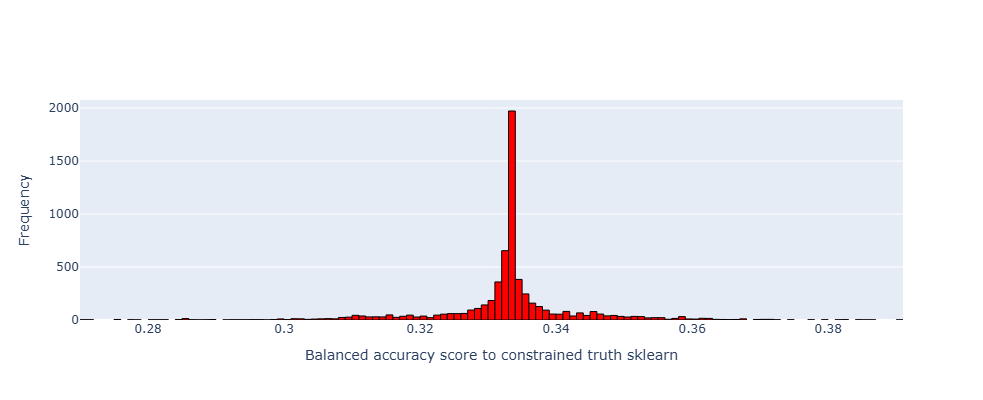

In [30]:
early_accuracies_df = early_accuracies_df.sort_values(by='accuracy',ascending=False)
print('the most accurate second constraint is:',(early_accuracies_df.index.to_list())[0],
      early_accuracies_df.iloc[0,0])
fig = go.Figure(data=[go.Histogram(x=values,
                                   marker=dict(color='red',
                                               line=dict(color='black', width=1)))])
fig.update_layout(width=800,height=400,xaxis_title='Balanced accuracy score to constrained truth sklearn',
                 yaxis_title='Frequency')
fig.show()

In [ ]:
early_model.reactions.get_by_id('G6Pter')

In [181]:
#pca of dataframe of solutions to see how they group compared to 'truth'
#might all just group separately tbf
#plot pca of non-binarised (so discrete flux values)
objectives_df

10FTHF5GLUtl  10FTHF5GLUtm  10FTHF6GLUtl  \
reactions                                                          
10FTHF5GLUtl            7.787222e-03      0.007787      0.000000   
10FTHF5GLUtm            0.000000e+00      0.007787      0.007086   
10FTHF6GLUtl            0.000000e+00      0.000000      0.007787   
10FTHF6GLUtm            0.000000e+00      0.000000      0.000000   
10FTHF7GLUtl            0.000000e+00      0.000000      0.000000   
...                              ...           ...           ...   
OST_complex             0.000000e+00      0.000000      0.000000   
Proteasome_degradation  0.000000e+00      0.000000      0.000000   
DM_igg[g]               1.509941e-07      0.000000      0.000000   
igg_lc                  3.019883e-07      0.000000      0.000000   
igg_formation           1.509941e-07      0.000000      0.000000   

                        10FTHF6GLUtm  10FTHF7GLUtl  10FTHF7GLUtm  10FTHFtl  \
reactions                                                                    
10FTHF5GLUtl                0.000000      0.000000      0.000000       0.0   
10FTHF5GLUtm                0.000000      0.000000      0.000000       0.0   
10FTHF6GLUtl                0.007787      0.000000      0.000000       0.0   
10FTHF6GLUtm                0.007787      0.007538      0.000000       0.0   
10FTHF7GLUtl                0.000000      0.007787      0.007787       0.0   
...                              ...           ...           ...       ...   
OST_complex                 0.000000      0.000000      0.000000       0.0   
Proteasome_degradation      0.000000      0.000000      0.000000       0.0   
DM_igg[g]                   0.000000      0.000000      0.000000       0.0   
igg_lc                      0.000000      0.000000      0.000000       0.0   
igg_formation               0.000000      0.000000      0.000000       0.0   

                        10FTHFtm  11DOCRTSLtm  11DOCRTSLtr  ...      SRPR  \
reactions                                                   ...             
10FTHF5GLUtl            0.007787     0.007787     0.007787  ...  0.000000   
10FTHF5GLUtm            0.007787     0.007787     0.007787  ...  0.000000   
10FTHF6GLUtl            0.000000     0.000000     0.000000  ...  0.000000   
10FTHF6GLUtm            0.000000     0.000000     0.000000  ...  0.000000   
10FTHF7GLUtl            0.000000     0.000000     0.000000  ...  0.000000   
...                          ...          ...          ...  ...       ...   
OST_complex             0.000030     0.000026     0.000026  ...  0.000059   
Proteasome_degradation  0.000000     0.000000     0.000000  ...  0.000000   
DM_igg[g]               0.000000     0.000000     0.000000  ...  0.000000   
igg_lc                  0.000000     0.000000     0.000000  ...  0.000000   
igg_formation           0.000000     0.000000     0.000000  ...  0.000000   

                             SPC  SPC_degradation  co_TRANSLOC_7  \
reactions                                                          
10FTHF5GLUtl            0.000000         0.000000   0.000000e+00   
10FTHF5GLUtm            0.000000         0.000000   0.000000e+00   
10FTHF6GLUtl            0.000000         0.000000   0.000000e+00   
10FTHF6GLUtm            0.000000         0.000000   0.000000e+00   
10FTHF7GLUtl            0.000000         0.000000   0.000000e+00   
...                          ...              ...            ...   
OST_complex             0.000056         0.000056   5.852206e-05   
Proteasome_degradation  0.000000         0.000000   6.123243e-21   
DM_igg[g]               0.000000         0.000000   0.000000e+00   
igg_lc                  0.000000         0.000000   0.000000e+00   
igg_formation           0.000000         0.000000   0.000000e+00   

                        TRAP_degradation  OST_complex  Proteasome_degradation  \
reactions                                                                       
10FTHF5GLUtl                    0.000000     0.000000                0.0000

In [184]:
data = objectives_df
all_zeros = [0]*6337
len(all_zeros)
data = data.transpose()
zero_rows = []
for n in range(len(data)):
    if (data.iloc[n,0:]).to_list() == all_zeros:
        zero_rows.append(n)
print('proportion of reactions with zero flux across all samples:',(len(zero_rows)/len(data)))
#this would usually give me a proportion greater than zero but because I have optimised each reaction in turn 0.0 makes sense

proportion of reactions with zero flux across all samples: 0.0


In [185]:
data = data.transpose()
X = data
pca = PCA(n_components=8)
pca.fit(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.5430695  0.0465551  0.03587673 0.02703696 0.02013747 0.01893071
 0.01803163 0.01408271]
[148814.27211209  43571.2986847   38249.28158842  33204.41520196
  28656.24655744  27784.35905104  27116.54541751  23964.03433861]


In [186]:
labels = data.index # The labels give the sample-type for each cell 
N, D = data.shape
data_unlabelled = data.copy() # this dataframe doesn't have labels in an extra column and is used in the PCA function
df['label'] = labels 

W, scores, fracs = visualisation.do_pca(data_unlabelled, n_components=8)
scores = scores/abs(scores).max().max()
scores['label'] = labels

In [187]:
scores

PC1       PC2       PC3       PC4       PC5  \
reactions                                                                  
10FTHF5GLUtl           -0.001452 -0.000028 -0.000652  0.000043 -0.000308   
10FTHF5GLUtm           -0.001492 -0.000047 -0.000647  0.000079 -0.000298   
10FTHF6GLUtl           -0.001432  0.000163 -0.000712 -0.000157 -0.000414   
10FTHF6GLUtm           -0.001623 -0.000017 -0.000657  0.000082 -0.000310   
10FTHF7GLUtl           -0.001564  0.000014 -0.000665  0.000054 -0.000303   
...                          ...       ...       ...       ...       ...   
OST_complex            -0.001634 -0.000023 -0.000655  0.000103 -0.000319   
Proteasome_degradation -0.001645 -0.000022 -0.000656  0.000096 -0.000319   
DM_igg[g]              -0.001643 -0.000023 -0.000655  0.000097 -0.000319   
igg_lc                 -0.001641 -0.000024 -0.000655  0.000097 -0.000319   
igg_formation          -0.001643 -0.000023 -0.000655  0.000097 -0.000319   

                             PC6       PC7           PC8  \
reactions                                                  
10FTHF5GLUtl           -0.000181 -0.000082  8.708627e-07   
10FTHF5GLUtm           -0.000190 -0.000075 -1.439890e-05   
10FTHF6GLUtl           -0.000156 -0.000005 -9.555165e-05   
10FTHF6GLUtm           -0.000214 -0.000017 -1.601260e-04   
10FTHF7GLUtl           -0.000203 -0.000020 -1.269972e-04   
...                          ...       ...           ...   
OST_complex            -0.000223 -0.000010 -1.877211e-04   
Proteasome_degradation -0.000223 -0.000009 -1.901226e-04   
DM_igg[g]              -0.000224 -0.000009 -1.905677e-04   
igg_lc                 -0.000224 -0.000009 -1.910127e-04   
igg_formation          -0.000224 -0.000009 -1.905677e-04   

                                         label  
reactions                                       
10FTHF5GLUtl                      10FTHF5GLUtl  
10FTHF5GLUtm                      10FTHF5GLUtm  
10FTHF6GLUtl                      10FTHF6GLUtl  
10FTHF6GLUtm                      10FTHF6GLUtm  
10FTHF7GLUtl                      10FTHF7GLUtl  
...                                        ...  
OST_complex                        OST_complex  
Proteasome_degradation  Proteasome_degradation  
DM_igg[g]                            DM_igg[g]  
igg_lc                                  igg_lc  
igg_formation                    igg_formation  

[6337 rows x 9 columns]

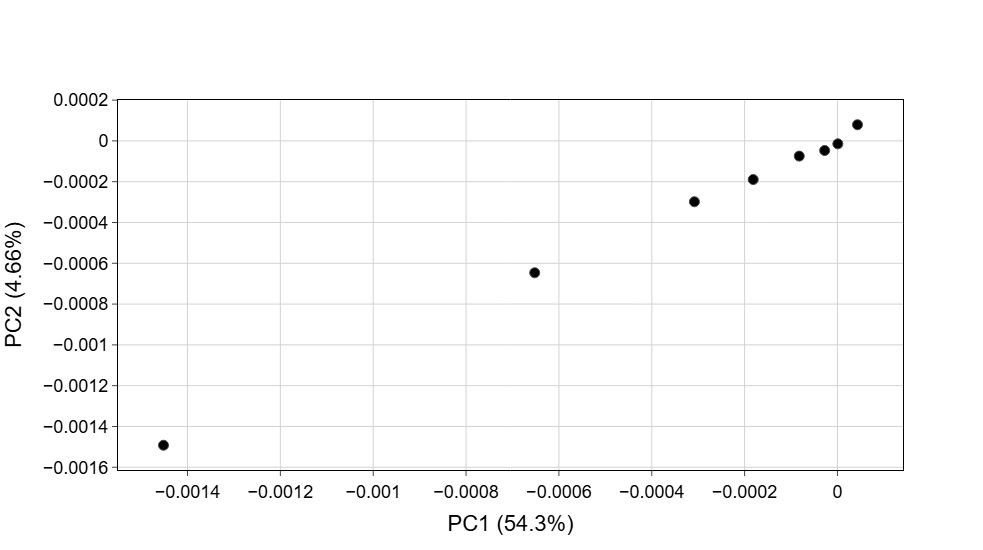

In [188]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=scores.iloc[0,:],
    y=scores.iloc[1,:],
    mode="markers", marker_line_width=1, marker_size=10,
    marker=dict(color="black", size=10)))

fig.update_layout(xaxis_title='PC1 (54.3%)', yaxis_title='PC2 (4.66%)',width=550,height=550,
                 font_family='Arial',font=dict(size=18),font_color='black',plot_bgcolor='white')
fig.update_xaxes(showgrid=True, gridwidth=1,
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey'
)
fig.update_yaxes(showgrid=True, gridwidth=1,
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey'
)

fig.show()
#this PCA looks weird IDK why it is linear and IDK why the PC values are so small when the percentages seemed normal

In [196]:
reaction = []
subsystem = []
for n in range(len(early_accuracies_df)):
    subsystem.append(early_model.reactions.get_by_id((early_accuracies_df.index.to_list())[n]).subsystem)
    reaction.append(early_model.reactions.get_by_id((early_accuracies_df.index.to_list())[n]).reaction)
early_accuracies_df['reaction'] = reaction
early_accuracies_df['subsystem'] = subsystem

In [198]:
early_accuracies_df.to_csv('early_accuracies_df_annotated.csv')

In [205]:
early_accuracies_df

accuracy                                           reaction  \
reaction                                                                 
G6Pter     0.390909                                  g6p[c] <=> g6p[r]   
PPIPItr    0.386629                  pi[r] + ppi[c] <=> pi[c] + ppi[r]   
FADtx      0.385031                                  fad[c] <=> fad[x]   
LTHSTRLy   0.384942  lthstrl[r] + nadp[r] <=> chlstol[r] + h[r] + n...   
AAPAOC15   0.384120        ala_L[e] + phe_L[c] <=> ala_L[c] + phe_L[e]   
...             ...                                                ...   
H2Otg      0.275129                                  h2o[c] <=> h2o[g]   
H2O2tp     0.271936                                h2o2[c] <=> h2o2[x]   
AKGICITtp  0.271274              akg[c] + icit[x] <=> akg[x] + icit[c]   
NDP7g      0.270809          h2o[g] + udp[g] --> h[g] + pi[g] + ump[g]   
PItg       0.270630                                    pi[g] --> pi[c]   

                                         subsystem  
reaction                                            
G6Pter                                   Transport  
PPIPItr                                  Transport  
FADtx                                    Transport  
LTHSTRLy   Bile, eicosanoid and steroid metabolism  
AAPAOC15                                 Transport  
...                                            ...  
H2Otg                                    Transport  
H2O2tp                                   Transport  
AKGICITtp                                Transport  
NDP7g                        Nucelotide metabolism  
PItg                                     Transport  

[6337 rows x 3 columns]

In [208]:
#average the accuracy scores per subsystem and see if one stands out
subsystems = early_accuracies_df['subsystem'].to_list()
subsystems = set(subsystems)
subsystem_accuracies = {}
for s in subsystems:
    s_list = []
    for n in range(len(early_accuracies_df)):
        if early_accuracies_df.iloc[n,2] == s:
            s_list.append(early_accuracies_df.iloc[n,0])
    subsystem_accuracies[s] = s_list
subsystem_accuracies

{'Other carbon metabolism': [0.37131001357068266,
  0.363115767966288,
  0.3563225965927653,
  0.35411780721358793,
  0.3538535027871199,
  0.35227447674539164,
  0.34927535471510196,
  0.3484706540706506,
  0.34779832999811905,
  0.34675822539324413,
  0.3451427641935519,
  0.3441026739357595,
  0.3429166293240557,
  0.34246973155819654,
  0.34245761767334165,
  0.3417192178652384,
  0.3412968813150739,
  0.3404186409890897,
  0.3384866173519349,
  0.3371773273441982,
  0.33715265827802154,
  0.3367183696187251,
  0.33645444217421655,
  0.33645444217421655,
  0.3360731214591323,
  0.3360731214591323,
  0.33554969388186756,
  0.33532532480675337,
  0.33504210845198573,
  0.33489051421049204,
  0.3346938775510204,
  0.3346255161767968,
  0.3343681072549889,
  0.3343064796097026,
  0.33427875659387274,
  0.33412021638556694,
  0.33386287474662835,
  0.33372455947202956,
  0.33371465404841755,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333

In [214]:
averages_dict = {}
for k,v in subsystem_accuracies.items():
    averages_dict[k] = statistics.mean(v)
averages_df = pd.DataFrame()
averages_df['subsystem'] = averages_dict.keys()
averages_df['mean_accuracy'] = averages_dict.values()
averages_df = averages_df.sort_values('mean_accuracy',ascending=False)
averages_df = averages_df.set_index('subsystem')
averages_df

mean_accuracy
subsystem                                                        
Fatty acid metabolism                                    0.336657
Bile, eicosanoid and steroid metabolism                  0.335986
Unassigned                                               0.335424
Miscellaneous                                            0.334533
Central carbon and energy metabolism                     0.334295
Amino acid metabolism                                    0.334152
Glycerophospholipid, sphingolipid and inositol ...       0.334081
Nucelotide metabolism                                    0.333842
Vitamin and cofactor metabolism                          0.333345
Xenobiotics metabolism                                   0.333260
Biomass synthesis                                        0.333127
Exchange/demand/sink reaction                            0.333107
Transport                                                0.331766
Glycan and glycosaminoglycan metabolism                  0.331293
Other carbon metabolism                                  0.327656
                                                         0.321751

In [222]:
ranges_dict = {}
for k,v in subsystem_accuracies.items():
    ranges_dict[k] = [min(v),max(v)]
ranges_df = pd.DataFrame()
ranges_df['subsystem'] = ranges_dict.keys()
mins = []
maxs = []
range_value = []
for k,v in ranges_dict.items():
    mins.append(v[0])
    maxs.append(v[1])
    range_value.append(v[1]-v[0])
ranges_df['minimum'] = mins
ranges_df['maximum'] = maxs
ranges_df['range'] = range_value
ranges_df = ranges_df.sort_values('range',ascending=True)
ranges_df

subsystem   minimum   maximum  \
9                              Xenobiotics metabolism  0.331372  0.335075   
10                                  Biomass synthesis  0.329181  0.336157   
2                                                      0.309665  0.336344   
7                                          Unassigned  0.324122  0.365871   
5                               Fatty acid metabolism  0.317714  0.371313   
8   Glycerophospholipid, sphingolipid and inositol...  0.302419  0.359584   
11            Glycan and glycosaminoglycan metabolism  0.285517  0.353183   
13            Bile, eicosanoid and steroid metabolism  0.305204  0.384942   
14                              Amino acid metabolism  0.299408  0.381770   
3                     Vitamin and cofactor metabolism  0.284699  0.371310   
6                       Exchange/demand/sink reaction  0.287541  0.374168   
12                                      Miscellaneous  0.281197  0.371143   
1                               Nucelotide metabolism  0.270809  0.362190   
0                             Other carbon metabolism  0.275184  0.371310   
4                Central carbon and energy metabolism  0.275730  0.382466   
15                                          Transport  0.270630  0.390909   

       range  
9   0.003704  
10  0.006976  
2   0.026679  
7   0.041749  
5   0.053599  
8   0.057164  
11  0.067666  
13  0.079738  
14  0.082362  
3   0.086611  
6   0.086628  
12  0.089946  
1   0.091381  
0   0.096126  
4   0.106736  
15  0.120278

In [ ]:
#run same process on late model and stationary model (separate notebooks)

#### Try a double optimisation and do same approach to assess accuracy

In [228]:
model.reactions.get_by_id('biomass_cho_prod')

<Reaction biomass_cho_prod at 0x2e2461de3d0>

In [230]:
objectives_df_2 = pd.DataFrame()
objectives_df_2['reactions'] = reactions
objectives_df_2 = objectives_df_2.set_index('reactions')

early_test = early_model.copy()
model = early_test
for r in model.reactions:
    with model:
        model.objective = {model.reactions.biomass_cho_prod:0.5,model.reactions.get_by_id(r.id):0.5}
        solution = model.optimize()
        objectives_df_2[r.id] = (solution.fluxes).to_list()
        if early_truth != solution:
            print(r.id,'optimisation changes flux distribution')
        if early_truth == solution:
            print(r.id,'optimisation does NOT change flux distribution')

10FTHF5GLUtl optimisation changes flux distribution
10FTHF5GLUtm optimisation changes flux distribution
10FTHF6GLUtl optimisation changes flux distribution
10FTHF6GLUtm optimisation changes flux distribution
10FTHF7GLUtl optimisation changes flux distribution
10FTHF7GLUtm optimisation changes flux distribution
10FTHFtl optimisation changes flux distribution
10FTHFtm optimisation changes flux distribution
11DOCRTSLtm optimisation changes flux distribution
11DOCRTSLtr optimisation changes flux distribution
11DOCRTSTRNtm optimisation changes flux distribution
11DOCRTSTRNtr optimisation changes flux distribution
13DAMPPOX optimisation changes flux distribution
1a_24_25VITD2Hm optimisation changes flux distribution
1a_24_25VITD3Hm optimisation changes flux distribution
1a_25VITD2Hm optimisation changes flux distribution
1a_25VITD3Hm optimisation changes flux distribution
1a25DHVITD3TRn optimisation changes flux distribution
1MNCAMti optimisation changes flux distribution
1PPDCRp optimisatio

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



4MOPt2im optimisation changes flux distribution
4MOPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



4MPTNLte optimisation changes flux distribution
4MPTNLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



4MTOLBUTAMIDEte optimisation changes flux distribution
4NPHSFte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

4NPHSULT optimisation changes flux distribution
4NPHte optimisation changes flux distribution
4OHPROIMINOtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



4PYRDX optimisation changes flux distribution
5ADTSTSTERONEGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5ADTSTSTERONEGLCtr optimisation changes flux distribution
5ADTSTSTERONESte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5ADTSTSTERONESULT optimisation changes flux distribution
5ADTSTSTERONEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5ADTSTSTERONEtr optimisation changes flux distribution
5AOPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

5FTHFt2 optimisation changes flux distribution
5HLTDL optimisation changes flux distribution
5HOMEPRAZOLEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5HOXINDACTO2OX optimisation changes flux distribution
5HOXINDACTOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

5HOXINOXDA optimisation changes flux distribution
5HTRPDOX optimisation changes flux distribution
5HTRPVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5HXKYNDCL optimisation changes flux distribution
5HXKYNOXDA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5MTAte optimisation changes flux distribution
5MTHFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

5MTHFt2 optimisation changes flux distribution
5OXPROt optimisation changes flux distribution
5THFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5THFtm optimisation changes flux distribution
6DHFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

6DHFtm optimisation changes flux distribution
6HTSTSTERONEte optimisation changes flux distribution
6HTSTSTERONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



6THFtl optimisation changes flux distribution
6THFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

7DHCHSTEROLtr optimisation changes flux distribution
7DHFtl optimisation changes flux distribution
7DHFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



7THFtl optimisation changes flux distribution
7THFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



A_MANASE optimisation changes flux distribution
A_MANASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



A4GALTg optimisation changes flux distribution
A4GNT1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



A4GNT2g optimisation changes flux distribution
AACOAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AACTOOR optimisation changes flux distribution
AACTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THP2CDH optimisation changes flux distribution
AASAD3 optimisation changes flux distribution
AASAD3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AATAi optimisation changes flux distribution
ABO1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABO2g optimisation changes flux distribution
ABO3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABO4g optimisation changes flux distribution
ABO5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABO6g optimisation changes flux distribution
ABO7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABO8g optimisation changes flux distribution
ABO9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABTArm optimisation changes flux distribution
ABTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABTti optimisation changes flux distribution
ABUTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ABUTt2r optimisation changes flux distribution
ABUTt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT10m optimisation changes flux distribution
ACACT1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT1rm optimisation changes flux distribution
ACACT1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACt2 optimisation changes flux distribution
ACACt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACtx optimisation changes flux distribution
ACALDt optimisation changes flux distribution
ACALDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACALDtx optimisation changes flux distribution
ACCOAC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACCOACm optimisation changes flux distribution
ACCOAgt optimisation changes flux distribution
ACCOALm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACCOAtn optimisation changes flux distribution
ACCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACETONEt2 optimisation changes flux distribution
ACETONEt2m optimisation changes flux distribution
ACGAGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGAGBSIDEtl optimisation changes flux distribution
ACGALFUCGALACGALFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGALFUCGALACGALFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACGALFUCGALACGALFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGALFUCGALACGALFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACGALK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACGALK2 optimisation changes flux distribution
ACGALtly optimisation changes flux distribution
ACGAM2E optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGAM6PSi optimisation changes flux distribution
ACGAMK optimisation changes flux distribution
ACGAMPM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACGAMtly optimisation changes flux distribution
ACGBGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGBGBSIDEtl optimisation changes flux distribution
ACGPID optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGSm optimisation changes flux distribution
ACHEe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACHtn optimisation changes flux distribution
ACHVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACITL optimisation changes flux distribution
ACN13ACNGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACN13ACNGALGBSIDEtg optimisation changes flux distribution
ACN23ACNGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACN23ACNGALGBSIDEtg optimisation changes flux distribution
ACNACNGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACNACNGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACNACNGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACNACNGALGBSIDEtg optimisation changes flux distribution
ACNAM9PL optimisation changes flux distribution
ACNAM9PL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACNAMlt optimisation changes flux distribution
ACNAMPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACNAMtn optimisation changes flux distribution
ACNGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACNGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
ACNMLr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD10m optimisation changes flux distribution
ACOAD1fm optimisation changes flux distribution
ACOAD8m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD9m optimisation changes flux distribution
ACOAHi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACODA optimisation changes flux distribution
ACOX22x optimisation changes flux distribution
ACOX2x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACP1_FMN optimisation changes flux distribution
ACRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACSm optimisation changes flux distribution
ACt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACt2r optimisation changes flux distribution
ACtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACTLMO optimisation changes flux distribution
ACTNMO optimisation changes flux distribution
ACYP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADA optimisation changes flux distribution
ADAe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADCim optimisation changes flux distribution
ADEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADEtl optimisation changes flux distribution
ADHAPtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADK1 optimisation changes flux distribution
ADK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADK3 optimisation changes flux distribution
ADK3m optimisation changes flux distribution
ADKd optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADMDC optimisation changes flux distribution
ADNCYC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADNK1 optimisation changes flux distribution
ADNK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADNK3 optimisation changes flux distribution
ADNK4 optimisation changes flux distribution
ADNt optimisation changes flux distribution
ADNt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADNt5 optimisation changes flux distribution
ADNtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADNtm optimisation changes flux distribution
ADPACDAc optimisation changes flux distribution
ADPACTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADPCOACROT optimisation changes flux distribution
ADPCOAPTE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADPGK optimisation changes flux distribution
ADPGLC optimisation changes flux distribution
ADPMAN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADPRDP optimisation changes flux distribution
ADPRDPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADPRIBt optimisation changes flux distribution
ADPT optimisation changes flux distribution
ADPtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADRNCOAtx optimisation changes flux distribution
ADRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADRNCPT2 optimisation changes flux distribution
ADRNCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADRNLPVESSEC optimisation changes flux distribution
ADRNt optimisation changes flux distribution
ADSK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADSKn optimisation changes flux distribution
ADSL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADSL2 optimisation changes flux distribution
ADSS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AFLATOXINte optimisation changes flux distribution
AG13T10g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AG13T11g optimisation changes flux distribution
AG13T12g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AG13T13g optimisation changes flux distribution
AG13T14g optimisation changes flux distribution
AG13T15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AG13T16g optimisation changes flux distribution
AG13T17g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AG13T18g optimisation changes flux distribution
AG13T1g optimisation changes flux distribution
AG13T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AG13T3g optimisation changes flux distribution
AG13T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AG13T5g optimisation changes flux distribution
AG13T6g optimisation changes flux distribution
AG13T7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AG13T8g optimisation changes flux distribution
AG13T9g optimisation changes flux distribution
AGDC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGLPC optimisation changes flux distribution
AGLPED optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGLPET optimisation changes flux distribution
AGLPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AGLPR optimisation changes flux distribution
AGLPT optimisation changes flux distribution
AGMTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AGPAT1 optimisation changes flux distribution
AGPAT1m optimisation changes flux distribution
AGPex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGPRim optimisation changes flux distribution
AGPSx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGTim optimisation changes flux distribution
AGTix optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGXT2L2 optimisation changes flux distribution
AHANDROSTANGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AHANDROSTANGLCtr optimisation changes flux distribution
AHC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AHCYStd optimisation changes flux distribution
AHCYSte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AHCYStn optimisation changes flux distribution
AHCYStr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AHEXASE2ly optimisation changes flux distribution
AHEXASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AICART optimisation changes flux distribution
AICARte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AIRCr optimisation changes flux distribution
AK2LGCHOLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AKGMALtm optimisation changes flux distribution
AKGt4_3 optimisation changes flux distribution
AKGtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKR1C1 optimisation changes flux distribution
AKR1C41 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AKR1C42 optimisation changes flux distribution
AKR1D optimisation changes flux distribution
AKR1D2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALA_DTDe optimisation changes flux distribution
ALAALACNc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALAALAPEPT1tc optimisation changes flux distribution
ALAASNNaEx optimisation changes flux distribution
ALAATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALACYSNaEx optimisation changes flux distribution
ALADGLNexR optimisation changes flux distribution
ALADGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALAGLNexR optimisation changes flux distribution
ALAGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALAGLYexR optimisation changes flux distribution
ALASERNaEx optimisation changes flux distribution
ALASm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALAt2r optimisation changes flux distribution
ALAt2rL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALAt4 optimisation changes flux distribution
ALATA_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALATHRNaEx optimisation changes flux distribution
ALAtN1 optimisation changes flux distribution
ALAyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALCD1 optimisation changes flux distribution
ALCD21_D optimisation changes flux distribution
ALCD21_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALCD22_D optimisation changes flux distribution
ALCD22_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALCD2if optimisation changes flux distribution
ALCD2yf optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALDD19x optimisation changes flux distribution
ALDD19y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALDD20x optimisation changes flux distribution
ALDD20xm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALDD21 optimisation changes flux distribution
ALDD2x optimisation changes flux distribution
ALDD2xm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALDD2y optimisation changes flux distribution
ALDSTRNte optimisation changes flux distribution
ALDSTRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALKP optimisation changes flux distribution
ALOX12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALOX12R optimisation changes flux distribution
ALOX15 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ALOX5 optimisation changes flux distribution
ALOX52 optimisation changes flux distribution
ALR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALR2 optimisation changes flux distribution
ALR3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AM6SAD optimisation changes flux distribution
AMACR2p optimisation changes flux distribution
AMACRp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AMANK optimisation changes flux distribution
AMCOXO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AMETr optimisation changes flux distribution
AMETt2m optimisation changes flux distribution
AMETtd optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AMETtn optimisation changes flux distribution
AMPDA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AMPTASECG optimisation changes flux distribution
AMPTASECGe optimisation changes flux distribution
AMPtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AMPtr optimisation changes flux distribution
AMY1e optimisation changes flux distribution
AMY2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ANDRSTRNGLCte optimisation changes flux distribution
ANDRSTRNGLCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ANDRSTRNte optimisation changes flux distribution
ANDRSTRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ANTHte optimisation changes flux distribution
ANTIPYRENEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AOBUTDsm optimisation changes flux distribution
AP4AH1 optimisation changes flux distribution
APAT2rm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

APNNOXte optimisation changes flux distribution
APOC_LYS_BTNP optimisation changes flux distribution
APOC_LYS_BTNPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



APOCF optimisation changes flux distribution
APOCFm optimisation changes flux distribution
APPNNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

APRGSTRNte optimisation changes flux distribution
APRTO2 optimisation changes flux distribution
AQCOBALt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ARAB_Lt optimisation changes flux distribution
ARABR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARACHCOAtcx optimisation changes flux distribution
ARACHCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ARACHCPT2 optimisation changes flux distribution
ARACHCRNt optimisation changes flux distribution
ARACHDCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARACHDt2 optimisation changes flux distribution
ARACHDtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARACHFATPc optimisation changes flux distribution
ARACHt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARD1_cho optimisation changes flux distribution
ARGATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGDCm optimisation changes flux distribution
ARGLYSex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGN optimisation changes flux distribution
ARGNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ARGSL optimisation changes flux distribution
ARGSS optimisation changes flux distribution
ARGt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGt5r optimisation changes flux distribution
ARGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARS_cho optimisation changes flux distribution
ARSA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASAH1 optimisation changes flux distribution
ASCBOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASCBt optimisation changes flux distribution
ASCBt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ASCBt5 optimisation changes flux distribution
Asn_X_Ser/Thrtr optimisation changes flux distribution
ASNALANaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNATB0tc optimisation changes flux distribution
ASNCYSNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ASNGLNNaEx optimisation changes flux distribution
ASNN optimisation changes flux distribution
ASNNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNPHELAT2tc optimisation changes flux distribution
ASNS1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNSERNaEx optimisation changes flux distribution
ASNt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNTHRNaEx optimisation changes flux distribution
ASNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNtN1 optimisation changes flux distribution
ASP1DC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ASPCTr optimisation changes flux distribution
ASPDt6 optimisation changes flux distribution
ASPDTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPDxt optimisation changes flux distribution
ASPGLUm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPNATm optimisation changes flux distribution
ASPOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPPROASCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPt6 optimisation changes flux distribution
ASPTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPTAm optimisation changes flux distribution
ASPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATP1ter optimisation changes flux distribution
ATP2ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ATPasel optimisation changes flux distribution
ATPH1e optimisation changes flux distribution
ATPH2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATPS4m optimisation changes flux distribution
ATPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATPtn optimisation changes flux distribution
ATPtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AVITE1t optimisation changes flux distribution
B_MANNASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GALT3g optimisation changes flux distribution
B3GALT41g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

B3GALT42g optimisation changes flux distribution
B3GALT43g optimisation changes flux distribution
B3GALT44g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GALT5g optimisation changes flux distribution
B3GALTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

B3GNT11g optimisation changes flux distribution
B3GNT12g optimisation changes flux distribution
B3GNT310g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT311g optimisation changes flux distribution
B3GNT312g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

B3GNT313g optimisation changes flux distribution
B3GNT314g optimisation changes flux distribution
B3GNT315g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT34g optimisation changes flux distribution
B3GNT35g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

B3GNT37g optimisation changes flux distribution
B3GNT38g optimisation changes flux distribution
B3GNT39g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT51g optimisation changes flux distribution
CCGTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CCTTx optimisation changes flux distribution
DCCGTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCCTTx optimisation changes flux distribution
BACCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BACCLm optimisation changes flux distribution
BALABETAtc optimisation changes flux distribution
BALAPAT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BALAtmr optimisation changes flux distribution
BALAVECSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BAMPPALDOX optimisation changes flux distribution
BBHOX optimisation changes flux distribution
BCDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BCRNe optimisation changes flux distribution
BDG2HCGHD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BDHm optimisation changes flux distribution
BDMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BETALDHx optimisation changes flux distribution
BETALDHxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BHBt optimisation changes flux distribution
BHBtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BHMT optimisation changes flux distribution
BILDGLCURt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BILDGLCURte optimisation changes flux distribution
BILDGLCURtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BILGLCURt optimisation changes flux distribution
BILGLCURte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BILIRED optimisation changes flux distribution
BILIRED2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BILIRUBt2 optimisation changes flux distribution
BILIRUBtr optimisation changes flux distribution
BIOCYTtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BMTer optimisation changes flux distribution
BPNT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BPNT2 optimisation changes flux distribution
BTND1 optimisation changes flux distribution
BTND1n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BTNDe optimisation changes flux distribution
BTNDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BTNPL optimisation changes flux distribution
BTNPLm optimisation changes flux distribution
BTNt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BTNt2m optimisation changes flux distribution
BTNt3 optimisation changes flux distribution
BTNt3i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BTNTe optimisation changes flux distribution
BTNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BUP2 optimisation changes flux distribution
BUTt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BUTt2r optimisation changes flux distribution
BZt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BZtr optimisation changes flux distribution
C10DCc optimisation changes flux distribution
C10DCCACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C10DCe optimisation changes flux distribution
C10OHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C12OHc optimisation changes flux distribution
C14OHc optimisation changes flux distribution
C14STRr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C160CPT1 optimisation changes flux distribution
C160CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C160CRNt optimisation changes flux distribution
C161CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C161CPT12 optimisation changes flux distribution
C161CPT2 optimisation changes flux distribution
C161CPT22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C161CRN2t optimisation changes flux distribution
C161CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PMTCOAtxc optimisation changes flux distribution
C180CPT1 optimisation changes flux distribution
C180CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C180CRNt optimisation changes flux distribution
C181CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C181CPT2 optimisation changes flux distribution
C181CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C204CPT1 optimisation changes flux distribution
C204CPT2 optimisation changes flux distribution
C204CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CRVNCOAtx optimisation changes flux distribution
C226CPT1 optimisation changes flux distribution
C226CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C226CRNt optimisation changes flux distribution
C2tcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C30CPT1 optimisation changes flux distribution
C3STDH1Pr optimisation changes flux distribution
C3STDH1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C3STKR2r optimisation changes flux distribution
C40CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C4CRNCPT2 optimisation changes flux distribution
C4CRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C4DCCACT optimisation changes flux distribution
C4DCe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C4OHc optimisation changes flux distribution
C4STMO1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C4STMO2Pr optimisation changes flux distribution
C4STMO2r optimisation changes flux distribution
C4tmc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C50CPT1 optimisation changes flux distribution
C51CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C6DCc optimisation changes flux distribution
C6DCCACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C6DCe optimisation changes flux distribution
C80CPT1 optimisation changes flux distribution
C81_5ZCPT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



C81_5ZCPTx optimisation changes flux distribution
C81CRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C81CRNtx optimisation changes flux distribution
C8CRNe optimisation changes flux distribution
C8CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

C8DCc optimisation changes flux distribution
C8DCe optimisation changes flux distribution
C9BRxtc optimisation changes flux distribution
CAATPaser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CAATPS optimisation changes flux distribution
CACNAO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACNAO2 optimisation changes flux distribution
CAMPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CARhPTtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CARNS1 optimisation changes flux distribution
CAROtr optimisation changes flux distribution
CARPEPT1tc optimisation changes flux distribution
CARVEOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CAT optimisation changes flux distribution
CAT2p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CAt7r optimisation changes flux distribution
CATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CATp optimisation changes flux distribution
CBASPte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CBL2OR optimisation changes flux distribution
CBL2tm optimisation changes flux distribution
CBL1tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ADOCBLtm optimisation changes flux distribution
CBLATm optimisation changes flux distribution
CBLTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CBPPer optimisation changes flux distribution
CBPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CBPSam optimisation changes flux distribution
CBPter optimisation changes flux distribution
CBR1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CBR2 optimisation changes flux distribution
CCA_D3t optimisation changes flux distribution
CCA_D3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CDIPTr optimisation changes flux distribution
CDPDAGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CDS optimisation changes flux distribution
CDSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CEPTC optimisation changes flux distribution
CEPTE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CERK optimisation changes flux distribution
CERT1gt optimisation changes flux distribution
CERT1rt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CERT2gt optimisation changes flux distribution
CERT2rt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CGLYt3_2_ optimisation changes flux distribution
CGMPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CH25H optimisation changes flux distribution
CHAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHATn optimisation changes flux distribution
CHLP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHLPCTD optimisation changes flux distribution
CHLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLATEt optimisation changes flux distribution
CHOLATEt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLATEt3 optimisation changes flux distribution
CHOLD2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLESACATc optimisation changes flux distribution
CHOLESTle optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLESTTDe optimisation changes flux distribution
CHOLK optimisation changes flux distribution
CHOLPtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLPtl optimisation changes flux distribution
CHOLt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLtg optimisation changes flux distribution
CHOLtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLtr optimisation changes flux distribution
CHOLtu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHSTEROLSULT optimisation changes flux distribution
CHSTEROLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHSTEROLt1 optimisation changes flux distribution
CHSTEROLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHSTEROLt3 optimisation changes flux distribution
CHSTEROLtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHSTEROLtrc optimisation changes flux distribution
CHTNASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHTNASEe optimisation changes flux distribution
CITMCOAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITMCOALm optimisation changes flux distribution
CITRt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITRtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CITt4_2 optimisation changes flux distribution
CITt4_3 optimisation changes flux distribution
CITt4_4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITtam optimisation changes flux distribution
CITtbm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CK optimisation changes flux distribution
CKc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CLFORtex optimisation changes flux distribution
CLFORtex2 optimisation changes flux distribution
CLHCO3tex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLHCOtex optimisation changes flux distribution
CLI2tex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLOHtex2 optimisation changes flux distribution
CLOXAtex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLPNDCOAtbc optimisation changes flux distribution
CLPNDCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLPNDCPT2 optimisation changes flux distribution
CLPNDCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLPNDt optimisation changes flux distribution
CLS_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CMPACNAtg optimisation changes flux distribution
CMPACNAtn optimisation changes flux distribution
CMPSAS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CMPSASn optimisation changes flux distribution
CO2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CO2ter optimisation changes flux distribution
CO2tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CO2tm optimisation changes flux distribution
CO2tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

COAtg optimisation changes flux distribution
COAtl optimisation changes flux distribution
COAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

COAtn optimisation changes flux distribution
COAtp optimisation changes flux distribution
COAtr optimisation changes flux distribution
COKECBESr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



COQ3m optimisation changes flux distribution
COQ5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

COQ6m optimisation changes flux distribution
COQ7m optimisation changes flux distribution
Coqe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CORE2GTg optimisation changes flux distribution
CORE3GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CORE4GTg optimisation changes flux distribution
CORE5GTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CORE6GTg optimisation changes flux distribution
CORE7GTg optimisation changes flux distribution
CORE8GTg optimisation changes flux distribution
COt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

COUCOAFm optimisation changes flux distribution
COUMARINte optimisation changes flux distribution
CPPPGO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CREATt4_2_r optimisation changes flux distribution
CREATtmdiffir optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRMPte optimisation changes flux distribution
CRNCAR3tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRNCARtp optimisation changes flux distribution
CRNrtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRNt optimisation changes flux distribution
CRNtHa optimisation changes flux distribution
CRNtim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRNtuNa optimisation changes flux distribution
CRTNsyn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRTSLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRTSLtm optimisation changes flux distribution
CRTSLtr optimisation changes flux distribution
CRTSTRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRTSTRNtm optimisation changes flux distribution
CRVNCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSAPASEly optimisation changes flux distribution
CSBPASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSCPASEly optimisation changes flux distribution
CSDPASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSEPASEly optimisation changes flux distribution
CSm optimisation changes flux distribution
CSNAT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CSNAT2x optimisation changes flux distribution
CSNAT3x optimisation changes flux distribution
CSNATer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CSNATm optimisation changes flux distribution
CSNATp optimisation changes flux distribution
CSNATr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSND optimisation changes flux distribution
CSNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CSPG_At optimisation changes flux distribution
CSPG_Atly optimisation changes flux distribution
CSPG_Bt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSPG_Btly optimisation changes flux distribution
CSPG_Ct optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CSPG_Ctly optimisation changes flux distribution
CSPG_Dt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CSPG_Dtly optimisation changes flux distribution
CSPG_Et optimisation changes flux distribution
CSPG_Etly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CTPS2 optimisation changes flux distribution
CTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYANSTm optimisation changes flux distribution
CYANt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYANtm optimisation changes flux distribution
CYOOm2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYOOm3 optimisation changes flux distribution
CYOR_u10m optimisation changes flux distribution
CYP2R1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYSALANaEx optimisation changes flux distribution
CYSAMO optimisation changes flux distribution
CYSASNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSATB0tc optimisation changes flux distribution
CYSGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSGLTH optimisation changes flux distribution
CYSGLUexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYSGLYex optimisation changes flux distribution
CYSLYSL optimisation changes flux distribution
CYSO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSPHELAT2tc optimisation changes flux distribution
CYSSERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSSNAT5tc optimisation changes flux distribution
CYSt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYSTA optimisation changes flux distribution
CYSTALArBATtc optimisation changes flux distribution
CYSTAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYStec optimisation changes flux distribution
CYSTGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSTGLUex optimisation changes flux distribution
CYSTHRNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSTLEUrBATtc optimisation changes flux distribution
CYSTS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSTSERex optimisation changes flux distribution
CYTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTDK1 optimisation changes flux distribution
CYTDK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYTDK2m optimisation changes flux distribution
CYTDn optimisation changes flux distribution
CYTDt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTDt4 optimisation changes flux distribution
CYTDt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTDtl optimisation changes flux distribution
CYTDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYTDtn optimisation changes flux distribution
CYTK1 optimisation changes flux distribution
CYTK10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK10n optimisation changes flux distribution
CYTK11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYTK11n optimisation changes flux distribution
CYTK12 optimisation changes flux distribution
CYTK12n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK13 optimisation changes flux distribution
CYTK13n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK14 optimisation changes flux distribution
CYTK14n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK1m optimisation changes flux distribution
CYTK1n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK2 optimisation changes flux distribution
CYTK2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK2n optimisation changes flux distribution
CYTK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK3n optimisation changes flux distribution
CYTK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK4n optimisation changes flux distribution
CYTK5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK5n optimisation changes flux distribution
CYTK6 optimisation changes flux distribution
CYTK6n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYTK7 optimisation changes flux distribution
CYTK7n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK8 optimisation changes flux distribution
CYTK8n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYTK9 optimisation changes flux distribution
CYTK9n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



D_3AIBt optimisation changes flux distribution
D_LACt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



D_LACtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



D3AIBTm optimisation changes flux distribution
DADA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DADAe optimisation changes flux distribution
DADK1 optimisation changes flux distribution
DADK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DADNK optimisation changes flux distribution
DADNt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DAG_HSter optimisation changes flux distribution
DAGK_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DAGKn_cho optimisation changes flux distribution
DAGt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DALAOXx optimisation changes flux distribution
DALAt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DALAxt optimisation changes flux distribution
DARGOp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DASCBH optimisation changes flux distribution
DASCBR optimisation changes flux distribution
DASPO1p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DATPDP optimisation changes flux distribution
DATPDPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DATPDPn optimisation changes flux distribution
DATPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DATPtn optimisation changes flux distribution
DCATDc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DCATDr optimisation changes flux distribution
DCK1i optimisation changes flux distribution
DCK1mi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCK1ni optimisation changes flux distribution
DCK2ni optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCMPDA optimisation changes flux distribution
DCSPTN1COAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DCSPTN1COAtxc optimisation changes flux distribution
DCSPTN1CPT1 optimisation changes flux distribution
DCSPTN1CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCSPTN1CRNt optimisation changes flux distribution
DCSPTN1t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCT optimisation changes flux distribution
DCTPDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCTPDPm optimisation changes flux distribution
DCTPDPn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCTPtm optimisation changes flux distribution
DCTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCYTD optimisation changes flux distribution
DCYTDn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DCYTt optimisation changes flux distribution
DCYTtm optimisation changes flux distribution
DDCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDPGAm optimisation changes flux distribution
DEBRISOQUINEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECCRNe optimisation changes flux distribution
DECDPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DEDOLP1 optimisation changes flux distribution
DEDOLP2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DEDOLR optimisation changes flux distribution
DGAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DGCHOLte optimisation changes flux distribution
DGCHOLtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DGK1i optimisation changes flux distribution
DGK2mi optimisation changes flux distribution
DGNSKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DGSNt optimisation changes flux distribution
DGSNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DGTPtm optimisation changes flux distribution
DGTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DGULND optimisation changes flux distribution
DHAAt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHAK optimisation changes flux distribution
DHAPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHAPAx optimisation changes flux distribution
DHAPtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHCHOLESTANATEtm optimisation changes flux distribution
DHCR241r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHCR242r optimisation changes flux distribution
DHCR243r optimisation changes flux distribution
DHCR71r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHCR72r optimisation changes flux distribution
DHCRD1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHCRD2 optimisation changes flux distribution
DHDASCBtm optimisation changes flux distribution
DHDDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHDDS optimisation changes flux distribution
DHDPBMTm optimisation changes flux distribution
DHEASt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHEAStr optimisation changes flux distribution
DHEASULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHEAtr optimisation changes flux distribution
DHFR optimisation changes flux distribution
DHFtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHFtm optimisation changes flux distribution
DHORD9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHORTS optimisation changes flux distribution
DHPM1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHPM2 optimisation changes flux distribution
DHPR optimisation changes flux distribution
DHPR2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DIDP optimisation changes flux distribution
DIDPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DIGALSGALSIDEte optimisation changes flux distribution
DIGALSGALSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DIGALSIDEtg optimisation changes flux distribution
DIGALSIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DINt optimisation changes flux distribution
DITPtn optimisation changes flux distribution
DKMPPD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DLNLCGCPT1 optimisation changes flux distribution
DLNLCGCPT2 optimisation changes flux distribution
DLNLCGCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DLNLCGt optimisation changes flux distribution
DM_13_cis_oretn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_13_cis_retn[n] optimisation changes flux distribution
DM_56iqcrbxlt[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_Asn_X_Ser/Thr[ly] optimisation changes flux distribution
DM_atp[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_avite1[c] optimisation changes flux distribution
DM_core5[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_core7[g] optimisation changes flux distribution
DM_core8[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_datp[m] optimisation changes flux distribution
DM_datp[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_dctp[m] optimisation changes flux distribution
DM_dctp[n] optimisation changes flux distribution
DM_dem2emgacpail_prot_cho[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_dgpi_prot_cho[r] optimisation changes flux distribution
DM_dgtp[m] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_dgtp[n] optimisation changes flux distribution
DM_dsT_antigen[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_dttp[m] optimisation changes flux distribution
DM_dttp[n] optimisation changes flux distribution
DM_epo[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DM_ethamp[r] optimisation changes flux distribution
DM_gncore2[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_gpi_sig[er] optimisation changes flux distribution
DM_hretn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DM_kdn[c] optimisation changes flux distribution
DM_n5m2masn[g] optimisation changes flux distribution
DM_oretn[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_Ser/Thr[ly] optimisation changes flux distribution
DM_Ser_Gly/Ala_X_Gly[ly] optimisation changes flux distribution
DM_sprm[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_sTn_antigen[g] optimisation changes flux distribution
DM_T_antigen[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMANTIPYRINEte optimisation changes flux distribution
DMARG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMATTx optimisation changes flux distribution
DMGDHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMGtm optimisation changes flux distribution
DMHPTCRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMHPTCRNCPT2 optimisation changes flux distribution
DMHPTCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMHPTCRNte optimisation changes flux distribution
DMNONCOACRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMNONCRNCPT2 optimisation changes flux distribution
DMNONCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNADDP optimisation changes flux distribution
DNADtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNAMTn optimisation changes flux distribution
DNAMTSEn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt10m optimisation changes flux distribution
DNDPt11m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt12m optimisation changes flux distribution
DNDPt13m optimisation changes flux distribution
DNDPt14m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt15m optimisation changes flux distribution
DNDPt17m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt18m optimisation changes flux distribution
DNDPt19m optimisation changes flux distribution
DNDPt1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt20m optimisation changes flux distribution
DNDPt21m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt23m optimisation changes flux distribution
DNDPt25m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt28m optimisation changes flux distribution
DNDPt2m optimisation changes flux distribution
DNDPt30m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt31m optimisation changes flux distribution
DNDPt32m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt37m optimisation changes flux distribution
DNDPt38m optimisation changes flux distribution
DNDPt39m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt3m optimisation changes flux distribution
DNDPt40m optimisation changes flux distribution
DNDPt41m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt42m optimisation changes flux distribution
DNDPt43m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt44m optimisation changes flux distribution
DNDPt45m optimisation changes flux distribution
DNDPt46m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt47m optimisation changes flux distribution
DNDPt48m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNDPt49m optimisation changes flux distribution
DNDPt4m optimisation changes flux distribution
DNDPt50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt51m optimisation changes flux distribution
DNDPt52m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt53m optimisation changes flux distribution
DNDPt54m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt55m optimisation changes flux distribution
DNDPt56m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt57m optimisation changes flux distribution
DNDPt58m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt59m optimisation changes flux distribution
DNDPt5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt60m optimisation changes flux distribution
DNDPt61m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt62m optimisation changes flux distribution
DNDPt63m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt6m optimisation changes flux distribution
DNDPt7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNDPt8m optimisation changes flux distribution
DNDPt9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNTP optimisation changes flux distribution
DOCOSACTDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOCOSCOAtxc optimisation changes flux distribution
DOGULND1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOGULND2 optimisation changes flux distribution
DOGULNO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOGULNO2 optimisation changes flux distribution
DOLASNTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOLDPPer optimisation changes flux distribution
DOLGLCP_ter optimisation changes flux distribution
DOLGPP_er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOLICHOL_ter optimisation changes flux distribution
DOLK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOLMANP_ter optimisation changes flux distribution
DOLP_ter optimisation changes flux distribution
DOLPGT1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOLPGT2er optimisation changes flux distribution
DOLPGT3er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOLPH_er optimisation changes flux distribution
DOLPMT optimisation changes flux distribution
DOLPMT1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOLPMT2_er optimisation changes flux distribution
DOLPMT3er optimisation changes flux distribution
DOLPMT4_er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOPABMO optimisation changes flux distribution
DOPACHRMISO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOPAMT optimisation changes flux distribution
DOPAQNISO1 optimisation changes flux distribution
DOPASFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOPASULT optimisation changes flux distribution
DOPAt4_2_r optimisation changes flux distribution
DOPAtu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DOPAVESSEC optimisation changes flux distribution
DORNOp optimisation changes flux distribution
DPCOAK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DPCOAPP optimisation changes flux distribution
DPGase optimisation changes flux distribution
DPGM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DPHMBDCm optimisation changes flux distribution
DPMVDc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DPMVDx optimisation changes flux distribution
DPPS optimisation changes flux distribution
DPROOp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DRBK optimisation changes flux distribution
DRIBt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DRPA optimisation changes flux distribution
DSAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DTDPtn optimisation changes flux distribution
DTMPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DTMPKm optimisation changes flux distribution
DTTPDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DTTPDPm optimisation changes flux distribution
DTTPDPn optimisation changes flux distribution
DTTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DTTPtn optimisation changes flux distribution
DUDPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DUMPtn optimisation changes flux distribution
DURAD optimisation changes flux distribution
DURAD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DURIK1 optimisation changes flux distribution
DURIK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DURIPP optimisation changes flux distribution
DURIt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DURItn optimisation changes flux distribution
DUTPDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DUTPDPm optimisation changes flux distribution
DUTPDPn optimisation changes flux distribution
EAFLATOXINte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EBASTINEOHte optimisation changes flux distribution
EBASTINEOHtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EBASTINEte optimisation changes flux distribution
EBASTINEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EBP1r optimisation changes flux distribution
EBP2r optimisation changes flux distribution
ECGISOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ECOAH12m optimisation changes flux distribution
ECOAH1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ECOAH1p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ECOAH9m optimisation changes flux distribution
EGMESTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EHGLAT optimisation changes flux distribution
EHGLAT2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EHGLATm optimisation changes flux distribution
EICOSTETCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EICOSTETCPT2 optimisation changes flux distribution
EICOSTETCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EICOSTETt optimisation changes flux distribution
ELAIDCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ELAIDCPT2 optimisation changes flux distribution
ELAIDCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ELAIDt optimisation changes flux distribution
ENGASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ENGASE2 optimisation changes flux distribution
ENGASE2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ENGASE3ly optimisation changes flux distribution
ENGASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ENMAN1g optimisation changes flux distribution
ENMAN2g optimisation changes flux distribution
ENMAN3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ENMAN4g optimisation changes flux distribution
ENMAN5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ENMAN6g optimisation changes flux distribution
ENO optimisation changes flux distribution
EPCTX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



epo_degradation optimisation changes flux distribution
epo_processing optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



epo_translation optimisation changes flux distribution
EPOH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRADIOLGLCt optimisation changes flux distribution
ESTRADIOLGLCtabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRADIOLGLCtr optimisation changes flux distribution
ESTRADIOLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRADIOLtr optimisation changes flux distribution
ESTRIOLGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ESTRIOLGLCtr optimisation changes flux distribution
ESTRIOLtr optimisation changes flux distribution
ESTRONEGLCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRONEGLCtr optimisation changes flux distribution
ESTRONESt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRONESt2 optimisation changes flux distribution
ESTRONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTSULT optimisation changes flux distribution
ETF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ETFQO optimisation changes flux distribution
ETHAK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ETHP optimisation changes flux distribution
ETOHMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ETOHt optimisation changes flux distribution
ETOHtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_10fthf(e) optimisation changes flux distribution
EX_10fthf5glu(e) optimisation changes flux distribution
EX_10fthf6glu(e) optimisation changes flux distribution
EX_10fthf7glu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_11_cis_retfa(e) optimisation changes flux distribution
EX_13_cis_retnglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_1glyc_cho(e) optimisation changes flux distribution
EX_1mncam(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_23cump(e) optimisation changes flux distribution
EX_2425dhvitd2(e) optimisation changes flux distribution
EX_2425dhvitd3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_24nph(e) optimisation changes flux distribution
EX_25hvitd2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_25hvitd3(e) optimisation changes flux distribution
EX_2hb(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_2mcit(e) optimisation changes flux distribution
EX_34dhoxpeg(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_34dhphe(e) optimisation changes flux distribution
EX_34hpp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_35cgmp(e) optimisation changes flux distribution
EX_3aib_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_3aib(e) optimisation changes flux distribution
EX_3bcrn optimisation changes flux distribution
EX_3ddcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_3deccrn optimisation changes flux distribution
EX_3mlda(e) optimisation changes flux distribution
EX_3mob(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_3mop(e) optimisation changes flux distribution
EX_3tdcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_3ump(e) optimisation changes flux distribution
EX_4abut(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_4abutn(e) optimisation changes flux distribution
EX_4hdebrisoquine(e) optimisation changes flux distribution
EX_4hphac(e) optimisation changes flux distribution
EX_4hpro(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_4mop(e) optimisation changes flux distribution
EX_4mptnl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_4mtolbutamide(e) optimisation changes flux distribution
EX_4nph(e) optimisation changes flux distribution
EX_4nphsf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_4pyrdx(e) optimisation changes flux distribution
EX_5adtststerone(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_5adtststeroneglc(e) optimisation changes flux distribution
EX_5adtststerones(e) optimisation changes flux distribution
EX_5dhf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_5fthf(e) optimisation changes flux distribution
EX_5homeprazole(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_5htrp(e) optimisation changes flux distribution
EX_5mta(e) optimisation changes flux distribution
EX_5mthf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_5oxpro(e) optimisation changes flux distribution
EX_5thf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_6dhf(e) optimisation changes flux distribution
EX_6htststerone(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_6thf(e) optimisation changes flux distribution
EX_7dhf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_7thf(e) optimisation changes flux distribution
EX_9_cis_retfa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_abt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ac(e) optimisation changes flux distribution
EX_acac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_acald(e) optimisation changes flux distribution
EX_acetone(e) optimisation changes flux distribution
EX_acgalfucgalacgalfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_acgalfucgalacgalfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_acgam(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ach(e) optimisation changes flux distribution
EX_acmana(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_acn13acngalgbside_cho(e) optimisation changes flux distribution
EX_acn23acngalgbside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_acnacngal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_acnacngalgbside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_acngalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_ade(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_adn(e) optimisation changes flux distribution
EX_adp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_adpcbl(e) optimisation changes flux distribution
EX_adprbp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_adprib(e) optimisation changes flux distribution
EX_adrn(e) optimisation changes flux distribution
EX_adrnl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_aflatoxin(e) optimisation changes flux distribution
EX_ahandrostanglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ahcys(e) optimisation changes flux distribution
EX_ahdt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_aicar(e) optimisation changes flux distribution
EX_ak2lgchol_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_akg(e) optimisation changes flux distribution
EX_ala_B(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ala_D(e) optimisation changes flux distribution
EX_ala_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_alaala(e) optimisation changes flux distribution
EX_aldstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_amp(e) optimisation changes flux distribution
EX_andrstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_andrstrnglc(e) optimisation changes flux distribution
EX_anth(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_antipyrene(e) optimisation changes flux distribution
EX_apnnox(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_appnn(e) optimisation changes flux distribution
EX_aprgstrn(e) optimisation changes flux distribution
EX_aqcobal(e) optimisation changes flux distribution
EX_arab_L(e) optimisation changes flux distribution
EX_arach(e) optimisation changes flux distribution
EX_arachd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_arg_L(e) optimisation changes flux distribution
EX_ascb_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_asn_L(e) optimisation changes flux distribution
EX_asp_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_asp_L(e) optimisation changes flux distribution
EX_atp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_avite1(e) optimisation changes flux distribution
EX_bhb(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_bildglcur(e) optimisation changes flux distribution
EX_bilglcur(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_bilirub(e) optimisation changes flux distribution
EX_biocyt(e) optimisation changes flux distribution
EX_btn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_but(e) optimisation changes flux distribution
EX_bz(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_xanta(e) optimisation changes flux distribution
EX_cdchac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_c10dc optimisation changes flux distribution
EX_c4crn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_c4dc optimisation changes flux distribution
EX_c51crn optimisation changes flux distribution
EX_c6dc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_c8crn optimisation changes flux distribution
EX_c8dc optimisation changes flux distribution
EX_ca2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_camp(e) optimisation changes flux distribution
EX_carn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_caro(e) optimisation changes flux distribution
EX_carveol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_cbasp(e) optimisation changes flux distribution
EX_cca_d3(e) optimisation changes flux distribution
EX_cdp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_cgly(e) optimisation changes flux distribution
EX_chol(e) optimisation changes flux distribution
EX_cholate(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_chopg(e) optimisation changes flux distribution
EX_chsterol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_chtn(e) optimisation changes flux distribution
EX_cit(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_citr_L(e) optimisation changes flux distribution
EX_cl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_clpnd(e) optimisation changes flux distribution
EX_cmp(e) optimisation changes flux distribution
EX_co(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_co2(e) optimisation changes flux distribution
EX_coumarin(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_creat(e) optimisation changes flux distribution
EX_crm_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_crmp_cho(e) optimisation changes flux distribution
EX_crn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_crtsl(e) optimisation changes flux distribution
EX_crtstrn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_crvnc(e) optimisation changes flux distribution
EX_csn(e) optimisation changes flux distribution
EX_cspg_a(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_cspg_b(e) optimisation changes flux distribution
EX_cspg_c(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_cspg_d(e) optimisation changes flux distribution
EX_cspg(e)e_ optimisation changes flux distribution
EX_ctp(e) optimisation changes flux distribution
EX_cyan(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_cys_L(e) optimisation changes flux distribution
EX_cytd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dad_2(e) optimisation changes flux distribution
EX_dag_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dca(e) optimisation changes flux distribution
EX_dcsptn1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dcyt(e) optimisation changes flux distribution
EX_debrisoquine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dgchol(e) optimisation changes flux distribution
EX_dgmp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_dgsn(e) optimisation changes flux distribution
EX_dgtp(e) optimisation changes flux distribution
EX_dha(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_dhap(e) optimisation changes flux distribution
EX_dhdascb(e) optimisation changes flux distribution
EX_dheas(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dhf(e) optimisation changes flux distribution
EX_digalsgalside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_din(e) optimisation changes flux distribution
EX_dlnlcg(e) optimisation changes flux distribution
EX_dmantipyrine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dmhptcrn(e) optimisation changes flux distribution
EX_docosac optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dopa(e) optimisation changes flux distribution
EX_dopasf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_drib(e) optimisation changes flux distribution
EX_dtdp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dtmp(e) optimisation changes flux distribution
EX_dttp(e) optimisation changes flux distribution
EX_duri(e) optimisation changes flux distribution
EX_eaflatoxin(e) optimisation changes flux distribution
EX_ebastine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_ebastineoh(e) optimisation changes flux distribution
EX_eicostet(e) optimisation changes flux distribution
EX_elaid(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_estradiol(e) optimisation changes flux distribution
EX_estradiolglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_estriolglc(e) optimisation changes flux distribution
EX_estroneglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_estrones(e) optimisation changes flux distribution
EX_etoh(e) optimisation changes flux distribution
EX_fad(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fald(e) optimisation changes flux distribution
EX_fe2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fe3(e) optimisation changes flux distribution
EX_fmn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_fol(e) optimisation changes flux distribution
EX_for(e) optimisation changes flux distribution
EX_fru(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fuc_L(e) optimisation changes flux distribution
EX_fuc13galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_fuc14galacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucacgalfucgalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucacngal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fucacngalacglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fucfuc132galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfucfucgalacglc13galacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fucfucfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucfucgalacglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_fucgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_fucgalfucgalacglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_fucgalgbside_cho(e) optimisation changes flux distribution
EX_g1p(e) optimisation changes flux distribution
EX_gal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_galacglcgalgbside_cho(e) optimisation changes flux distribution
EX_galfuc12gal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_galfucgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution
EX_galgalfucfucgalacglcgalacglcgal14acglcgalgluside_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_galgalgalthcrm_cho(e) optimisation changes flux distribution
EX_gam(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gbside_cho(e) optimisation changes flux distribution
EX_gchola(e) optimisation changes flux distribution
EX_gd1b2_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_gd1c_cho(e) optimisation changes flux distribution
EX_gdp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_glc(e) optimisation changes flux distribution
EX_glcur(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gln_L(e) optimisation changes flux distribution
EX_glu_L(e) optimisation changes flux distribution
EX_gluala(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gly(e) optimisation changes flux distribution
EX_glyb(e) optimisation changes flux distribution
EX_glyc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_glyc_S(e) optimisation changes flux distribution
EX_glygly(e) optimisation changes flux distribution
EX_glygn2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_glygn4(e) optimisation changes flux distribution
EX_glygn5(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_glyleu(e) optimisation changes flux distribution
EX_glyphe(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_glypro(e) optimisation changes flux distribution
EX_glysar(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gmp(e) optimisation changes flux distribution
EX_gp1c_cho(e) optimisation changes flux distribution
EX_gp1calpha_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_gq1b_cho(e) optimisation changes flux distribution
EX_gq1balpha_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gsn(e) optimisation changes flux distribution
EX_gt1a_cho(e) optimisation changes flux distribution
EX_gthox(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_gthrd(e) optimisation changes flux distribution
EX_gtp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_gua(e) optimisation changes flux distribution
EX_h(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_h2o(e) optimisation changes flux distribution
EX_h2o2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ha(e) optimisation changes flux distribution
EX_ha_pre1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ApoA1(e) optimisation changes flux distribution
EX_isomal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_h2s(e) optimisation changes flux distribution
EX_chtbs(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_cyala(e) optimisation changes flux distribution
EX_npphos(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_dhnpt(e) optimisation changes flux distribution
EX_3kgal(e) optimisation changes flux distribution
EX_lcts6p(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ggl(e) optimisation changes flux distribution
EX_3klcts(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_glucyala(e) optimisation changes flux distribution
EX_uppg1(e) optimisation changes flux distribution
EX_cpppg1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gluampn(e) optimisation changes flux distribution
EX_lpdmd(e) optimisation changes flux distribution
EX_gm4p(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_zn2(e) optimisation changes flux distribution
EX_ddca(e) optimisation changes flux distribution
EX_wharachd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_txb2(e) optimisation changes flux distribution
EX_335trithyr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_gthleuc4(e) optimisation changes flux distribution
EX_gth24dnb(e) optimisation changes flux distribution
EX_gthetcrya(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_prostga1(e) optimisation changes flux distribution
EX_prostga2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_prostgb1(e) optimisation changes flux distribution
EX_prostgb2(e) optimisation changes flux distribution
EX_prostgc1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_prostgc2(e) optimisation changes flux distribution
EX_prostge3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_hco3(e) optimisation changes flux distribution
EX_hcoumarin(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_hdca(e) optimisation changes flux distribution
EX_hdcea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_hestratriol(e) optimisation changes flux distribution
EX_hexc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_his_L(e) optimisation changes flux distribution
EX_hista(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_hom_L(e) optimisation changes flux distribution
EX_hpdca(e) optimisation changes flux distribution
EX_htaxol(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_hxan(e) optimisation changes flux distribution
EX_i(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_idour(e) optimisation changes flux distribution
EX_idp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ile_L(e) optimisation changes flux distribution
EX_imp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_inost(e) optimisation changes flux distribution
EX_ins(e) optimisation changes flux distribution
EX_ivcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_k(e) optimisation changes flux distribution
EX_ksi_deg1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ksi(e) optimisation changes flux distribution
EX_ksii_core2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ksii_core4(e) optimisation changes flux distribution
EX_lac_D(e) optimisation changes flux distribution
EX_lac_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_lcts(e) optimisation changes flux distribution
EX_Lcystin(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_leu_L(e) optimisation changes flux distribution
EX_leugly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_leuktrA4(e) optimisation changes flux distribution
EX_leuktrB4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_leuktrC4(e) optimisation changes flux distribution
EX_leuktrD4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_leuktrE4(e) optimisation changes flux distribution
EX_leuktrF4(e) optimisation changes flux distribution
EX_leuleu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_lgnc(e) optimisation changes flux distribution
EX_limnen(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_lipoate(e) optimisation changes flux distribution
EX_lneldc(e) optimisation changes flux distribution
EX_lnlc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_lnlnca(e) optimisation changes flux distribution
EX_lnlncg(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_lpchol_cho(e) optimisation changes flux distribution
EX_lys_L(e) optimisation changes flux distribution
EX_mag_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_mal_L(e) optimisation changes flux distribution
EX_malt(e) optimisation changes flux distribution
EX_malttr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_man(e) optimisation changes flux distribution
EX_meoh(e) optimisation changes flux distribution
EX_mepi(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_mercplaccys(e) optimisation changes flux distribution
EX_met_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_mthgxl(e) optimisation changes flux distribution
EX_n2m2nmasn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_na1(e) optimisation changes flux distribution
EX_nac(e) optimisation changes flux distribution
EX_nad(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_nadp(e) optimisation changes flux distribution
EX_ncam(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_nh4(e) optimisation changes flux distribution
EX_nifedipine(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_no(e) optimisation changes flux distribution
EX_npthl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_nrpphr(e) optimisation changes flux distribution
EX_nrpphrsf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_nrvnc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_o2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_o2s(e) optimisation changes flux distribution
EX_oagd3_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_oagt3_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ocdca(e) optimisation changes flux distribution
EX_ocdcea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_octa(e) optimisation changes flux distribution
EX_oh1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_omeprazole(e) optimisation changes flux distribution
EX_onpthl(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_orn(e) optimisation changes flux distribution
EX_orot(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_oxa(e) optimisation changes flux distribution
EX_paf_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_pchol_cho(e) optimisation changes flux distribution
EX_pe_cho(e) optimisation changes flux distribution
EX_peplys(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_perillyl(e) optimisation changes flux distribution
EX_pglyc_cho(e) optimisation changes flux distribution
EX_phe_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_pheacgln(e) optimisation changes flux distribution
EX_pheme(e) optimisation changes flux distribution
EX_phyQ(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_phyt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_pi(e) optimisation changes flux distribution
EX_pnto_R(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ppa(e) optimisation changes flux distribution
EX_ppi(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_prgstrn(e) optimisation changes flux distribution
EX_pro_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_pro_L(e) optimisation changes flux distribution
EX_progly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_prostgd2(e) optimisation changes flux distribution
EX_prostge1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_prostge2(e) optimisation changes flux distribution
EX_prostgf2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_prostgh2(e) optimisation changes flux distribution
EX_prostgi2(e) optimisation changes flux distribution
EX_prpp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ps_cho(e) optimisation changes flux distribution
EX_ptdca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ptrc(e) optimisation changes flux distribution
EX_pydam(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_pydx(e) optimisation changes flux distribution
EX_pydx5p(e) optimisation changes flux distribution
EX_pydxn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_pyr(e) optimisation changes flux distribution
EX_q10(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_q10h2(e) optimisation changes flux distribution
EX_rbt(e) optimisation changes flux distribution
EX_retfa(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_retinol(e) optimisation changes flux distribution
EX_retn(e) optimisation changes flux distribution
EX_retnglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_rib_D(e) optimisation changes flux distribution
EX_ribflv(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_s2l2fn2m2masn(e) optimisation changes flux distribution
EX_s2l2n2m2masn(e) optimisation changes flux distribution
EX_sarcs(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_sbt_d(e) optimisation changes flux distribution
EX_sel(e) optimisation changes flux distribution
EX_ser_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ser_L(e) optimisation changes flux distribution
EX_sfcys(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_sl_L(e) optimisation changes flux distribution
EX_so4(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_spc_cho(e) optimisation changes flux distribution
EX_sph1p(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_sphs1p(e) optimisation changes flux distribution
EX_spmd(e) optimisation changes flux distribution
EX_sprm(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_srtn(e) optimisation changes flux distribution
EX_strch1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_strch2(e) optimisation changes flux distribution
EX_strdnc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_succ(e) optimisation changes flux distribution
EX_sucr(e) optimisation changes flux distribution
EX_tag_cho(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_tagat_D(e) optimisation changes flux distribution
EX_taur(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_taxol(e) optimisation changes flux distribution
EX_tchola(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_tcynt(e) optimisation changes flux distribution
EX_tdchola(e) optimisation changes flux distribution
EX_tdcrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_tethex3(e) optimisation changes flux distribution
EX_tetpent3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_tetpent6(e) optimisation changes flux distribution
EX_tettet6(e) optimisation changes flux distribution
EX_thf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_thm(e) optimisation changes flux distribution
EX_thmmp(e) optimisation changes flux distribution
EX_thmtp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_thr_L(e) optimisation changes flux distribution
EX_thym(e) optimisation changes flux distribution
EX_thymd(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_thyox_L(e) optimisation changes flux distribution
EX_tmndnc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_tolbutamide(e) optimisation changes flux distribution
EX_tre(e) optimisation changes flux distribution
EX_triodthy(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_triodthysuf(e) optimisation changes flux distribution
EX_trp_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_tststerone(e) optimisation changes flux distribution
EX_tststeroneglc(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_tststerones(e) optimisation changes flux distribution
EX_tsul(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_ttdca(e) optimisation changes flux distribution
EX_txa2(e) optimisation changes flux distribution
EX_tymsf(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_Tyr_ggn(e) optimisation changes flux distribution
EX_tyr_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_udp(e) optimisation changes flux distribution
EX_udpg(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_udpgal(e) optimisation changes flux distribution
EX_ump(e) optimisation changes flux distribution
EX_ura(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_urate(e) optimisation changes flux distribution
EX_urea(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_uri(e) optimisation changes flux distribution
EX_utp(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_vacc(e) optimisation changes flux distribution
EX_val_L(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_vitd2(e) optimisation changes flux distribution
EX_vitd3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_whddca(e) optimisation changes flux distribution
EX_whhdca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_whtststerone(e) optimisation changes flux distribution
EX_whttdca(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_xolest2_cho(e) optimisation changes flux distribution
EX_xoltri24(e) optimisation changes flux distribution
EX_xoltri25(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EX_xoltri27(e) optimisation changes flux distribution
EX_xyl_D(e) optimisation changes flux distribution
EX_xylt(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

F1Atg optimisation changes flux distribution
F1PGT optimisation changes flux distribution
F6T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



F6T3g optimisation changes flux distribution
F6T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



F6T5g optimisation changes flux distribution
F6T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



F6Tg optimisation changes flux distribution
FADDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FADDPle optimisation changes flux distribution
FADH2ETC optimisation changes flux distribution
FADH2tru optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FADH2tx optimisation changes flux distribution
FADtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FADtru optimisation changes flux distribution
FADtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FAH1 optimisation changes flux distribution
FAH2 optimisation changes flux distribution
FAH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FALDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FALDtly optimisation changes flux distribution
FALDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FATP1t optimisation changes flux distribution
FATP2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FATP3t optimisation changes flux distribution
FATP4t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FATP5t optimisation changes flux distribution
FATP6t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FATP7t optimisation changes flux distribution
FATP8t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FATP9t optimisation changes flux distribution
FBA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FBA2 optimisation changes flux distribution
FBA4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FBP optimisation changes flux distribution
FBP26 optimisation changes flux distribution
FCLTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FCOAH optimisation changes flux distribution
FDH optimisation changes flux distribution
FE2DMT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FE2t optimisation changes flux distribution
FE2tm optimisation changes flux distribution
FE3MTP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FE3R2e optimisation changes flux distribution
FERO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FK optimisation changes flux distribution
FKYNH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FMNALKPle optimisation changes flux distribution
FMNAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FOLR2 optimisation changes flux distribution
FOLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FOLTle optimisation changes flux distribution
FORMCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FORt2m optimisation changes flux distribution
FORtr optimisation changes flux distribution
FORtrn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FPGS optimisation changes flux distribution
FPGS2 optimisation changes flux distribution
FPGS2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS3 optimisation changes flux distribution
FPGS3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS4 optimisation changes flux distribution
FPGS4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS5 optimisation changes flux distribution
FPGS5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS6 optimisation changes flux distribution
FPGS6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS7 optimisation changes flux distribution
FPGS7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS8 optimisation changes flux distribution
FPGS8m optimisation changes flux distribution
FPGS9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FPGS9m optimisation changes flux distribution
FPGSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FRDPtc optimisation changes flux distribution
FRDPtcr optimisation changes flux distribution
FRDPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FRUt1r optimisation changes flux distribution
FRUt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FTCD optimisation changes flux distribution
FTHFCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FTHFDH optimisation changes flux distribution
FTHFL optimisation changes flux distribution
FTHFLm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUC13GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUC13GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUC14GALACGLCGALGLUSIDEte optimisation changes flux distribution
FUC14GALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACGALFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCACGALFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACNGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCACNGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCACNGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCACNGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCASE2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUCASE2ly optimisation changes flux distribution
FUCASEe optimisation changes flux distribution
FUCASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCFUC132GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUC132GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCFUCFUCGALACGLC13GALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUCFUCGALACGLC13GALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCFUCFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUCFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUCFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution
FUCFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGALFUCGALACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUCGALFUCGALACGLCGALGLUSIDEtg optimisation changes flux distribution
FUCGALGBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUCGALGBSIDEtg optimisation changes flux distribution
FUCtly optimisation changes flux distribution
FUM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUMAC optimisation changes flux distribution
FUMAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUMm optimisation changes flux distribution
FUMSO3tm optimisation changes flux distribution
FUMSO4tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUMtm optimisation changes flux distribution
FUMTSULtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FUT11g optimisation changes flux distribution
FUT12g optimisation changes flux distribution
FUT14g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT15g optimisation changes flux distribution
FUT16g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT17g optimisation changes flux distribution
FUT18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT31g optimisation changes flux distribution
FUT32g optimisation changes flux distribution
FUT33g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT34g optimisation changes flux distribution
FUT35g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT910g optimisation changes flux distribution
FUT911g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT91g optimisation changes flux distribution
FUT92g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT93g optimisation changes flux distribution
FUT94g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT95g optimisation changes flux distribution
FUT96g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT97g optimisation changes flux distribution
FUT98g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT99g optimisation changes flux distribution
G12MT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G12MT2 optimisation changes flux distribution
G13MT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N10g optimisation changes flux distribution
G14N11g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N12g optimisation changes flux distribution
G14N13g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N14g optimisation changes flux distribution
G14N15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N16g optimisation changes flux distribution
G14N17g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14N18g optimisation changes flux distribution
G14N19g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N1g optimisation changes flux distribution
G14N20g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14N21g optimisation changes flux distribution
G14N2g optimisation changes flux distribution
G14N3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N4g optimisation changes flux distribution
G14N5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N6g optimisation changes flux distribution
G14N7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14N8g optimisation changes flux distribution
G14N9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T10g optimisation changes flux distribution
G14T11g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14T12g optimisation changes flux distribution
G14T13g optimisation changes flux distribution
G14T14g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T15g optimisation changes flux distribution
G14T16g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T17g optimisation changes flux distribution
G14T18g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T19g optimisation changes flux distribution
G14T20g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14T21g optimisation changes flux distribution
G14T2g optimisation changes flux distribution
G14T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14T4g optimisation changes flux distribution
G14T5g optimisation changes flux distribution
G14T6g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T7g optimisation changes flux distribution
G14T8g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14T9g optimisation changes flux distribution
G14Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G14Tg_1 optimisation changes flux distribution
G14Tg_new2 optimisation changes flux distribution
G14Tg_new3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G14Tg_new4 optimisation changes flux distribution
G14Tg_new5 optimisation changes flux distribution
G16MT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G1M6MASNB1terg optimisation changes flux distribution
G1M7MASNBterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

G1M7MASNCterg optimisation changes flux distribution
G1M8MASNterg optimisation changes flux distribution
G2M8MASNterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G3M8MASNterg optimisation changes flux distribution
G3PD1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G3PD2m optimisation changes flux distribution
G5SADr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G5SADm optimisation changes flux distribution
G5SDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G6PDA optimisation changes flux distribution
G6PDH1rer optimisation changes flux distribution
G6PDH2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G6PDH2rer optimisation changes flux distribution
G6PPer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G6Pt6er optimisation changes flux distribution
G6Pter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GABAVESSEC optimisation changes flux distribution
GACMTRc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GACPAILter optimisation changes flux distribution
GAL3ST11 optimisation changes flux distribution
GAL3ST12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALACGLCGALGBSIDEte optimisation changes flux distribution
GALACGLCGALGBSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALASE10ly optimisation changes flux distribution
GALASE11ly optimisation changes flux distribution
GALASE12ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE13ly optimisation changes flux distribution
GALASE14ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE15ly optimisation changes flux distribution
GALASE16ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE17ly optimisation changes flux distribution
GALASE18ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE19ly optimisation changes flux distribution
GALASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE20ly optimisation changes flux distribution
GALASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALASE4ly optimisation changes flux distribution
GALASE5ly optimisation changes flux distribution
GALASE6ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALASE7ly optimisation changes flux distribution
GALASE8ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALASE9ly optimisation changes flux distribution
GALC optimisation changes flux distribution
GALFUC12GAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALFUC12GAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
GALFUCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALFUCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution
GALGALFUCFUCGALACGLCGALACGLCGAL14ACGLCGALGLUSIDEte optimisation changes flux distribution
GALGALFUCFUCGALACGLCGALACGLCGAL14ACGLCGALGLUSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALGALGALTHCRMte optimisation changes flux distribution
GALGALGALTHCRMtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALGLUSIDEtg optimisation changes flux distribution
GALGLUSIDEtl optimisation changes flux distribution
GALGT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALGT2 optimisation changes flux distribution
GALGT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALGT4 optimisation changes flux distribution
GALK optimisation changes flux distribution
GALM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALNACT1g optimisation changes flux distribution
GALNACT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALNACT3g optimisation changes flux distribution
GALNACT4g optimisation changes flux distribution
GALNACT5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALNTg optimisation changes flux distribution
GALOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALSGLT1le optimisation changes flux distribution
GALSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALSIDEtl optimisation changes flux distribution
GALt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALt2_2 optimisation changes flux distribution
GALT2g optimisation changes flux distribution
GALt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GALt4_2 optimisation changes flux distribution
GALTg optimisation changes flux distribution
GALtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GALU optimisation changes flux distribution
GAMt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GAMYe optimisation changes flux distribution
GAO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GAO1g optimisation changes flux distribution
GAO2 optimisation changes flux distribution
GAO2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GAPD optimisation changes flux distribution
GARFT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GASNASE2ly optimisation changes flux distribution
GASNASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GASNASEly optimisation changes flux distribution
GBA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GBAl optimisation changes flux distribution
GBGT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GBPS optimisation changes flux distribution
GBSIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GBSIDEtl optimisation changes flux distribution
GCALDD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCALDDm optimisation changes flux distribution
GCC2am optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCC2bim optimisation changes flux distribution
DLD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCCam optimisation changes flux distribution
GCCbim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCCcm optimisation changes flux distribution
GCHOLAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCHOLAt2 optimisation changes flux distribution
GCHOLAt3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCHOLAte optimisation changes flux distribution
GCHOLAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCNTg optimisation changes flux distribution
GD1B2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GD1B2tg optimisation changes flux distribution
GD1Cte optimisation changes flux distribution
GD1Ctg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GDPFUCtg optimisation changes flux distribution
GDPtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GF6PTA optimisation changes flux distribution
GFUCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH_10FTHF5GLUe optimisation changes flux distribution
GGH_10FTHF5GLUl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GGH_10FTHF6GLUe optimisation changes flux distribution
GGH_10FTHF6GLUl optimisation changes flux distribution
GGH_10FTHF7GLUe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH_10FTHF7GLUl optimisation changes flux distribution
GGH_5DHFe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH_5DHFl optimisation changes flux distribution
GGH_5THFe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GGH_5THFl optimisation changes flux distribution
GGH_6DHFe optimisation changes flux distribution
GGH_6DHFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH_6THFe optimisation changes flux distribution
GGH_6THFl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH_7DHFe optimisation changes flux distribution
GGH_7DHFl optimisation changes flux distribution
GGH_7THFe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GGH_7THFl optimisation changes flux distribution
GGLUCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGNG optimisation changes flux distribution
GGT5r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GGT6 optimisation changes flux distribution
GHMT2r optimisation changes flux distribution
GHMT2rm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GHMT3 optimisation changes flux distribution
GHMT3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GK1i optimisation changes flux distribution
GK1mi optimisation changes flux distribution
GLACO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLACOm optimisation changes flux distribution
GLACter optimisation changes flux distribution
GLAl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLB1 optimisation changes flux distribution
GLBRAN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAASE1ly optimisation changes flux distribution
GLCAASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCAASE5ly optimisation changes flux distribution
GLCAASE6ly optimisation changes flux distribution
GLCAASE7ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAASE8ly optimisation changes flux distribution
GLCAASE9ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAE1g optimisation changes flux distribution
GLCAE2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAT2g optimisation changes flux distribution
GLCAT3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAT4g optimisation changes flux distribution
GLCAT5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAT6g optimisation changes flux distribution
GLCAT7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCAT8g optimisation changes flux distribution
GLCAT9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCATg optimisation changes flux distribution
GLCMter optimisation changes flux distribution
GLCNACASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCNACASE2ly optimisation changes flux distribution
GLCNACASE3ly optimisation changes flux distribution
GLCNACASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCNACASE5ly optimisation changes flux distribution
GLCNACDASg optimisation changes flux distribution
GLCNACPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCNACT optimisation changes flux distribution
GLCNACT1g optimisation changes flux distribution
GLCNACT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCNACT3g optimisation changes flux distribution
GLCNACT4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCNACT5g optimisation changes flux distribution
GLCSGLT1le optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLCt1r optimisation changes flux distribution
GLCt2_2 optimisation changes flux distribution
GLCt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCt4 optimisation changes flux distribution
GLCt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCter optimisation changes flux distribution
GLCtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCtly optimisation changes flux distribution
GLCURter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCURtly optimisation changes flux distribution
GLDBRAN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLGNS1 optimisation changes flux distribution
GLNALANaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLNASNNaEx optimisation changes flux distribution
GLNATB0tc optimisation changes flux distribution
GLNCYSNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNLASEer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNS optimisation changes flux distribution
GLNSERNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNt4 optimisation changes flux distribution
GLNTHRNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNtm optimisation changes flux distribution
GLNtN1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNyLATthc optimisation changes flux distribution
GLPASE1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLPASE2a optimisation changes flux distribution
GLRASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLU5Km optimisation changes flux distribution
GLU5SAtmc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUCYS optimisation changes flux distribution
GLUDC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUDxm optimisation changes flux distribution
GLUDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GluForTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUN optimisation changes flux distribution
GLUNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUPROASCT1 optimisation changes flux distribution
GLUPRT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLUt2m optimisation changes flux distribution
GLUt6 optimisation changes flux distribution
GLUt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUTCOADHm optimisation changes flux distribution
GLUtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUVESSEC optimisation changes flux distribution
GLXO1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLXO2p optimisation changes flux distribution
GLXtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLXtp optimisation changes flux distribution
GLY3Pt optimisation changes flux distribution
GLYAMDTR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYAMDTRc optimisation changes flux distribution
GLYATm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYBt4_2_r optimisation changes flux distribution
GLYBtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYC_St optimisation changes flux distribution
GLYC3PFADm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYC3Ptmc optimisation changes flux distribution
GLYCK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYCLTDy optimisation changes flux distribution
GLYCLTDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYCLTtp optimisation changes flux distribution
GLYCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYCtm optimisation changes flux distribution
GLYCTO1p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYGLYCNc optimisation changes flux distribution
GLYGLYPEPT1tc optimisation changes flux distribution
GLYK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLYKm optimisation changes flux distribution
GLYLEUHYDROc optimisation changes flux distribution
GLYLEUPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYOp optimisation changes flux distribution
GLYOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLYOXm optimisation changes flux distribution
GLYPHEHYc optimisation changes flux distribution
GLYPHEPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLYPROPEPT1tc optimisation changes flux distribution
GLYPROPRO1c optimisation changes flux distribution
GLYSARCNc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYSARPEPT1tc optimisation changes flux distribution
GLYSNAT5tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLYt2r optimisation changes flux distribution
GLYt2rL optimisation changes flux distribution
GLYt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYt7_211_r optimisation changes flux distribution
GLYt7_311_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYtm optimisation changes flux distribution
GLYtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYVESSEC optimisation changes flux distribution
GMAND optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GMPR optimisation changes flux distribution
GMPS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GMPtg optimisation changes flux distribution
GMPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GND optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNDer optimisation changes flux distribution
GNMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GP1CALPHAte optimisation changes flux distribution
GP1CALPHAtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GP1Cte optimisation changes flux distribution
GP1Ctg optimisation changes flux distribution
GPAM_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GPAMm_cho optimisation changes flux distribution
GPDDA1 optimisation changes flux distribution
GPIAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GPIDA2er optimisation changes flux distribution
GPIDAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GPIMTer optimisation changes flux distribution
GQ1BALPHAte optimisation changes flux distribution
GQ1BALPHAtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GQ1Bte optimisation changes flux distribution
GQ1Btg optimisation changes flux distribution
GRTTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GSNKm optimisation changes flux distribution
GSNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GSNt4 optimisation changes flux distribution
GSNt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GSNtl optimisation changes flux distribution
GSNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GT1Ate optimisation changes flux distribution
GT1Atg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHDH optimisation changes flux distribution
GTHO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHOm optimisation changes flux distribution
GTHOXte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHP optimisation changes flux distribution
GTHPe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GTHPm optimisation changes flux distribution
GTHRDt optimisation changes flux distribution
GTHRDtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GTHS optimisation changes flux distribution
GTMLTe optimisation changes flux distribution
GTPCI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTPCIn optimisation changes flux distribution
GTPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GUACYC optimisation changes flux distribution
GUAD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GUAPRT optimisation changes flux distribution
GUAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GULLACter optimisation changes flux distribution
GULN3D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GULNDer optimisation changes flux distribution
GULNter optimisation changes flux distribution
GULOer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GUR1PP optimisation changes flux distribution
H2CO3D optimisation changes flux distribution
H2CO3Dm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2ETer optimisation changes flux distribution
H2MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2O2syn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2O2t optimisation changes flux distribution
H2O2ter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

H2O2tly optimisation changes flux distribution
H2O2tm optimisation changes flux distribution
H2O2tn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2O2tp optimisation changes flux distribution
H2Ot optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2Oter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2Otg optimisation changes flux distribution
H2Otly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2Otm optimisation changes flux distribution
H2Otn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2Otp optimisation changes flux distribution
H3ETer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

H3MTer optimisation changes flux distribution
H4ET3er optimisation changes flux distribution
H4ETer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H5MTer optimisation changes flux distribution
H6_ET2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H6_ETer optimisation changes flux distribution
H6ET3er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

H6MTer optimisation changes flux distribution
H7_ETer optimisation changes flux distribution
H7_TAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

H7ET2er optimisation changes flux distribution
H7MTer optimisation changes flux distribution
H8MTer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H8TAer optimisation changes flux distribution
HACD1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD1x optimisation changes flux distribution
HACD9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HAS1 optimisation changes flux distribution
HAS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HAtly optimisation changes flux distribution
HBZOPT10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HCO3_2NAt optimisation changes flux distribution
HCO3_CLt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HCO3_NAt optimisation changes flux distribution
HCO3E optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HCO3Ee optimisation changes flux distribution
HCO3Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HCOUMARINte optimisation changes flux distribution
HDCACBP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HDCAter optimisation changes flux distribution
HDCAtr optimisation changes flux distribution
HDCEAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HDD2COAtx optimisation changes flux distribution
HDDACBP optimisation changes flux distribution
HESTRATRIOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HESTRATRIOLtr optimisation changes flux distribution
HEX1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEX10 optimisation changes flux distribution
HEX4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HEX7 optimisation changes flux distribution
HEXCCOAtx optimisation changes flux distribution
HEXCCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HEXCCPT2 optimisation changes flux distribution
HEXCCRNt optimisation changes flux distribution
HEXCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HGDm optimisation changes flux distribution
HGNTOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HIBDm optimisation changes flux distribution
HISD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HISDC optimisation changes flux distribution
HIShPTtc optimisation changes flux distribution
HISt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISTASE optimisation changes flux distribution
HISTAtu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISTAVESSEC optimisation changes flux distribution
HIStiDF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HIStN1 optimisation changes flux distribution
HISyLATtc optimisation changes flux distribution
HISyLATthc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HKYNH optimisation changes flux distribution
HMBS optimisation changes flux distribution
HMGCOARc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGCOARx optimisation changes flux distribution
HMGCOASi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGCOASim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGCOAtm optimisation changes flux distribution
HMGCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGLm optimisation changes flux distribution
HMGLx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HOLYSK optimisation changes flux distribution
HOMt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HOXG optimisation changes flux distribution
HPACtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPDCACRNCPT1 optimisation changes flux distribution
HPDCACRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPDCACRNt optimisation changes flux distribution
HPDCAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPETFABP1tc optimisation changes flux distribution
HPI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPROxm optimisation changes flux distribution
HPROym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPYRDC optimisation changes flux distribution
HPYRDCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HPYRR2x optimisation changes flux distribution
HPYRRx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HPYRRy optimisation changes flux distribution
HPYRtp optimisation changes flux distribution
HRETNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HS1ly optimisation changes flux distribution
HS2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HS3ly optimisation changes flux distribution
HS4ly optimisation changes flux distribution
HSAT1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSAT2ly optimisation changes flux distribution
HSAT3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSAT4ly optimisation changes flux distribution
HSD11B1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD11B2r optimisation changes flux distribution
HSD17B1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD17B2r optimisation changes flux distribution
HSD17B3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HSD17B42x optimisation changes flux distribution
HSD17B4x optimisation changes flux distribution
HSD17B7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD17B8r optimisation changes flux distribution
HSD17B9r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HSD3A1r optimisation changes flux distribution
HSD3A2r optimisation changes flux distribution
HSD3B11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD3B11r optimisation changes flux distribution
HSD3B12r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD3B13 optimisation changes flux distribution
HSD3B13r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD3B7 optimisation changes flux distribution
HSD3B7P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSDA optimisation changes flux distribution
HSPASEly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSPGt optimisation changes flux distribution
HSPGtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HTAXOLte optimisation changes flux distribution
HTDCACBP optimisation changes flux distribution
HTDCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Htg optimisation changes flux distribution
Htm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Htr optimisation changes flux distribution
Htx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HURH optimisation changes flux distribution
HXANtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HXANtx optimisation changes flux distribution
HXPRT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HYPOE optimisation changes flux distribution
HYPTROX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HYXNt optimisation changes flux distribution
IDHPOXOX2b optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IDHPOXOX3 optimisation changes flux distribution
IDHPOXOX4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IDHPOXOXb optimisation changes flux distribution
IDOAASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IDOAASE2ly optimisation changes flux distribution
IDOAASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IDOAASE4ly optimisation changes flux distribution
IDOURte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IDOURtly optimisation changes flux distribution
IDPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



igg_hc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILEATB0tc optimisation changes flux distribution
ILELAT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILEOX optimisation changes flux distribution
ILEPHELAT2tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ILEt4 optimisation changes flux distribution
ILEt5m optimisation changes flux distribution
ILETA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILETAm optimisation changes flux distribution
ILEtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IMACTD optimisation changes flux distribution
IMACTD_m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IMPC optimisation changes flux distribution
IMPD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INOSTO optimisation changes flux distribution
INSK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INSKm optimisation changes flux distribution
INSt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INSt4 optimisation changes flux distribution
INSt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INStl optimisation changes flux distribution
INStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INSTt2r optimisation changes flux distribution
INSTt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



INSTt4_2 optimisation changes flux distribution
IPDDI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

IPDDIx optimisation changes flux distribution
IPDPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IPDPtx optimisation changes flux distribution
It optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ITCOAL1m optimisation changes flux distribution
ITCOALm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ITPtn optimisation changes flux distribution
IVCOAACBP optimisation changes flux distribution
IVCRNe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IZPN optimisation changes flux distribution
KCC2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KCCt optimisation changes flux distribution
KDNH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KHK optimisation changes flux distribution
KHK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KHK3 optimisation changes flux distribution
KHte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KSII_CORE2t optimisation changes flux distribution
KSII_CORE2tly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KSII_CORE4t optimisation changes flux distribution
KSII_CORE4tly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KSIt optimisation changes flux distribution
KSItly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Kt3g optimisation changes flux distribution
KYN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KYN3OX optimisation changes flux distribution
KYNAKGAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KYNAKGATm optimisation changes flux distribution
KYNATESYN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KYNATESYNm optimisation changes flux distribution
L_LACt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



L_LACt4r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



L_LACt4r_2 optimisation changes flux distribution
L_LACtcm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



L_LACtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LACLt optimisation changes flux distribution
LACZe optimisation changes flux distribution
LACZly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LALDD optimisation changes flux distribution
LALDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LALDO2x optimisation changes flux distribution
LCADi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LCADi_D optimisation changes flux distribution
LCADi_Dm optimisation changes flux distribution
LCADim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LCAT1e optimisation changes flux distribution
LCTStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LCTStl optimisation changes flux distribution
LCYSTAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LCYSTATm optimisation changes flux distribution
LCYSTCBOXL optimisation changes flux distribution
LDH_D optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LDH_L optimisation changes flux distribution
LDH_Lm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LEUATB0tc optimisation changes flux distribution
LEUGLYHYc optimisation changes flux distribution
LEUGLYPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUKTRA4t optimisation changes flux distribution
LEUKTRA4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUKTRB4t optimisation changes flux distribution
LEUKTRB4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LEUKTRC4t optimisation changes flux distribution
LEUKTRD4t optimisation changes flux distribution
LEUKTRD4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUKTRE4t optimisation changes flux distribution
LEUKTRF4t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEULEULAPc optimisation changes flux distribution
LEULEUPEPT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUPHELAT2tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUt4 optimisation changes flux distribution
LEUt5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUTA optimisation changes flux distribution
LEUTAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUtec optimisation changes flux distribution
LEUyLAThtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LFORKYNHYD optimisation changes flux distribution
LGNCCOAtcx optimisation changes flux distribution
LGNCCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LGNCCPT2 optimisation changes flux distribution
LGNCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LGNCt optimisation changes flux distribution
LGTHL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LIMNENte optimisation changes flux distribution
LINKDEG1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LINKDEG2ly optimisation changes flux distribution
LINKDEG3ly optimisation changes flux distribution
LINKDEG4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LINOFATPtc optimisation changes flux distribution
LIPOti optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNELDCCPT1 optimisation changes flux distribution
LNELDCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNELDCCRNt optimisation changes flux distribution
LNELDCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLCCPT1 optimisation changes flux distribution
LNLCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLCt optimisation changes flux distribution
LNLNCACPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCACPT2 optimisation changes flux distribution
LNLNCACRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCAt optimisation changes flux distribution
LNLNCGCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCGCPT1 optimisation changes flux distribution
LNLNCGCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LNLNCGCRNt optimisation changes flux distribution
LNLNCGt optimisation changes flux distribution
LNS14DMr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNSTLSr optimisation changes flux distribution
LPASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPCHOLt optimisation changes flux distribution
LPCOXp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPS optimisation changes flux distribution
LPS2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPS2e optimisation changes flux distribution
LPS3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LPS3e optimisation changes flux distribution
LPS4e optimisation changes flux distribution
LPSe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LRAT optimisation changes flux distribution
LRAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LRAT2 optimisation changes flux distribution
LS3 optimisation changes flux distribution
LSTO1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LSTO2r optimisation changes flux distribution
LTA4H optimisation changes flux distribution
LTC4CP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LTC4Sr optimisation changes flux distribution
LTD4DP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LTDCL optimisation changes flux distribution
LYSATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LYSMTF1n optimisation changes flux distribution
LYSMTF2n optimisation changes flux distribution
LYSMTF3n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSOXp optimisation changes flux distribution
LYSt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSt5r optimisation changes flux distribution
LYStip optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LYStm optimisation changes flux distribution
LYStn optimisation changes flux distribution
M1316M2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M1316Mg optimisation changes flux distribution
M13N14N3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M13N14N3T2g optimisation changes flux distribution
M13N14N3T3g optimisation changes flux distribution
M13N14N3T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M13N2Tg optimisation changes flux distribution
M13N4T1g optimisation changes flux distribution
M13N4T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M13N4T3g optimisation changes flux distribution
M13N4Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M14NTg optimisation changes flux distribution
M1613N1614N3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M1613N1614N3T2g optimisation changes flux distribution
M1613N3xN3T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M1613N3xN3T2g optimisation changes flux distribution
M16N1216N3T1g optimisation changes flux distribution
M16N1216N3T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16N12N3T1g optimisation changes flux distribution
M16N12N3T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16N16N3T1g optimisation changes flux distribution
M16N16N3T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16N4Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16N4Tg_new1 optimisation changes flux distribution
M16N4Tg_new2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16N6T1g optimisation changes flux distribution
M16N6T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M16N6T3g optimisation changes flux distribution
M16N6Tg optimisation changes flux distribution
M16NT1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M16NTg optimisation changes flux distribution
M4ATAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M4BET2er optimisation changes flux distribution
M4BTAer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M4CET3er optimisation changes flux distribution
M4MPDOL_ter optimisation changes flux distribution
M7MASNBterg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

M8MASNterg optimisation changes flux distribution
MACACIr optimisation changes flux distribution
MACOXO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MAGt optimisation changes flux distribution
MAL_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MAL_Ltx optimisation changes flux distribution
MALCRNt optimisation changes flux distribution
MALSO3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MALSO4tm optimisation changes flux distribution
MALT optimisation changes flux distribution
MALTe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALTly optimisation changes flux distribution
MALtm optimisation changes flux distribution
MALTSULtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALTt1r optimisation changes flux distribution
MAN1_6B1er optimisation changes flux distribution
MAN1_7Ber optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MAN1PT2 optimisation changes flux distribution
MAN2_6B1er optimisation changes flux distribution
MAN2_7Cer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MAN6PI optimisation changes flux distribution
MANt1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MANt4 optimisation changes flux distribution
MANter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MANtg optimisation changes flux distribution
MANtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MAOLNOR optimisation changes flux distribution
MAOX optimisation changes flux distribution
MCCCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MCITS optimisation changes flux distribution
MCLACCYSR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MCLOR optimisation changes flux distribution
MCPST optimisation changes flux distribution
MDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MDHm optimisation changes flux distribution
MDHx optimisation changes flux distribution
MDRPD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ME1m optimisation changes flux distribution
ME2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ME2m optimisation changes flux distribution
MECOALm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MECOAS1m optimisation changes flux distribution
MELATN23DOX optimisation changes flux distribution
MELATNOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MEOHt2 optimisation changes flux distribution
MEOHtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MEOHtr optimisation changes flux distribution
MEPIVESSte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MERCPLACCYSt optimisation changes flux distribution
MESCOALm optimisation changes flux distribution
METAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METATB0tc optimisation changes flux distribution
METLEUex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METOX optimisation changes flux distribution
METS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METt4 optimisation changes flux distribution
METtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

METyLATthc optimisation changes flux distribution
MEVK1c optimisation changes flux distribution
MEVK1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG1er optimisation changes flux distribution
MG2er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MG3er optimisation changes flux distribution
MGACONm optimisation changes flux distribution
MGCHrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MGSA optimisation changes flux distribution
MGSA2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MHISOR optimisation changes flux distribution
MI123456PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MI13456PK optimisation changes flux distribution
MI13456Ptn optimisation changes flux distribution
MI1345PKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI1345PP optimisation changes flux distribution
MI1346PKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MI1346Ptn optimisation changes flux distribution
MI134P4P optimisation changes flux distribution
MI134PK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI134PK_5 optimisation changes flux distribution
MI134PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MI13PP optimisation changes flux distribution
MI1456PKn optimisation changes flux distribution
MI145P6Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI145PK optimisation changes flux distribution
MI145PKn optimisation changes flux distribution
MI145PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MI14P4P optimisation changes flux distribution
MI14PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MI14Ptn optimisation changes flux distribution
MI1P_Dtn optimisation changes flux distribution
MI1PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI3456PK optimisation changes flux distribution
MI34PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI3PP optimisation changes flux distribution
MI3PS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MI4PK optimisation changes flux distribution
MI4PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MICITDr optimisation changes flux distribution
MINOHPK optimisation changes flux distribution
MINOHPKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MINOHPtn optimisation changes flux distribution
MLTG1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MLTG1e optimisation changes flux distribution
MLTG1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MM5ag optimisation changes flux distribution
MM5bg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MM5cg optimisation changes flux distribution
MM6ag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MM6B1ag optimisation changes flux distribution
MM6B1bg optimisation changes flux distribution
MM6B2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MM6bg optimisation changes flux distribution
MM7Ag optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MM7B1g optimisation changes flux distribution
MM7B2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MM7Cag optimisation changes flux distribution
MM7Cbg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MM8Ag optimisation changes flux distribution
MM8Ber optimisation changes flux distribution
MM8Cg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MMCDm optimisation changes flux distribution
MMCDp optimisation changes flux distribution
MMEm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MMMm optimisation changes flux distribution
MMSAD1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MMSAD3m optimisation changes flux distribution
MMTSADm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MOGAT optimisation changes flux distribution
MTAP optimisation changes flux distribution
MTHFC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MTHFCm optimisation changes flux distribution
MTHFD optimisation changes flux distribution
MTHFD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MTHFD2m optimisation changes flux distribution
MTHFDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MTHFR3 optimisation changes flux distribution
MTHGXLt optimisation changes flux distribution
MTRI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

N2M2NMASNt optimisation changes flux distribution
N2M2NMASNtly optimisation changes flux distribution
N3Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



N4Tg optimisation changes flux distribution
NABTNO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NABTNOm optimisation changes flux distribution
NACASPAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACASPtm optimisation changes flux distribution
NACDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX10ly optimisation changes flux distribution
NACHEX11ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX12ly optimisation changes flux distribution
NACHEX13ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX14ly optimisation changes flux distribution
NACHEX15ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NACHEX16ly optimisation changes flux distribution
NACHEX17ly optimisation changes flux distribution
NACHEX18ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX19ly optimisation changes flux distribution
NACHEX1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX20ly optimisation changes flux distribution
NACHEX21ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX22ly optimisation changes flux distribution
NACHEX23ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NACHEX24ly optimisation changes flux distribution
NACHEX25ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX26ly optimisation changes flux distribution
NACHEX27ly optimisation changes flux distribution
NACHEX2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NACHEX3ly optimisation changes flux distribution
NACHEX4ly optimisation changes flux distribution
NACHEX5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NACHEX6ly optimisation changes flux distribution
NACHEX7ly optimisation changes flux distribution
NACHEX8ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NACHEX9ly optimisation changes flux distribution
NACHORCTL3le optimisation changes flux distribution
NACPRT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADDP optimisation changes flux distribution
NADH2_u10m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADHtpu optimisation changes flux distribution
NADHtru optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADK optimisation changes flux distribution
NADN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADNe optimisation changes flux distribution
NADPHtru optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADPHtxu optimisation changes flux distribution
NADPN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NADPNe optimisation changes flux distribution
NADPtru optimisation changes flux distribution
NADPtxu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADS2 optimisation changes flux distribution
NADtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADtru optimisation changes flux distribution
NADtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NAGA2ly optimisation changes flux distribution
NAGAlby optimisation changes flux distribution
NAGAly optimisation changes flux distribution
NAGLCAly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAHCO3_HCLt optimisation changes flux distribution
NAHCO3_HCLt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAIt optimisation changes flux distribution
NaKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAt optimisation changes flux distribution
NAt3_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NAt3_1g optimisation changes flux distribution
NAt5 optimisation changes flux distribution
NAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NBAHH_ir optimisation changes flux distribution
NCAMDe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NCCt optimisation changes flux distribution
NCKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NCNt optimisation changes flux distribution
NDP10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDP10ex optimisation changes flux distribution
NDP3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDP3ex optimisation changes flux distribution
NDP3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDP6 optimisation changes flux distribution
NDP7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NDP7er optimisation changes flux distribution
NDP7ex optimisation changes flux distribution
NDP7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDP8 optimisation changes flux distribution
NDP8ex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK1 optimisation changes flux distribution
NDPK10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NDPK10m optimisation changes flux distribution
NDPK10n optimisation changes flux distribution
NDPK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK1n optimisation changes flux distribution
NDPK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK2m optimisation changes flux distribution
NDPK2n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK3 optimisation changes flux distribution
NDPK3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK3n optimisation changes flux distribution
NDPK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK4m optimisation changes flux distribution
NDPK4n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK5 optimisation changes flux distribution
NDPK5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK5n optimisation changes flux distribution
NDPK6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK6m optimisation changes flux distribution
NDPK6n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK7 optimisation changes flux distribution
NDPK7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK7n optimisation changes flux distribution
NDPK8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NDPK8m optimisation changes flux distribution
NDPK8n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NDPK9 optimisation changes flux distribution
NDPK9m optimisation changes flux distribution
NDPK9n optimisation changes flux distribution
NH4t3r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NH4tn optimisation changes flux distribution
NH4tp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NICRNTtn optimisation changes flux distribution
NIFEDIPINEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NKCC2t optimisation changes flux distribution
NKCCt optimisation changes flux distribution
NMNATn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NMNATrm optimisation changes flux distribution
NMNS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NMNSn optimisation changes flux distribution
NMNtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NMPTRCOX optimisation changes flux distribution
NNATn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NNATm optimisation changes flux distribution
NNDPR optimisation changes flux distribution
NNMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NODe optimisation changes flux distribution
NORANMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NOS1 optimisation changes flux distribution
NOS2 optimisation changes flux distribution
NP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NPTHLte optimisation changes flux distribution
NRPPHRSFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NRPPHRSULT optimisation changes flux distribution
NRPPHRt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NRPPHRtu optimisation changes flux distribution
NRPPHRVESSEC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NRVNCCOAtxc optimisation changes flux distribution
NRVNCCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NRVNCCPT2 optimisation changes flux distribution
NRVNCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NRVNCt optimisation changes flux distribution
NS26T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NS26Tg optimisation changes flux distribution
NTD1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD10 optimisation changes flux distribution
NTD11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD12 optimisation changes flux distribution
NTD1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD2 optimisation changes flux distribution
NTD2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NTD2l optimisation changes flux distribution
NTD2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD3 optimisation changes flux distribution
NTD3l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD4 optimisation changes flux distribution
NTD4e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD4l optimisation changes flux distribution
NTD5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NTD5l optimisation changes flux distribution
NTD5m optimisation changes flux distribution
NTD6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD6l optimisation changes flux distribution
NTD7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD7e optimisation changes flux distribution
NTD7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NTD8 optimisation changes flux distribution
NTD8l optimisation changes flux distribution
NTD9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTD9e optimisation changes flux distribution
NTD9l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTMELYStner optimisation changes flux distribution
NTP3e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTPP10 optimisation changes flux distribution
NTPP11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTPP9 optimisation changes flux distribution
O16G1e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O16G2e optimisation changes flux distribution
O2St optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O2Stm optimisation changes flux distribution
O2Stn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O2Stx optimisation changes flux distribution
O2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O2ter optimisation changes flux distribution
O2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O2tn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

O2tp optimisation changes flux distribution
OAADC optimisation changes flux distribution
OAGD3te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OAGD3tg optimisation changes flux distribution
OAGT3te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OAGT3tg optimisation changes flux distribution
OBDHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCBTm optimisation changes flux distribution
OCCOAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCCOAtcx optimisation changes flux distribution
OCD11COACPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCD11CRNCACT optimisation changes flux distribution
OCD11CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCDCAFATPc optimisation changes flux distribution
OCDCAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCDCEAtr optimisation changes flux distribution
OCDEAFABP1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCOAT1m optimisation changes flux distribution
OCT11EFATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

OCTAt optimisation changes flux distribution
ODECOAtcx optimisation changes flux distribution
OHCUS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OLEICFATPtc optimisation changes flux distribution
OMEPRAZOLEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OMHDEACIDTD optimisation changes flux distribution
OMPDC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ONPTHLte optimisation changes flux distribution
OPAHir optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORETNF optimisation changes flux distribution
ORETNF2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORETNtn optimisation changes flux distribution
ORETNtn2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNALArBATtc optimisation changes flux distribution
ORNDC optimisation changes flux distribution
ORNLEUrBATtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ORNt optimisation changes flux distribution
ORNt3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNt4m optimisation changes flux distribution
ORNTArm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OROTGLUt optimisation changes flux distribution
ORPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

OXAHCOtex optimisation changes flux distribution
OXAtp optimisation changes flux distribution
P45011A1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P45011B11m optimisation changes flux distribution
P45011B12m optimisation changes flux distribution
P45011B21m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P45017A1r optimisation changes flux distribution
P45017A2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P45017A3r optimisation changes flux distribution
P45017A4r optimisation changes flux distribution
P45019A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P45019A2r optimisation changes flux distribution
P4501B1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P45021A1r optimisation changes flux distribution
P45021A2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P45027A11m optimisation changes flux distribution
P45027A12m optimisation changes flux distribution
P45027A13m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P45027A14m optimisation changes flux distribution
P45027A15m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P45027A16m optimisation changes flux distribution
P45027A1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4502A6 optimisation changes flux distribution
P4502C18 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P4502C19 optimisation changes flux distribution
P4502C8 optimisation changes flux distribution
P4502C9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4502C92 optimisation changes flux distribution
P4502C93 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4502C94 optimisation changes flux distribution
P4502D6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P4502E1 optimisation changes flux distribution
P4502F1 optimisation changes flux distribution
P45039A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P4503A4 optimisation changes flux distribution
P4503A43r optimisation changes flux distribution
P4503A5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4503A7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P45046A1r optimisation changes flux distribution
P4504B1r optimisation changes flux distribution
P4504F121r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4504F122r optimisation changes flux distribution
P4504F123r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4504F81r optimisation changes flux distribution
P4507A1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P4507B11r optimisation changes flux distribution
P4507B12r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

P4508B11r optimisation changes flux distribution
P4508B13r optimisation changes flux distribution
P450LTB4r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P450SCC1m optimisation changes flux distribution
P5CDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P5CR optimisation changes flux distribution
P5CRm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



P5CRx optimisation changes flux distribution
P5CRxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PA_HSter optimisation changes flux distribution
PA_HStg optimisation changes flux distribution
PA_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PACCOAL optimisation changes flux distribution
PAFH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAFHe optimisation changes flux distribution
PAFS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAFt optimisation changes flux distribution
PAIL_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAIL45P_HStn optimisation changes flux distribution
PAIL4P_HStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PALFATPtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAN4PP optimisation changes flux distribution
PAPStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAPtg optimisation changes flux distribution
PCFLOPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCHOL_HSter optimisation changes flux distribution
PCHOL_HStg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCHOLHSTDe optimisation changes flux distribution
PCHOLP_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PCHOLPg_cho optimisation changes flux distribution
PCHOLPm_cho optimisation changes flux distribution
PCHOLPr_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCLAD optimisation changes flux distribution
PCLGALTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCLYSOX optimisation changes flux distribution
PCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCREATtmdiffir optimisation changes flux distribution
PCRNtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCRNtm optimisation changes flux distribution
PCtabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PDE1 optimisation changes flux distribution
PDE1g optimisation changes flux distribution
PDE4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDE4g optimisation changes flux distribution
PDE4n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDX5PO optimisation changes flux distribution
PDXPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PE_HSter optimisation changes flux distribution
PE_HStg optimisation changes flux distribution
PE_HStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEAMNO optimisation changes flux distribution
PECGONCOATr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEFLIP optimisation changes flux distribution
PEFLIPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEPCK optimisation changes flux distribution
PEPCKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

peplys_synthesis optimisation changes flux distribution
PEPLYStn optimisation changes flux distribution
PERILLYLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEt optimisation changes flux distribution
PETHCT optimisation changes flux distribution
PETOHMm_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PETOHMr_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PFK optimisation changes flux distribution
PFK26 optimisation changes flux distribution
PGAM1_PhosHydro optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGCD optimisation changes flux distribution
PGDI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PGDIr optimisation changes flux distribution
PGESc optimisation changes flux distribution
PGESr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGI optimisation changes flux distribution
PGISr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGK optimisation changes flux distribution
PGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGLer optimisation changes flux distribution
PGLYCP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGLYCt optimisation changes flux distribution
PGM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGMT optimisation changes flux distribution
PGPP_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGPPT optimisation changes flux distribution
PGS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGSr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHACCOAGLNAC optimisation changes flux distribution
PHACCOAGLYACm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHCDm optimisation changes flux distribution
PHCHGSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PHEACGLNt optimisation changes flux distribution
PHEATB0tc optimisation changes flux distribution
PHEMEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEMEtm optimisation changes flux distribution
PHEOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHETA1 optimisation changes flux distribution
PHETA1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEtec optimisation changes flux distribution
PHETHPTOX2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEyLATthc optimisation changes flux distribution
PHYCBOXL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PHYHx optimisation changes flux distribution
PHYQt optimisation changes flux distribution
PHYTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI345P3P optimisation changes flux distribution
PI345P3Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI345P5P optimisation changes flux distribution
PI345P5Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI34P3P optimisation changes flux distribution
PI34P3Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI34P4P optimisation changes flux distribution
PI34P4Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI34P5K optimisation changes flux distribution
PI34P5Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI35P3P optimisation changes flux distribution
PI3P3Pn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI3P4K optimisation changes flux distribution
PI3P4Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI3P5K optimisation changes flux distribution
PI3PP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PI45P3K optimisation changes flux distribution
PI45P3Kn optimisation changes flux distribution
PI45P4P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PI45P5P optimisation changes flux distribution
PI45P5Pn optimisation changes flux distribution
PI45PLC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI45PLCn optimisation changes flux distribution
PI4P3K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PI4P3Kn optimisation changes flux distribution
PI4P4Pn optimisation changes flux distribution
PI4P5K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PI4P5Kn optimisation changes flux distribution
PI4PLC optimisation changes flux distribution
PI4PLCn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI4PP optimisation changes flux distribution
PI5P3K optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI5P4K optimisation changes flux distribution
PI5P4Kn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIACGT optimisation changes flux distribution
PIK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIK3n optimisation changes flux distribution
PIK4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIK4n optimisation changes flux distribution
PIK5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIK5n optimisation changes flux distribution
PIPLC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIPLCn optimisation changes flux distribution
PIt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIt2m_2 optimisation changes flux distribution
PIt7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIt8 optimisation changes flux distribution
PIt9 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIter optimisation changes flux distribution
PItg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PItn optimisation changes flux distribution
PItx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PLA2 optimisation changes flux distribution
PLA2_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PLA2_2e optimisation changes flux distribution
PLYSPSer optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PMANM optimisation changes flux distribution
PMEVKc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PMEVKx optimisation changes flux distribution
PMI12346PH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PMI12346PHn optimisation changes flux distribution
PMI1346PH optimisation changes flux distribution
PMI1346PHn optimisation changes flux distribution
PMTCOAFABP1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PNP optimisation changes flux distribution
PNTEH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PNTK optimisation changes flux distribution
PNTKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PNTOt1 optimisation changes flux distribution
PNTOt5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PNTOte optimisation changes flux distribution
PPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPA2 optimisation changes flux distribution
PPA2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPAer optimisation changes flux distribution
PPAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPAn optimisation changes flux distribution
PPAPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPAt optimisation changes flux distribution
PPAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPBNGS optimisation changes flux distribution
PPCDC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPCOACm optimisation changes flux distribution
PPCOAOm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PPD2CSPp optimisation changes flux distribution
PPDOx optimisation changes flux distribution
PPDOy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPGPPP optimisation changes flux distribution
PPItm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPItr optimisation changes flux distribution
PPItx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPM optimisation changes flux distribution
PPMI12346Ptn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PPMI1346Ptn optimisation changes flux distribution
PPNCL3 optimisation changes flux distribution
PPOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PPPG9tm optimisation changes flux distribution
PPPGOm optimisation changes flux distribution
PPPItn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPPPH optimisation changes flux distribution
PRAGS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRAIS optimisation changes flux distribution
PRASCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRDX optimisation changes flux distribution
PRDXl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRFGS optimisation changes flux distribution
PRGNLONESULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PRGNLONEtm optimisation changes flux distribution
PRGNLONEtr optimisation changes flux distribution
PRGSTRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRISTANALtx optimisation changes flux distribution
PRISTCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PRISTtx optimisation changes flux distribution
PRO_Dtde optimisation changes flux distribution
PRO1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PRO1xm optimisation changes flux distribution
PROAKGOX1m optimisation changes flux distribution
PROD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROD2m optimisation changes flux distribution
PRODt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROGLYPEPT1tc optimisation changes flux distribution
PROGLYPRO1c optimisation changes flux distribution
PROIMINOtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGD2t optimisation changes flux distribution
PROSTGE1t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGE1t3 optimisation changes flux distribution
PROSTGE2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROSTGE2t2 optimisation changes flux distribution
PROSTGE2t3 optimisation changes flux distribution
PROSTGF2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROSTGH2t optimisation changes flux distribution
PROSTGI2t optimisation changes flux distribution
PROSTGI2tr optimisation changes flux distribution
PROt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROt4 optimisation changes flux distribution
PROt4_2_r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROtm optimisation changes flux distribution
PRPNCOAHYDm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRPPS optimisation changes flux distribution
PSDm_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PSERT optimisation changes flux distribution
PSFLIP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PSFLIPm optimisation changes flux distribution
PSP_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PSSA1_cho optimisation changes flux distribution
PSSA2_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PSt3 optimisation changes flux distribution
PTCRTD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTDCACRNCPT1 optimisation changes flux distribution
PTDCACRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTDCACRNt optimisation changes flux distribution
PTDCAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTGFS optimisation changes flux distribution
PTHPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PTHPSn optimisation changes flux distribution
PTPAT optimisation changes flux distribution
PTRCAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTRCOX1 optimisation changes flux distribution
PUNP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PUNP2 optimisation changes flux distribution
PUNP3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PUNP4 optimisation changes flux distribution
PUNP5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PUNP6 optimisation changes flux distribution
PUNP7 optimisation changes flux distribution
PVD3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PYAM5POr optimisation changes flux distribution
PYDAMK optimisation changes flux distribution
PYDAMtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYDXDH optimisation changes flux distribution
PYDXK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYDXNK optimisation changes flux distribution
PYDXNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYDXPP optimisation changes flux distribution
PYDXtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYK optimisation changes flux distribution
PYNP2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PYRt2m optimisation changes flux distribution
PYRt2p optimisation changes flux distribution
PYRt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYRt4_2 optimisation changes flux distribution
PYRtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Q10H2e optimisation changes flux distribution
q10h2tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



q10tm optimisation changes flux distribution
QUILSYN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRNtr optimisation changes flux distribution
CHTBSH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FTMT optimisation changes flux distribution
GTHOx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHOxm optimisation changes flux distribution
CYSRED optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADPPH optimisation changes flux distribution
DPCOAKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AMPPHm optimisation changes flux distribution
AMPPTe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SAML optimisation changes flux distribution
ACOAHim optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAS optimisation changes flux distribution
GSADHm optimisation changes flux distribution
ALATA_Lm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OXALSUCCCL optimisation changes flux distribution
OXALSUCCCLm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OXALSUCCCLp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AMID6 optimisation changes flux distribution
AMID6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGPe optimisation changes flux distribution
ACCOAL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UAG2EMAr optimisation changes flux distribution
NTPP2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GTPDH optimisation changes flux distribution
PYK6 optimisation changes flux distribution
GGTA2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGTAe2 optimisation changes flux distribution
CDPPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SULOm optimisation changes flux distribution
NTP5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYK4 optimisation changes flux distribution
GPAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GPATm optimisation changes flux distribution
SPAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AKGDa1 optimisation changes flux distribution
PYK2 optimisation changes flux distribution
NTPP8e optimisation changes flux distribution
LDH_Lp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SSALym optimisation changes flux distribution
NTP10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ETHPL optimisation changes flux distribution
PFK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CYSDDS optimisation changes flux distribution
G3PD1p optimisation changes flux distribution
MAN1PT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSBS optimisation changes flux distribution
PPADCOAL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPADCOALm optimisation changes flux distribution
DHFRx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHFRm optimisation changes flux distribution
DURADx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FANTHAM optimisation changes flux distribution
ALKPe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYALDORy optimisation changes flux distribution
GLYALDORym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RPIr optimisation changes flux distribution
CMPACNDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CMPACNDHy optimisation changes flux distribution
PYK7 optimisation changes flux distribution
PTRCOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CARNS optimisation changes flux distribution
GMPS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACONTam optimisation changes flux distribution
PCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCSm optimisation changes flux distribution
AACOAT_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DURAD2x optimisation changes flux distribution
DURAD2xm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYCK optimisation changes flux distribution
GLYCKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEX11 optimisation changes flux distribution
HEX12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEX13 optimisation changes flux distribution
HEX14 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEX15 optimisation changes flux distribution
HEX16 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEX17 optimisation changes flux distribution
HEX18 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HPPDm optimisation changes flux distribution
PAPTT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LCTS6PGH optimisation changes flux distribution
HTDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDHa optimisation changes flux distribution
MOD_2mhop optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MOD_3mhop optimisation changes flux distribution
4M2OPLOXRD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYDXNO optimisation changes flux distribution
IMAGH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALCD19 optimisation changes flux distribution
ALCD19m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HXAND optimisation changes flux distribution
DHPRy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHETHPTOX optimisation changes flux distribution
ACNAO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPHYDRO optimisation changes flux distribution
FBA3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PFK_3 optimisation changes flux distribution
PFK_4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTPP1e optimisation changes flux distribution
PYK5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICDHyr optimisation changes flux distribution
ICDHyrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICDHyp optimisation changes flux distribution
ICDHxrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACONTbm optimisation changes flux distribution
MALCOAMTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALCOAMT optimisation changes flux distribution
MALCOAMTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALCOAMTp optimisation changes flux distribution
PMTCOAPTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PMTCOAPTp optimisation changes flux distribution
LNCOALTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNCOALTp optimisation changes flux distribution
ARCOAATr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARCOAATp optimisation changes flux distribution
PLMCOAPTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AATA optimisation changes flux distribution
OXOADLR optimisation changes flux distribution
DGNSK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGCOASip optimisation changes flux distribution
HCARNS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AABHH optimisation changes flux distribution
AMETEPMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AIBAKGAT optimisation changes flux distribution
NTP8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NTP9 optimisation changes flux distribution
DHFR3x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHFR3m optimisation changes flux distribution
THFAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FTHFCLm optimisation changes flux distribution
SACCD2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NMNDA optimisation changes flux distribution
DUTCP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SGPL11 optimisation changes flux distribution
ALDD19xrm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALDD19yrm optimisation changes flux distribution
BETALDHy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDHbr optimisation changes flux distribution
AKGDb optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCOASYNT optimisation changes flux distribution
25DHBDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



25DHBO optimisation changes flux distribution
GGLUCT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPM2 optimisation changes flux distribution
MMCH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALCH optimisation changes flux distribution
CHCS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



APNPT optimisation changes flux distribution
APNPTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTCCL optimisation changes flux distribution
NPPPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTPATm optimisation changes flux distribution
3MCPST optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HPCOAHYDm optimisation changes flux distribution
DHRT_2mbcoa optimisation changes flux distribution
TAGP1PT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TAGP1PT2 optimisation changes flux distribution
PPCDCm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HPROx optimisation changes flux distribution
HPROy optimisation changes flux distribution
AKGDa2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGGH optimisation changes flux distribution
CCCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CCCT2 optimisation changes flux distribution
OCCOTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCCOTp optimisation changes flux distribution
GGT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MMSDH optimisation changes flux distribution
MMSDHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MMSOR optimisation changes flux distribution
SPONT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGT10 optimisation changes flux distribution
GGT11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CDCHCLr optimisation changes flux distribution
CDCHCL optimisation changes flux distribution
DHRT_ivcoa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CTPCNCT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3M2OPLOXRD optimisation changes flux distribution
PPNCL2 optimisation changes flux distribution
XOL25OHOR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LTHPTDH optimisation changes flux distribution
PCYSPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCYSPTm optimisation changes flux distribution
PHCDym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLCOARO optimisation changes flux distribution
AHDTDTP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AHDTDTDH optimisation changes flux distribution
3KLCGAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATHCCDH optimisation changes flux distribution
ATHCCHL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHCHOLOR optimisation changes flux distribution
DHCHOLOR2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

34DHMORx optimisation changes flux distribution
34DHMORy optimisation changes flux distribution
3M4HPORx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3M4HPORy optimisation changes flux distribution
3M4HPGORx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3M4HPGORy optimisation changes flux distribution
UPPDC2 optimisation changes flux distribution
FPNTPDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTPDHH optimisation changes flux distribution
GFUCSx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LTHSTRLy optimisation changes flux distribution
XYLURx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPPL optimisation changes flux distribution
SBPP1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEMET1 optimisation changes flux distribution
PEMET2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MTHFR3x optimisation changes flux distribution
SPON2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GCT optimisation changes flux distribution
GTPGDPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



APOA1te optimisation changes flux distribution
ADNINSte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATPAMPtp optimisation changes flux distribution
BILDGLUCRabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITRte optimisation changes flux distribution
DUMPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGSUCCtm optimisation changes flux distribution
FUMSUCCtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUMMALtm optimisation changes flux distribution
SO4AKGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SO3AKGtm optimisation changes flux distribution
PIMALtm optimisation changes flux distribution
SO4MALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SO3MALtm optimisation changes flux distribution
NH4tm optimisation changes flux distribution
OROTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



R5Ptr optimisation changes flux distribution
RU5Ptr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGtr optimisation changes flux distribution
UACGAMUMPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIATPLtm optimisation changes flux distribution
ATPADPtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FADte optimisation changes flux distribution
PYDX5Pte optimisation changes flux distribution
AKGt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACt2e optimisation changes flux distribution
PIGTHRDLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UTPte optimisation changes flux distribution
ALABte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTRCtm optimisation changes flux distribution
ACGAMtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROGLUtm optimisation changes flux distribution
ICITMALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITSUCCtm optimisation changes flux distribution
ICITCITtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYMtm optimisation changes flux distribution
CHSTEROLabcr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3PGtm optimisation changes flux distribution
ARACHDtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TAURtp optimisation changes flux distribution
HDCAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



H2Ste optimisation changes flux distribution
HCO3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CREATte optimisation changes flux distribution
CITRORNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITRORNtm optimisation changes flux distribution
DGMPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MEVtx optimisation changes flux distribution
RND213 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RND214 optimisation changes flux distribution
FOLtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FOLte optimisation changes flux distribution
ACMANAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLATEtr optimisation changes flux distribution
PTTHtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PNTOt2e optimisation changes flux distribution
56DTHMtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

STRDNCtr optimisation changes flux distribution
STRDNCtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLCtr optimisation changes flux distribution
LNLCtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CHOLCOAtr optimisation changes flux distribution
CHOLCOAtp optimisation changes flux distribution
GCHOLAt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CDCHACabc optimisation changes flux distribution
CDCHACtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACT1r optimisation changes flux distribution
CACT2p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACT3r optimisation changes flux distribution
CACT3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACT4r optimisation changes flux distribution
CACT5r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACT5p optimisation changes flux distribution
CACT6r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CACT6p optimisation changes flux distribution
CACT7r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CACT7p optimisation changes flux distribution
PANTYLCYStm optimisation changes flux distribution
DHCHOLESTtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DCHOLabcr optimisation changes flux distribution
THCHOLtr optimisation changes flux distribution
CHOLCOAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TCHOLAabc optimisation changes flux distribution
DCHOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCHOLtx optimisation changes flux distribution
XOL7AH3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOL7aneabc optimisation changes flux distribution
XOLDabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DGCHOLabc optimisation changes flux distribution
DGCHOLt2e optimisation changes flux distribution
TDCHOLabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TDCHOLabcx optimisation changes flux distribution
XANTAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DAD2te optimisation changes flux distribution
DCYTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DGSNte optimisation changes flux distribution
CHSTEROLtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HIStl optimisation changes flux distribution
TYRtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITte optimisation changes flux distribution
RIBFLVte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

CITOAL optimisation changes flux distribution
ATPte optimisation changes flux distribution
DTMPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



APOA1tr optimisation changes flux distribution
ASPt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLUt2e optimisation changes flux distribution
AKGICITtm optimisation changes flux distribution
AKGICITtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

Pitl optimisation changes flux distribution
OBDHm optimisation changes flux distribution
2OBUTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URIK4 optimisation changes flux distribution
CDPCHOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SO4tabc optimisation changes flux distribution
SOAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SOAT2 optimisation changes flux distribution
SOAT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SOAT4 optimisation changes flux distribution
SOAT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SOAT6 optimisation changes flux distribution
SOAT7 optimisation changes flux distribution
SE1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SE2 optimisation changes flux distribution
SE3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SE4 optimisation changes flux distribution
SE5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SE6 optimisation changes flux distribution
SE7 optimisation changes flux distribution
SE8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SE9 optimisation changes flux distribution
SE10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SE11 optimisation changes flux distribution
FADFADH2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPCOAtm optimisation changes flux distribution
PPCOAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCGtr optimisation changes flux distribution
LNLNCGtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCDCEAtlr optimisation changes flux distribution
OCDCEAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HDDCEAtlr optimisation changes flux distribution
HDDCEAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LNLCCOAtr optimisation changes flux distribution
LNLNCAtlr optimisation changes flux distribution
LNLNCAtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DLNLGtlr optimisation changes flux distribution
DLNLGtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHITINASE optimisation changes flux distribution
CHTBStl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGS optimisation changes flux distribution
HMGDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHCR241yr optimisation changes flux distribution
HGTHFS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGH optimisation changes flux distribution
GSND optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGL1 optimisation changes flux distribution
AGL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PPCOACRNtm optimisation changes flux distribution
BTCOACRNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FALDte optimisation changes flux distribution
Pite optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HIStm optimisation changes flux distribution
ALALtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERTm optimisation changes flux distribution
METtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYStm optimisation changes flux distribution
THRtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRDRDtm optimisation changes flux distribution
2OBUTt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEt2m optimisation changes flux distribution
PHEt4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HXDCEALOR optimisation changes flux distribution
PPItn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACPYRtm optimisation changes flux distribution
Kte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHRDte optimisation changes flux distribution
BILIRUBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARACHDabc optimisation changes flux distribution
HDCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCDCEAabc optimisation changes flux distribution
STRDNCabc optimisation changes flux distribution
LNLCabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ELAIDabc optimisation changes flux distribution
LNLCGabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLCAabc optimisation changes flux distribution
LGNCabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HDCEAabc optimisation changes flux distribution
DLNLGabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GM4Pabc optimisation changes flux distribution
DCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCAabc optimisation changes flux distribution
TTDCAabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHRDabc optimisation changes flux distribution
GTHLabc optimisation changes flux distribution
GTHDNBabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GTHETCabc optimisation changes flux distribution
URATEabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC1 optimisation changes flux distribution
AAPAOC2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC3 optimisation changes flux distribution
AAPAOC4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC5 optimisation changes flux distribution
AAPAOC6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC7 optimisation changes flux distribution
AAPAOC8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC9 optimisation changes flux distribution
AAPAOC10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC11 optimisation changes flux distribution
AAPAOC12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC13 optimisation changes flux distribution
AAPAOC14 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC15 optimisation changes flux distribution
AAPAOC16 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC17 optimisation changes flux distribution
AAPAOC18 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC19 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC20 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC21 optimisation changes flux distribution
AAPAOC22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC23 optimisation changes flux distribution
AAPAOC24 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC25 optimisation changes flux distribution
AAPAOC26 optimisation changes flux distribution
AAPAOC27 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC28 optimisation changes flux distribution
AAPAOC29 optimisation changes flux distribution
AAPAOC30 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC31 optimisation changes flux distribution
AAPAOC32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC33 optimisation changes flux distribution
AAPAOC34 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC35 optimisation changes flux distribution
AAPAOC36 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC37 optimisation changes flux distribution
AAPAOC38 optimisation changes flux distribution
AAPAOC39 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC40 optimisation changes flux distribution
AAPAOC41 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC42 optimisation changes flux distribution
AAPAOC43 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC44 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC45 optimisation changes flux distribution
AAPAOC46 optimisation changes flux distribution
AAPAOC47 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC48 optimisation changes flux distribution
AAPAOC49 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC50 optimisation changes flux distribution
AAPAOC51 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC52 optimisation changes flux distribution
AAPAOC53 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC54 optimisation changes flux distribution
AAPAOC55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC56 optimisation changes flux distribution
AAPAOC57 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC58 optimisation changes flux distribution
AAPAOC59 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC60 optimisation changes flux distribution
AAPAOC61 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC62 optimisation changes flux distribution
AAPAOC63 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC64 optimisation changes flux distribution
AAPAOC65 optimisation changes flux distribution
AAPAOC66 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC67 optimisation changes flux distribution
AAPAOC68 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC69 optimisation changes flux distribution
AAPAOC70 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC71 optimisation changes flux distribution
AAPAOC72 optimisation changes flux distribution
AAPAOC73 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC74 optimisation changes flux distribution
AAPAOC75 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC76 optimisation changes flux distribution
AAPAOC77 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC78 optimisation changes flux distribution
AAPAOC79 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC80 optimisation changes flux distribution
AAPAOC81 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC82 optimisation changes flux distribution
AAPAOC83 optimisation changes flux distribution
AAPAOC84 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC85 optimisation changes flux distribution
AAPAOC86 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC87 optimisation changes flux distribution
AAPAOC88 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC89 optimisation changes flux distribution
AAPAOC90 optimisation changes flux distribution
AAPAOC91 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC92 optimisation changes flux distribution
AAPAOC93 optimisation changes flux distribution
AAPAOC94 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC95 optimisation changes flux distribution
AAPAOC96 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC97 optimisation changes flux distribution
AAPAOC98 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC99 optimisation changes flux distribution
AAPAOC100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC101 optimisation changes flux distribution
AAPAOC102 optimisation changes flux distribution
YLAT2UT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT2 optimisation changes flux distribution
YLAT2UT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT4 optimisation changes flux distribution
YLAT2UT5 optimisation changes flux distribution
YLAT2UT6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT7 optimisation changes flux distribution
YLAT2UT8 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT9 optimisation changes flux distribution
YLAT2UT10 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT11 optimisation changes flux distribution
YLAT2UT12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT13 optimisation changes flux distribution
YLAT2UT14 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT15 optimisation changes flux distribution
YLAT2UT16 optimisation changes flux distribution
YLAT2UT17 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT18 optimisation changes flux distribution
YLAT2UT19 optimisation changes flux distribution
YLAT2UT20 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT21 optimisation changes flux distribution
YLAT2UT22 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT23 optimisation changes flux distribution
YLAT2UT24 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT25 optimisation changes flux distribution
YLAT2UT26 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT27 optimisation changes flux distribution
YLAT2UT28 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT29 optimisation changes flux distribution
YLAT2UT30 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT31 optimisation changes flux distribution
YLAT2UT32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT33 optimisation changes flux distribution
YLAT2UT34 optimisation changes flux distribution
YLAT2UT35 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT36 optimisation changes flux distribution
YLAT2UT37 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT38 optimisation changes flux distribution
YLAT2UT39 optimisation changes flux distribution
YLAT2UT40 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT41 optimisation changes flux distribution
YLAT2UT42 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT43 optimisation changes flux distribution
YLAT2UT44 optimisation changes flux distribution
YLAT2UT45 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT46 optimisation changes flux distribution
YLAT2UT47 optimisation changes flux distribution
YLAT2UT48 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT49 optimisation changes flux distribution
YLAT2UT50 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT51 optimisation changes flux distribution
YLAT2UT52 optimisation changes flux distribution
YLAT2UT53 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT54 optimisation changes flux distribution
YLAT2UT55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT56 optimisation changes flux distribution
YLAT2UT57 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT58 optimisation changes flux distribution
YLAT2UT59 optimisation changes flux distribution
YLAT2UT60 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT61 optimisation changes flux distribution
YLAT2UT62 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT63 optimisation changes flux distribution
YLAT2UT64 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT65 optimisation changes flux distribution
YLAT2UT66 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT67 optimisation changes flux distribution
YLAT2UT68 optimisation changes flux distribution
YLAT2UT69 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT70 optimisation changes flux distribution
YLAT2UT71 optimisation changes flux distribution
YLAT2UT72 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT73 optimisation changes flux distribution
YLAT2UT74 optimisation changes flux distribution
YLAT2UT75 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT76 optimisation changes flux distribution
YLAT2UT77 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT78 optimisation changes flux distribution
YLAT2UT79 optimisation changes flux distribution
YLAT2UT80 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT81 optimisation changes flux distribution
YLAT2UT82 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT83 optimisation changes flux distribution
YLAT2UT84 optimisation changes flux distribution
YLAT2UT85 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT86 optimisation changes flux distribution
YLAT2UT87 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT88 optimisation changes flux distribution
YLAT2UT89 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT90 optimisation changes flux distribution
YLAT2UT91 optimisation changes flux distribution
YLAT2UT92 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT93 optimisation changes flux distribution
YLAT2UT94 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT95 optimisation changes flux distribution
YLAT2UT96 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT97 optimisation changes flux distribution
YLAT2UT98 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT99 optimisation changes flux distribution
YLAT2UT100 optimisation changes flux distribution
YLAT2UT101 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT102 optimisation changes flux distribution
YLAT2UT103 optimisation changes flux distribution
YLAT2UT104 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT105 optimisation changes flux distribution
YLAT2UT106 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT107 optimisation changes flux distribution
YLAT2UT108 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT109 optimisation changes flux distribution
YLAT2UT110 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT111 optimisation changes flux distribution
YLAT2UT112 optimisation changes flux distribution
YLAT2UT113 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT114 optimisation changes flux distribution
YLAT2UT115 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT116 optimisation changes flux distribution
YLAT2UT117 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT118 optimisation changes flux distribution
YLAT2UT119 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT120 optimisation changes flux distribution
YLAT2UT121 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT122 optimisation changes flux distribution
YLAT2UT123 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT124 optimisation changes flux distribution
YLAT2UT125 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT126 optimisation changes flux distribution
YLAT2UT127 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT128 optimisation changes flux distribution
YLAT2UT129 optimisation changes flux distribution
YLAT2UT130 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT131 optimisation changes flux distribution
YLAT2UT132 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT133 optimisation changes flux distribution
YLAT2UT134 optimisation changes flux distribution
YLAT2UT135 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT136 optimisation changes flux distribution
YLAT2UT137 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT138 optimisation changes flux distribution
YLAT2UT139 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT140 optimisation changes flux distribution
YLAT2UT141 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT142 optimisation changes flux distribution
YLAT2UT143 optimisation changes flux distribution
YLAT2UT144 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT145 optimisation changes flux distribution
YLAT2UT146 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT147 optimisation changes flux distribution
YLAT2UT148 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT149 optimisation changes flux distribution
YLAT2UT150 optimisation changes flux distribution
YLAT2UT151 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT152 optimisation changes flux distribution
YLAT2UT153 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT154 optimisation changes flux distribution
YLAT2UT155 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT156 optimisation changes flux distribution
YLAT2UT157 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT158 optimisation changes flux distribution
YLAT2UT159 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT160 optimisation changes flux distribution
YLAT2UT161 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT162 optimisation changes flux distribution
YLAT2UT163 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT164 optimisation changes flux distribution
YLAT2UT165 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT166 optimisation changes flux distribution
YLAT2UT167 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT168 optimisation changes flux distribution
YLAT2UT169 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT170 optimisation changes flux distribution
YLAT2UT171 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT172 optimisation changes flux distribution
YLAT2UT173 optimisation changes flux distribution
YLAT2UT174 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT175 optimisation changes flux distribution
YLAT2UT176 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT177 optimisation changes flux distribution
YLAT2UT178 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT179 optimisation changes flux distribution
YLAT2UT180 optimisation changes flux distribution
YLAT2UT181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT182 optimisation changes flux distribution
YLAT2UT183 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT184 optimisation changes flux distribution
YLAT2UT185 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT186 optimisation changes flux distribution
YLAT2UT187 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT188 optimisation changes flux distribution
YLAT2UT189 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT190 optimisation changes flux distribution
YLAT2UT191 optimisation changes flux distribution
YLAT2UT192 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT193 optimisation changes flux distribution
YLAT2UT194 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT195 optimisation changes flux distribution
YLAT2UT196 optimisation changes flux distribution
YLAT2UT197 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT198 optimisation changes flux distribution
YLAT2UT199 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT200 optimisation changes flux distribution
YLAT2UT201 optimisation changes flux distribution
YLAT2UT202 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT203 optimisation changes flux distribution
YLAT2UT204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT205 optimisation changes flux distribution
YLAT2UT206 optimisation changes flux distribution
YLAT2UT207 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT208 optimisation changes flux distribution
YLAT2UT209 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT210 optimisation changes flux distribution
YLAT2UT211 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT212 optimisation changes flux distribution
YLAT2UT213 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT214 optimisation changes flux distribution
YLAT2UT215 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT216 optimisation changes flux distribution
YLAT2UT217 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT218 optimisation changes flux distribution
YLAT2UT219 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT220 optimisation changes flux distribution
YLAT2UT221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT222 optimisation changes flux distribution
YLAT2UT223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT224 optimisation changes flux distribution
YLAT2UT225 optimisation changes flux distribution
YLAT2UT226 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT227 optimisation changes flux distribution
YLAT2UT228 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT229 optimisation changes flux distribution
YLAT2UT230 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT231 optimisation changes flux distribution
YLAT2UT232 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT233 optimisation changes flux distribution
YLAT2UT234 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT235 optimisation changes flux distribution
YLAT2UT236 optimisation changes flux distribution
YLAT2UT237 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT238 optimisation changes flux distribution
YLAT2UT239 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT240 optimisation changes flux distribution
YLAT2UT241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT242 optimisation changes flux distribution
YLAT2UT243 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT244 optimisation changes flux distribution
YLAT2UT245 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT246 optimisation changes flux distribution
YLAT2UT247 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT248 optimisation changes flux distribution
YLAT2UT249 optimisation changes flux distribution
YLAT2UT250 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT251 optimisation changes flux distribution
YLAT2UT252 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT253 optimisation changes flux distribution
YLAT2UT254 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT255 optimisation changes flux distribution
YLAT2UT256 optimisation changes flux distribution
YLAT2UT257 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT258 optimisation changes flux distribution
YLAT2UT259 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT260 optimisation changes flux distribution
YLAT2UT261 optimisation changes flux distribution
YLAT2UT262 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT263 optimisation changes flux distribution
YLAT2UT264 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT265 optimisation changes flux distribution
YLAT2UT266 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT267 optimisation changes flux distribution
YLAT2UT268 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT269 optimisation changes flux distribution
YLAT2UT270 optimisation changes flux distribution
YLAT2UT271 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT272 optimisation changes flux distribution
YLAT2UT273 optimisation changes flux distribution
YLAT2UT274 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT275 optimisation changes flux distribution
YLAT2UT276 optimisation changes flux distribution
YLAT2UT277 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT278 optimisation changes flux distribution
YLAT2UT279 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT280 optimisation changes flux distribution
YLAT2UT281 optimisation changes flux distribution
YLAT2UT282 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT283 optimisation changes flux distribution
YLAT2UT284 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT285 optimisation changes flux distribution
YLAT2UT286 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT287 optimisation changes flux distribution
YLAT2UT288 optimisation changes flux distribution
YLAT2UT289 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT290 optimisation changes flux distribution
YLAT2UT291 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT292 optimisation changes flux distribution
YLAT2UT293 optimisation changes flux distribution
YLAT2UT294 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



YLAT2UT295 optimisation changes flux distribution
YLAT2UT296 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

YLAT2UT297 optimisation changes flux distribution
AAPAOC103 optimisation changes flux distribution
AAPAOC104 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC105 optimisation changes flux distribution
AAPAOC106 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC107 optimisation changes flux distribution
AAPAOC108 optimisation changes flux distribution
AAPAOC109 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC110 optimisation changes flux distribution
AAPAOC111 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC112 optimisation changes flux distribution
AAPAOC113 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC114 optimisation changes flux distribution
AAPAOC115 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC116 optimisation changes flux distribution
AAPAOC117 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC118 optimisation changes flux distribution
AAPAOC119 optimisation changes flux distribution
AAPAOC120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC121 optimisation changes flux distribution
AAPAOC122 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC123 optimisation changes flux distribution
AAPAOC124 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC125 optimisation changes flux distribution
AAPAOC126 optimisation changes flux distribution
AAPAOC127 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC128 optimisation changes flux distribution
AAPAOC129 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC130 optimisation changes flux distribution
AAPAOC131 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC132 optimisation changes flux distribution
AAPAOC133 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC134 optimisation changes flux distribution
AAPAOC135 optimisation changes flux distribution
AAPAOC136 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC137 optimisation changes flux distribution
AAPAOC138 optimisation changes flux distribution
AAPAOC139 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC140 optimisation changes flux distribution
AAPAOC141 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC142 optimisation changes flux distribution
AAPAOC143 optimisation changes flux distribution
AAPAOC144 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC145 optimisation changes flux distribution
AAPAOC146 optimisation changes flux distribution
AAPAOC147 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC148 optimisation changes flux distribution
AAPAOC149 optimisation changes flux distribution
AAPAOC150 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC151 optimisation changes flux distribution
AAPAOC152 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC153 optimisation changes flux distribution
AAPAOC154 optimisation changes flux distribution
AAPAOC155 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC156 optimisation changes flux distribution
AAPAOC157 optimisation changes flux distribution
AAPAOC158 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC159 optimisation changes flux distribution
AAPAOC160 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC161 optimisation changes flux distribution
AAPAOC162 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC163 optimisation changes flux distribution
AAPAOC164 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC165 optimisation changes flux distribution
AAPAOC166 optimisation changes flux distribution
AAPAOC167 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC168 optimisation changes flux distribution
AAPAOC169 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC170 optimisation changes flux distribution
AAPAOC171 optimisation changes flux distribution
AAPAOC172 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC173 optimisation changes flux distribution
AAPAOC174 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC175 optimisation changes flux distribution
AAPAOC176 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AAPAOC177 optimisation changes flux distribution
AAPAOC178 optimisation changes flux distribution
AAPAOC179 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AAPAOC180 optimisation changes flux distribution
ZN2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACPYRte optimisation changes flux distribution
ACACACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACFORte optimisation changes flux distribution
ACACPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACLACte optimisation changes flux distribution
ACACRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



2HBACACte optimisation changes flux distribution
2HBPYRte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



2HBACte optimisation changes flux distribution
2HBFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

2HBPPAte optimisation changes flux distribution
2HBLACte optimisation changes flux distribution
2HBBUTte optimisation changes flux distribution
2HBRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYRAKGte optimisation changes flux distribution
PYRACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYRFORte optimisation changes flux distribution
PYRPPAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYRLACte optimisation changes flux distribution
PYRBUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PYRRETNte optimisation changes flux distribution
PYRBHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGACte optimisation changes flux distribution
AKGFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGPPAte optimisation changes flux distribution
AKGACACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGLACte optimisation changes flux distribution
AKGBUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGRETNte optimisation changes flux distribution
AKGBHBte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKG2HBte optimisation changes flux distribution
ACFORte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACPPAte optimisation changes flux distribution
ACLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACBUTte optimisation changes flux distribution
ACRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACBHBte optimisation changes flux distribution
FORPPAte optimisation changes flux distribution
FORLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FORBUTte optimisation changes flux distribution
FORRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FORBHBte optimisation changes flux distribution
PPALACte optimisation changes flux distribution
PPABUTte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PPARETNte optimisation changes flux distribution
PPABHBte optimisation changes flux distribution
BUTACACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BHBACACte optimisation changes flux distribution
BUTLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LACRETNte optimisation changes flux distribution
BHBLACte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BUTRETNte optimisation changes flux distribution
BUTBHBte optimisation changes flux distribution
BHBRETNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BHB2HBte optimisation changes flux distribution
PIt2e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Clte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACHe optimisation changes flux distribution
LEUKTRC4t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ESTRONESt5e optimisation changes flux distribution
DHEASt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BILDGLCURt5e optimisation changes flux distribution
WHARACHDt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TXB2t5e optimisation changes flux distribution
335TRITHYRt5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BILGLCURt5e optimisation changes flux distribution
PROSTGA1t5e optimisation changes flux distribution
PROSTGA2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGB1t5e optimisation changes flux distribution
PROSTGB2t5e optimisation changes flux distribution
PROSTGC1t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGC2t5e optimisation changes flux distribution
PROSTGD2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGE1t5e optimisation changes flux distribution
PROSTGE3t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGH2t5e optimisation changes flux distribution
PROSTI2t5e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CITACONtm optimisation changes flux distribution
ICITACONtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGCITtm optimisation changes flux distribution
CITOXAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCCICITtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

OXAICITtm optimisation changes flux distribution
AKGACONtm optimisation changes flux distribution
SUCCACONtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MALACONtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OXAACONtm optimisation changes flux distribution
PEPICITtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEPACONtm optimisation changes flux distribution
ARGLYStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNLYStm optimisation changes flux distribution
LYSHIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSCITRtm optimisation changes flux distribution
LYSARGtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNARGtm optimisation changes flux distribution
ARGHIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGCITRtm optimisation changes flux distribution
LYSORNtm optimisation changes flux distribution
ARGORNtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ORNHIStm optimisation changes flux distribution
LYSHISt2m optimisation changes flux distribution
ARGHISt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNHISt2m optimisation changes flux distribution
CITRHIStm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSCITRt2m optimisation changes flux distribution
ARGCITRt2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISCITRtm optimisation changes flux distribution
HISt1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGPItm optimisation changes flux distribution
OXAPItm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ADPDGPDtm optimisation changes flux distribution
DDCAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DURIt3e optimisation changes flux distribution
DINt3e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ZNte optimisation changes flux distribution
SER_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYC3Ptm optimisation changes flux distribution
ARACHDabcp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HDCAabcp optimisation changes flux distribution
PPCAOAabcp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHOLCOAabcp optimisation changes flux distribution
LNLCCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PIt2r optimisation changes flux distribution
ARACHDCRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HDCACRNtr optimisation changes flux distribution
OCDCEACRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



STRDNCCRNtr optimisation changes flux distribution
LNLCCRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCGCRNtr optimisation changes flux distribution
LNLCACRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HDCEACRNtr optimisation changes flux distribution
DLNLCGCRNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LAC_Ltx optimisation changes flux distribution
THCHOLStabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DCHOLEStabc optimisation changes flux distribution
UDPGCURtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AKGGHTRDtm optimisation changes flux distribution
PPIPItr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLN_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SER_Lt1e optimisation changes flux distribution
ASN_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THR_Lte optimisation changes flux distribution
HOM_Lte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCGCOAtr optimisation changes flux distribution
DLNLCGCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



L2AADPL2AADP6SAtm optimisation changes flux distribution
RADH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RADH2 optimisation changes flux distribution
RADH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

RADH4 optimisation changes flux distribution
RAHY optimisation changes flux distribution
RAI1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAI2 optimisation changes flux distribution
RAI3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAI4 optimisation changes flux distribution
RAtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

RAtn3 optimisation changes flux distribution
RBFK optimisation changes flux distribution
RBK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

RBK_D optimisation changes flux distribution
RBTt optimisation changes flux distribution
RDH1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RDH1a optimisation changes flux distribution
RDH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RDH2a optimisation changes flux distribution
RDH3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RDH3a optimisation changes flux distribution
RDH4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



23CN3PDE optimisation changes flux distribution
GLYACT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLYACT2 optimisation changes flux distribution
GLYACT3 optimisation changes flux distribution
FRTT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETFA optimisation changes flux distribution
RETFAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETFAt1 optimisation changes flux distribution
RETFAt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETH1 optimisation changes flux distribution
RETH2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETI1 optimisation changes flux distribution
RETI2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETI3 optimisation changes flux distribution
RETNCOA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETNGLCt optimisation changes flux distribution
RETNGLCt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

RETNGLCt2r optimisation changes flux distribution
RETNGLCtr optimisation changes flux distribution
RETNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETNtr optimisation changes flux distribution
RETNtr2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

RETt optimisation changes flux distribution
RIBFLVt3 optimisation changes flux distribution
RIBFLVt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RIBt optimisation changes flux distribution
RIBt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SMETMO optimisation changes flux distribution
SMETMOr optimisation changes flux distribution
5MTHFSHCMTn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5MTHFSHCMTr optimisation changes flux distribution
BNPMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BNPMOr optimisation changes flux distribution
BNP23EOH optimisation changes flux distribution
BNP23EOHr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BNP23EOHx optimisation changes flux distribution
BNP45EOH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BNP45EOHr optimisation changes flux distribution
BNP45EOHx optimisation changes flux distribution
BNP910EOH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BNP910EOHr optimisation changes flux distribution
BNP910EOHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMBAMO optimisation changes flux distribution
DMBAMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DMBAEOH optimisation changes flux distribution
DMBAEOHr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DMBAEOHx optimisation changes flux distribution
DMBADLMO optimisation changes flux distribution
DMBADLMOr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DBPYRMO optimisation changes flux distribution
DBPYRMOr optimisation changes flux distribution
DBPEPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DBPEPHr optimisation changes flux distribution
DBPEPHx optimisation changes flux distribution
DBPDLMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DBPDLMOr optimisation changes flux distribution
RNDR1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RNDR2 optimisation changes flux distribution
RNDR3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RNDR4 optimisation changes flux distribution
RNMK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RPE optimisation changes flux distribution
RPI optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S16Tg_1 optimisation changes flux distribution
S23T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23T3g optimisation changes flux distribution
S23T4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23Tg optimisation changes flux distribution
S23TN10g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S23TN11g optimisation changes flux distribution
S23TN12g optimisation changes flux distribution
S23TN13g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN14g optimisation changes flux distribution
S23TN15g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN16g optimisation changes flux distribution
S23TN17g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN18g optimisation changes flux distribution
S23TN19g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN20g optimisation changes flux distribution
S23TN21g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN22g optimisation changes flux distribution
S23TN2g optimisation changes flux distribution
S23TN3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN4g optimisation changes flux distribution
S23TN5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S23TN6g optimisation changes flux distribution
S23TN7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S23TN8g optimisation changes flux distribution
S23TN9g optimisation changes flux distribution
S26Tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2L2FN2M2MASNt optimisation changes flux distribution
S2L2FN2M2MASNtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2L2N2M2MASNtly optimisation changes flux distribution
S2T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2T2g optimisation changes flux distribution
S2T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2T4g optimisation changes flux distribution
S2TASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2TASE2ly optimisation changes flux distribution
S2TASE3ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S2TASE4ly optimisation changes flux distribution
S2TASE5ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S3T1g optimisation changes flux distribution
S3T2g optimisation changes flux distribution
S3T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S3TASE1ly optimisation changes flux distribution
S3TASE2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S3TASE3ly optimisation changes flux distribution
S4T1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S4T2g optimisation changes flux distribution
S4T3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S4T4g optimisation changes flux distribution
S4T5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S4T6g optimisation changes flux distribution
S4TASE1ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S4TASE2ly optimisation changes flux distribution
S4TASE3ly optimisation changes flux distribution
S4TASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S4TASE5ly optimisation changes flux distribution
S6T10g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T11g optimisation changes flux distribution
S6T12g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T13g optimisation changes flux distribution
S6T14g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S6T15g optimisation changes flux distribution
S6T16g optimisation changes flux distribution
S6T17g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T18g optimisation changes flux distribution
S6T19g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T1g optimisation changes flux distribution
S6T20g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T21g optimisation changes flux distribution
S6T22g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T23g optimisation changes flux distribution
S6T24g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T25g optimisation changes flux distribution
S6T2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S6T3g optimisation changes flux distribution
S6T4g optimisation changes flux distribution
S6T5g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T6g optimisation changes flux distribution
S6T7g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6T8g optimisation changes flux distribution
S6T9g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE10ly optimisation changes flux distribution
S6TASE11ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE12ly optimisation changes flux distribution
S6TASE13ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE14ly optimisation changes flux distribution
S6TASE15ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE16ly optimisation changes flux distribution
S6TASE17ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE18ly optimisation changes flux distribution
S6TASE19ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE1ly optimisation changes flux distribution
S6TASE20ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

S6TASE21ly optimisation changes flux distribution
S6TASE22ly optimisation changes flux distribution
S6TASE23ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE24ly optimisation changes flux distribution
S6TASE25ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE26ly optimisation changes flux distribution
S6TASE2ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE3ly optimisation changes flux distribution
S6TASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE5ly optimisation changes flux distribution
S6TASE6ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE7ly optimisation changes flux distribution
S6TASE8ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



S6TASE9ly optimisation changes flux distribution
SACCD3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SACCD4m optimisation changes flux distribution
SADT optimisation changes flux distribution
SADTn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SALMCOM optimisation changes flux distribution
SALMCOM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SAMHISTA optimisation changes flux distribution
SARCOXp optimisation changes flux distribution
SARCStex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SARCStm optimisation changes flux distribution
SARCStp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SARDHm optimisation changes flux distribution
SAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SBCOAACOTx optimisation changes flux distribution
SBPP1er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SBPP3er optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SBT_Dtde optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SBTD_D2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SBTR optimisation changes flux distribution
SCP21cx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SCP21x optimisation changes flux distribution
DMNONCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SCP2x optimisation changes flux distribution
SCPx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SEAHCYSHYD optimisation changes flux distribution
SEAHCYStn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SEASMETtn optimisation changes flux distribution
SEBACACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SEBACIDTD optimisation changes flux distribution
SEBCOACROT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SEBCOAPET optimisation changes flux distribution
SELADT optimisation changes flux distribution
SELCYSLY optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SELCYSLY2 optimisation changes flux distribution
SELCYSTGL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SELCYSTS optimisation changes flux distribution
SELMETAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SELNPS optimisation changes flux distribution
SELt4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Ser/Thrtg optimisation changes flux distribution
SERALANaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERASNNaEx optimisation changes flux distribution
SERATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERCYSNaEx optimisation changes flux distribution
SERDGLNexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERDGLYexR optimisation changes flux distribution
SERGLNexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERGLYexR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERHL optimisation changes flux distribution
SERLYSNaex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERPT optimisation changes flux distribution
SERR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERt4 optimisation changes flux distribution
SERTHRNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERtN1 optimisation changes flux distribution
SERtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SFCYSc optimisation changes flux distribution
SFCYSe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SFGTH optimisation changes flux distribution
SGALSIDEtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SGALSIDEtl optimisation changes flux distribution
SGPL11r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SGPL12r optimisation changes flux distribution
SIAASE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SIAASE2ly optimisation changes flux distribution
SIAASE3ly optimisation changes flux distribution
SIAASE4ly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SIAASEly optimisation changes flux distribution
SIAT4Bg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SIAT9g optimisation changes flux distribution
SK_Asn_X_Ser/Thr[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SK_pre_prot[r] optimisation changes flux distribution
SK_Ser/Thr[g] optimisation changes flux distribution
SK_Tyr_ggn[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SLCBK1 optimisation changes flux distribution
SLDt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SLDx optimisation changes flux distribution
SLDxm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SMOX optimisation changes flux distribution
SMPD3g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SMPD3l optimisation changes flux distribution
SMPD4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SMPDE optimisation changes flux distribution
SMPDEe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SMS optimisation changes flux distribution
SO4CLtex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SO4CLtex2 optimisation changes flux distribution
SO4HCOtex optimisation changes flux distribution
SO4OXAtex2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SO4t4_2 optimisation changes flux distribution
SO4t4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SO4tl optimisation changes flux distribution
SPC_HSt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPH1Pte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPH1Ptr optimisation changes flux distribution
SPHGNtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPHINGStl optimisation changes flux distribution
SPHINGStr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPHK21c optimisation changes flux distribution
SPHMDAc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPHMYLNtg optimisation changes flux distribution
SPHMYLNtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPHS1Pte optimisation changes flux distribution
SPHS1Ptr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPMDOX optimisation changes flux distribution
SPMS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPMTDe optimisation changes flux distribution
SPODM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPODMe optimisation changes flux distribution
SPODMm optimisation changes flux distribution
SPODMn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPODMx optimisation changes flux distribution
SPRMS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPRMTDe optimisation changes flux distribution
SPTx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SQLEr optimisation changes flux distribution
SR5AR2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SR5ARr optimisation changes flux distribution
SRTN23OX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SRTNACT optimisation changes flux distribution
SRTNMTX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SRTNt6_2_r optimisation changes flux distribution
SRTNtu optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SSALxm optimisation changes flux distribution
ST3GAL21g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST3GAL22g optimisation changes flux distribution
ST3GAL23g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST3GAL31g optimisation changes flux distribution
ST3GAL61g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST3GAL62g optimisation changes flux distribution
ST6GALNAC21 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST6GALNAC22 optimisation changes flux distribution
ST6GALNAC23 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST6GALNAC24 optimisation changes flux distribution
ST6GALNAC25 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST6GALNAC26 optimisation changes flux distribution
ST6GALNAC27 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST6GALNAC28 optimisation changes flux distribution
ST6GALNAC31 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST6GALNAC62 optimisation changes flux distribution
ST8SIA11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST8SIA12 optimisation changes flux distribution
ST8SIA51g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST8SIA52g optimisation changes flux distribution
ST8SIA53g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST8SIA54g optimisation changes flux distribution
ST8SIA55g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ST8SIA56g optimisation changes flux distribution
STCOATxc optimisation changes flux distribution
STRDNCCOAtxc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

STRDNCCPT1 optimisation changes flux distribution
STRDNCCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



STRDNCCRNt optimisation changes flux distribution
STRDNCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



STS1 optimisation changes flux distribution
STS1r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

STS2 optimisation changes flux distribution
STS3 optimisation changes flux distribution
STS4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUBEACTD optimisation changes flux distribution
SUBERCACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUBERCROT optimisation changes flux distribution
SUBERICACT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCCCROT optimisation changes flux distribution
SUCCOAPET optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCCt2m optimisation changes flux distribution
SUCCt4_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCCt4_3 optimisation changes flux distribution
SUCCtp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCD1m optimisation changes flux distribution
SUCOAS1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCOASm optimisation changes flux distribution
SUCRe optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SULFOX optimisation changes flux distribution
T4HCINNMFM optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



T4HCINNOX optimisation changes flux distribution
TAGAT_Dt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TAGt optimisation changes flux distribution
TALA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TAUBETAtc optimisation changes flux distribution
TAUPAT1c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

TAURCHAe optimisation changes flux distribution
TAURt4_2_r optimisation changes flux distribution
TAURtcx2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TAXOLte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TCHOLAt optimisation changes flux distribution
TCHOLAt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TCHOLAt3 optimisation changes flux distribution
TCHOLAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TCHOLAtx optimisation changes flux distribution
TCYNTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TCYNTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TDCHOLAte optimisation changes flux distribution
TDCHOLAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TDCRNe optimisation changes flux distribution
TDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TDPm optimisation changes flux distribution
TETHEX3COAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

TETHEX3t optimisation changes flux distribution
TETPENT3COAtx optimisation changes flux distribution
TETPENT3CPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TETPENT3CPT2 optimisation changes flux distribution
TETPENT3CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TETPENT3t optimisation changes flux distribution
TETPENT6COAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TETPENT6CPT1 optimisation changes flux distribution
TETPENT6CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

TETPENT6CRNt optimisation changes flux distribution
TETPENT6t optimisation changes flux distribution
TETTET6COAtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TETTET6CPT1 optimisation changes flux distribution
TETTET6CPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TETTET6CRNt optimisation changes flux distribution
TETTET6t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THBPT4ACAMDASE optimisation changes flux distribution
THCHOLSTOICtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THD1m optimisation changes flux distribution
THDm optimisation changes flux distribution
THFt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THFtl optimisation changes flux distribution
THFtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THMATPe optimisation changes flux distribution
THMDt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THMDt5 optimisation changes flux distribution
THMMPt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THMMPtm optimisation changes flux distribution
THMP optimisation changes flux distribution
THMPPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THMt2m optimisation changes flux distribution
THMt3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THMTP optimisation changes flux distribution
THMTPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THP2Ctp optimisation changes flux distribution
THR3Dx optimisation changes flux distribution
THRA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THRALANaEx optimisation changes flux distribution
THRASNNaEx optimisation changes flux distribution
THRATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRCYSNaEx optimisation changes flux distribution
THRD_L optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRGLNexR optimisation changes flux distribution
THRGLNNaEx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRGLYexR optimisation changes flux distribution
THRPHELAT2tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THRSERNaEx optimisation changes flux distribution
THRt4 optimisation changes flux distribution
THYMDt1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYMDtl optimisation changes flux distribution
THYMDtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYMt optimisation changes flux distribution
THYOXt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYOXt2 optimisation changes flux distribution
THYPX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TIGCRNe optimisation changes flux distribution
TKT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TKT2 optimisation changes flux distribution
TMABADH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMDK1 optimisation changes flux distribution
TMDK1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMDPK optimisation changes flux distribution
TMDPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMDPPK optimisation changes flux distribution
TMDS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMLYSOX optimisation changes flux distribution
TMLYSter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMNDNCCOAtcx optimisation changes flux distribution
TMNDNCCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMNDNCCPT2 optimisation changes flux distribution
TMNDNCCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TMNDNCt optimisation changes flux distribution
TOLBUTAMIDEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TPI optimisation changes flux distribution
TRDR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NQO1 optimisation changes flux distribution
NQO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRDRm optimisation changes flux distribution
TREH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TREHe optimisation changes flux distribution
TRIODTHYSUFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRIODTHYSULT optimisation changes flux distribution
TRIODTHYt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRIODTHYt2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRIOK optimisation changes flux distribution
TRPATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPHYDRO2 optimisation changes flux distribution
TRPO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPOX optimisation changes flux distribution
TRPt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPt4 optimisation changes flux distribution
TRYPTAOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TS3 optimisation changes flux distribution
TSTSTERONEGLCte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TSTSTERONEGLCtr optimisation changes flux distribution
TSTSTERONESte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TSTSTERONESULT optimisation changes flux distribution
TSTSTERONEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TSTSTERONEtr optimisation changes flux distribution
TSULt4_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TTDCAFATPc optimisation changes flux distribution
TTDCAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TTDCPT1 optimisation changes flux distribution
TTDCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TTDCRNt optimisation changes flux distribution
TXA2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TXA2tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TXASr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYMSFt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYMSULT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYR3MO2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRASE2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRATB0tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRCBOX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRDOPO optimisation changes flux distribution
TYRDOPO3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYROX optimisation changes flux distribution
TYROXDAc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRPHELAT2tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRt optimisation changes flux distribution
TYRt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTAm optimisation changes flux distribution
UAG2EMAi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UAG4E optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UAGALDP optimisation changes flux distribution
UAGDP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPACGALtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPDOLPT optimisation changes flux distribution
UDPG1P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPG4E optimisation changes flux distribution
UDPGALt2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGALtg optimisation changes flux distribution
UDPGD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGLCAter optimisation changes flux distribution
UDPGLCAtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGLCter optimisation changes flux distribution
UDPGLCtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGLDCg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGNP optimisation changes flux distribution
UDPGP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPtl optimisation changes flux distribution
UDPXYLter optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPXYLtg optimisation changes flux distribution
UGALGTg optimisation changes flux distribution
UGALNACter optimisation changes flux distribution
UGALNACtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

UGCG optimisation changes flux distribution
UGCGc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

UGLCNACtg optimisation changes flux distribution
UGLT optimisation changes flux distribution
UGT1A10r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UGT1A1r optimisation changes flux distribution
UGT1A2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UGT1A3r optimisation changes flux distribution
UGT1A4r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

UGT1A5r optimisation changes flux distribution
UGT1A5r2 optimisation changes flux distribution
UGT1A6r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UGT1A7r optimisation changes flux distribution
UGT1A8r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UGT1A9r optimisation changes flux distribution
UMPK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UMPK2 optimisation changes flux distribution
UMPK2n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UMPK3 optimisation changes flux distribution
UMPK3n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

UMPK4 optimisation changes flux distribution
UMPK4n optimisation changes flux distribution
UMPK5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UMPK5n optimisation changes flux distribution
UMPK6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

UMPK6n optimisation changes flux distribution
UMPK7 optimisation changes flux distribution
UMPK7n optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UMPKm optimisation changes flux distribution
UMPKn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UMPtr optimisation changes flux distribution
UNK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UNK3 optimisation changes flux distribution
UPP3S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UPPDC1 optimisation changes flux distribution
UPPN optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URAOX optimisation changes flux distribution
URAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URATEt optimisation changes flux distribution
URATEtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URCN optimisation changes flux distribution
UREAt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UREAt5 optimisation changes flux distribution
UREAtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URIDK2 optimisation changes flux distribution
URIDK2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URIK1 optimisation changes flux distribution
URIK2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URIt optimisation changes flux distribution
URIt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URIt5 optimisation changes flux distribution
Uritl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URItm optimisation changes flux distribution
Uritn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UROLACer optimisation changes flux distribution
URPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UTPtn optimisation changes flux distribution
VACCt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALATB0tc optimisation changes flux distribution
VALLAT1tc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALPHELAT2tc optimisation changes flux distribution
VALt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALt5m optimisation changes flux distribution
VALTA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALTAm optimisation changes flux distribution
VALtec optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VD3 optimisation changes flux distribution
VITD2Hm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VITD2t optimisation changes flux distribution
VITD2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VITD3Hm optimisation changes flux distribution
VITD3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VITD3tm optimisation changes flux distribution
VITEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

VITKtl optimisation changes flux distribution
VLCS2p optimisation changes flux distribution
VLCS2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

VLCSp optimisation changes flux distribution
VLCSr optimisation changes flux distribution
WHDDCAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



WHHDCAte optimisation changes flux distribution
WHTSTSTERONEte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



WHTTDCAte optimisation changes flux distribution
XAND optimisation changes flux distribution
XANDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

XANtx optimisation changes flux distribution
XAO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XAO2 optimisation changes flux distribution
XAO2x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XAOx optimisation changes flux distribution
XOL27OHtm optimisation changes flux distribution
XOL7AH2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOL7AH2tr optimisation changes flux distribution
XOL7AONEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOLDIOLONEt optimisation changes flux distribution
XOLEST2te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOLTRI24tc optimisation changes flux distribution
XOLTRI24te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOLTRI25tc optimisation changes flux distribution
XOLTRI25te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOLTRI27tc optimisation changes flux distribution
XOLTRI27te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XOLTRIOLtm optimisation changes flux distribution
XOLTRIOLtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XSERtg optimisation changes flux distribution
XYLK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XYLOR optimisation changes flux distribution
XYLR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XYLt optimisation changes flux distribution
XYLTD_Dr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XYLTer optimisation changes flux distribution
XYLtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



XYLTt optimisation changes flux distribution
XYLUR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HORDO optimisation changes flux distribution
HORDOg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HORDOl optimisation changes flux distribution
CAtm7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SQORm optimisation changes flux distribution
GLCNCTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OGLNA optimisation changes flux distribution
Znabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACONTb optimisation changes flux distribution
ACONTa optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTNabc optimisation changes flux distribution
LEUKTRC4abc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Zn2t optimisation changes flux distribution
RIBFLVt6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CA2te optimisation changes flux distribution
FECR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



URATEti optimisation changes flux distribution
OROTi optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYStiDF optimisation changes flux distribution
LARGtiDF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ORNtiDF optimisation changes flux distribution
HYAL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HYALe optimisation changes flux distribution
CA2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAt3_1m optimisation changes flux distribution
PHEMEtabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CREATt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NOX optimisation changes flux distribution
GDPGPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FTHFDHm optimisation changes flux distribution
ESTRONEStabc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATPt4 optimisation changes flux distribution
ADPt4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

AMPt4 optimisation changes flux distribution
Pit4 optimisation changes flux distribution
DNPH1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DNPH2 optimisation changes flux distribution
DNPH3 optimisation changes flux distribution
DNPH4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GAPD2 optimisation changes flux distribution
GAPD3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

NAX1 optimisation changes flux distribution
NAX2 optimisation changes flux distribution
NAXE1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAXE2 optimisation changes flux distribution
UTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CTPtm optimisation changes flux distribution
GTPtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ITPtm optimisation changes flux distribution
CARNMT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

LIPS optimisation changes flux distribution
LIPB optimisation changes flux distribution
LAE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NADKm optimisation changes flux distribution
AGKm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BPGP optimisation changes flux distribution
GLNK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATA optimisation changes flux distribution
MCOATA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACMAT1 optimisation changes flux distribution
3OAR40 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD40 optimisation changes flux distribution
EAR40y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAS60 optimisation changes flux distribution
3OAR60 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD60 optimisation changes flux distribution
EAR60y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3OAS80 optimisation changes flux distribution
3OAR80 optimisation changes flux distribution
3HAD80 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EAR80y optimisation changes flux distribution
3OAS100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAR100 optimisation changes flux distribution
3HAD100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EAR100y optimisation changes flux distribution
3OAS120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAR120 optimisation changes flux distribution
3HAD120 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EAR120y optimisation changes flux distribution
3OAS140 optimisation changes flux distribution
3OAR140 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD140 optimisation changes flux distribution
EAR140y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAS160 optimisation changes flux distribution
3OAR160 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD160 optimisation changes flux distribution
EAR160y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAS180 optimisation changes flux distribution
3OAR180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD180 optimisation changes flux distribution
EAR180y optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FA40ACPH optimisation changes flux distribution
FA80ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FA100ACPH optimisation changes flux distribution
FA120ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FA140ACPH optimisation changes flux distribution
FA160ACPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FA180ACPH optimisation changes flux distribution
ACOATAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

MCOATAm optimisation changes flux distribution
ACMAT1m optimisation changes flux distribution
3OAR40m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD40m optimisation changes flux distribution
EAR40ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAS60m optimisation changes flux distribution
3OAR60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAPD60m optimisation changes flux distribution
EAR60ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3OAS80m optimisation changes flux distribution
3OAR80m optimisation changes flux distribution
3HAPD80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EAR80ym optimisation changes flux distribution
3OAS100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAR100m optimisation changes flux distribution
3HAPD100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

EAR100ym optimisation changes flux distribution
3OAS120m optimisation changes flux distribution
3OAR120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAPD120m optimisation changes flux distribution
EAR120ym optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3OAS140m optimisation changes flux distribution
3OAR140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAPD140m optimisation changes flux distribution
EAR140ym optimisation changes flux distribution
FACOAL40im optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL80i optimisation changes flux distribution
FACOAL100i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL120i optimisation changes flux distribution
FACOAL140i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL150 optimisation changes flux distribution
FACOAL160i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL161 optimisation changes flux distribution
FACOAL170 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL180i optimisation changes flux distribution
FACOAL181i optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FACOAL1811 optimisation changes flux distribution
FACOAL1812 optimisation changes flux distribution
FACOAL1821 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL1822 optimisation changes flux distribution
FACOAL1831 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL1832 optimisation changes flux distribution
FACOAL184 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL191 optimisation changes flux distribution
FACOAL200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL203 optimisation changes flux distribution
FACOAL204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL2042 optimisation changes flux distribution
FACOAL205 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL206 optimisation changes flux distribution
FACOAL220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL221 optimisation changes flux distribution
FACOAL224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL2251 optimisation changes flux distribution
FACOAL2252 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL226 optimisation changes flux distribution
FACOAL240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL241 optimisation changes flux distribution
FACOAL244_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL245_1 optimisation changes flux distribution
FACOAL245_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL246_1 optimisation changes flux distribution
FACOAL260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL80x optimisation changes flux distribution
FACOAL140x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FACOAL160x optimisation changes flux distribution
FACOAL161x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL180x optimisation changes flux distribution
FACOAL181x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL1811x optimisation changes flux distribution
FACOAL1812x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL1821x optimisation changes flux distribution
FACOAL1822x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL1831x optimisation changes flux distribution
FACOAL1832x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL184x optimisation changes flux distribution
FACOAL191x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL200x optimisation changes flux distribution
FACOAL203x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL204x optimisation changes flux distribution
FACOAL2042x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL205x optimisation changes flux distribution
FACOAL206x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL220x optimisation changes flux distribution
FACOAL224x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL2251x optimisation changes flux distribution
FACOAL2252x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL226x optimisation changes flux distribution
FACOAL240x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL241x optimisation changes flux distribution
FACOAL244_1x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL245_1x optimisation changes flux distribution
FACOAL245_2x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL246_1x optimisation changes flux distribution
FACOAL260x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FACOAL80im optimisation changes flux distribution
FACOAL100im optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAOXC15ATPx optimisation changes flux distribution
FAOXC16Brx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DESAT16_1 optimisation changes flux distribution
DESAT18_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DESAT18_3 optimisation changes flux distribution
DESAT18_4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DESAT20_4 optimisation changes flux distribution
DESAT20_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DESAT24_6 optimisation changes flux distribution
DESAT24_51 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DESAT22_1p optimisation changes flux distribution
DESAT22_2p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE180 optimisation changes flux distribution
HSD180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD180 optimisation changes flux distribution
TECR180 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE200 optimisation changes flux distribution
HSD200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD200 optimisation changes flux distribution
TECR200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE220 optimisation changes flux distribution
HSD220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD220 optimisation changes flux distribution
TECR220 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

FAE240 optimisation changes flux distribution
HSD240 optimisation changes flux distribution
HACD240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TECR240 optimisation changes flux distribution
FAE260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HSD260 optimisation changes flux distribution
HACD260 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TECR260 optimisation changes flux distribution
FAE2031 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

HSD2031 optimisation changes flux distribution
HACD2031 optimisation changes flux distribution
TECR2031 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE2042 optimisation changes flux distribution
HSD2042 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD2042 optimisation changes flux distribution
TECR2042 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE225 optimisation changes flux distribution
HSD225 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD205 optimisation changes flux distribution
TECR225 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE245 optimisation changes flux distribution
HSD245 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD245 optimisation changes flux distribution
TECR245 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE224 optimisation changes flux distribution
HSD224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD224 optimisation changes flux distribution
TECR224 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE201 optimisation changes flux distribution
HSD201 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD201 optimisation changes flux distribution
TECR201 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE221 optimisation changes flux distribution
HSD221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD221 optimisation changes flux distribution
TECR221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE241 optimisation changes flux distribution
HSD241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD241 optimisation changes flux distribution
TECR241 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE181 optimisation changes flux distribution
HSD181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD181 optimisation changes flux distribution
TECR181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE244 optimisation changes flux distribution
HSD244 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD244 optimisation changes flux distribution
TECR244 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE203 optimisation changes flux distribution
HSD203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD203 optimisation changes flux distribution
TECR203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAE223 optimisation changes flux distribution
HSD223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HACD223 optimisation changes flux distribution
TECR223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOA40ORp optimisation changes flux distribution
ACACT60p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH60p optimisation changes flux distribution
3HAD60p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD60p optimisation changes flux distribution
ACACT80p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH80p optimisation changes flux distribution
3HAD80p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD80p optimisation changes flux distribution
ACACT100p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH100p optimisation changes flux distribution
3HAD100p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD100p optimisation changes flux distribution
ACACT120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH120p optimisation changes flux distribution
3HAD120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD120p optimisation changes flux distribution
ACACT140p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH140p optimisation changes flux distribution
3HAD140p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD140p optimisation changes flux distribution
ACACT160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH160p optimisation changes flux distribution
3HAD160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD160p optimisation changes flux distribution
ACACT180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH180p optimisation changes flux distribution
3HAD180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD180p optimisation changes flux distribution
ACACT200p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH200p optimisation changes flux distribution
3HAD200p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD200p optimisation changes flux distribution
ACACT220p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH220p optimisation changes flux distribution
3HAD220p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD220p optimisation changes flux distribution
ACACT240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD240p optimisation changes flux distribution
ACOAD240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT260p optimisation changes flux distribution
3HDH260p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD260p optimisation changes flux distribution
ACOAD260p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI101n6p optimisation changes flux distribution
DECR101n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD101n6p optimisation changes flux distribution
ACACT121n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH121n6p optimisation changes flux distribution
3HAD122n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI142n6p optimisation changes flux distribution
ACACT142n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH142n6p optimisation changes flux distribution
3HAD142n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD142n6p optimisation changes flux distribution
ACACT162n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH162n6p optimisation changes flux distribution
3HAD162n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI163n6p optimisation changes flux distribution
DECR163n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD163n6p optimisation changes flux distribution
ACACT183n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH183n6p optimisation changes flux distribution
3HAD183n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD183n6p optimisation changes flux distribution
DDCI81n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT81n3p optimisation changes flux distribution
3HDH81n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD81n3p optimisation changes flux distribution
ACOAD81n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT102n3p optimisation changes flux distribution
3HDH102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD102n3p optimisation changes flux distribution
DDCI102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECR102n3p optimisation changes flux distribution
ACOAD102n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT123n3p optimisation changes flux distribution
3HDH123n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD123n3p optimisation changes flux distribution
DDCI123n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT143n3p optimisation changes flux distribution
3HDH143n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD143n3p optimisation changes flux distribution
ACOAD143n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI164n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECR164n3p optimisation changes flux distribution
ACOAD164n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD184n3p optimisation changes flux distribution
DDCI184n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT204n6p optimisation changes flux distribution
3HDH204n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD204n6p optimisation changes flux distribution
ACOAD204n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT184n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH184n3p optimisation changes flux distribution
3HAD184n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI185n3p optimisation changes flux distribution
ACACT205n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH205n3p optimisation changes flux distribution
3HAD205n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD205n3p optimisation changes flux distribution
DDCI121n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT141n5p optimisation changes flux distribution
3HDH141n5p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD141n5p optimisation changes flux distribution
ACOAD141n5p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT161n7p optimisation changes flux distribution
3HDH161n7p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD161n7p optimisation changes flux distribution
ACOAD161n7p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT181n9p optimisation changes flux distribution
3HDH181n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD181n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD181n9p optimisation changes flux distribution
ACACT201n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH201n9p optimisation changes flux distribution
3HAD201n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD201n9p optimisation changes flux distribution
ACACT221n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH221n9p optimisation changes flux distribution
3HAD221n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD221n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT224n6p optimisation changes flux distribution
3HDH224n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD224n6p optimisation changes flux distribution
ACOAD224n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT226n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH226n3p optimisation changes flux distribution
3HAD226n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD226n3p optimisation changes flux distribution
ACACT241n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH241n9p optimisation changes flux distribution
3HAD241n9p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD241n9p optimisation changes flux distribution
DDCI225n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECR226n3p optimisation changes flux distribution
ACOAD225n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT2251n3p optimisation changes flux distribution
3HDH2251n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD2251n3p optimisation changes flux distribution
ACOAD2251n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT244n6p optimisation changes flux distribution
3HDH244n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD244n6p optimisation changes flux distribution
ACOAD244n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT245n6p optimisation changes flux distribution
3HDH245n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAD245n6p optimisation changes flux distribution
ACOAD245n6p optimisation changes flux distribution
ACACT246n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH246n3p optimisation changes flux distribution
3HAD246n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD246n3p optimisation changes flux distribution
ACACT204n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH204n3p optimisation changes flux distribution
3HAD204n3p optimisation changes flux distribution
ACOAD204n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACT203n6p optimisation changes flux distribution
3HDH203n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD203n6p optimisation changes flux distribution
ACOAD203n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT183n3p optimisation changes flux distribution
3HDH183n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD183n3p optimisation changes flux distribution
ACOAD183n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT163n3p optimisation changes flux distribution
3HDH163n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD163n3p optimisation changes flux distribution
ACOAD163n3p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT182n6p optimisation changes flux distribution
3HDH182n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD182n6p optimisation changes flux distribution
ACOAD182n6p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD162n6p optimisation changes flux distribution
FAOXC15NADPx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAOXC15NADx optimisation changes flux distribution
PCACTPRISTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDHPRISTp optimisation changes flux distribution
3HADPRISTp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOADPRISTp optimisation changes flux distribution
AMACRPRISTp optimisation changes flux distribution
ACACTTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HDHTMTDp optimisation changes flux distribution
3HADTMTDp optimisation changes flux distribution
ACOADTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AMACRTMTDp optimisation changes flux distribution
PCACTTMTDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDHTMHDp optimisation changes flux distribution
3HADTMHDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOADTMHDp optimisation changes flux distribution
AMACRTMHDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOA40ORm optimisation changes flux distribution
ACACT60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH60m optimisation changes flux distribution
3HAD60m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD60m optimisation changes flux distribution
ACACT80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH80m optimisation changes flux distribution
3HAD80m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD80m optimisation changes flux distribution
ACACT100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH100m optimisation changes flux distribution
3HAD100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD100m optimisation changes flux distribution
ACACT120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH120m optimisation changes flux distribution
3HAD120m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD120m optimisation changes flux distribution
ACACT140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH140m optimisation changes flux distribution
3HAD140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT160m optimisation changes flux distribution
3HDH160m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD160m optimisation changes flux distribution
ACOAD160m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACT180m optimisation changes flux distribution
3HDH180m optimisation changes flux distribution
3HAD180m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD180m optimisation changes flux distribution
ACACT200m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH200m optimisation changes flux distribution
3HAD200m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD200m optimisation changes flux distribution
DDCI101n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECR101n6m optimisation changes flux distribution
ACOAD101n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT102n3m optimisation changes flux distribution
3HDH102n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD102n3m optimisation changes flux distribution
DDCI102n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DECR102n3m optimisation changes flux distribution
ACOAD102n3m optimisation changes flux distribution
ACACTDMNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDHDMNm optimisation changes flux distribution
3HADDMNm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOADDMNm optimisation changes flux distribution
AMACRDMNm optimisation changes flux distribution
PCACTDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDHDMHPm optimisation changes flux distribution
3HADDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOADDMHPm optimisation changes flux distribution
AMACRDMHPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACTMPm optimisation changes flux distribution
3HDHMPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HADMPm optimisation changes flux distribution
ACOADMPm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT121n6m optimisation changes flux distribution
3HDH121n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD122n6m optimisation changes flux distribution
DDCI142n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT123n3m optimisation changes flux distribution
3HDH123n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD123n3m optimisation changes flux distribution
DDCI123n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI121n3m optimisation changes flux distribution
ACACT141n5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH141n5m optimisation changes flux distribution
3HAD141n5m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD141n5m optimisation changes flux distribution
ACACT142n6m optimisation changes flux distribution
3HDH142n6m optimisation changes flux distribution
3HAD142n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD142n6m optimisation changes flux distribution
ACACT143n3m optimisation changes flux distribution
3HDH143n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAD143n3m optimisation changes flux distribution
ACOAD143n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT161n7m optimisation changes flux distribution
3HDH161n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAD161n7m optimisation changes flux distribution
ACOAD161n7m optimisation changes flux distribution
ACACT162n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH162n6m optimisation changes flux distribution
3HAD162n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI163n6m optimisation changes flux distribution
DECR163n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD163n6m optimisation changes flux distribution
ACACT163n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HDH163n3m optimisation changes flux distribution
3HAD163n3m optimisation changes flux distribution
DDCI164n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DECR164n3m optimisation changes flux distribution
ACOAD164n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT181n9m optimisation changes flux distribution
3HDH181n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD181n9m optimisation changes flux distribution
ACOAD181n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACT182n6m optimisation changes flux distribution
3HDH182n6m optimisation changes flux distribution
3HAD182n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD182n6m optimisation changes flux distribution
ACOAD162n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACT183n6m optimisation changes flux distribution
3HDH183n6m optimisation changes flux distribution
3HAD183n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD183n6m optimisation changes flux distribution
ACACT183n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HDH183n3m optimisation changes flux distribution
3HAD183n3m optimisation changes flux distribution
ACOAD183n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD163n3m optimisation changes flux distribution
DDCI184n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD184n3m optimisation changes flux distribution
ACACT184n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HDH184n3m optimisation changes flux distribution
3HAD184n3m optimisation changes flux distribution
DDCI185n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT203n6m optimisation changes flux distribution
3HDH203n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD203n6m optimisation changes flux distribution
ACOAD203n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT204n6m optimisation changes flux distribution
3HDH204n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD204n6m optimisation changes flux distribution
ACOAD204n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT204n3m optimisation changes flux distribution
3HDH204n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAD204n3m optimisation changes flux distribution
ACOAD204n3m optimisation changes flux distribution
ACACT205n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH205n3m optimisation changes flux distribution
3HAD205n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD205n3m optimisation changes flux distribution
ACACT224n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH224n6m optimisation changes flux distribution
3HAD224n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD224n6m optimisation changes flux distribution
ACACT244n6m optimisation changes flux distribution
3HDH244n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HAD244n6m optimisation changes flux distribution
ACOAD244n6m optimisation changes flux distribution
DDCI225n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DECR226n3m optimisation changes flux distribution
ACOAD225n3m optimisation changes flux distribution
ACACT2251n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH2251n3m optimisation changes flux distribution
3HAD2251n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD2251n3m optimisation changes flux distribution
ACACT245n6m optimisation changes flux distribution
3HDH245n6m optimisation changes flux distribution
3HAD245n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD245n6m optimisation changes flux distribution
ACACT226n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH226n3m optimisation changes flux distribution
3HAD226n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOAD226n3m optimisation changes flux distribution
DDCI81n3m optimisation changes flux distribution
ACACT81n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

3HDH81n3m optimisation changes flux distribution
3HAD81n3m optimisation changes flux distribution
ACOAD81n3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FAOXMC10OHMC10r optimisation changes flux distribution
FAOXOHMC10DC10c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD161n9m optimisation changes flux distribution
3HAD161n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH161n9m optimisation changes flux distribution
ACACT161n9m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD141n7m optimisation changes flux distribution
3HAD141n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH141n7m optimisation changes flux distribution
ACACT141n7m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD121n5m optimisation changes flux distribution
DCIm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACACT181m optimisation changes flux distribution
3HDH181m optimisation changes flux distribution
3HAD181m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD181m optimisation changes flux distribution
MCD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MCDm optimisation changes flux distribution
MCDp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOATE80p optimisation changes flux distribution
ACOATE100p optimisation changes flux distribution
ACOATE120p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE140p optimisation changes flux distribution
ACOATE160p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE161p optimisation changes flux distribution
ACOATE180p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE181p optimisation changes flux distribution
ACOATE1812p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1813p optimisation changes flux distribution
ACOATE1831p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1832p optimisation changes flux distribution
ACOATE184p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE200p optimisation changes flux distribution
ACOATE2031p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE204p optimisation changes flux distribution
ACOATE220p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE224p optimisation changes flux distribution
ACOATE240p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE241p optimisation changes flux distribution
ACOATE191p optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PTE4x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE80 optimisation changes flux distribution
ACOATE100 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE120 optimisation changes flux distribution
ACOATE140 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE160 optimisation changes flux distribution
ACOATE161 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE180 optimisation changes flux distribution
ACOATE181 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1811 optimisation changes flux distribution
ACOATE1812 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1813 optimisation changes flux distribution
ACOATE1822 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1832 optimisation changes flux distribution
ACOATE1831 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE184 optimisation changes flux distribution
ACOATE200 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE2031 optimisation changes flux distribution
ACOATE204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE220 optimisation changes flux distribution
ACOATE221 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE224 optimisation changes flux distribution
ACOATE240 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE241 optimisation changes flux distribution
ACOATE223 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE203 optimisation changes flux distribution
ACOATE226 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE80m optimisation changes flux distribution
ACOATE100m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE120m optimisation changes flux distribution
ACOATE140m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE160m optimisation changes flux distribution
ACOATE161m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE180m optimisation changes flux distribution
ACOATE181m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACOATE1811m optimisation changes flux distribution
ACOATE1812m optimisation changes flux distribution
ACOATE1813m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE1831m optimisation changes flux distribution
ACOATE1832m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOATE184m optimisation changes flux distribution
ACOATE226m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALDD21x optimisation changes flux distribution
RETHc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PSPPSr optimisation changes flux distribution
SQLSr optimisation changes flux distribution
BUTSMCT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOCO13ACtr optimisation changes flux distribution
ARACHCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARACHDCOAtr optimisation changes flux distribution
DOCOSECOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OCTD11ECOAtr optimisation changes flux distribution
OCDE9ECOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LNLNCACOAtr optimisation changes flux distribution
TETTH3COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HEXCCOAtr optimisation changes flux distribution
NRVNCCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TTCTECOAtr optimisation changes flux distribution
EICOSTRICOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOCASTRICOAtr optimisation changes flux distribution
LGNCCOAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRVNCOAtr optimisation changes flux distribution
DCSPTN1COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLCNte optimisation changes flux distribution
EX_glcn(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_retinal(e) optimisation changes flux distribution
TDPGDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



G1PTT optimisation changes flux distribution
TDPDRE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TDPDRR optimisation changes flux distribution
FTMTm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NWHARGOR optimisation changes flux distribution
URIK3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CTPS1 optimisation changes flux distribution
ALAR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYMte2 optimisation changes flux distribution
TRYPTAte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLPNH optimisation changes flux distribution
PGLYCH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PAOR optimisation changes flux distribution
PAAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PLA2_3 optimisation changes flux distribution
PLA2_4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PLA2_5 optimisation changes flux distribution
PLA2_6 optimisation changes flux distribution
PLA2_7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PLA2_8 optimisation changes flux distribution
LPCAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPSAT optimisation changes flux distribution
LPIAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPEAT optimisation changes flux distribution
LPGAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MLCLAT optimisation changes flux distribution
DLCLAT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CRTNte optimisation changes flux distribution
RETMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LTB4DH optimisation changes flux distribution
15KPROSTGF2c optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



15KPROSTGF2t optimisation changes flux distribution
EX_15KPROSTGF2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_crtn(e) optimisation changes flux distribution
EX_trypta(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_tym(e) optimisation changes flux distribution
EX_doco13ac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DAG_Hstem optimisation changes flux distribution
AGK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGAMtg optimisation changes flux distribution
SK_Ser_Gly_Ala_X_Gly_ER optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



WHTSTSTERONEtr optimisation changes flux distribution
UMPtn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

BILGLCURtr optimisation changes flux distribution
TRDOXtm optimisation changes flux distribution
TETPENT6COAtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SLDtm optimisation changes flux distribution
FALDtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROSTE3S optimisation changes flux distribution
PRSOTGEPS optimisation changes flux distribution
PROSTA1I optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTC1I optimisation changes flux distribution
PROSTA2I optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PROSTC2I optimisation changes flux distribution
PROSTE1S optimisation changes flux distribution
PROSTE2S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

THYRDI optimisation changes flux distribution
THYRDI2 optimisation changes flux distribution
TRITHYRSULFO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TIDSSULF optimisation changes flux distribution
DITHYRSULFO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYRIDHD optimisation changes flux distribution
TXB2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TXB2tr optimisation changes flux distribution
TXB2DH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TXB2c optimisation changes flux distribution
TXB2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



WHARACHDtr optimisation changes flux distribution
THCHOLSTOICATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THCHOLSTOICt optimisation changes flux distribution
EX_thcholstoic[e] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHCHOLESTANATEATP optimisation changes flux distribution
DHCHOLESTANATEt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_dhcholestanate(e) optimisation changes flux distribution
ACGAMtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

DHRT_ibcoa optimisation changes flux distribution
2HYOXPLCte optimisation changes flux distribution
EX_2hyoxplac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHPYRtm optimisation changes flux distribution
PHEACGLYtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEACGLYte optimisation changes flux distribution
EX_pheacgly(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGLUtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGLUte optimisation changes flux distribution
EX_acglu(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ACORNt optimisation changes flux distribution
EX_acorn(e) optimisation changes flux distribution
HSD17B412x optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DKMPPD1 optimisation changes flux distribution
EX_coke(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

COKEte optimisation changes flux distribution
COKEtr optimisation changes flux distribution
ARG_Dtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT33g optimisation changes flux distribution
B3GNT32g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT31g optimisation changes flux distribution
GALTt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_galt(e) optimisation changes flux distribution
GLYCLTtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASCBtr optimisation changes flux distribution
GLUTCOAm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GDPFPOFTr optimisation changes flux distribution
UPDGOFUCBGTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FSERterg optimisation changes flux distribution
OFPGLCNACTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNOFPGALTg optimisation changes flux distribution
ST6GALGNFTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

POGLUTr optimisation changes flux distribution
GXYLTr optimisation changes flux distribution
DOLPOMTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



POMGNTr optimisation changes flux distribution
POMGNGALNTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



POMKr optimisation changes flux distribution
RBT5PDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RBT5PCYTr optimisation changes flux distribution
CDPRBTLtg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PCOREM3terg optimisation changes flux distribution
POCDPRBTLTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



POCDPRBTLT2g optimisation changes flux distribution
POXYLTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



POGLCNACTg optimisation changes flux distribution
LARGEg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MSERterg optimisation changes flux distribution
POMGNT2g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNOFGALTg optimisation changes flux distribution
MNSERGALTg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNOFPGALT2g optimisation changes flux distribution
3HPRODHx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RETNDHT optimisation changes flux distribution
LEUKTNAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPMDSH optimisation changes flux distribution
DHSPMDNABUT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DHPS optimisation changes flux distribution
4ABUTNDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

SPMDNAA optimisation changes flux distribution
SPMD2NAA optimisation changes flux distribution
SPRMNAA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



N1SPRMNAA optimisation changes flux distribution
N1ASPMDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



N112SPRMO optimisation changes flux distribution
N1SPRMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALATRS optimisation changes flux distribution
ALATRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGTRS optimisation changes flux distribution
ARGTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ASNTRS optimisation changes flux distribution
ASNTRSm optimisation changes flux distribution
ASPTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ASPTRSm optimisation changes flux distribution
CYSTRS optimisation changes flux distribution
CYSTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FMETTRSm optimisation changes flux distribution
GLNTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNTRSm optimisation changes flux distribution
GLYTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISTRS optimisation changes flux distribution
HISTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

ILETRS optimisation changes flux distribution
ILETRSm optimisation changes flux distribution
LEUTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUTRSm optimisation changes flux distribution
LYSTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METTRS optimisation changes flux distribution
METTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PHETRS optimisation changes flux distribution
PHETRSm optimisation changes flux distribution
PROTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROTRSm optimisation changes flux distribution
SERTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERTRSm optimisation changes flux distribution
THRTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRTRSm optimisation changes flux distribution
TRPTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUTRS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUTRSm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_corem1[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_corem2[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CDPtg optimisation changes flux distribution
SK_Ser/Thr[r] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GDPFUCtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GMPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LKYNRtr2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LKYNRtr3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HKYNRtr optimisation changes flux distribution
EX_Lkynr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_hLkynr(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



KYNATEtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_kynate(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PGLYCABCte optimisation changes flux distribution
RETABCtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VITD3t2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CLCFTRte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPG3DOPA optimisation changes flux distribution
34DHPEAR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOPACCL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DOPAOQCYS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FOLABCCte optimisation changes flux distribution
NTD5_a optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GGTA1g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FUT121g optimisation changes flux distribution
ACOD optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALPAP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LPS3m optimisation changes flux distribution
ASPDH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ATAx optimisation changes flux distribution
ATAn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CAATPasg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GPCCPDE2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GPCCPDE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SQOR2m optimisation changes flux distribution
TSCTS optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PRSDO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SDHPTK optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCGT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HMGCH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THYST optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UGALCG optimisation changes flux distribution
1A2425THVITD2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



1A2425THVITD2tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_1a2425thvitd2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_adystroglycan optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_xgser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_slnfser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_gfser optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GDPtr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DARGt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



AGMO optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FADRx2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_1a25dhvitd3[n] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



34DHOXMANDte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_34dhoxmand(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3MOX4HOXMte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_3mox4hoxm(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_5hoxnfkyn[c] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNCORE1t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNCORE1te optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_gncore1(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



B3GNT36g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IND3ACt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



IND3ACtm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_ind3ac(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



12HPETUPKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



12HPETATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_12HPET(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



15HPETUPKt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



15HPETATP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_15HPET(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HBCOARtc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NH4tr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CHTNte optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



5G2OXPTtx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_arg_D(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAtm optimisation changes flux distribution
O2tl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



O2tg optimisation changes flux distribution
FE3tm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACGALtlg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_oak2g_hs(c) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



STRDNCCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EICOSTETCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DLNLCGCOAtcx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUCRt2r optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG2t4e optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG2t4m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG2tm optimisation changes flux distribution
MG2t4g optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



MG2tg optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_mg2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CUATPase optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CU22t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_cu2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OGLCNACPt optimisation changes flux distribution
FCYTOB5OXRm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FCYTOB5OXR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FCYTOB5OXRy optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FCYTOB5OXRr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



FCYTOB5OXRyr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

PHEMEteir optimisation changes flux distribution
BGAL1l optimisation changes flux distribution
BGAL2l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

GLA2l optimisation changes flux distribution
HEXA1l optimisation changes flux distribution
HEXAHBl optimisation changes flux distribution
CPP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LKTD4PEP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROSTGA2S optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PI35P4P optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



UDPGGPGTr optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYC3PIPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYC3PGPH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALATRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ALATRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNTRAHm optimisation changes flux distribution
ASPTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLYTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



HISTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILETRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILETRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHETRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHETRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SERTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUTRAH optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLUTRAHm optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SIAOACET optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SIAACTE optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RBLP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RBTLP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT170m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT150m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT130m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT110m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT90m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD70m optimisation changes flux distribution
3HAD70m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH70m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT70m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH50m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT50m optimisation changes flux distribution
ACOAD182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT182n6Em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT162n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT142n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI122n6m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HAD121n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH121n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACACT121n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACOAD101n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



3HDH101n6em optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DDCI101m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GNPT optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NAGPA optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M4MASNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



M4MASNtly optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARGt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROt2rL optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ILEt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



THRt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASPt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CYSt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GLNt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LEUt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



LYSt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



METt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PHEt7l optimisation changes flux distribution
SERt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRPt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TYRt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



VALt7l optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_eicostri(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_docastri(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



biomass_cho_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNAsyn_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RNAsyn_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROTsyn_prod optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



biomass_cho optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DNAsyn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RNAsyn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PROTsyn optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PEPTIDEtl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR33 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR43 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR51 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTCOAL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTCOAL2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTCOAL3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR11 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR12 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR13 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR202 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR203 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR204 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR205 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR206 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR207 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR208 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR209 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR210 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR211 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR212 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR213 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR31 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR32 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR34 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR41 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR42 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR44 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR45 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR46 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR52 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR53 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR54 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR55 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR56 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTFR57 optimisation changes flux distribution
ARTFR61 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM1m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM2m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARTPLM3m optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL2CRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL2CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL2CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL3CRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL3CRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL3CRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTALCRNCPT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTALCRNCPT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTALCRNt optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_Rtotal(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_Rtotal2(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EX_Rtotal3(e) optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT2 optimisation changes flux distribution
RTOT3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT4 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOT6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL2FATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL2t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL3FATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTAL3t optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTALFATPc optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RTOTALt optimisation changes flux distribution
Rtotaltl optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Rtotaltp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Rtotalcoatx optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_TRANSLATION_protein optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_co_TRANSLOC_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_co_TRANSLOC_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_co_TRANSLOC_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_co_TRANSLOC_4 optimisation changes flux distribution
ICproduct_co_TRANSLOC_5 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_co_TRANSLOC_6 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_BiP_release optimisation changes flux distribution
ICproduct_SP_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Start_DSB optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_PDI_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_PDI_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Start_NG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_ERNG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Mannosidase_1C optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Mannosidase_1B_misfold optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Mannosidase_1A_misfold optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Mannosidase_1D_misfold optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_OS9_recognition optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_OS9_transfer_SYVN1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Ubiquitination_lumped optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_retro_TRANSLOC_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Ubiquitination_deglycosylation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Ubiquitination_removal optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Ubiquitination_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_OS9_binding_SEL1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Glucosidase_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Glucosidase_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_CALR_CANX_folding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_CALR_CANX_release optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Glucosidase_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Glucosidase_3_misfolded optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_UGGT_Refolding_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_UGGT_Refolding_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Mannosidase_1B optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MAN1A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MAN1B optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MAN1C optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MGAT1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MAN2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MAN3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_GOLGI_MGAT2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_LMAN1_recognition_A optimisation changes flux distribution
ICproduct_COPII_recruit_A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_COPII_maturation_A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_COPII_fusion_A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Start_Secretion optimisation changes flux distribution
ICproduct_SECRETION_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_SECRETION_2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Final_location_[e] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ICproduct_Final_demand optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SEC61C optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRAP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARF1_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARF1_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ARF1_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SAR1B_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SAR1B_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SAR1B_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB1A_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB6B_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB8B_gdp_binding optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB1A_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB6B_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB8B_gdp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB1A_activation optimisation changes flux distribution
RAB6B_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



RAB8B_activation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BiP_NEF optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BiP_ATPase optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BiP_atp_formation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



BiP_adp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GOLGI_TO_ENDOSOME_3 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



COPI_recycling optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



COPII_recycling optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



NSF-dissociation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



retro_TRANSLOC_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Proteasome_complex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNA1_atp optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNA1_adp_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ASNA1_formation optimisation changes flux distribution
CALR_Ca2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



CALR_Ca2_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



GTHOX_CtoR_transport optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDI_reoxidation_GSSG optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDI_reoxidation_ERO1LB optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDI_reoxidation_H2O2 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ERO1LB_reoxidation_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ERO1A_reoxidation_1 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



PDI_reoxidation_ERO1A optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EXOCYST_COMPLEX optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



EXOCYST_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SECRETION_3 optimisation changes flux distribution
SRP optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SRPR optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPC optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SPC_degradation optimisation changes flux distribution
co_TRANSLOC_7 optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



TRAP_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



OST_complex optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Proteasome_degradation optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DM_igg[g] optimisation changes flux distribution


C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\p04121km\AppData\Local\Temp\ipykernel_19944\824757226.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



igg_lc optimisation changes flux distribution
igg_formation optimisation changes flux distribution
